# Detecting the Higgs Boson with TPUs 
This notebook demonstrates an improved approach to classifying Higgs boson events using modern Keras practices, feature normalization, and enhanced training stability.

## Key Improvements:
- **Modern Wide & Deep Architecture**: Built with Keras Functional API instead of deprecated experimental components
- **Input Normalization**: Integrated normalization layer for better training stability
- **Enhanced Callbacks**: Improved early stopping, learning rate scheduling, and model checkpointing
- **Regularization**: Added L2 regularization to prevent overfitting
- **Better Monitoring**: Focus on AUC metrics for classification performance

## Dataset:
The Higgs boson dataset contains 11 million particle collision events from the Large Hadron Collider (LHC). Each event is characterized by 28 kinematic features, and the goal is to classify whether the event represents a Higgs boson decay or background noise.

## Physics Context:
The Higgs boson is a fundamental particle that gives mass to other particles through the Higgs mechanism. Detecting it requires sophisticated machine learning techniques to distinguish its decay signature from the overwhelming background of other particle interactions.

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/294.9 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Initial Setup and Configuration

In [2]:
# Model and training hyperparameters
UNITS = 2 ** 11  # 2048 units per dense layer
ACTIVATION = 'relu'
DROPOUT = 0.1
BATCH_SIZE_PER_REPLICA = 2 ** 11  # 2048 samples per replica

print(f"Model Configuration:")
print(f"  Units per layer: {UNITS}")
print(f"  Activation: {ACTIVATION}")
print(f"  Dropout rate: {DROPOUT}")
print(f"  Batch size per replica: {BATCH_SIZE_PER_REPLICA}")

Model Configuration:
  Units per layer: 2048
  Activation: relu
  Dropout rate: 0.1
  Batch size per replica: 2048


In [3]:
# Output directory configuration
import os

# All output files will be saved to this directory
OUTPUT_DIR = '/kaggle/working/'

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")


Output directory: /kaggle/working/


In [4]:
# TensorFlow
import tensorflow as tf
print("TensorFlow version: " + tf.__version__)
AUTO = tf.data.AUTOTUNE

# NOTE: TPU initialization is REMOVED from this cell.
# It will be done in a later cell, right before model building.

# Environment setup
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns


E0000 00:00:1761826937.244788      14 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:501


TensorFlow version: 2.15.0


## 2. Data Pipeline and Normalization

In [5]:
# TFRecord parsing utilities
def make_decoder():
    """Create a function to parse TFRecord examples"""
    def decoder(serialized_example):
        # Define the feature description for parsing
        feature_description = {
            'features': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.float32),
        }
        
        # Parse the example
        example = tf.io.parse_single_example(serialized_example, feature_description)
        
        # Decode the serialized tensor
        features = tf.io.parse_tensor(example['features'], out_type=tf.float32)
        features = tf.reshape(features, [28])
        
        label = example['label']
        
        return features, label
    
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    """Load and preprocess TFRecord dataset"""
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    return dataset

print("✓ TFRecord parsing utilities defined")

✓ TFRecord parsing utilities defined


In [6]:
try:
    # Get the GCS path for the dataset
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path('higgs-boson')
except (NameError, ImportError):
    # If we're not on Kaggle, use a public GCS bucket
    GCS_PATH = "gs://kds-264b93057042d4b33350b16232436560289380e65a6d21009e3334e2"

# Define file paths for training and validation
# IMPORTANT: Use tf.io.gfile.glob to find the files
train_paths = tf.io.gfile.glob(GCS_PATH + '/training/*.tfrecord')
valid_paths = tf.io.gfile.glob(GCS_PATH + '/validation/*.tfrecord')

# FAIL-FAST CHECK:
# Immediately verify that the file paths were found. If not, the dataset is
# not attached correctly or the path is wrong. This prevents the cryptic
# "Iterator.get_next()" error later on.
if not train_paths:
    raise ValueError(f"No training files found with pattern: {GCS_PATH}/training/training_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")
if not valid_paths:
    raise ValueError(f"No validation files found with pattern: {GCS_PATH}/validation/validation_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")

print(f"Found {len(train_paths)} training files.")
print(f"Found {len(valid_paths)} validation files.")
 

Found 24 training files.
Found 8 validation files.


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/higgs-boson


## 3. Build the Modern Wide & Deep Model

In [7]:
# Define dense block with regularization support
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    """Create a dense block with batch normalization, activation, and dropout"""
    def make(inputs):
        # Configure regularization
        regularizer = None
        if l1 and l2:
            regularizer = keras.regularizers.L1L2(l1=l1, l2=l2)
        elif l1:
            regularizer = keras.regularizers.L1(l1)
        elif l2:
            regularizer = keras.regularizers.L2(l2)
        
        # Build the block
        x = layers.Dense(units, kernel_regularizer=regularizer)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    
    return make

print("✓ Dense block function defined")

✓ Dense block function defined


In [8]:
# --- STAGE 1: CPU-ONLY NORMALIZATION ---
# Dataset configuration
TRAIN_SIZE = int(11e6)
VALID_SIZE = int(5e5)

# Create a temporary dataset for normalization BEFORE initializing the TPU
print("Creating temporary dataset for normalization...")
temp_decoder = make_decoder()
temp_ds = load_dataset(train_paths, temp_decoder, ordered=True)

# Take a representative sample for adapting (about 200k samples)
print("Preparing feature sample...")
feature_ds = temp_ds.map(lambda x, y: x, num_parallel_calls=AUTO).batch(BATCH_SIZE_PER_REPLICA).take(100)
print("✓ Feature sample prepared.")

# Adapt the normalization layer on the CPU
print("\nAdapting normalization layer on CPU...")
normalizer = layers.Normalization()
normalizer.adapt(feature_ds)
print("✓ Normalization layer adapted.")
print("\n⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).")
print("   If you need to restart, use 'Restart Kernel' to clear all state first.")


Creating temporary dataset for normalization...


2025-10-30 12:22:37.363631: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.363718: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.363797: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.363870: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.363921: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.364066: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:37.364133: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

Preparing feature sample...
✓ Feature sample prepared.

Adapting normalization layer on CPU...


✓ Normalization layer adapted.

⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).
   If you need to restart, use 'Restart Kernel' to clear all state first.


In [9]:
# --- STAGE 2: TPU INITIALIZATION, DATASET, AND MODEL BUILD ---
print("Initializing TPU Strategy...")

# Detect and initialize the TPU now that all CPU work is done
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✓ TPU detected and initialized")
except (ValueError, ImportError, tf.errors.NotFoundError):
    print("TPU not found, falling back to default strategy (GPU/CPU)")
    strategy = tf.distribute.get_strategy()

print(f"Strategy: {type(strategy).__name__}")
print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

# Calculate global batch size and steps
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = TRAIN_SIZE // batch_size
validation_steps = VALID_SIZE // batch_size

print(f"\nDataset Configuration:")
print(f"  Global batch size: {batch_size:,}")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Validation steps: {validation_steps:,}")

# Create final datasets for training
print("\nCreating final datasets for TPU...")
final_decoder = make_decoder()

ds_train = load_dataset(train_paths, final_decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .shuffle(8 * batch_size, seed=42)
    .repeat()
    .batch(batch_size, drop_remainder=True)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_paths, final_decoder, ordered=True)
ds_valid = (
    ds_valid
    .batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(AUTO)
)
print("✓ Final training and validation datasets created.")

# Build the Wide & Deep model within strategy scope
print("\nBuilding Wide & Deep model within strategy scope...")
with strategy.scope():
    # Input layer
    inputs = keras.Input(shape=[28], name='input_features')
    
    # Apply the PRE-ADAPTED normalization layer
    norm_inputs = normalizer(inputs)
    
    # Wide branch
    wide = layers.Dense(1, name='wide_output')(norm_inputs)
    
    # Deep branch: Stack of dense blocks with L2 regularization
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(norm_inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    deep = layers.Dense(1, name='deep_output')(x)
    
    # Combine wide and deep branches
    merged = layers.Add(name='wide_deep_add')([wide, deep])
    outputs = layers.Activation('sigmoid', name='prediction')(merged)
    
    # Create the complete model
    wide_and_deep = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='wide_and_deep_higgs_classifier'
    )
    
    # Compile the model
    wide_and_deep.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['AUC', 'binary_accuracy'],
    )

print("✓ Wide & Deep model created and compiled")
print(f"Total parameters: {wide_and_deep.count_params():,}")
wide_and_deep.summary()


Initializing TPU Strategy...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


✓ TPU detected and initialized
Strategy: TPUStrategyV2
Number of accelerators: 8

Dataset Configuration:
  Global batch size: 16,384
  Steps per epoch: 671
  Validation steps: 30

Creating final datasets for TPU...
✓ Final training and validation datasets created.

Building Wide & Deep model within strategy scope...


I0000 00:00:1761826974.011296      14 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✓ Wide & Deep model created and compiled
Total parameters: 16,887,895


Model: "wide_and_deep_higgs_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 28)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ normalization       │ (None, 28)        │      57 │ input_features[0][0] │
│ (Normalization)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 2048)      │  59,392 │ normalization[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 2048)      │   8,192 │ dense[0][0]          │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │       0 │ activation[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_1[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │       0 │ activation_1[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_2[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_2        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │       0 │ activation_2[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_3[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_3        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │       0 │ activation_3[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_3[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_4[0][0]      

 Total params: 16,887,895 (64.42 MB)

 Trainable params: 16,867,358 (64.34 MB)

 Non-trainable params: 20,537 (80.23 KB)

## 4. Configure Improved Callbacks

In [10]:
# Configure enhanced callbacks for better training control

# Early stopping based on validation AUC
early_stopping = callbacks.EarlyStopping(
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    patience=5,                  # More patience for better stability
    min_delta=0.0001,            # Smaller minimum improvement threshold
    mode='max',                  # AUC should be maximized
    restore_best_weights=True,   # Restore best weights at the end
    verbose=1
)

# Learning rate reduction on plateau
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # More conservative than patience=0
    factor=0.5,                  # Less aggressive reduction
    min_lr=1e-7,                 # Minimum learning rate
    verbose=1
)

# Model checkpoint to save the best model
model_checkpoint = callbacks.ModelCheckpoint(
    'best_higgs_model.keras',    # Save as .keras format (recommended)
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    mode='max',                  # Maximize AUC
    save_best_only=True,         # Only save when improvement is made
    save_weights_only=False,     # Save the entire model
    verbose=1
)

# Combine all callbacks
callback_list = [
    early_stopping,
    lr_schedule,
    model_checkpoint
]

print("Enhanced callbacks configured:")
print(f"  Early stopping: monitor val_AUC, patience={early_stopping.patience}")
print(f"  LR reduction: factor={lr_schedule.factor}, patience={lr_schedule.patience}")
print(f"  Model checkpoint: saving best model based on val_AUC")
print(f"  Learning rate will be automatically tracked by ReduceLROnPlateau")


Enhanced callbacks configured:
  Early stopping: monitor val_AUC, patience=5
  LR reduction: factor=0.5, patience=2
  Model checkpoint: saving best model based on val_AUC
  Learning rate will be automatically tracked by ReduceLROnPlateau


## 5. Train the Model

In [11]:
# Train the Wide & Deep model
print("Starting model training...")
print(f"Training for up to 50 epochs with early stopping")
print(f"Global batch size: {batch_size:,}")
print(f"Steps per epoch: {steps_per_epoch:,}")
print("\n" + "="*50)

# Wrap fit() in strategy scope as suggested
with strategy.scope():
    history = wide_and_deep.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,  
        callbacks=callback_list,
        verbose=1
    )

print("\n" + "="*50)
print("✓ Training completed!")


Starting model training...
Training for up to 50 epochs with early stopping
Global batch size: 16,384
Steps per epoch: 671

Epoch 1/50


2025-10-30 12:22:54.620416: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.639103: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.656157: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.674359: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.691811: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.709457: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:22:54.726699: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

2025-10-30 12:23:01.427689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


  1/671 ━━━━━━━━━━━━━━━━━━━━ 2:15:54 12s/step - AUC: 3.6977 - binary_accuracy: 3.7681 - loss: 8.9602

  4/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 4.0457 - binary_accuracy: 4.0068 - loss: 14.4111  

2025-10-30 12:23:06.554863: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555177: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555271: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555342: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555407: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555491: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.555592: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  6/671 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - AUC: 4.1187 - binary_accuracy: 4.0731 - loss: 14.6319

2025-10-30 12:23:06.773990: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774103: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774352: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774454: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774593: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774750: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 12:23:06.774822: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  7/671 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - AUC: 4.1496 - binary_accuracy: 4.0995 - loss: 14.4823

  8/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 127ms/step - AUC: 4.1737 - binary_accuracy: 4.1203 - loss: 14.2741

  9/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 160ms/step - AUC: 4.1946 - binary_accuracy: 4.1391 - loss: 14.0375

 10/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 183ms/step - AUC: 4.2156 - binary_accuracy: 4.1593 - loss: 13.7899

 11/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 203ms/step - AUC: 4.2385 - binary_accuracy: 4.1814 - loss: 13.5425

 12/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 219ms/step - AUC: 4.2622 - binary_accuracy: 4.2037 - loss: 13.3018

 13/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 234ms/step - AUC: 4.2863 - binary_accuracy: 4.2261 - loss: 13.0708

 14/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 245ms/step - AUC: 4.3101 - binary_accuracy: 4.2480 - loss: 12.8508

 15/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 252ms/step - AUC: 4.3333 - binary_accuracy: 4.2695 - loss: 12.6418

 16/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 262ms/step - AUC: 4.3556 - binary_accuracy: 4.2899 - loss: 12.4443

 17/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 269ms/step - AUC: 4.3771 - binary_accuracy: 4.3094 - loss: 12.2576

 18/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 275ms/step - AUC: 4.3981 - binary_accuracy: 4.3283 - loss: 12.0809

 19/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 282ms/step - AUC: 4.4186 - binary_accuracy: 4.3466 - loss: 11.9139

 20/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 287ms/step - AUC: 4.4386 - binary_accuracy: 4.3642 - loss: 11.7559

 21/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 291ms/step - AUC: 4.4581 - binary_accuracy: 4.3812 - loss: 11.6062

 22/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 295ms/step - AUC: 4.4771 - binary_accuracy: 4.3976 - loss: 11.4643

 23/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 299ms/step - AUC: 4.4958 - binary_accuracy: 4.4135 - loss: 11.3295

 24/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 302ms/step - AUC: 4.5139 - binary_accuracy: 4.4287 - loss: 11.2014

 25/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 304ms/step - AUC: 4.5316 - binary_accuracy: 4.4435 - loss: 11.0795

 26/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 306ms/step - AUC: 4.5487 - binary_accuracy: 4.4577 - loss: 10.9634

 27/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 308ms/step - AUC: 4.5654 - binary_accuracy: 4.4715 - loss: 10.8526

 28/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 309ms/step - AUC: 4.5816 - binary_accuracy: 4.4848 - loss: 10.7469

 29/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 312ms/step - AUC: 4.5974 - binary_accuracy: 4.4976 - loss: 10.6459

 30/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 314ms/step - AUC: 4.6128 - binary_accuracy: 4.5100 - loss: 10.5493

 31/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 316ms/step - AUC: 4.6277 - binary_accuracy: 4.5220 - loss: 10.4568

 32/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 317ms/step - AUC: 4.6423 - binary_accuracy: 4.5337 - loss: 10.3682

 33/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 319ms/step - AUC: 4.6564 - binary_accuracy: 4.5449 - loss: 10.2831

 34/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 320ms/step - AUC: 4.6703 - binary_accuracy: 4.5559 - loss: 10.2013

 35/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 322ms/step - AUC: 4.6838 - binary_accuracy: 4.5665 - loss: 10.1228

 36/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 322ms/step - AUC: 4.6970 - binary_accuracy: 4.5769 - loss: 10.0472

 37/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 322ms/step - AUC: 4.7099 - binary_accuracy: 4.5869 - loss: 9.9743 

 38/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 323ms/step - AUC: 4.7225 - binary_accuracy: 4.5967 - loss: 9.9042

 39/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 325ms/step - AUC: 4.7348 - binary_accuracy: 4.6062 - loss: 9.8365

 40/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 326ms/step - AUC: 4.7468 - binary_accuracy: 4.6155 - loss: 9.7712

 41/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 327ms/step - AUC: 4.7585 - binary_accuracy: 4.6245 - loss: 9.7081

 42/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 328ms/step - AUC: 4.7700 - binary_accuracy: 4.6333 - loss: 9.6471

 43/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 329ms/step - AUC: 4.7812 - binary_accuracy: 4.6419 - loss: 9.5882

 44/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 330ms/step - AUC: 4.7921 - binary_accuracy: 4.6502 - loss: 9.5312

 45/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 330ms/step - AUC: 4.8029 - binary_accuracy: 4.6583 - loss: 9.4760

 46/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 331ms/step - AUC: 4.8133 - binary_accuracy: 4.6663 - loss: 9.4225

 47/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 332ms/step - AUC: 4.8236 - binary_accuracy: 4.6740 - loss: 9.3706

 48/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 332ms/step - AUC: 4.8336 - binary_accuracy: 4.6815 - loss: 9.3203

 49/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 332ms/step - AUC: 4.8435 - binary_accuracy: 4.6889 - loss: 9.2715

 50/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 333ms/step - AUC: 4.8532 - binary_accuracy: 4.6962 - loss: 9.2241

 51/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 333ms/step - AUC: 4.8627 - binary_accuracy: 4.7033 - loss: 9.1780

 52/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 334ms/step - AUC: 4.8719 - binary_accuracy: 4.7102 - loss: 9.1333

 53/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 335ms/step - AUC: 4.8810 - binary_accuracy: 4.7170 - loss: 9.0897

 54/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 336ms/step - AUC: 4.8900 - binary_accuracy: 4.7237 - loss: 9.0474

 55/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 337ms/step - AUC: 4.8987 - binary_accuracy: 4.7302 - loss: 9.0061

 56/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 338ms/step - AUC: 4.9073 - binary_accuracy: 4.7366 - loss: 8.9660

 57/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 338ms/step - AUC: 4.9158 - binary_accuracy: 4.7429 - loss: 8.9269

 58/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 339ms/step - AUC: 4.9241 - binary_accuracy: 4.7490 - loss: 8.8888

 59/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 339ms/step - AUC: 4.9323 - binary_accuracy: 4.7550 - loss: 8.8516

 60/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 340ms/step - AUC: 4.9403 - binary_accuracy: 4.7610 - loss: 8.8153

 61/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 340ms/step - AUC: 4.9482 - binary_accuracy: 4.7667 - loss: 8.7800

 62/671 ━━━━━━━━━━━━━━━━━━━━ 3:27 340ms/step - AUC: 4.9559 - binary_accuracy: 4.7724 - loss: 8.7455

 63/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 340ms/step - AUC: 4.9636 - binary_accuracy: 4.7780 - loss: 8.7118

 64/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 341ms/step - AUC: 4.9711 - binary_accuracy: 4.7835 - loss: 8.6789

 65/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 341ms/step - AUC: 4.9784 - binary_accuracy: 4.7889 - loss: 8.6467

 66/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 342ms/step - AUC: 4.9857 - binary_accuracy: 4.7942 - loss: 8.6152

 67/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 342ms/step - AUC: 4.9928 - binary_accuracy: 4.7994 - loss: 8.5845

 68/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 342ms/step - AUC: 4.9998 - binary_accuracy: 4.8046 - loss: 8.5545

 69/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 343ms/step - AUC: 5.0068 - binary_accuracy: 4.8096 - loss: 8.5251

 70/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 343ms/step - AUC: 5.0136 - binary_accuracy: 4.8145 - loss: 8.4963

 71/671 ━━━━━━━━━━━━━━━━━━━━ 3:26 343ms/step - AUC: 5.0203 - binary_accuracy: 4.8194 - loss: 8.4681

 72/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 343ms/step - AUC: 5.0269 - binary_accuracy: 4.8241 - loss: 8.4406

 73/671 ━━━━━━━━━━━━━━━━━━━━ 3:25 344ms/step - AUC: 5.0333 - binary_accuracy: 4.8288 - loss: 8.4136

 74/671 ━━━━━━━━━━━━━━━━━━━━ 3:24 343ms/step - AUC: 5.0397 - binary_accuracy: 4.8334 - loss: 8.3871

 75/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 342ms/step - AUC: 5.0460 - binary_accuracy: 4.8380 - loss: 8.3612

 76/671 ━━━━━━━━━━━━━━━━━━━━ 3:23 342ms/step - AUC: 5.0523 - binary_accuracy: 4.8425 - loss: 8.3358

 77/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 342ms/step - AUC: 5.0584 - binary_accuracy: 4.8469 - loss: 8.3109

 78/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 342ms/step - AUC: 5.0644 - binary_accuracy: 4.8512 - loss: 8.2865

 79/671 ━━━━━━━━━━━━━━━━━━━━ 3:22 341ms/step - AUC: 5.0704 - binary_accuracy: 4.8555 - loss: 8.2626

 80/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 341ms/step - AUC: 5.0763 - binary_accuracy: 4.8597 - loss: 8.2391

 81/671 ━━━━━━━━━━━━━━━━━━━━ 3:21 341ms/step - AUC: 5.0821 - binary_accuracy: 4.8638 - loss: 8.2161

 82/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 340ms/step - AUC: 5.0878 - binary_accuracy: 4.8679 - loss: 8.1935

 83/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 340ms/step - AUC: 5.0934 - binary_accuracy: 4.8719 - loss: 8.1713

 84/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 340ms/step - AUC: 5.0990 - binary_accuracy: 4.8759 - loss: 8.1495

 85/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 340ms/step - AUC: 5.1044 - binary_accuracy: 4.8798 - loss: 8.1281

 86/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 341ms/step - AUC: 5.1098 - binary_accuracy: 4.8836 - loss: 8.1071

 87/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 341ms/step - AUC: 5.1152 - binary_accuracy: 4.8874 - loss: 8.0864

 88/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 341ms/step - AUC: 5.1205 - binary_accuracy: 4.8912 - loss: 8.0661

 89/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 341ms/step - AUC: 5.1257 - binary_accuracy: 4.8949 - loss: 8.0462

 90/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 341ms/step - AUC: 5.1308 - binary_accuracy: 4.8985 - loss: 8.0266

 91/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 341ms/step - AUC: 5.1359 - binary_accuracy: 4.9021 - loss: 8.0074

 92/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 341ms/step - AUC: 5.1409 - binary_accuracy: 4.9056 - loss: 7.9884

 93/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 341ms/step - AUC: 5.1458 - binary_accuracy: 4.9091 - loss: 7.9698

 94/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 341ms/step - AUC: 5.1507 - binary_accuracy: 4.9126 - loss: 7.9515

 95/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 341ms/step - AUC: 5.1555 - binary_accuracy: 4.9160 - loss: 7.9334

 96/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 341ms/step - AUC: 5.1603 - binary_accuracy: 4.9193 - loss: 7.9157

 97/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 341ms/step - AUC: 5.1650 - binary_accuracy: 4.9227 - loss: 7.8982

 98/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 342ms/step - AUC: 5.1697 - binary_accuracy: 4.9260 - loss: 7.8810

 99/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 342ms/step - AUC: 5.1743 - binary_accuracy: 4.9292 - loss: 7.8641

100/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 342ms/step - AUC: 5.1788 - binary_accuracy: 4.9324 - loss: 7.8475

101/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 342ms/step - AUC: 5.1833 - binary_accuracy: 4.9356 - loss: 7.8311

102/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 342ms/step - AUC: 5.1878 - binary_accuracy: 4.9387 - loss: 7.8149

103/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 342ms/step - AUC: 5.1922 - binary_accuracy: 4.9418 - loss: 7.7990

104/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 342ms/step - AUC: 5.1965 - binary_accuracy: 4.9448 - loss: 7.7833

105/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 341ms/step - AUC: 5.2008 - binary_accuracy: 4.9479 - loss: 7.7679

106/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 341ms/step - AUC: 5.2051 - binary_accuracy: 4.9508 - loss: 7.7527

107/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 341ms/step - AUC: 5.2093 - binary_accuracy: 4.9538 - loss: 7.7377

108/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 341ms/step - AUC: 5.2135 - binary_accuracy: 4.9567 - loss: 7.7229

109/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 342ms/step - AUC: 5.2176 - binary_accuracy: 4.9596 - loss: 7.7083

110/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 342ms/step - AUC: 5.2216 - binary_accuracy: 4.9624 - loss: 7.6940

111/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 342ms/step - AUC: 5.2257 - binary_accuracy: 4.9653 - loss: 7.6798

112/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 342ms/step - AUC: 5.2297 - binary_accuracy: 4.9681 - loss: 7.6658

113/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 341ms/step - AUC: 5.2336 - binary_accuracy: 4.9708 - loss: 7.6520

114/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 341ms/step - AUC: 5.2375 - binary_accuracy: 4.9736 - loss: 7.6384

115/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 341ms/step - AUC: 5.2414 - binary_accuracy: 4.9763 - loss: 7.6250

116/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 341ms/step - AUC: 5.2452 - binary_accuracy: 4.9789 - loss: 7.6118

117/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 341ms/step - AUC: 5.2490 - binary_accuracy: 4.9816 - loss: 7.5987

118/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 341ms/step - AUC: 5.2527 - binary_accuracy: 4.9842 - loss: 7.5859

119/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 341ms/step - AUC: 5.2565 - binary_accuracy: 4.9868 - loss: 7.5731

120/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 341ms/step - AUC: 5.2601 - binary_accuracy: 4.9894 - loss: 7.5606

121/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 342ms/step - AUC: 5.2638 - binary_accuracy: 4.9919 - loss: 7.5482

122/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 341ms/step - AUC: 5.2674 - binary_accuracy: 4.9944 - loss: 7.5359

123/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 342ms/step - AUC: 5.2710 - binary_accuracy: 4.9969 - loss: 7.5239

124/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 341ms/step - AUC: 5.2745 - binary_accuracy: 4.9994 - loss: 7.5119

125/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 341ms/step - AUC: 5.2780 - binary_accuracy: 5.0018 - loss: 7.5001

126/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2815 - binary_accuracy: 5.0042 - loss: 7.4885

127/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2849 - binary_accuracy: 5.0066 - loss: 7.4770

128/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2883 - binary_accuracy: 5.0090 - loss: 7.4656

129/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 341ms/step - AUC: 5.2917 - binary_accuracy: 5.0114 - loss: 7.4544

130/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 341ms/step - AUC: 5.2951 - binary_accuracy: 5.0137 - loss: 7.4433

131/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 341ms/step - AUC: 5.2984 - binary_accuracy: 5.0160 - loss: 7.4323

132/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 341ms/step - AUC: 5.3017 - binary_accuracy: 5.0183 - loss: 7.4215

133/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 341ms/step - AUC: 5.3050 - binary_accuracy: 5.0206 - loss: 7.4108

134/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 341ms/step - AUC: 5.3082 - binary_accuracy: 5.0228 - loss: 7.4002

135/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 341ms/step - AUC: 5.3114 - binary_accuracy: 5.0250 - loss: 7.3897

136/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 340ms/step - AUC: 5.3146 - binary_accuracy: 5.0272 - loss: 7.3793

137/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 340ms/step - AUC: 5.3178 - binary_accuracy: 5.0294 - loss: 7.3691

138/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 340ms/step - AUC: 5.3209 - binary_accuracy: 5.0316 - loss: 7.3590

139/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 340ms/step - AUC: 5.3240 - binary_accuracy: 5.0337 - loss: 7.3490

140/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 340ms/step - AUC: 5.3271 - binary_accuracy: 5.0359 - loss: 7.3391

141/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 340ms/step - AUC: 5.3301 - binary_accuracy: 5.0380 - loss: 7.3293

142/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 340ms/step - AUC: 5.3332 - binary_accuracy: 5.0401 - loss: 7.3197

143/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 340ms/step - AUC: 5.3362 - binary_accuracy: 5.0422 - loss: 7.3101

144/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 340ms/step - AUC: 5.3392 - binary_accuracy: 5.0442 - loss: 7.3006

145/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 340ms/step - AUC: 5.3421 - binary_accuracy: 5.0463 - loss: 7.2912

146/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 339ms/step - AUC: 5.3450 - binary_accuracy: 5.0483 - loss: 7.2820

147/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 339ms/step - AUC: 5.3480 - binary_accuracy: 5.0503 - loss: 7.2728

148/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 340ms/step - AUC: 5.3508 - binary_accuracy: 5.0523 - loss: 7.2637

149/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 340ms/step - AUC: 5.3537 - binary_accuracy: 5.0543 - loss: 7.2547

150/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 340ms/step - AUC: 5.3565 - binary_accuracy: 5.0562 - loss: 7.2458

151/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 340ms/step - AUC: 5.3594 - binary_accuracy: 5.0582 - loss: 7.2370

152/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 340ms/step - AUC: 5.3622 - binary_accuracy: 5.0601 - loss: 7.2283

153/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 339ms/step - AUC: 5.3649 - binary_accuracy: 5.0620 - loss: 7.2197

154/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 339ms/step - AUC: 5.3677 - binary_accuracy: 5.0639 - loss: 7.2112

155/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 339ms/step - AUC: 5.3704 - binary_accuracy: 5.0658 - loss: 7.2027

156/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 338ms/step - AUC: 5.3731 - binary_accuracy: 5.0677 - loss: 7.1944

157/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 338ms/step - AUC: 5.3758 - binary_accuracy: 5.0695 - loss: 7.1861

158/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 338ms/step - AUC: 5.3785 - binary_accuracy: 5.0714 - loss: 7.1779

159/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 337ms/step - AUC: 5.3811 - binary_accuracy: 5.0732 - loss: 7.1698

160/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 337ms/step - AUC: 5.3838 - binary_accuracy: 5.0750 - loss: 7.1617

161/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 336ms/step - AUC: 5.3864 - binary_accuracy: 5.0768 - loss: 7.1537

162/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 336ms/step - AUC: 5.3890 - binary_accuracy: 5.0786 - loss: 7.1459

163/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 336ms/step - AUC: 5.3916 - binary_accuracy: 5.0804 - loss: 7.1380

164/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 335ms/step - AUC: 5.3941 - binary_accuracy: 5.0822 - loss: 7.1303

165/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 335ms/step - AUC: 5.3966 - binary_accuracy: 5.0839 - loss: 7.1226

166/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 335ms/step - AUC: 5.3992 - binary_accuracy: 5.0856 - loss: 7.1150

167/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 334ms/step - AUC: 5.4017 - binary_accuracy: 5.0874 - loss: 7.1075

168/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 334ms/step - AUC: 5.4042 - binary_accuracy: 5.0891 - loss: 7.1000

169/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 334ms/step - AUC: 5.4066 - binary_accuracy: 5.0908 - loss: 7.0926

170/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 333ms/step - AUC: 5.4091 - binary_accuracy: 5.0925 - loss: 7.0853

171/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 333ms/step - AUC: 5.4115 - binary_accuracy: 5.0941 - loss: 7.0781

172/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 333ms/step - AUC: 5.4139 - binary_accuracy: 5.0958 - loss: 7.0709

173/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 332ms/step - AUC: 5.4163 - binary_accuracy: 5.0974 - loss: 7.0637

174/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 332ms/step - AUC: 5.4187 - binary_accuracy: 5.0991 - loss: 7.0567

175/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 332ms/step - AUC: 5.4211 - binary_accuracy: 5.1007 - loss: 7.0497

176/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 331ms/step - AUC: 5.4234 - binary_accuracy: 5.1023 - loss: 7.0427

177/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 331ms/step - AUC: 5.4258 - binary_accuracy: 5.1040 - loss: 7.0358

178/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 331ms/step - AUC: 5.4281 - binary_accuracy: 5.1055 - loss: 7.0290

179/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 331ms/step - AUC: 5.4304 - binary_accuracy: 5.1071 - loss: 7.0223

180/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 331ms/step - AUC: 5.4327 - binary_accuracy: 5.1087 - loss: 7.0155

181/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 331ms/step - AUC: 5.4350 - binary_accuracy: 5.1103 - loss: 7.0089

182/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 331ms/step - AUC: 5.4372 - binary_accuracy: 5.1118 - loss: 7.0023

183/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 331ms/step - AUC: 5.4395 - binary_accuracy: 5.1134 - loss: 6.9958

184/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 331ms/step - AUC: 5.4417 - binary_accuracy: 5.1149 - loss: 6.9893

185/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 331ms/step - AUC: 5.4439 - binary_accuracy: 5.1165 - loss: 6.9828

186/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 331ms/step - AUC: 5.4462 - binary_accuracy: 5.1180 - loss: 6.9765

187/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 331ms/step - AUC: 5.4483 - binary_accuracy: 5.1195 - loss: 6.9701

188/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 332ms/step - AUC: 5.4505 - binary_accuracy: 5.1210 - loss: 6.9639

189/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 332ms/step - AUC: 5.4527 - binary_accuracy: 5.1225 - loss: 6.9576

190/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 332ms/step - AUC: 5.4548 - binary_accuracy: 5.1240 - loss: 6.9515

191/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 332ms/step - AUC: 5.4570 - binary_accuracy: 5.1254 - loss: 6.9453

192/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 332ms/step - AUC: 5.4591 - binary_accuracy: 5.1269 - loss: 6.9393

193/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 332ms/step - AUC: 5.4612 - binary_accuracy: 5.1283 - loss: 6.9333

194/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 332ms/step - AUC: 5.4633 - binary_accuracy: 5.1298 - loss: 6.9273

195/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 332ms/step - AUC: 5.4654 - binary_accuracy: 5.1312 - loss: 6.9213

196/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 332ms/step - AUC: 5.4675 - binary_accuracy: 5.1326 - loss: 6.9155

197/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 332ms/step - AUC: 5.4695 - binary_accuracy: 5.1341 - loss: 6.9096

198/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 332ms/step - AUC: 5.4716 - binary_accuracy: 5.1355 - loss: 6.9038

199/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 332ms/step - AUC: 5.4736 - binary_accuracy: 5.1369 - loss: 6.8981

200/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 333ms/step - AUC: 5.4756 - binary_accuracy: 5.1383 - loss: 6.8924

201/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 333ms/step - AUC: 5.4776 - binary_accuracy: 5.1396 - loss: 6.8867

202/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 333ms/step - AUC: 5.4796 - binary_accuracy: 5.1410 - loss: 6.8811

203/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 333ms/step - AUC: 5.4816 - binary_accuracy: 5.1424 - loss: 6.8755

204/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 333ms/step - AUC: 5.4836 - binary_accuracy: 5.1437 - loss: 6.8700

205/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 333ms/step - AUC: 5.4856 - binary_accuracy: 5.1451 - loss: 6.8645

206/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 333ms/step - AUC: 5.4875 - binary_accuracy: 5.1464 - loss: 6.8590

207/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 334ms/step - AUC: 5.4895 - binary_accuracy: 5.1478 - loss: 6.8536

208/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 334ms/step - AUC: 5.4914 - binary_accuracy: 5.1491 - loss: 6.8483

209/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 334ms/step - AUC: 5.4933 - binary_accuracy: 5.1504 - loss: 6.8429

210/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 334ms/step - AUC: 5.4953 - binary_accuracy: 5.1517 - loss: 6.8376

211/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 334ms/step - AUC: 5.4972 - binary_accuracy: 5.1530 - loss: 6.8324

212/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 334ms/step - AUC: 5.4991 - binary_accuracy: 5.1543 - loss: 6.8271

213/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 334ms/step - AUC: 5.5009 - binary_accuracy: 5.1556 - loss: 6.8220

214/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 334ms/step - AUC: 5.5028 - binary_accuracy: 5.1569 - loss: 6.8168

215/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 334ms/step - AUC: 5.5047 - binary_accuracy: 5.1582 - loss: 6.8117

216/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 335ms/step - AUC: 5.5065 - binary_accuracy: 5.1595 - loss: 6.8066

217/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 335ms/step - AUC: 5.5084 - binary_accuracy: 5.1607 - loss: 6.8016

218/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 335ms/step - AUC: 5.5102 - binary_accuracy: 5.1620 - loss: 6.7966

219/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 335ms/step - AUC: 5.5120 - binary_accuracy: 5.1633 - loss: 6.7916

220/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 336ms/step - AUC: 5.5139 - binary_accuracy: 5.1645 - loss: 6.7867

221/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 336ms/step - AUC: 5.5157 - binary_accuracy: 5.1657 - loss: 6.7818

222/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 336ms/step - AUC: 5.5175 - binary_accuracy: 5.1670 - loss: 6.7769

223/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 336ms/step - AUC: 5.5192 - binary_accuracy: 5.1682 - loss: 6.7721

224/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 336ms/step - AUC: 5.5210 - binary_accuracy: 5.1694 - loss: 6.7673

225/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 336ms/step - AUC: 5.5228 - binary_accuracy: 5.1706 - loss: 6.7625

226/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 336ms/step - AUC: 5.5246 - binary_accuracy: 5.1718 - loss: 6.7577

227/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 336ms/step - AUC: 5.5263 - binary_accuracy: 5.1730 - loss: 6.7530

228/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 336ms/step - AUC: 5.5280 - binary_accuracy: 5.1742 - loss: 6.7484

229/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 337ms/step - AUC: 5.5298 - binary_accuracy: 5.1754 - loss: 6.7437

230/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 337ms/step - AUC: 5.5315 - binary_accuracy: 5.1766 - loss: 6.7391

231/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 337ms/step - AUC: 5.5332 - binary_accuracy: 5.1778 - loss: 6.7345

232/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 337ms/step - AUC: 5.5349 - binary_accuracy: 5.1790 - loss: 6.7300

233/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 337ms/step - AUC: 5.5366 - binary_accuracy: 5.1801 - loss: 6.7254

234/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 338ms/step - AUC: 5.5383 - binary_accuracy: 5.1813 - loss: 6.7209

235/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 338ms/step - AUC: 5.5400 - binary_accuracy: 5.1824 - loss: 6.7165

236/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 338ms/step - AUC: 5.5417 - binary_accuracy: 5.1836 - loss: 6.7120

237/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 338ms/step - AUC: 5.5433 - binary_accuracy: 5.1847 - loss: 6.7076

238/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 338ms/step - AUC: 5.5450 - binary_accuracy: 5.1859 - loss: 6.7032

239/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 338ms/step - AUC: 5.5466 - binary_accuracy: 5.1870 - loss: 6.6989

240/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 338ms/step - AUC: 5.5483 - binary_accuracy: 5.1881 - loss: 6.6945

241/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 338ms/step - AUC: 5.5499 - binary_accuracy: 5.1893 - loss: 6.6902

242/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 337ms/step - AUC: 5.5515 - binary_accuracy: 5.1904 - loss: 6.6860

243/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 337ms/step - AUC: 5.5531 - binary_accuracy: 5.1915 - loss: 6.6817

244/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 337ms/step - AUC: 5.5548 - binary_accuracy: 5.1926 - loss: 6.6775

245/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 337ms/step - AUC: 5.5564 - binary_accuracy: 5.1937 - loss: 6.6733

246/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 337ms/step - AUC: 5.5579 - binary_accuracy: 5.1948 - loss: 6.6691

247/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 337ms/step - AUC: 5.5595 - binary_accuracy: 5.1959 - loss: 6.6650

248/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 337ms/step - AUC: 5.5611 - binary_accuracy: 5.1970 - loss: 6.6609

249/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 338ms/step - AUC: 5.5627 - binary_accuracy: 5.1980 - loss: 6.6568

250/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 338ms/step - AUC: 5.5643 - binary_accuracy: 5.1991 - loss: 6.6527

251/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 338ms/step - AUC: 5.5658 - binary_accuracy: 5.2002 - loss: 6.6486

252/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 338ms/step - AUC: 5.5674 - binary_accuracy: 5.2012 - loss: 6.6446

253/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 338ms/step - AUC: 5.5689 - binary_accuracy: 5.2023 - loss: 6.6406

254/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 338ms/step - AUC: 5.5704 - binary_accuracy: 5.2034 - loss: 6.6366

255/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 338ms/step - AUC: 5.5720 - binary_accuracy: 5.2044 - loss: 6.6327

256/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 338ms/step - AUC: 5.5735 - binary_accuracy: 5.2055 - loss: 6.6288

257/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 338ms/step - AUC: 5.5750 - binary_accuracy: 5.2065 - loss: 6.6249

258/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 339ms/step - AUC: 5.5765 - binary_accuracy: 5.2075 - loss: 6.6210

259/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 339ms/step - AUC: 5.5780 - binary_accuracy: 5.2086 - loss: 6.6171

260/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 339ms/step - AUC: 5.5795 - binary_accuracy: 5.2096 - loss: 6.6133

261/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 339ms/step - AUC: 5.5810 - binary_accuracy: 5.2106 - loss: 6.6095

262/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 339ms/step - AUC: 5.5825 - binary_accuracy: 5.2117 - loss: 6.6057

263/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 339ms/step - AUC: 5.5840 - binary_accuracy: 5.2127 - loss: 6.6019

264/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 339ms/step - AUC: 5.5855 - binary_accuracy: 5.2137 - loss: 6.5981

265/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 339ms/step - AUC: 5.5869 - binary_accuracy: 5.2147 - loss: 6.5944

266/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 339ms/step - AUC: 5.5884 - binary_accuracy: 5.2157 - loss: 6.5907

267/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 339ms/step - AUC: 5.5898 - binary_accuracy: 5.2167 - loss: 6.5870

268/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 339ms/step - AUC: 5.5913 - binary_accuracy: 5.2177 - loss: 6.5833

269/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 340ms/step - AUC: 5.5927 - binary_accuracy: 5.2187 - loss: 6.5797

270/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 340ms/step - AUC: 5.5941 - binary_accuracy: 5.2197 - loss: 6.5760

271/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 340ms/step - AUC: 5.5956 - binary_accuracy: 5.2206 - loss: 6.5724

272/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 340ms/step - AUC: 5.5970 - binary_accuracy: 5.2216 - loss: 6.5688

273/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 340ms/step - AUC: 5.5984 - binary_accuracy: 5.2226 - loss: 6.5652

274/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 340ms/step - AUC: 5.5998 - binary_accuracy: 5.2236 - loss: 6.5617

275/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 340ms/step - AUC: 5.6012 - binary_accuracy: 5.2245 - loss: 6.5582

276/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 340ms/step - AUC: 5.6026 - binary_accuracy: 5.2255 - loss: 6.5546

277/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 340ms/step - AUC: 5.6040 - binary_accuracy: 5.2264 - loss: 6.5512

278/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 340ms/step - AUC: 5.6054 - binary_accuracy: 5.2274 - loss: 6.5477

279/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 340ms/step - AUC: 5.6068 - binary_accuracy: 5.2283 - loss: 6.5442

280/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 340ms/step - AUC: 5.6081 - binary_accuracy: 5.2293 - loss: 6.5408

281/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 340ms/step - AUC: 5.6095 - binary_accuracy: 5.2302 - loss: 6.5374

282/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 340ms/step - AUC: 5.6109 - binary_accuracy: 5.2311 - loss: 6.5340

283/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 340ms/step - AUC: 5.6122 - binary_accuracy: 5.2321 - loss: 6.5306

284/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 340ms/step - AUC: 5.6136 - binary_accuracy: 5.2330 - loss: 6.5272

285/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 341ms/step - AUC: 5.6149 - binary_accuracy: 5.2339 - loss: 6.5239

286/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 341ms/step - AUC: 5.6163 - binary_accuracy: 5.2348 - loss: 6.5205

287/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 341ms/step - AUC: 5.6176 - binary_accuracy: 5.2358 - loss: 6.5172

288/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 341ms/step - AUC: 5.6189 - binary_accuracy: 5.2367 - loss: 6.5139

289/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 341ms/step - AUC: 5.6202 - binary_accuracy: 5.2376 - loss: 6.5106

290/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 340ms/step - AUC: 5.6216 - binary_accuracy: 5.2385 - loss: 6.5074

291/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 340ms/step - AUC: 5.6229 - binary_accuracy: 5.2394 - loss: 6.5041

292/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 340ms/step - AUC: 5.6242 - binary_accuracy: 5.2403 - loss: 6.5009

293/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 340ms/step - AUC: 5.6255 - binary_accuracy: 5.2412 - loss: 6.4977

294/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 340ms/step - AUC: 5.6268 - binary_accuracy: 5.2421 - loss: 6.4945

295/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 341ms/step - AUC: 5.6281 - binary_accuracy: 5.2430 - loss: 6.4913

296/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 341ms/step - AUC: 5.6294 - binary_accuracy: 5.2438 - loss: 6.4882

297/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 341ms/step - AUC: 5.6306 - binary_accuracy: 5.2447 - loss: 6.4850

298/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 341ms/step - AUC: 5.6319 - binary_accuracy: 5.2456 - loss: 6.4819

299/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 341ms/step - AUC: 5.6332 - binary_accuracy: 5.2465 - loss: 6.4788

300/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 341ms/step - AUC: 5.6344 - binary_accuracy: 5.2473 - loss: 6.4757

301/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 341ms/step - AUC: 5.6357 - binary_accuracy: 5.2482 - loss: 6.4726

302/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 341ms/step - AUC: 5.6370 - binary_accuracy: 5.2491 - loss: 6.4695

303/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 341ms/step - AUC: 5.6382 - binary_accuracy: 5.2499 - loss: 6.4664

304/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 341ms/step - AUC: 5.6395 - binary_accuracy: 5.2508 - loss: 6.4634

305/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 340ms/step - AUC: 5.6407 - binary_accuracy: 5.2516 - loss: 6.4604

306/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 340ms/step - AUC: 5.6419 - binary_accuracy: 5.2525 - loss: 6.4574

307/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 340ms/step - AUC: 5.6432 - binary_accuracy: 5.2533 - loss: 6.4544

308/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 340ms/step - AUC: 5.6444 - binary_accuracy: 5.2542 - loss: 6.4514

309/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 340ms/step - AUC: 5.6456 - binary_accuracy: 5.2550 - loss: 6.4484

310/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 340ms/step - AUC: 5.6468 - binary_accuracy: 5.2558 - loss: 6.4455

311/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 340ms/step - AUC: 5.6480 - binary_accuracy: 5.2567 - loss: 6.4425

312/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 340ms/step - AUC: 5.6492 - binary_accuracy: 5.2575 - loss: 6.4396

313/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 340ms/step - AUC: 5.6504 - binary_accuracy: 5.2583 - loss: 6.4367

314/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 340ms/step - AUC: 5.6516 - binary_accuracy: 5.2592 - loss: 6.4338

315/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 340ms/step - AUC: 5.6528 - binary_accuracy: 5.2600 - loss: 6.4309

316/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 340ms/step - AUC: 5.6540 - binary_accuracy: 5.2608 - loss: 6.4280

317/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 340ms/step - AUC: 5.6552 - binary_accuracy: 5.2616 - loss: 6.4252

318/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 340ms/step - AUC: 5.6564 - binary_accuracy: 5.2624 - loss: 6.4223

319/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 340ms/step - AUC: 5.6576 - binary_accuracy: 5.2632 - loss: 6.4195

320/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 340ms/step - AUC: 5.6588 - binary_accuracy: 5.2640 - loss: 6.4167

321/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 340ms/step - AUC: 5.6599 - binary_accuracy: 5.2648 - loss: 6.4139

322/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 340ms/step - AUC: 5.6611 - binary_accuracy: 5.2656 - loss: 6.4111

323/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 340ms/step - AUC: 5.6622 - binary_accuracy: 5.2664 - loss: 6.4083

324/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 340ms/step - AUC: 5.6634 - binary_accuracy: 5.2672 - loss: 6.4056

325/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 340ms/step - AUC: 5.6645 - binary_accuracy: 5.2680 - loss: 6.4028

326/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 340ms/step - AUC: 5.6657 - binary_accuracy: 5.2688 - loss: 6.4001

327/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 340ms/step - AUC: 5.6668 - binary_accuracy: 5.2696 - loss: 6.3973

328/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 339ms/step - AUC: 5.6680 - binary_accuracy: 5.2704 - loss: 6.3946

329/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 339ms/step - AUC: 5.6691 - binary_accuracy: 5.2712 - loss: 6.3919

330/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 339ms/step - AUC: 5.6702 - binary_accuracy: 5.2719 - loss: 6.3892

331/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 339ms/step - AUC: 5.6714 - binary_accuracy: 5.2727 - loss: 6.3865

332/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 339ms/step - AUC: 5.6725 - binary_accuracy: 5.2735 - loss: 6.3839

333/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 339ms/step - AUC: 5.6736 - binary_accuracy: 5.2743 - loss: 6.3812

334/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 339ms/step - AUC: 5.6747 - binary_accuracy: 5.2750 - loss: 6.3786

335/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 339ms/step - AUC: 5.6758 - binary_accuracy: 5.2758 - loss: 6.3759

336/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 339ms/step - AUC: 5.6769 - binary_accuracy: 5.2765 - loss: 6.3733

337/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 339ms/step - AUC: 5.6780 - binary_accuracy: 5.2773 - loss: 6.3707

338/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 339ms/step - AUC: 5.6791 - binary_accuracy: 5.2781 - loss: 6.3681

339/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 339ms/step - AUC: 5.6802 - binary_accuracy: 5.2788 - loss: 6.3655

340/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 339ms/step - AUC: 5.6813 - binary_accuracy: 5.2796 - loss: 6.3630

341/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 339ms/step - AUC: 5.6824 - binary_accuracy: 5.2803 - loss: 6.3604

342/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 339ms/step - AUC: 5.6835 - binary_accuracy: 5.2811 - loss: 6.3578

343/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 339ms/step - AUC: 5.6846 - binary_accuracy: 5.2818 - loss: 6.3553

344/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 339ms/step - AUC: 5.6856 - binary_accuracy: 5.2825 - loss: 6.3528

345/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 339ms/step - AUC: 5.6867 - binary_accuracy: 5.2833 - loss: 6.3503

346/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 339ms/step - AUC: 5.6878 - binary_accuracy: 5.2840 - loss: 6.3477

347/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 339ms/step - AUC: 5.6889 - binary_accuracy: 5.2847 - loss: 6.3452

348/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 339ms/step - AUC: 5.6899 - binary_accuracy: 5.2855 - loss: 6.3428

349/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 339ms/step - AUC: 5.6910 - binary_accuracy: 5.2862 - loss: 6.3403

350/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 339ms/step - AUC: 5.6920 - binary_accuracy: 5.2869 - loss: 6.3378

351/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 339ms/step - AUC: 5.6931 - binary_accuracy: 5.2876 - loss: 6.3353

352/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 339ms/step - AUC: 5.6941 - binary_accuracy: 5.2884 - loss: 6.3329

353/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 339ms/step - AUC: 5.6952 - binary_accuracy: 5.2891 - loss: 6.3305

354/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 339ms/step - AUC: 5.6962 - binary_accuracy: 5.2898 - loss: 6.3280

355/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 339ms/step - AUC: 5.6972 - binary_accuracy: 5.2905 - loss: 6.3256

356/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 339ms/step - AUC: 5.6983 - binary_accuracy: 5.2912 - loss: 6.3232

357/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 339ms/step - AUC: 5.6993 - binary_accuracy: 5.2919 - loss: 6.3208

358/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 339ms/step - AUC: 5.7003 - binary_accuracy: 5.2926 - loss: 6.3184

359/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 339ms/step - AUC: 5.7014 - binary_accuracy: 5.2933 - loss: 6.3160

360/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 339ms/step - AUC: 5.7024 - binary_accuracy: 5.2940 - loss: 6.3137

361/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 339ms/step - AUC: 5.7034 - binary_accuracy: 5.2947 - loss: 6.3113

362/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 339ms/step - AUC: 5.7044 - binary_accuracy: 5.2954 - loss: 6.3090

363/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 339ms/step - AUC: 5.7054 - binary_accuracy: 5.2961 - loss: 6.3066

364/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 339ms/step - AUC: 5.7064 - binary_accuracy: 5.2968 - loss: 6.3043

365/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 339ms/step - AUC: 5.7074 - binary_accuracy: 5.2975 - loss: 6.3020

366/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 340ms/step - AUC: 5.7084 - binary_accuracy: 5.2982 - loss: 6.2997

367/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 340ms/step - AUC: 5.7094 - binary_accuracy: 5.2989 - loss: 6.2974

368/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 340ms/step - AUC: 5.7104 - binary_accuracy: 5.2996 - loss: 6.2951

369/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 340ms/step - AUC: 5.7114 - binary_accuracy: 5.3003 - loss: 6.2928

370/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 340ms/step - AUC: 5.7124 - binary_accuracy: 5.3009 - loss: 6.2905

371/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 340ms/step - AUC: 5.7134 - binary_accuracy: 5.3016 - loss: 6.2882

372/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 340ms/step - AUC: 5.7144 - binary_accuracy: 5.3023 - loss: 6.2860

373/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 340ms/step - AUC: 5.7153 - binary_accuracy: 5.3030 - loss: 6.2837

374/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 340ms/step - AUC: 5.7163 - binary_accuracy: 5.3036 - loss: 6.2815

375/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 340ms/step - AUC: 5.7173 - binary_accuracy: 5.3043 - loss: 6.2793

376/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 339ms/step - AUC: 5.7182 - binary_accuracy: 5.3050 - loss: 6.2770

377/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 340ms/step - AUC: 5.7192 - binary_accuracy: 5.3056 - loss: 6.2748

378/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 340ms/step - AUC: 5.7202 - binary_accuracy: 5.3063 - loss: 6.2726

379/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 340ms/step - AUC: 5.7211 - binary_accuracy: 5.3070 - loss: 6.2704

380/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 340ms/step - AUC: 5.7221 - binary_accuracy: 5.3076 - loss: 6.2682

381/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 340ms/step - AUC: 5.7231 - binary_accuracy: 5.3083 - loss: 6.2661

382/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 340ms/step - AUC: 5.7240 - binary_accuracy: 5.3090 - loss: 6.2639

383/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 340ms/step - AUC: 5.7250 - binary_accuracy: 5.3096 - loss: 6.2617

384/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 340ms/step - AUC: 5.7259 - binary_accuracy: 5.3103 - loss: 6.2596

385/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 340ms/step - AUC: 5.7268 - binary_accuracy: 5.3109 - loss: 6.2574

386/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 340ms/step - AUC: 5.7278 - binary_accuracy: 5.3116 - loss: 6.2553

387/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 340ms/step - AUC: 5.7287 - binary_accuracy: 5.3122 - loss: 6.2531

388/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 340ms/step - AUC: 5.7297 - binary_accuracy: 5.3129 - loss: 6.2510

389/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 340ms/step - AUC: 5.7306 - binary_accuracy: 5.3135 - loss: 6.2489

390/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 340ms/step - AUC: 5.7315 - binary_accuracy: 5.3141 - loss: 6.2468

391/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 340ms/step - AUC: 5.7324 - binary_accuracy: 5.3148 - loss: 6.2447

392/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 340ms/step - AUC: 5.7334 - binary_accuracy: 5.3154 - loss: 6.2426

393/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 340ms/step - AUC: 5.7343 - binary_accuracy: 5.3160 - loss: 6.2405

394/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 340ms/step - AUC: 5.7352 - binary_accuracy: 5.3167 - loss: 6.2384

395/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 340ms/step - AUC: 5.7361 - binary_accuracy: 5.3173 - loss: 6.2364

396/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 340ms/step - AUC: 5.7370 - binary_accuracy: 5.3179 - loss: 6.2343

397/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 340ms/step - AUC: 5.7379 - binary_accuracy: 5.3186 - loss: 6.2322

398/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 340ms/step - AUC: 5.7388 - binary_accuracy: 5.3192 - loss: 6.2302

399/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 340ms/step - AUC: 5.7397 - binary_accuracy: 5.3198 - loss: 6.2282

400/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 340ms/step - AUC: 5.7406 - binary_accuracy: 5.3204 - loss: 6.2261

401/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 340ms/step - AUC: 5.7415 - binary_accuracy: 5.3211 - loss: 6.2241

402/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 340ms/step - AUC: 5.7424 - binary_accuracy: 5.3217 - loss: 6.2221

403/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 340ms/step - AUC: 5.7433 - binary_accuracy: 5.3223 - loss: 6.2201

404/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 340ms/step - AUC: 5.7442 - binary_accuracy: 5.3229 - loss: 6.2181

405/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 340ms/step - AUC: 5.7451 - binary_accuracy: 5.3235 - loss: 6.2161

406/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 340ms/step - AUC: 5.7460 - binary_accuracy: 5.3241 - loss: 6.2141

407/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 340ms/step - AUC: 5.7469 - binary_accuracy: 5.3247 - loss: 6.2121

408/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 340ms/step - AUC: 5.7478 - binary_accuracy: 5.3254 - loss: 6.2101

409/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 340ms/step - AUC: 5.7486 - binary_accuracy: 5.3260 - loss: 6.2081

410/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 340ms/step - AUC: 5.7495 - binary_accuracy: 5.3266 - loss: 6.2062

411/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 340ms/step - AUC: 5.7504 - binary_accuracy: 5.3272 - loss: 6.2042

412/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 340ms/step - AUC: 5.7512 - binary_accuracy: 5.3278 - loss: 6.2023

413/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 340ms/step - AUC: 5.7521 - binary_accuracy: 5.3284 - loss: 6.2003

414/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 340ms/step - AUC: 5.7530 - binary_accuracy: 5.3290 - loss: 6.1984

415/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 340ms/step - AUC: 5.7538 - binary_accuracy: 5.3296 - loss: 6.1965

416/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 340ms/step - AUC: 5.7547 - binary_accuracy: 5.3302 - loss: 6.1945

417/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 340ms/step - AUC: 5.7556 - binary_accuracy: 5.3307 - loss: 6.1926

418/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 340ms/step - AUC: 5.7564 - binary_accuracy: 5.3313 - loss: 6.1907

419/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 340ms/step - AUC: 5.7573 - binary_accuracy: 5.3319 - loss: 6.1888

420/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 340ms/step - AUC: 5.7581 - binary_accuracy: 5.3325 - loss: 6.1869

421/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 340ms/step - AUC: 5.7590 - binary_accuracy: 5.3331 - loss: 6.1850

422/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 340ms/step - AUC: 5.7598 - binary_accuracy: 5.3337 - loss: 6.1832

423/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 340ms/step - AUC: 5.7606 - binary_accuracy: 5.3343 - loss: 6.1813

424/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 340ms/step - AUC: 5.7615 - binary_accuracy: 5.3348 - loss: 6.1794

425/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 340ms/step - AUC: 5.7623 - binary_accuracy: 5.3354 - loss: 6.1776

426/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 340ms/step - AUC: 5.7632 - binary_accuracy: 5.3360 - loss: 6.1757

427/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 340ms/step - AUC: 5.7640 - binary_accuracy: 5.3366 - loss: 6.1738

428/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 340ms/step - AUC: 5.7648 - binary_accuracy: 5.3372 - loss: 6.1720

429/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 340ms/step - AUC: 5.7656 - binary_accuracy: 5.3377 - loss: 6.1702

430/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 340ms/step - AUC: 5.7665 - binary_accuracy: 5.3383 - loss: 6.1683

431/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 341ms/step - AUC: 5.7673 - binary_accuracy: 5.3389 - loss: 6.1665

432/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 341ms/step - AUC: 5.7681 - binary_accuracy: 5.3394 - loss: 6.1647

433/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 340ms/step - AUC: 5.7689 - binary_accuracy: 5.3400 - loss: 6.1629

434/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 341ms/step - AUC: 5.7698 - binary_accuracy: 5.3406 - loss: 6.1611

435/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 341ms/step - AUC: 5.7706 - binary_accuracy: 5.3411 - loss: 6.1593

436/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 341ms/step - AUC: 5.7714 - binary_accuracy: 5.3417 - loss: 6.1575

437/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 341ms/step - AUC: 5.7722 - binary_accuracy: 5.3423 - loss: 6.1557

438/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 341ms/step - AUC: 5.7730 - binary_accuracy: 5.3428 - loss: 6.1539

439/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 341ms/step - AUC: 5.7738 - binary_accuracy: 5.3434 - loss: 6.1521

440/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 341ms/step - AUC: 5.7746 - binary_accuracy: 5.3439 - loss: 6.1503

441/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 341ms/step - AUC: 5.7754 - binary_accuracy: 5.3445 - loss: 6.1486

442/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 341ms/step - AUC: 5.7762 - binary_accuracy: 5.3450 - loss: 6.1468

443/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 341ms/step - AUC: 5.7770 - binary_accuracy: 5.3456 - loss: 6.1450

444/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 341ms/step - AUC: 5.7778 - binary_accuracy: 5.3461 - loss: 6.1433

445/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 341ms/step - AUC: 5.7786 - binary_accuracy: 5.3467 - loss: 6.1416

446/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 341ms/step - AUC: 5.7794 - binary_accuracy: 5.3472 - loss: 6.1398

447/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 341ms/step - AUC: 5.7802 - binary_accuracy: 5.3478 - loss: 6.1381

448/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 341ms/step - AUC: 5.7810 - binary_accuracy: 5.3483 - loss: 6.1363

449/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 341ms/step - AUC: 5.7818 - binary_accuracy: 5.3489 - loss: 6.1346

450/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 341ms/step - AUC: 5.7825 - binary_accuracy: 5.3494 - loss: 6.1329

451/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 341ms/step - AUC: 5.7833 - binary_accuracy: 5.3500 - loss: 6.1312

452/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 341ms/step - AUC: 5.7841 - binary_accuracy: 5.3505 - loss: 6.1295

453/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 341ms/step - AUC: 5.7849 - binary_accuracy: 5.3510 - loss: 6.1278

454/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 341ms/step - AUC: 5.7856 - binary_accuracy: 5.3516 - loss: 6.1261

455/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 341ms/step - AUC: 5.7864 - binary_accuracy: 5.3521 - loss: 6.1244

456/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 341ms/step - AUC: 5.7872 - binary_accuracy: 5.3526 - loss: 6.1227

457/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 341ms/step - AUC: 5.7880 - binary_accuracy: 5.3532 - loss: 6.1210

458/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 341ms/step - AUC: 5.7887 - binary_accuracy: 5.3537 - loss: 6.1194

459/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 341ms/step - AUC: 5.7895 - binary_accuracy: 5.3542 - loss: 6.1177

460/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 341ms/step - AUC: 5.7903 - binary_accuracy: 5.3548 - loss: 6.1160

461/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 341ms/step - AUC: 5.7910 - binary_accuracy: 5.3553 - loss: 6.1144

462/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 341ms/step - AUC: 5.7918 - binary_accuracy: 5.3558 - loss: 6.1127

463/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 341ms/step - AUC: 5.7925 - binary_accuracy: 5.3563 - loss: 6.1111

464/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 342ms/step - AUC: 5.7933 - binary_accuracy: 5.3569 - loss: 6.1094

465/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 342ms/step - AUC: 5.7940 - binary_accuracy: 5.3574 - loss: 6.1078

466/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 342ms/step - AUC: 5.7948 - binary_accuracy: 5.3579 - loss: 6.1061

467/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 342ms/step - AUC: 5.7955 - binary_accuracy: 5.3584 - loss: 6.1045

468/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 342ms/step - AUC: 5.7963 - binary_accuracy: 5.3589 - loss: 6.1029

469/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 342ms/step - AUC: 5.7970 - binary_accuracy: 5.3595 - loss: 6.1013

470/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 342ms/step - AUC: 5.7978 - binary_accuracy: 5.3600 - loss: 6.0996

471/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 342ms/step - AUC: 5.7985 - binary_accuracy: 5.3605 - loss: 6.0980

472/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 342ms/step - AUC: 5.7993 - binary_accuracy: 5.3610 - loss: 6.0964

473/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 342ms/step - AUC: 5.8000 - binary_accuracy: 5.3615 - loss: 6.0948

474/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 342ms/step - AUC: 5.8007 - binary_accuracy: 5.3620 - loss: 6.0932

475/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 342ms/step - AUC: 5.8015 - binary_accuracy: 5.3625 - loss: 6.0916

476/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 342ms/step - AUC: 5.8022 - binary_accuracy: 5.3631 - loss: 6.0900

477/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 342ms/step - AUC: 5.8029 - binary_accuracy: 5.3636 - loss: 6.0885

478/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 342ms/step - AUC: 5.8037 - binary_accuracy: 5.3641 - loss: 6.0869

479/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 342ms/step - AUC: 5.8044 - binary_accuracy: 5.3646 - loss: 6.0853

480/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 342ms/step - AUC: 5.8051 - binary_accuracy: 5.3651 - loss: 6.0837

481/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 342ms/step - AUC: 5.8058 - binary_accuracy: 5.3656 - loss: 6.0822

482/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 342ms/step - AUC: 5.8066 - binary_accuracy: 5.3661 - loss: 6.0806

483/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 342ms/step - AUC: 5.8073 - binary_accuracy: 5.3666 - loss: 6.0791

484/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 342ms/step - AUC: 5.8080 - binary_accuracy: 5.3671 - loss: 6.0775

485/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 342ms/step - AUC: 5.8087 - binary_accuracy: 5.3676 - loss: 6.0760

486/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 342ms/step - AUC: 5.8094 - binary_accuracy: 5.3681 - loss: 6.0744

487/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 342ms/step - AUC: 5.8102 - binary_accuracy: 5.3686 - loss: 6.0729

488/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 342ms/step - AUC: 5.8109 - binary_accuracy: 5.3691 - loss: 6.0713

489/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 342ms/step - AUC: 5.8116 - binary_accuracy: 5.3696 - loss: 6.0698

490/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 342ms/step - AUC: 5.8123 - binary_accuracy: 5.3701 - loss: 6.0683

491/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 341ms/step - AUC: 5.8130 - binary_accuracy: 5.3705 - loss: 6.0668

492/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 341ms/step - AUC: 5.8137 - binary_accuracy: 5.3710 - loss: 6.0653

493/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 341ms/step - AUC: 5.8144 - binary_accuracy: 5.3715 - loss: 6.0637

494/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 341ms/step - AUC: 5.8151 - binary_accuracy: 5.3720 - loss: 6.0622

495/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 341ms/step - AUC: 5.8158 - binary_accuracy: 5.3725 - loss: 6.0607

496/671 ━━━━━━━━━━━━━━━━━━━━ 59s 341ms/step - AUC: 5.8165 - binary_accuracy: 5.3730 - loss: 6.0592 

497/671 ━━━━━━━━━━━━━━━━━━━━ 59s 341ms/step - AUC: 5.8172 - binary_accuracy: 5.3735 - loss: 6.0577

498/671 ━━━━━━━━━━━━━━━━━━━━ 59s 341ms/step - AUC: 5.8179 - binary_accuracy: 5.3739 - loss: 6.0562

499/671 ━━━━━━━━━━━━━━━━━━━━ 58s 341ms/step - AUC: 5.8186 - binary_accuracy: 5.3744 - loss: 6.0548

500/671 ━━━━━━━━━━━━━━━━━━━━ 58s 341ms/step - AUC: 5.8193 - binary_accuracy: 5.3749 - loss: 6.0533

501/671 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - AUC: 5.8200 - binary_accuracy: 5.3754 - loss: 6.0518

502/671 ━━━━━━━━━━━━━━━━━━━━ 57s 342ms/step - AUC: 5.8206 - binary_accuracy: 5.3759 - loss: 6.0503

503/671 ━━━━━━━━━━━━━━━━━━━━ 57s 342ms/step - AUC: 5.8213 - binary_accuracy: 5.3763 - loss: 6.0489

504/671 ━━━━━━━━━━━━━━━━━━━━ 57s 342ms/step - AUC: 5.8220 - binary_accuracy: 5.3768 - loss: 6.0474

505/671 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - AUC: 5.8227 - binary_accuracy: 5.3773 - loss: 6.0459

506/671 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - AUC: 5.8234 - binary_accuracy: 5.3778 - loss: 6.0445

507/671 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - AUC: 5.8241 - binary_accuracy: 5.3782 - loss: 6.0430

508/671 ━━━━━━━━━━━━━━━━━━━━ 55s 342ms/step - AUC: 5.8247 - binary_accuracy: 5.3787 - loss: 6.0416

509/671 ━━━━━━━━━━━━━━━━━━━━ 55s 342ms/step - AUC: 5.8254 - binary_accuracy: 5.3792 - loss: 6.0401

510/671 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - AUC: 5.8261 - binary_accuracy: 5.3797 - loss: 6.0387

511/671 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - AUC: 5.8268 - binary_accuracy: 5.3801 - loss: 6.0372

512/671 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - AUC: 5.8274 - binary_accuracy: 5.3806 - loss: 6.0358

513/671 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - AUC: 5.8281 - binary_accuracy: 5.3811 - loss: 6.0344

514/671 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - AUC: 5.8288 - binary_accuracy: 5.3815 - loss: 6.0330

515/671 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - AUC: 5.8294 - binary_accuracy: 5.3820 - loss: 6.0315

516/671 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - AUC: 5.8301 - binary_accuracy: 5.3825 - loss: 6.0301

517/671 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - AUC: 5.8308 - binary_accuracy: 5.3829 - loss: 6.0287

518/671 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - AUC: 5.8314 - binary_accuracy: 5.3834 - loss: 6.0273

519/671 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - AUC: 5.8321 - binary_accuracy: 5.3838 - loss: 6.0259

520/671 ━━━━━━━━━━━━━━━━━━━━ 51s 343ms/step - AUC: 5.8328 - binary_accuracy: 5.3843 - loss: 6.0245

521/671 ━━━━━━━━━━━━━━━━━━━━ 51s 343ms/step - AUC: 5.8334 - binary_accuracy: 5.3848 - loss: 6.0231

522/671 ━━━━━━━━━━━━━━━━━━━━ 51s 343ms/step - AUC: 5.8341 - binary_accuracy: 5.3852 - loss: 6.0217

523/671 ━━━━━━━━━━━━━━━━━━━━ 50s 343ms/step - AUC: 5.8347 - binary_accuracy: 5.3857 - loss: 6.0203

524/671 ━━━━━━━━━━━━━━━━━━━━ 50s 343ms/step - AUC: 5.8354 - binary_accuracy: 5.3861 - loss: 6.0189

525/671 ━━━━━━━━━━━━━━━━━━━━ 50s 343ms/step - AUC: 5.8360 - binary_accuracy: 5.3866 - loss: 6.0175

526/671 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - AUC: 5.8367 - binary_accuracy: 5.3870 - loss: 6.0161

527/671 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - AUC: 5.8373 - binary_accuracy: 5.3875 - loss: 6.0148

528/671 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - AUC: 5.8380 - binary_accuracy: 5.3879 - loss: 6.0134

529/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8386 - binary_accuracy: 5.3884 - loss: 6.0120

530/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8393 - binary_accuracy: 5.3888 - loss: 6.0107

531/671 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step - AUC: 5.8399 - binary_accuracy: 5.3893 - loss: 6.0093

532/671 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - AUC: 5.8406 - binary_accuracy: 5.3897 - loss: 6.0079

533/671 ━━━━━━━━━━━━━━━━━━━━ 47s 345ms/step - AUC: 5.8412 - binary_accuracy: 5.3902 - loss: 6.0066

534/671 ━━━━━━━━━━━━━━━━━━━━ 47s 345ms/step - AUC: 5.8418 - binary_accuracy: 5.3906 - loss: 6.0052

535/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8425 - binary_accuracy: 5.3911 - loss: 6.0039

536/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8431 - binary_accuracy: 5.3915 - loss: 6.0025

537/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8437 - binary_accuracy: 5.3920 - loss: 6.0012

538/671 ━━━━━━━━━━━━━━━━━━━━ 45s 345ms/step - AUC: 5.8444 - binary_accuracy: 5.3924 - loss: 5.9998

539/671 ━━━━━━━━━━━━━━━━━━━━ 45s 345ms/step - AUC: 5.8450 - binary_accuracy: 5.3928 - loss: 5.9985

540/671 ━━━━━━━━━━━━━━━━━━━━ 45s 345ms/step - AUC: 5.8456 - binary_accuracy: 5.3933 - loss: 5.9972

541/671 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - AUC: 5.8463 - binary_accuracy: 5.3937 - loss: 5.9959

542/671 ━━━━━━━━━━━━━━━━━━━━ 44s 346ms/step - AUC: 5.8469 - binary_accuracy: 5.3942 - loss: 5.9945

543/671 ━━━━━━━━━━━━━━━━━━━━ 44s 346ms/step - AUC: 5.8475 - binary_accuracy: 5.3946 - loss: 5.9932

544/671 ━━━━━━━━━━━━━━━━━━━━ 43s 346ms/step - AUC: 5.8482 - binary_accuracy: 5.3950 - loss: 5.9919

545/671 ━━━━━━━━━━━━━━━━━━━━ 43s 346ms/step - AUC: 5.8488 - binary_accuracy: 5.3955 - loss: 5.9906

546/671 ━━━━━━━━━━━━━━━━━━━━ 43s 346ms/step - AUC: 5.8494 - binary_accuracy: 5.3959 - loss: 5.9893

547/671 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - AUC: 5.8500 - binary_accuracy: 5.3963 - loss: 5.9880

548/671 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - AUC: 5.8506 - binary_accuracy: 5.3968 - loss: 5.9866

549/671 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - AUC: 5.8513 - binary_accuracy: 5.3972 - loss: 5.9853

550/671 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - AUC: 5.8519 - binary_accuracy: 5.3976 - loss: 5.9840

551/671 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - AUC: 5.8525 - binary_accuracy: 5.3981 - loss: 5.9828

552/671 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - AUC: 5.8531 - binary_accuracy: 5.3985 - loss: 5.9815

553/671 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - AUC: 5.8537 - binary_accuracy: 5.3989 - loss: 5.9802

554/671 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - AUC: 5.8543 - binary_accuracy: 5.3993 - loss: 5.9789

555/671 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - AUC: 5.8549 - binary_accuracy: 5.3998 - loss: 5.9776

556/671 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - AUC: 5.8555 - binary_accuracy: 5.4002 - loss: 5.9763

557/671 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - AUC: 5.8562 - binary_accuracy: 5.4006 - loss: 5.9751

558/671 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - AUC: 5.8568 - binary_accuracy: 5.4010 - loss: 5.9738

559/671 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - AUC: 5.8574 - binary_accuracy: 5.4015 - loss: 5.9725

560/671 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - AUC: 5.8580 - binary_accuracy: 5.4019 - loss: 5.9712

561/671 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - AUC: 5.8586 - binary_accuracy: 5.4023 - loss: 5.9700

562/671 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - AUC: 5.8592 - binary_accuracy: 5.4027 - loss: 5.9687

563/671 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - AUC: 5.8598 - binary_accuracy: 5.4031 - loss: 5.9675

564/671 ━━━━━━━━━━━━━━━━━━━━ 36s 346ms/step - AUC: 5.8604 - binary_accuracy: 5.4036 - loss: 5.9662

565/671 ━━━━━━━━━━━━━━━━━━━━ 36s 346ms/step - AUC: 5.8610 - binary_accuracy: 5.4040 - loss: 5.9650

566/671 ━━━━━━━━━━━━━━━━━━━━ 36s 346ms/step - AUC: 5.8616 - binary_accuracy: 5.4044 - loss: 5.9637

567/671 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - AUC: 5.8622 - binary_accuracy: 5.4048 - loss: 5.9625

568/671 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - AUC: 5.8628 - binary_accuracy: 5.4052 - loss: 5.9612

569/671 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - AUC: 5.8633 - binary_accuracy: 5.4056 - loss: 5.9600

570/671 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - AUC: 5.8639 - binary_accuracy: 5.4061 - loss: 5.9587

571/671 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - AUC: 5.8645 - binary_accuracy: 5.4065 - loss: 5.9575

572/671 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - AUC: 5.8651 - binary_accuracy: 5.4069 - loss: 5.9563

573/671 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - AUC: 5.8657 - binary_accuracy: 5.4073 - loss: 5.9550

574/671 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - AUC: 5.8663 - binary_accuracy: 5.4077 - loss: 5.9538

575/671 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - AUC: 5.8669 - binary_accuracy: 5.4081 - loss: 5.9526

576/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8675 - binary_accuracy: 5.4085 - loss: 5.9514

577/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8680 - binary_accuracy: 5.4089 - loss: 5.9502

578/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8686 - binary_accuracy: 5.4093 - loss: 5.9490

579/671 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - AUC: 5.8692 - binary_accuracy: 5.4097 - loss: 5.9477

580/671 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - AUC: 5.8698 - binary_accuracy: 5.4101 - loss: 5.9465

581/671 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - AUC: 5.8704 - binary_accuracy: 5.4105 - loss: 5.9453

582/671 ━━━━━━━━━━━━━━━━━━━━ 30s 347ms/step - AUC: 5.8709 - binary_accuracy: 5.4109 - loss: 5.9441

583/671 ━━━━━━━━━━━━━━━━━━━━ 30s 347ms/step - AUC: 5.8715 - binary_accuracy: 5.4114 - loss: 5.9429

584/671 ━━━━━━━━━━━━━━━━━━━━ 30s 347ms/step - AUC: 5.8721 - binary_accuracy: 5.4118 - loss: 5.9417

585/671 ━━━━━━━━━━━━━━━━━━━━ 29s 347ms/step - AUC: 5.8727 - binary_accuracy: 5.4122 - loss: 5.9405

586/671 ━━━━━━━━━━━━━━━━━━━━ 29s 347ms/step - AUC: 5.8732 - binary_accuracy: 5.4126 - loss: 5.9393

587/671 ━━━━━━━━━━━━━━━━━━━━ 29s 347ms/step - AUC: 5.8738 - binary_accuracy: 5.4130 - loss: 5.9382

588/671 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - AUC: 5.8744 - binary_accuracy: 5.4134 - loss: 5.9370

589/671 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - AUC: 5.8749 - binary_accuracy: 5.4138 - loss: 5.9358

590/671 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - AUC: 5.8755 - binary_accuracy: 5.4141 - loss: 5.9346

591/671 ━━━━━━━━━━━━━━━━━━━━ 27s 348ms/step - AUC: 5.8761 - binary_accuracy: 5.4145 - loss: 5.9334

592/671 ━━━━━━━━━━━━━━━━━━━━ 27s 348ms/step - AUC: 5.8766 - binary_accuracy: 5.4149 - loss: 5.9323

593/671 ━━━━━━━━━━━━━━━━━━━━ 27s 348ms/step - AUC: 5.8772 - binary_accuracy: 5.4153 - loss: 5.9311

594/671 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - AUC: 5.8778 - binary_accuracy: 5.4157 - loss: 5.9299

595/671 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - AUC: 5.8783 - binary_accuracy: 5.4161 - loss: 5.9287

596/671 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - AUC: 5.8789 - binary_accuracy: 5.4165 - loss: 5.9276

597/671 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - AUC: 5.8795 - binary_accuracy: 5.4169 - loss: 5.9264

598/671 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - AUC: 5.8800 - binary_accuracy: 5.4173 - loss: 5.9253

599/671 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - AUC: 5.8806 - binary_accuracy: 5.4177 - loss: 5.9241

600/671 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - AUC: 5.8811 - binary_accuracy: 5.4181 - loss: 5.9230

601/671 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - AUC: 5.8817 - binary_accuracy: 5.4185 - loss: 5.9218

602/671 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - AUC: 5.8822 - binary_accuracy: 5.4189 - loss: 5.9207

603/671 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - AUC: 5.8828 - binary_accuracy: 5.4193 - loss: 5.9195

604/671 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - AUC: 5.8833 - binary_accuracy: 5.4196 - loss: 5.9184

605/671 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - AUC: 5.8839 - binary_accuracy: 5.4200 - loss: 5.9172

606/671 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - AUC: 5.8844 - binary_accuracy: 5.4204 - loss: 5.9161

607/671 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - AUC: 5.8850 - binary_accuracy: 5.4208 - loss: 5.9149

608/671 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - AUC: 5.8855 - binary_accuracy: 5.4212 - loss: 5.9138

609/671 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - AUC: 5.8861 - binary_accuracy: 5.4216 - loss: 5.9127

610/671 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - AUC: 5.8866 - binary_accuracy: 5.4219 - loss: 5.9116

611/671 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - AUC: 5.8872 - binary_accuracy: 5.4223 - loss: 5.9104

612/671 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - AUC: 5.8877 - binary_accuracy: 5.4227 - loss: 5.9093

613/671 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - AUC: 5.8883 - binary_accuracy: 5.4231 - loss: 5.9082

614/671 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - AUC: 5.8888 - binary_accuracy: 5.4235 - loss: 5.9071

615/671 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - AUC: 5.8894 - binary_accuracy: 5.4239 - loss: 5.9060

616/671 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - AUC: 5.8899 - binary_accuracy: 5.4242 - loss: 5.9048

617/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8904 - binary_accuracy: 5.4246 - loss: 5.9037

618/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8910 - binary_accuracy: 5.4250 - loss: 5.9026

619/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8915 - binary_accuracy: 5.4254 - loss: 5.9015

620/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8920 - binary_accuracy: 5.4257 - loss: 5.9004

621/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8926 - binary_accuracy: 5.4261 - loss: 5.8993

622/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8931 - binary_accuracy: 5.4265 - loss: 5.8982

623/671 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - AUC: 5.8936 - binary_accuracy: 5.4269 - loss: 5.8971

624/671 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - AUC: 5.8942 - binary_accuracy: 5.4272 - loss: 5.8960

625/671 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - AUC: 5.8947 - binary_accuracy: 5.4276 - loss: 5.8949

626/671 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - AUC: 5.8952 - binary_accuracy: 5.4280 - loss: 5.8938

627/671 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - AUC: 5.8958 - binary_accuracy: 5.4283 - loss: 5.8927

628/671 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - AUC: 5.8963 - binary_accuracy: 5.4287 - loss: 5.8917

629/671 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - AUC: 5.8968 - binary_accuracy: 5.4291 - loss: 5.8906

630/671 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - AUC: 5.8973 - binary_accuracy: 5.4295 - loss: 5.8895

631/671 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - AUC: 5.8979 - binary_accuracy: 5.4298 - loss: 5.8884

632/671 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - AUC: 5.8984 - binary_accuracy: 5.4302 - loss: 5.8873

633/671 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - AUC: 5.8989 - binary_accuracy: 5.4306 - loss: 5.8863

635/671 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - AUC: 5.9000 - binary_accuracy: 5.4313 - loss: 5.8841

637/671 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - AUC: 5.9010 - binary_accuracy: 5.4320 - loss: 5.8820

639/671 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - AUC: 5.9020 - binary_accuracy: 5.4327 - loss: 5.8799

641/671 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - AUC: 5.9031 - binary_accuracy: 5.4335 - loss: 5.8778

643/671 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - AUC: 5.9041 - binary_accuracy: 5.4342 - loss: 5.8757 

645/671 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - AUC: 5.9051 - binary_accuracy: 5.4349 - loss: 5.8736

647/671 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - AUC: 5.9061 - binary_accuracy: 5.4356 - loss: 5.8715

649/671 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - AUC: 5.9071 - binary_accuracy: 5.4363 - loss: 5.8694

651/671 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - AUC: 5.9081 - binary_accuracy: 5.4370 - loss: 5.8673

653/671 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - AUC: 5.9092 - binary_accuracy: 5.4378 - loss: 5.8653

655/671 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - AUC: 5.9102 - binary_accuracy: 5.4385 - loss: 5.8632

657/671 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - AUC: 5.9112 - binary_accuracy: 5.4392 - loss: 5.8612

659/671 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - AUC: 5.9121 - binary_accuracy: 5.4399 - loss: 5.8591

661/671 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - AUC: 5.9131 - binary_accuracy: 5.4406 - loss: 5.8571

663/671 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - AUC: 5.9141 - binary_accuracy: 5.4412 - loss: 5.8551

665/671 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - AUC: 5.9151 - binary_accuracy: 5.4419 - loss: 5.8531

667/671 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - AUC: 5.9161 - binary_accuracy: 5.4426 - loss: 5.8511

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - AUC: 5.9171 - binary_accuracy: 5.4433 - loss: 5.8491

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - AUC: 5.9180 - binary_accuracy: 5.4440 - loss: 5.8471

2025-10-30 12:26:51.346887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.



Epoch 1: val_AUC improved from -inf to 0.81340, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 248s 352ms/step - AUC: 5.9104 - binary_accuracy: 5.4370 - loss: 5.8394 - val_AUC: 0.8134 - val_binary_accuracy: 0.7344 - val_loss: 0.5885 - learning_rate: 0.0010


Epoch 2/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.5326 - binary_accuracy: 5.8955 - loss: 4.6913

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.5105 - binary_accuracy: 5.8818 - loss: 4.7162

  8/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.4997 - binary_accuracy: 5.8704 - loss: 4.7270 

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.4979 - binary_accuracy: 5.8683 - loss: 4.7282

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.4972 - binary_accuracy: 5.8674 - loss: 4.7284

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.4973 - binary_accuracy: 5.8673 - loss: 4.7280

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.4981 - binary_accuracy: 5.8679 - loss: 4.7269

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.4989 - binary_accuracy: 5.8685 - loss: 4.7257

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.4996 - binary_accuracy: 5.8692 - loss: 4.7247

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.5002 - binary_accuracy: 5.8697 - loss: 4.7238

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.5008 - binary_accuracy: 5.8701 - loss: 4.7230

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.5013 - binary_accuracy: 5.8704 - loss: 4.7222

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5016 - binary_accuracy: 5.8705 - loss: 4.7216

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5019 - binary_accuracy: 5.8705 - loss: 4.7211

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5020 - binary_accuracy: 5.8705 - loss: 4.7208

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5021 - binary_accuracy: 5.8705 - loss: 4.7205

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5023 - binary_accuracy: 5.8706 - loss: 4.7201

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5024 - binary_accuracy: 5.8707 - loss: 4.7197

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5026 - binary_accuracy: 5.8708 - loss: 4.7193

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5028 - binary_accuracy: 5.8710 - loss: 4.7189

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5030 - binary_accuracy: 5.8712 - loss: 4.7185

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5032 - binary_accuracy: 5.8714 - loss: 4.7181

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5033 - binary_accuracy: 5.8715 - loss: 4.7178

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5035 - binary_accuracy: 5.8717 - loss: 4.7174

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5036 - binary_accuracy: 5.8718 - loss: 4.7171

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5038 - binary_accuracy: 5.8719 - loss: 4.7168

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5040 - binary_accuracy: 5.8720 - loss: 4.7165

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5041 - binary_accuracy: 5.8722 - loss: 4.7161

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5043 - binary_accuracy: 5.8723 - loss: 4.7158

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5044 - binary_accuracy: 5.8724 - loss: 4.7155

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5045 - binary_accuracy: 5.8725 - loss: 4.7152

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5046 - binary_accuracy: 5.8725 - loss: 4.7150

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5047 - binary_accuracy: 5.8726 - loss: 4.7147

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5049 - binary_accuracy: 5.8727 - loss: 4.7144

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5050 - binary_accuracy: 5.8728 - loss: 4.7142

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5051 - binary_accuracy: 5.8729 - loss: 4.7139

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5052 - binary_accuracy: 5.8730 - loss: 4.7137

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5053 - binary_accuracy: 5.8731 - loss: 4.7134

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5054 - binary_accuracy: 5.8732 - loss: 4.7131

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5055 - binary_accuracy: 5.8733 - loss: 4.7129

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5056 - binary_accuracy: 5.8734 - loss: 4.7126

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5057 - binary_accuracy: 5.8735 - loss: 4.7123

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5058 - binary_accuracy: 5.8736 - loss: 4.7121

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5059 - binary_accuracy: 5.8737 - loss: 4.7118

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5061 - binary_accuracy: 5.8738 - loss: 4.7115

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5062 - binary_accuracy: 5.8739 - loss: 4.7112

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5063 - binary_accuracy: 5.8740 - loss: 4.7109

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5064 - binary_accuracy: 5.8741 - loss: 4.7107

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5065 - binary_accuracy: 5.8742 - loss: 4.7104

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5066 - binary_accuracy: 5.8743 - loss: 4.7101

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5067 - binary_accuracy: 5.8744 - loss: 4.7099

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5068 - binary_accuracy: 5.8744 - loss: 4.7096

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5069 - binary_accuracy: 5.8745 - loss: 4.7093

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5070 - binary_accuracy: 5.8746 - loss: 4.7091

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5071 - binary_accuracy: 5.8747 - loss: 4.7088

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5072 - binary_accuracy: 5.8747 - loss: 4.7086

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5073 - binary_accuracy: 5.8748 - loss: 4.7083

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5074 - binary_accuracy: 5.8749 - loss: 4.7080

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5075 - binary_accuracy: 5.8749 - loss: 4.7078

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5075 - binary_accuracy: 5.8750 - loss: 4.7075

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5076 - binary_accuracy: 5.8751 - loss: 4.7073

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5077 - binary_accuracy: 5.8752 - loss: 4.7070

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5078 - binary_accuracy: 5.8753 - loss: 4.7067

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5079 - binary_accuracy: 5.8753 - loss: 4.7065

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5080 - binary_accuracy: 5.8754 - loss: 4.7062

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5081 - binary_accuracy: 5.8755 - loss: 4.7059

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5082 - binary_accuracy: 5.8756 - loss: 4.7056

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5083 - binary_accuracy: 5.8757 - loss: 4.7054

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5084 - binary_accuracy: 5.8758 - loss: 4.7051

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5085 - binary_accuracy: 5.8758 - loss: 4.7048

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5086 - binary_accuracy: 5.8759 - loss: 4.7046

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5087 - binary_accuracy: 5.8760 - loss: 4.7043

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5088 - binary_accuracy: 5.8761 - loss: 4.7041

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5089 - binary_accuracy: 5.8762 - loss: 4.7038

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5090 - binary_accuracy: 5.8763 - loss: 4.7035

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5092 - binary_accuracy: 5.8763 - loss: 4.7032

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5093 - binary_accuracy: 5.8764 - loss: 4.7029

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5094 - binary_accuracy: 5.8765 - loss: 4.7027

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5095 - binary_accuracy: 5.8766 - loss: 4.7024

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5096 - binary_accuracy: 5.8767 - loss: 4.7021

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5097 - binary_accuracy: 5.8768 - loss: 4.7018

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5098 - binary_accuracy: 5.8769 - loss: 4.7016

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5099 - binary_accuracy: 5.8770 - loss: 4.7013

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5100 - binary_accuracy: 5.8771 - loss: 4.7010

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5101 - binary_accuracy: 5.8771 - loss: 4.7007

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5102 - binary_accuracy: 5.8772 - loss: 4.7004

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5103 - binary_accuracy: 5.8773 - loss: 4.7002

178/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5104 - binary_accuracy: 5.8774 - loss: 4.6999

180/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5105 - binary_accuracy: 5.8775 - loss: 4.6996

182/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.5106 - binary_accuracy: 5.8776 - loss: 4.6993

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5108 - binary_accuracy: 5.8777 - loss: 4.6990

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5109 - binary_accuracy: 5.8777 - loss: 4.6987

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5110 - binary_accuracy: 5.8778 - loss: 4.6985

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5111 - binary_accuracy: 5.8779 - loss: 4.6982

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5112 - binary_accuracy: 5.8780 - loss: 4.6979

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5113 - binary_accuracy: 5.8781 - loss: 4.6976

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5114 - binary_accuracy: 5.8782 - loss: 4.6973

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5116 - binary_accuracy: 5.8783 - loss: 4.6970

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5117 - binary_accuracy: 5.8784 - loss: 4.6967

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5118 - binary_accuracy: 5.8785 - loss: 4.6964

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5119 - binary_accuracy: 5.8786 - loss: 4.6961

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5120 - binary_accuracy: 5.8787 - loss: 4.6958

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5121 - binary_accuracy: 5.8788 - loss: 4.6955

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5123 - binary_accuracy: 5.8788 - loss: 4.6953

212/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5124 - binary_accuracy: 5.8789 - loss: 4.6950

214/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5125 - binary_accuracy: 5.8790 - loss: 4.6947

216/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.5126 - binary_accuracy: 5.8791 - loss: 4.6944

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5127 - binary_accuracy: 5.8792 - loss: 4.6941

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5129 - binary_accuracy: 5.8793 - loss: 4.6938

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5130 - binary_accuracy: 5.8794 - loss: 4.6935

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5131 - binary_accuracy: 5.8795 - loss: 4.6932

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5132 - binary_accuracy: 5.8796 - loss: 4.6929

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5133 - binary_accuracy: 5.8797 - loss: 4.6926

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5135 - binary_accuracy: 5.8798 - loss: 4.6923

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5136 - binary_accuracy: 5.8799 - loss: 4.6920

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5137 - binary_accuracy: 5.8800 - loss: 4.6917

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5138 - binary_accuracy: 5.8800 - loss: 4.6914

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5140 - binary_accuracy: 5.8801 - loss: 4.6911

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5141 - binary_accuracy: 5.8802 - loss: 4.6908

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5142 - binary_accuracy: 5.8803 - loss: 4.6905

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5143 - binary_accuracy: 5.8804 - loss: 4.6902

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5144 - binary_accuracy: 5.8805 - loss: 4.6899

248/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5146 - binary_accuracy: 5.8806 - loss: 4.6896

250/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.5147 - binary_accuracy: 5.8807 - loss: 4.6893

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5148 - binary_accuracy: 5.8808 - loss: 4.6890

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5149 - binary_accuracy: 5.8809 - loss: 4.6887

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5150 - binary_accuracy: 5.8810 - loss: 4.6884

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5152 - binary_accuracy: 5.8811 - loss: 4.6881

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5153 - binary_accuracy: 5.8812 - loss: 4.6878

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5154 - binary_accuracy: 5.8813 - loss: 4.6875

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5155 - binary_accuracy: 5.8814 - loss: 4.6872

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5157 - binary_accuracy: 5.8815 - loss: 4.6869

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5158 - binary_accuracy: 5.8816 - loss: 4.6866

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5159 - binary_accuracy: 5.8817 - loss: 4.6863

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5160 - binary_accuracy: 5.8818 - loss: 4.6860

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5161 - binary_accuracy: 5.8819 - loss: 4.6857

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5163 - binary_accuracy: 5.8820 - loss: 4.6854

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5164 - binary_accuracy: 5.8821 - loss: 4.6851

280/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5165 - binary_accuracy: 5.8822 - loss: 4.6848

282/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5166 - binary_accuracy: 5.8823 - loss: 4.6845

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5167 - binary_accuracy: 5.8823 - loss: 4.6842

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5169 - binary_accuracy: 5.8824 - loss: 4.6839

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5170 - binary_accuracy: 5.8825 - loss: 4.6836

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5171 - binary_accuracy: 5.8826 - loss: 4.6833

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5172 - binary_accuracy: 5.8827 - loss: 4.6830

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5173 - binary_accuracy: 5.8828 - loss: 4.6827

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5175 - binary_accuracy: 5.8829 - loss: 4.6824

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5176 - binary_accuracy: 5.8830 - loss: 4.6821

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5177 - binary_accuracy: 5.8831 - loss: 4.6818

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5178 - binary_accuracy: 5.8832 - loss: 4.6816

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5179 - binary_accuracy: 5.8833 - loss: 4.6813

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5180 - binary_accuracy: 5.8834 - loss: 4.6810

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5182 - binary_accuracy: 5.8835 - loss: 4.6807

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5183 - binary_accuracy: 5.8836 - loss: 4.6804

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5184 - binary_accuracy: 5.8837 - loss: 4.6801

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5185 - binary_accuracy: 5.8838 - loss: 4.6798

316/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5186 - binary_accuracy: 5.8839 - loss: 4.6795

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5188 - binary_accuracy: 5.8839 - loss: 4.6792

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5189 - binary_accuracy: 5.8840 - loss: 4.6789

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5190 - binary_accuracy: 5.8841 - loss: 4.6786

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5191 - binary_accuracy: 5.8842 - loss: 4.6783

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5192 - binary_accuracy: 5.8843 - loss: 4.6780

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5193 - binary_accuracy: 5.8844 - loss: 4.6777

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5195 - binary_accuracy: 5.8845 - loss: 4.6775

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5196 - binary_accuracy: 5.8846 - loss: 4.6772

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5197 - binary_accuracy: 5.8847 - loss: 4.6769

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5198 - binary_accuracy: 5.8848 - loss: 4.6766

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5199 - binary_accuracy: 5.8849 - loss: 4.6763

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5200 - binary_accuracy: 5.8850 - loss: 4.6760

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5202 - binary_accuracy: 5.8851 - loss: 4.6757

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5203 - binary_accuracy: 5.8852 - loss: 4.6754

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5204 - binary_accuracy: 5.8853 - loss: 4.6751

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5205 - binary_accuracy: 5.8854 - loss: 4.6748

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5206 - binary_accuracy: 5.8855 - loss: 4.6745 

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5208 - binary_accuracy: 5.8856 - loss: 4.6742

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5209 - binary_accuracy: 5.8857 - loss: 4.6739

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5210 - binary_accuracy: 5.8858 - loss: 4.6736

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5211 - binary_accuracy: 5.8859 - loss: 4.6733

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5212 - binary_accuracy: 5.8860 - loss: 4.6730

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5214 - binary_accuracy: 5.8861 - loss: 4.6727

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5215 - binary_accuracy: 5.8862 - loss: 4.6724

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5216 - binary_accuracy: 5.8863 - loss: 4.6721

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5217 - binary_accuracy: 5.8864 - loss: 4.6718

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5218 - binary_accuracy: 5.8865 - loss: 4.6715

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5220 - binary_accuracy: 5.8866 - loss: 4.6712

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5221 - binary_accuracy: 5.8867 - loss: 4.6710

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5222 - binary_accuracy: 5.8868 - loss: 4.6707

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5223 - binary_accuracy: 5.8868 - loss: 4.6704

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5224 - binary_accuracy: 5.8869 - loss: 4.6701

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5225 - binary_accuracy: 5.8870 - loss: 4.6698

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5227 - binary_accuracy: 5.8871 - loss: 4.6695

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5228 - binary_accuracy: 5.8872 - loss: 4.6692

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5229 - binary_accuracy: 5.8873 - loss: 4.6689

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5230 - binary_accuracy: 5.8874 - loss: 4.6686

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5231 - binary_accuracy: 5.8875 - loss: 4.6683

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5232 - binary_accuracy: 5.8876 - loss: 4.6680

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5234 - binary_accuracy: 5.8877 - loss: 4.6678

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5235 - binary_accuracy: 5.8878 - loss: 4.6675

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5236 - binary_accuracy: 5.8879 - loss: 4.6672

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5237 - binary_accuracy: 5.8880 - loss: 4.6669

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5238 - binary_accuracy: 5.8881 - loss: 4.6666

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5239 - binary_accuracy: 5.8882 - loss: 4.6663

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5240 - binary_accuracy: 5.8883 - loss: 4.6660

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5241 - binary_accuracy: 5.8883 - loss: 4.6657

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5243 - binary_accuracy: 5.8884 - loss: 4.6655

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5244 - binary_accuracy: 5.8885 - loss: 4.6652

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5245 - binary_accuracy: 5.8886 - loss: 4.6649

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5246 - binary_accuracy: 5.8887 - loss: 4.6646

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5247 - binary_accuracy: 5.8888 - loss: 4.6643

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5248 - binary_accuracy: 5.8889 - loss: 4.6640

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5249 - binary_accuracy: 5.8890 - loss: 4.6637

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5250 - binary_accuracy: 5.8891 - loss: 4.6635

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5251 - binary_accuracy: 5.8892 - loss: 4.6632

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5253 - binary_accuracy: 5.8893 - loss: 4.6629

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5254 - binary_accuracy: 5.8894 - loss: 4.6626

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5255 - binary_accuracy: 5.8894 - loss: 4.6623

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5256 - binary_accuracy: 5.8895 - loss: 4.6620

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5257 - binary_accuracy: 5.8896 - loss: 4.6617

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5258 - binary_accuracy: 5.8897 - loss: 4.6615

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5259 - binary_accuracy: 5.8898 - loss: 4.6612

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5260 - binary_accuracy: 5.8899 - loss: 4.6609

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5261 - binary_accuracy: 5.8900 - loss: 4.6606

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5262 - binary_accuracy: 5.8901 - loss: 4.6603

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5264 - binary_accuracy: 5.8902 - loss: 4.6601

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5265 - binary_accuracy: 5.8903 - loss: 4.6598

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5266 - binary_accuracy: 5.8903 - loss: 4.6595

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5267 - binary_accuracy: 5.8904 - loss: 4.6592

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5268 - binary_accuracy: 5.8905 - loss: 4.6589

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5269 - binary_accuracy: 5.8906 - loss: 4.6586

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5270 - binary_accuracy: 5.8907 - loss: 4.6584

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5271 - binary_accuracy: 5.8908 - loss: 4.6581

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5272 - binary_accuracy: 5.8909 - loss: 4.6578

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5273 - binary_accuracy: 5.8910 - loss: 4.6575

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5274 - binary_accuracy: 5.8911 - loss: 4.6572

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5275 - binary_accuracy: 5.8912 - loss: 4.6570

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5276 - binary_accuracy: 5.8912 - loss: 4.6567

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5277 - binary_accuracy: 5.8913 - loss: 4.6564

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5279 - binary_accuracy: 5.8914 - loss: 4.6561

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5280 - binary_accuracy: 5.8915 - loss: 4.6559

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5281 - binary_accuracy: 5.8916 - loss: 4.6556

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5282 - binary_accuracy: 5.8917 - loss: 4.6553

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5283 - binary_accuracy: 5.8918 - loss: 4.6550

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5284 - binary_accuracy: 5.8918 - loss: 4.6548

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5285 - binary_accuracy: 5.8919 - loss: 4.6545

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5286 - binary_accuracy: 5.8920 - loss: 4.6542

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5287 - binary_accuracy: 5.8921 - loss: 4.6539

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5288 - binary_accuracy: 5.8922 - loss: 4.6537

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5289 - binary_accuracy: 5.8923 - loss: 4.6534

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5290 - binary_accuracy: 5.8924 - loss: 4.6531

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5291 - binary_accuracy: 5.8924 - loss: 4.6528

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5292 - binary_accuracy: 5.8925 - loss: 4.6526

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5293 - binary_accuracy: 5.8926 - loss: 4.6523

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5294 - binary_accuracy: 5.8927 - loss: 4.6520

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5295 - binary_accuracy: 5.8928 - loss: 4.6518

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5296 - binary_accuracy: 5.8929 - loss: 4.6515

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5297 - binary_accuracy: 5.8930 - loss: 4.6512

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5298 - binary_accuracy: 5.8930 - loss: 4.6509

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5299 - binary_accuracy: 5.8931 - loss: 4.6507

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5300 - binary_accuracy: 5.8932 - loss: 4.6504

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5301 - binary_accuracy: 5.8933 - loss: 4.6501

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5302 - binary_accuracy: 5.8934 - loss: 4.6499

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5303 - binary_accuracy: 5.8934 - loss: 4.6496

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5304 - binary_accuracy: 5.8935 - loss: 4.6493

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5305 - binary_accuracy: 5.8936 - loss: 4.6491

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5306 - binary_accuracy: 5.8937 - loss: 4.6488

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5307 - binary_accuracy: 5.8938 - loss: 4.6485

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5308 - binary_accuracy: 5.8939 - loss: 4.6483

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5309 - binary_accuracy: 5.8939 - loss: 4.6480

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5310 - binary_accuracy: 5.8940 - loss: 4.6477

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5311 - binary_accuracy: 5.8941 - loss: 4.6475

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5312 - binary_accuracy: 5.8942 - loss: 4.6472

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5313 - binary_accuracy: 5.8943 - loss: 4.6470

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5314 - binary_accuracy: 5.8943 - loss: 4.6467

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5315 - binary_accuracy: 5.8944 - loss: 4.6464

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5316 - binary_accuracy: 5.8945 - loss: 4.6462

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5317 - binary_accuracy: 5.8946 - loss: 4.6459

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5318 - binary_accuracy: 5.8947 - loss: 4.6456

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5319 - binary_accuracy: 5.8947 - loss: 4.6454

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5320 - binary_accuracy: 5.8948 - loss: 4.6451

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5321 - binary_accuracy: 5.8949 - loss: 4.6448

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5322 - binary_accuracy: 5.8950 - loss: 4.6446

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5322 - binary_accuracy: 5.8951 - loss: 4.6443

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5323 - binary_accuracy: 5.8952 - loss: 4.6440

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5324 - binary_accuracy: 5.8952 - loss: 4.6438

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5325 - binary_accuracy: 5.8953 - loss: 4.6435

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5326 - binary_accuracy: 5.8954 - loss: 4.6433

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5327 - binary_accuracy: 5.8955 - loss: 4.6430

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5328 - binary_accuracy: 5.8956 - loss: 4.6427

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5329 - binary_accuracy: 5.8956 - loss: 4.6425

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5330 - binary_accuracy: 5.8957 - loss: 4.6422

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5331 - binary_accuracy: 5.8958 - loss: 4.6419

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5332 - binary_accuracy: 5.8959 - loss: 4.6417

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5333 - binary_accuracy: 5.8960 - loss: 4.6414

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5334 - binary_accuracy: 5.8960 - loss: 4.6412

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5335 - binary_accuracy: 5.8961 - loss: 4.6409

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5336 - binary_accuracy: 5.8962 - loss: 4.6406

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5337 - binary_accuracy: 5.8963 - loss: 4.6404

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5338 - binary_accuracy: 5.8964 - loss: 4.6401

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5339 - binary_accuracy: 5.8964 - loss: 4.6398

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5340 - binary_accuracy: 5.8965 - loss: 4.6396

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5340 - binary_accuracy: 5.8966 - loss: 4.6394

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5341 - binary_accuracy: 5.8966 - loss: 4.6392

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5342 - binary_accuracy: 5.8967 - loss: 4.6389

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5343 - binary_accuracy: 5.8968 - loss: 4.6387

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5344 - binary_accuracy: 5.8969 - loss: 4.6384

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5345 - binary_accuracy: 5.8970 - loss: 4.6381

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5346 - binary_accuracy: 5.8970 - loss: 4.6379

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5347 - binary_accuracy: 5.8971 - loss: 4.6376

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5348 - binary_accuracy: 5.8972 - loss: 4.6374

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5349 - binary_accuracy: 5.8973 - loss: 4.6371

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5350 - binary_accuracy: 5.8973 - loss: 4.6369

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5351 - binary_accuracy: 5.8974 - loss: 4.6366

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5352 - binary_accuracy: 5.8975 - loss: 4.6363

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5353 - binary_accuracy: 5.8976 - loss: 4.6361

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5354 - binary_accuracy: 5.8977 - loss: 4.6358

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5355 - binary_accuracy: 5.8977 - loss: 4.6356

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5355 - binary_accuracy: 5.8978 - loss: 4.6353

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5356 - binary_accuracy: 5.8979 - loss: 4.6351

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5357 - binary_accuracy: 5.8980 - loss: 4.6348

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5358 - binary_accuracy: 5.8980 - loss: 4.6345

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5359 - binary_accuracy: 5.8981 - loss: 4.6343

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5360 - binary_accuracy: 5.8982 - loss: 4.6340

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5361 - binary_accuracy: 5.8983 - loss: 4.6338

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5362 - binary_accuracy: 5.8983 - loss: 4.6335

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5363 - binary_accuracy: 5.8984 - loss: 4.6333

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5364 - binary_accuracy: 5.8985 - loss: 4.6330

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5365 - binary_accuracy: 5.8986 - loss: 4.6328

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5366 - binary_accuracy: 5.8986 - loss: 4.6325

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5366 - binary_accuracy: 5.8987 - loss: 4.6323

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5367 - binary_accuracy: 5.8988 - loss: 4.6320

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5368 - binary_accuracy: 5.8989 - loss: 4.6318

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5369 - binary_accuracy: 5.8989 - loss: 4.6315

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5370 - binary_accuracy: 5.8990 - loss: 4.6312

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5371 - binary_accuracy: 5.8991 - loss: 4.6310

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.5372 - binary_accuracy: 5.8992 - loss: 4.6307


Epoch 2: val_AUC did not improve from 0.81340


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.5287 - binary_accuracy: 5.8915 - loss: 4.6247 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 3/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.5857 - binary_accuracy: 5.9268 - loss: 4.4613

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.5932 - binary_accuracy: 5.9427 - loss: 4.4469

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6017 - binary_accuracy: 5.9525 - loss: 4.4283

/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6026 - binary_accuracy: 5.9542 - loss: 4.4248

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6034 - binary_accuracy: 5.9554 - loss: 4.4221

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.6043 - binary_accuracy: 5.9561 - loss: 4.4198

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6048 - binary_accuracy: 5.9564 - loss: 4.4182

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6054 - binary_accuracy: 5.9569 - loss: 4.4167

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6063 - binary_accuracy: 5.9575 - loss: 4.4151

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6071 - binary_accuracy: 5.9582 - loss: 4.4136

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.6077 - binary_accuracy: 5.9588 - loss: 4.4124

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6082 - binary_accuracy: 5.9594 - loss: 4.4114

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6086 - binary_accuracy: 5.9598 - loss: 4.4106

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6088 - binary_accuracy: 5.9601 - loss: 4.4100

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6091 - binary_accuracy: 5.9604 - loss: 4.4094

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6092 - binary_accuracy: 5.9605 - loss: 4.4090

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6093 - binary_accuracy: 5.9605 - loss: 4.4086

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6094 - binary_accuracy: 5.9606 - loss: 4.4082

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6096 - binary_accuracy: 5.9608 - loss: 4.4077

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6098 - binary_accuracy: 5.9609 - loss: 4.4073

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6099 - binary_accuracy: 5.9610 - loss: 4.4069

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6100 - binary_accuracy: 5.9611 - loss: 4.4065

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6101 - binary_accuracy: 5.9612 - loss: 4.4062

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6102 - binary_accuracy: 5.9612 - loss: 4.4059

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6102 - binary_accuracy: 5.9613 - loss: 4.4057

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6102 - binary_accuracy: 5.9613 - loss: 4.4055

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6102 - binary_accuracy: 5.9614 - loss: 4.4053

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6102 - binary_accuracy: 5.9614 - loss: 4.4051

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6103 - binary_accuracy: 5.9614 - loss: 4.4049

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6103 - binary_accuracy: 5.9615 - loss: 4.4048

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6102 - binary_accuracy: 5.9615 - loss: 4.4046

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6102 - binary_accuracy: 5.9615 - loss: 4.4045

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6102 - binary_accuracy: 5.9615 - loss: 4.4043

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6102 - binary_accuracy: 5.9615 - loss: 4.4042

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6103 - binary_accuracy: 5.9616 - loss: 4.4040

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6103 - binary_accuracy: 5.9616 - loss: 4.4038

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6103 - binary_accuracy: 5.9616 - loss: 4.4036

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6104 - binary_accuracy: 5.9617 - loss: 4.4034

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6105 - binary_accuracy: 5.9617 - loss: 4.4032

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6105 - binary_accuracy: 5.9618 - loss: 4.4029

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6106 - binary_accuracy: 5.9618 - loss: 4.4027

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6106 - binary_accuracy: 5.9619 - loss: 4.4025

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6107 - binary_accuracy: 5.9619 - loss: 4.4023

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6107 - binary_accuracy: 5.9619 - loss: 4.4021

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6107 - binary_accuracy: 5.9620 - loss: 4.4019

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6108 - binary_accuracy: 5.9620 - loss: 4.4018

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6108 - binary_accuracy: 5.9620 - loss: 4.4016

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6109 - binary_accuracy: 5.9621 - loss: 4.4013

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6110 - binary_accuracy: 5.9621 - loss: 4.4011

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6111 - binary_accuracy: 5.9622 - loss: 4.4009

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6111 - binary_accuracy: 5.9622 - loss: 4.4007

106/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6112 - binary_accuracy: 5.9623 - loss: 4.4005

108/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6112 - binary_accuracy: 5.9623 - loss: 4.4003

110/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.6113 - binary_accuracy: 5.9623 - loss: 4.4001

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6113 - binary_accuracy: 5.9624 - loss: 4.3999

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6114 - binary_accuracy: 5.9624 - loss: 4.3998

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6114 - binary_accuracy: 5.9624 - loss: 4.3996

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6115 - binary_accuracy: 5.9625 - loss: 4.3994

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6116 - binary_accuracy: 5.9625 - loss: 4.3992

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6116 - binary_accuracy: 5.9626 - loss: 4.3990

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6117 - binary_accuracy: 5.9626 - loss: 4.3989

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.6117 - binary_accuracy: 5.9626 - loss: 4.3987

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6118 - binary_accuracy: 5.9627 - loss: 4.3985

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6118 - binary_accuracy: 5.9627 - loss: 4.3984

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6118 - binary_accuracy: 5.9627 - loss: 4.3982

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6119 - binary_accuracy: 5.9628 - loss: 4.3980

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6119 - binary_accuracy: 5.9628 - loss: 4.3979

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6120 - binary_accuracy: 5.9628 - loss: 4.3977

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6120 - binary_accuracy: 5.9629 - loss: 4.3975

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3974

144/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3972

146/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3970

148/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.6122 - binary_accuracy: 5.9630 - loss: 4.3969

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6122 - binary_accuracy: 5.9630 - loss: 4.3967

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6123 - binary_accuracy: 5.9631 - loss: 4.3965

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6124 - binary_accuracy: 5.9631 - loss: 4.3963

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6124 - binary_accuracy: 5.9631 - loss: 4.3961

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6125 - binary_accuracy: 5.9632 - loss: 4.3959

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6125 - binary_accuracy: 5.9632 - loss: 4.3957

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6126 - binary_accuracy: 5.9633 - loss: 4.3956

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6126 - binary_accuracy: 5.9633 - loss: 4.3954

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6127 - binary_accuracy: 5.9634 - loss: 4.3952

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6128 - binary_accuracy: 5.9634 - loss: 4.3950

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6128 - binary_accuracy: 5.9635 - loss: 4.3948

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6129 - binary_accuracy: 5.9635 - loss: 4.3946

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6130 - binary_accuracy: 5.9636 - loss: 4.3945

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6130 - binary_accuracy: 5.9636 - loss: 4.3943

178/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6131 - binary_accuracy: 5.9637 - loss: 4.3941

180/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6131 - binary_accuracy: 5.9637 - loss: 4.3939

182/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.6132 - binary_accuracy: 5.9638 - loss: 4.3937

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6133 - binary_accuracy: 5.9638 - loss: 4.3935

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3933

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6134 - binary_accuracy: 5.9639 - loss: 4.3932

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6134 - binary_accuracy: 5.9640 - loss: 4.3930

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6135 - binary_accuracy: 5.9640 - loss: 4.3928

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6136 - binary_accuracy: 5.9641 - loss: 4.3926

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6136 - binary_accuracy: 5.9641 - loss: 4.3924

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6137 - binary_accuracy: 5.9642 - loss: 4.3922

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6137 - binary_accuracy: 5.9642 - loss: 4.3921

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6138 - binary_accuracy: 5.9643 - loss: 4.3919

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6138 - binary_accuracy: 5.9643 - loss: 4.3917

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6139 - binary_accuracy: 5.9643 - loss: 4.3915

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6140 - binary_accuracy: 5.9644 - loss: 4.3914

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6140 - binary_accuracy: 5.9644 - loss: 4.3912

212/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6141 - binary_accuracy: 5.9645 - loss: 4.3910

214/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6141 - binary_accuracy: 5.9645 - loss: 4.3908

216/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6142 - binary_accuracy: 5.9646 - loss: 4.3906

218/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.6142 - binary_accuracy: 5.9646 - loss: 4.3905

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6143 - binary_accuracy: 5.9646 - loss: 4.3903

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6144 - binary_accuracy: 5.9647 - loss: 4.3901

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6144 - binary_accuracy: 5.9647 - loss: 4.3899

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6145 - binary_accuracy: 5.9648 - loss: 4.3898

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6145 - binary_accuracy: 5.9648 - loss: 4.3896

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6146 - binary_accuracy: 5.9649 - loss: 4.3894

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6147 - binary_accuracy: 5.9649 - loss: 4.3892

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6147 - binary_accuracy: 5.9650 - loss: 4.3890

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6148 - binary_accuracy: 5.9650 - loss: 4.3889

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6148 - binary_accuracy: 5.9650 - loss: 4.3887

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6149 - binary_accuracy: 5.9651 - loss: 4.3885

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6149 - binary_accuracy: 5.9651 - loss: 4.3883

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6150 - binary_accuracy: 5.9652 - loss: 4.3882

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6151 - binary_accuracy: 5.9652 - loss: 4.3880

248/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6151 - binary_accuracy: 5.9653 - loss: 4.3878

250/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.6152 - binary_accuracy: 5.9653 - loss: 4.3876

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6152 - binary_accuracy: 5.9653 - loss: 4.3875

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6153 - binary_accuracy: 5.9654 - loss: 4.3873

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6153 - binary_accuracy: 5.9654 - loss: 4.3871

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6154 - binary_accuracy: 5.9655 - loss: 4.3870

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6154 - binary_accuracy: 5.9655 - loss: 4.3868

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6155 - binary_accuracy: 5.9656 - loss: 4.3866

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6156 - binary_accuracy: 5.9656 - loss: 4.3865

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6156 - binary_accuracy: 5.9656 - loss: 4.3863

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6157 - binary_accuracy: 5.9657 - loss: 4.3861

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6157 - binary_accuracy: 5.9657 - loss: 4.3860

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6158 - binary_accuracy: 5.9658 - loss: 4.3858

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6158 - binary_accuracy: 5.9658 - loss: 4.3856

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6159 - binary_accuracy: 5.9658 - loss: 4.3855

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6159 - binary_accuracy: 5.9659 - loss: 4.3853

280/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6160 - binary_accuracy: 5.9659 - loss: 4.3851

282/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.6160 - binary_accuracy: 5.9660 - loss: 4.3850

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6161 - binary_accuracy: 5.9660 - loss: 4.3848

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6161 - binary_accuracy: 5.9661 - loss: 4.3846

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6162 - binary_accuracy: 5.9661 - loss: 4.3845

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6162 - binary_accuracy: 5.9661 - loss: 4.3843

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6163 - binary_accuracy: 5.9662 - loss: 4.3841

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6164 - binary_accuracy: 5.9662 - loss: 4.3840

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6164 - binary_accuracy: 5.9663 - loss: 4.3838

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6165 - binary_accuracy: 5.9663 - loss: 4.3836

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6165 - binary_accuracy: 5.9663 - loss: 4.3835

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6166 - binary_accuracy: 5.9664 - loss: 4.3833

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6166 - binary_accuracy: 5.9664 - loss: 4.3832

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6167 - binary_accuracy: 5.9665 - loss: 4.3830

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6167 - binary_accuracy: 5.9665 - loss: 4.3828

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6168 - binary_accuracy: 5.9665 - loss: 4.3827

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6168 - binary_accuracy: 5.9666 - loss: 4.3825

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.6169 - binary_accuracy: 5.9666 - loss: 4.3823

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6169 - binary_accuracy: 5.9667 - loss: 4.3822

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6170 - binary_accuracy: 5.9667 - loss: 4.3820

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6170 - binary_accuracy: 5.9668 - loss: 4.3818

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6171 - binary_accuracy: 5.9668 - loss: 4.3817

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6171 - binary_accuracy: 5.9668 - loss: 4.3815

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6172 - binary_accuracy: 5.9669 - loss: 4.3814

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6172 - binary_accuracy: 5.9669 - loss: 4.3812

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6173 - binary_accuracy: 5.9670 - loss: 4.3810

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6174 - binary_accuracy: 5.9670 - loss: 4.3809

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6174 - binary_accuracy: 5.9671 - loss: 4.3807

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6175 - binary_accuracy: 5.9671 - loss: 4.3805

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6175 - binary_accuracy: 5.9671 - loss: 4.3804

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6176 - binary_accuracy: 5.9672 - loss: 4.3802

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6176 - binary_accuracy: 5.9672 - loss: 4.3800

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6177 - binary_accuracy: 5.9673 - loss: 4.3799

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.6177 - binary_accuracy: 5.9673 - loss: 4.3797

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6178 - binary_accuracy: 5.9674 - loss: 4.3796 

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6178 - binary_accuracy: 5.9674 - loss: 4.3794

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6179 - binary_accuracy: 5.9674 - loss: 4.3792

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6179 - binary_accuracy: 5.9675 - loss: 4.3791

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6180 - binary_accuracy: 5.9675 - loss: 4.3789

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6180 - binary_accuracy: 5.9676 - loss: 4.3787

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6181 - binary_accuracy: 5.9676 - loss: 4.3786

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6181 - binary_accuracy: 5.9676 - loss: 4.3784

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6182 - binary_accuracy: 5.9677 - loss: 4.3783

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6182 - binary_accuracy: 5.9677 - loss: 4.3781

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6183 - binary_accuracy: 5.9678 - loss: 4.3780

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6183 - binary_accuracy: 5.9678 - loss: 4.3778

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6184 - binary_accuracy: 5.9678 - loss: 4.3777

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6184 - binary_accuracy: 5.9679 - loss: 4.3775

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6184 - binary_accuracy: 5.9679 - loss: 4.3774

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.6185 - binary_accuracy: 5.9680 - loss: 4.3772

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6185 - binary_accuracy: 5.9680 - loss: 4.3770

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6186 - binary_accuracy: 5.9680 - loss: 4.3769

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6186 - binary_accuracy: 5.9681 - loss: 4.3767

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6187 - binary_accuracy: 5.9681 - loss: 4.3766

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6187 - binary_accuracy: 5.9682 - loss: 4.3764

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6188 - binary_accuracy: 5.9682 - loss: 4.3763

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6188 - binary_accuracy: 5.9682 - loss: 4.3761

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6189 - binary_accuracy: 5.9683 - loss: 4.3760

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6189 - binary_accuracy: 5.9683 - loss: 4.3758

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6190 - binary_accuracy: 5.9683 - loss: 4.3757

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6190 - binary_accuracy: 5.9684 - loss: 4.3755

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6190 - binary_accuracy: 5.9684 - loss: 4.3754

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6191 - binary_accuracy: 5.9684 - loss: 4.3752

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6191 - binary_accuracy: 5.9685 - loss: 4.3751

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6192 - binary_accuracy: 5.9685 - loss: 4.3749

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.6192 - binary_accuracy: 5.9686 - loss: 4.3748

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6193 - binary_accuracy: 5.9686 - loss: 4.3746

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6193 - binary_accuracy: 5.9686 - loss: 4.3745

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6194 - binary_accuracy: 5.9687 - loss: 4.3743

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6194 - binary_accuracy: 5.9687 - loss: 4.3742

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6195 - binary_accuracy: 5.9687 - loss: 4.3740

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6195 - binary_accuracy: 5.9688 - loss: 4.3739

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6195 - binary_accuracy: 5.9688 - loss: 4.3737

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6196 - binary_accuracy: 5.9689 - loss: 4.3736

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6196 - binary_accuracy: 5.9689 - loss: 4.3734

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6197 - binary_accuracy: 5.9689 - loss: 4.3733

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6197 - binary_accuracy: 5.9690 - loss: 4.3731

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6198 - binary_accuracy: 5.9690 - loss: 4.3730

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6198 - binary_accuracy: 5.9690 - loss: 4.3728

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6199 - binary_accuracy: 5.9691 - loss: 4.3727

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6199 - binary_accuracy: 5.9691 - loss: 4.3725

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.6200 - binary_accuracy: 5.9692 - loss: 4.3724

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6200 - binary_accuracy: 5.9692 - loss: 4.3722

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6200 - binary_accuracy: 5.9692 - loss: 4.3721

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6201 - binary_accuracy: 5.9693 - loss: 4.3719

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6201 - binary_accuracy: 5.9693 - loss: 4.3718

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6202 - binary_accuracy: 5.9693 - loss: 4.3716

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6202 - binary_accuracy: 5.9694 - loss: 4.3715

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6203 - binary_accuracy: 5.9694 - loss: 4.3713

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6203 - binary_accuracy: 5.9694 - loss: 4.3712

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6203 - binary_accuracy: 5.9695 - loss: 4.3710

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6204 - binary_accuracy: 5.9695 - loss: 4.3709

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6204 - binary_accuracy: 5.9696 - loss: 4.3707

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6205 - binary_accuracy: 5.9696 - loss: 4.3706

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6205 - binary_accuracy: 5.9696 - loss: 4.3704

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6206 - binary_accuracy: 5.9697 - loss: 4.3703

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6206 - binary_accuracy: 5.9697 - loss: 4.3702

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6206 - binary_accuracy: 5.9697 - loss: 4.3700

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.6207 - binary_accuracy: 5.9698 - loss: 4.3699

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6207 - binary_accuracy: 5.9698 - loss: 4.3697

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6208 - binary_accuracy: 5.9698 - loss: 4.3696

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6208 - binary_accuracy: 5.9699 - loss: 4.3694

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6208 - binary_accuracy: 5.9699 - loss: 4.3693

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6209 - binary_accuracy: 5.9699 - loss: 4.3691

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6209 - binary_accuracy: 5.9700 - loss: 4.3690

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6210 - binary_accuracy: 5.9700 - loss: 4.3689

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6210 - binary_accuracy: 5.9701 - loss: 4.3687

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6211 - binary_accuracy: 5.9701 - loss: 4.3686

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6211 - binary_accuracy: 5.9701 - loss: 4.3684

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6211 - binary_accuracy: 5.9702 - loss: 4.3683

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6212 - binary_accuracy: 5.9702 - loss: 4.3682

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6212 - binary_accuracy: 5.9702 - loss: 4.3680

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6213 - binary_accuracy: 5.9703 - loss: 4.3679

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6213 - binary_accuracy: 5.9703 - loss: 4.3677

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.6213 - binary_accuracy: 5.9703 - loss: 4.3676

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6214 - binary_accuracy: 5.9704 - loss: 4.3675

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6214 - binary_accuracy: 5.9704 - loss: 4.3673

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6215 - binary_accuracy: 5.9704 - loss: 4.3672

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6215 - binary_accuracy: 5.9705 - loss: 4.3670

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6215 - binary_accuracy: 5.9705 - loss: 4.3669

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6216 - binary_accuracy: 5.9705 - loss: 4.3667

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6216 - binary_accuracy: 5.9706 - loss: 4.3666

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6217 - binary_accuracy: 5.9706 - loss: 4.3665

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6217 - binary_accuracy: 5.9706 - loss: 4.3663

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6217 - binary_accuracy: 5.9707 - loss: 4.3662

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6218 - binary_accuracy: 5.9707 - loss: 4.3660

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6218 - binary_accuracy: 5.9708 - loss: 4.3659

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6219 - binary_accuracy: 5.9708 - loss: 4.3658

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6219 - binary_accuracy: 5.9708 - loss: 4.3656

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6219 - binary_accuracy: 5.9709 - loss: 4.3655

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.6220 - binary_accuracy: 5.9709 - loss: 4.3653

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6220 - binary_accuracy: 5.9709 - loss: 4.3652

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6221 - binary_accuracy: 5.9710 - loss: 4.3651

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6221 - binary_accuracy: 5.9710 - loss: 4.3649

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6221 - binary_accuracy: 5.9710 - loss: 4.3648

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6222 - binary_accuracy: 5.9711 - loss: 4.3646

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6222 - binary_accuracy: 5.9711 - loss: 4.3645

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6223 - binary_accuracy: 5.9711 - loss: 4.3644

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6223 - binary_accuracy: 5.9712 - loss: 4.3642

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6223 - binary_accuracy: 5.9712 - loss: 4.3641

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6224 - binary_accuracy: 5.9712 - loss: 4.3639

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6224 - binary_accuracy: 5.9713 - loss: 4.3638

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6225 - binary_accuracy: 5.9713 - loss: 4.3637

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6225 - binary_accuracy: 5.9713 - loss: 4.3635

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6225 - binary_accuracy: 5.9714 - loss: 4.3634

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6226 - binary_accuracy: 5.9714 - loss: 4.3632

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.6226 - binary_accuracy: 5.9715 - loss: 4.3631

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6226 - binary_accuracy: 5.9715 - loss: 4.3630

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6227 - binary_accuracy: 5.9715 - loss: 4.3629

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6227 - binary_accuracy: 5.9715 - loss: 4.3628

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6228 - binary_accuracy: 5.9716 - loss: 4.3626

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6228 - binary_accuracy: 5.9716 - loss: 4.3625

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.6229 - binary_accuracy: 5.9716 - loss: 4.3623

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6229 - binary_accuracy: 5.9717 - loss: 4.3622

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6229 - binary_accuracy: 5.9717 - loss: 4.3621

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6230 - binary_accuracy: 5.9718 - loss: 4.3619

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6230 - binary_accuracy: 5.9718 - loss: 4.3618

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6231 - binary_accuracy: 5.9718 - loss: 4.3617

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6231 - binary_accuracy: 5.9719 - loss: 4.3615

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6231 - binary_accuracy: 5.9719 - loss: 4.3614

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6232 - binary_accuracy: 5.9719 - loss: 4.3612

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.6232 - binary_accuracy: 5.9720 - loss: 4.3611

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6232 - binary_accuracy: 5.9720 - loss: 4.3610

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6233 - binary_accuracy: 5.9720 - loss: 4.3608

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6233 - binary_accuracy: 5.9721 - loss: 4.3607

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6234 - binary_accuracy: 5.9721 - loss: 4.3606

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6234 - binary_accuracy: 5.9721 - loss: 4.3604

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6234 - binary_accuracy: 5.9722 - loss: 4.3603

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6235 - binary_accuracy: 5.9722 - loss: 4.3602

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6235 - binary_accuracy: 5.9722 - loss: 4.3600

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6235 - binary_accuracy: 5.9723 - loss: 4.3599

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6236 - binary_accuracy: 5.9723 - loss: 4.3598

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6236 - binary_accuracy: 5.9723 - loss: 4.3596

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6237 - binary_accuracy: 5.9723 - loss: 4.3595

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6237 - binary_accuracy: 5.9724 - loss: 4.3594

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6237 - binary_accuracy: 5.9724 - loss: 4.3592

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6238 - binary_accuracy: 5.9724 - loss: 4.3591

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6238 - binary_accuracy: 5.9725 - loss: 4.3590

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6238 - binary_accuracy: 5.9725 - loss: 4.3588

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6239 - binary_accuracy: 5.9725 - loss: 4.3587

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6239 - binary_accuracy: 5.9726 - loss: 4.3586

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6240 - binary_accuracy: 5.9726 - loss: 4.3584

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6240 - binary_accuracy: 5.9726 - loss: 4.3583

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6240 - binary_accuracy: 5.9727 - loss: 4.3582

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6241 - binary_accuracy: 5.9727 - loss: 4.3581

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6241 - binary_accuracy: 5.9727 - loss: 4.3579

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6241 - binary_accuracy: 5.9728 - loss: 4.3578

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6242 - binary_accuracy: 5.9728 - loss: 4.3577

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6242 - binary_accuracy: 5.9728 - loss: 4.3575

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6242 - binary_accuracy: 5.9728 - loss: 4.3574

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6243 - binary_accuracy: 5.9729 - loss: 4.3573

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6243 - binary_accuracy: 5.9729 - loss: 4.3571

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6243 - binary_accuracy: 5.9729 - loss: 4.3570

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6244 - binary_accuracy: 5.9730 - loss: 4.3569

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6244 - binary_accuracy: 5.9730 - loss: 4.3568

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6245 - binary_accuracy: 5.9730 - loss: 4.3566

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6245 - binary_accuracy: 5.9731 - loss: 4.3565


Epoch 3: val_AUC improved from 0.81340 to 0.83311, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.6159 - binary_accuracy: 5.9653 - loss: 4.3508 - val_AUC: 0.8331 - val_binary_accuracy: 0.7512 - val_loss: 0.5295 - learning_rate: 0.0010


Epoch 4/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6407 - binary_accuracy: 5.9844 - loss: 4.2785

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.6517 - binary_accuracy: 5.9930 - loss: 4.2517

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.6564 - binary_accuracy: 5.9979 - loss: 4.2413

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6575 - binary_accuracy: 5.9997 - loss: 4.2378

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6574 - binary_accuracy: 5.9991 - loss: 4.2368

 16/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6572 - binary_accuracy: 5.9989 - loss: 4.2367

 18/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6567 - binary_accuracy: 5.9985 - loss: 4.2370

 20/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6563 - binary_accuracy: 5.9983 - loss: 4.2373

 22/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6560 - binary_accuracy: 5.9980 - loss: 4.2377

 24/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6560 - binary_accuracy: 5.9982 - loss: 4.2376

 26/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6560 - binary_accuracy: 5.9984 - loss: 4.2376

 28/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6560 - binary_accuracy: 5.9985 - loss: 4.2376

 30/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6560 - binary_accuracy: 5.9986 - loss: 4.2377

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6560 - binary_accuracy: 5.9988 - loss: 4.2376

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6560 - binary_accuracy: 5.9989 - loss: 4.2377

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6559 - binary_accuracy: 5.9988 - loss: 4.2379

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6557 - binary_accuracy: 5.9988 - loss: 4.2382

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6556 - binary_accuracy: 5.9987 - loss: 4.2383

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6555 - binary_accuracy: 5.9987 - loss: 4.2385

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6554 - binary_accuracy: 5.9988 - loss: 4.2386

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6554 - binary_accuracy: 5.9988 - loss: 4.2386

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6554 - binary_accuracy: 5.9988 - loss: 4.2386

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6553 - binary_accuracy: 5.9988 - loss: 4.2387

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6553 - binary_accuracy: 5.9988 - loss: 4.2387

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6553 - binary_accuracy: 5.9988 - loss: 4.2387

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6553 - binary_accuracy: 5.9989 - loss: 4.2387

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6553 - binary_accuracy: 5.9989 - loss: 4.2387

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6553 - binary_accuracy: 5.9989 - loss: 4.2387

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6552 - binary_accuracy: 5.9990 - loss: 4.2387

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6552 - binary_accuracy: 5.9990 - loss: 4.2387

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6552 - binary_accuracy: 5.9990 - loss: 4.2387

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2387

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2387

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2387

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2387

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2387

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6550 - binary_accuracy: 5.9990 - loss: 4.2387

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6550 - binary_accuracy: 5.9990 - loss: 4.2387

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2387

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2387

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2387

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9989 - loss: 4.2387

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2387

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2387

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2387

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2387

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2387

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2386

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2386

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2386

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2385

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2385

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2385

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2385

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2385

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2384

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2384

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2384

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2383

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2383

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2383

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2382

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2382

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2382

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9987 - loss: 4.2381

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2380

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2380

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2380

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2379

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2379

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9987 - loss: 4.2378

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9988 - loss: 4.2377

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2376

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2376

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9988 - loss: 4.2375

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2374

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2373

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2372

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.6549 - binary_accuracy: 5.9989 - loss: 4.2372

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6550 - binary_accuracy: 5.9989 - loss: 4.2371

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6550 - binary_accuracy: 5.9990 - loss: 4.2370

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6550 - binary_accuracy: 5.9990 - loss: 4.2369

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6551 - binary_accuracy: 5.9990 - loss: 4.2368

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6551 - binary_accuracy: 5.9991 - loss: 4.2367

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6551 - binary_accuracy: 5.9991 - loss: 4.2367

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6552 - binary_accuracy: 5.9991 - loss: 4.2366

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6552 - binary_accuracy: 5.9992 - loss: 4.2365

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6552 - binary_accuracy: 5.9992 - loss: 4.2364

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6553 - binary_accuracy: 5.9992 - loss: 4.2363

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6553 - binary_accuracy: 5.9993 - loss: 4.2362

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6554 - binary_accuracy: 5.9993 - loss: 4.2361

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6554 - binary_accuracy: 5.9993 - loss: 4.2361

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6554 - binary_accuracy: 5.9993 - loss: 4.2360

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6554 - binary_accuracy: 5.9994 - loss: 4.2359

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6555 - binary_accuracy: 5.9994 - loss: 4.2358

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6555 - binary_accuracy: 5.9994 - loss: 4.2357

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.6555 - binary_accuracy: 5.9994 - loss: 4.2357

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6556 - binary_accuracy: 5.9995 - loss: 4.2356

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6556 - binary_accuracy: 5.9995 - loss: 4.2355

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6556 - binary_accuracy: 5.9995 - loss: 4.2354

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6557 - binary_accuracy: 5.9995 - loss: 4.2353

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6557 - binary_accuracy: 5.9996 - loss: 4.2352

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6557 - binary_accuracy: 5.9996 - loss: 4.2352

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6558 - binary_accuracy: 5.9996 - loss: 4.2351

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6558 - binary_accuracy: 5.9996 - loss: 4.2350

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6558 - binary_accuracy: 5.9996 - loss: 4.2349

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6558 - binary_accuracy: 5.9997 - loss: 4.2348

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6559 - binary_accuracy: 5.9997 - loss: 4.2348

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6559 - binary_accuracy: 5.9997 - loss: 4.2347

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6559 - binary_accuracy: 5.9997 - loss: 4.2346

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6560 - binary_accuracy: 5.9997 - loss: 4.2345

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6560 - binary_accuracy: 5.9998 - loss: 4.2344

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6560 - binary_accuracy: 5.9998 - loss: 4.2344

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6560 - binary_accuracy: 5.9998 - loss: 4.2343

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6561 - binary_accuracy: 5.9998 - loss: 4.2342

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6561 - binary_accuracy: 5.9998 - loss: 4.2341

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6561 - binary_accuracy: 5.9999 - loss: 4.2340

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6561 - binary_accuracy: 5.9999 - loss: 4.2340

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6562 - binary_accuracy: 5.9999 - loss: 4.2339

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6562 - binary_accuracy: 5.9999 - loss: 4.2338

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6562 - binary_accuracy: 5.9999 - loss: 4.2337

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6562 - binary_accuracy: 6.0000 - loss: 4.2337

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6563 - binary_accuracy: 6.0000 - loss: 4.2336

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6563 - binary_accuracy: 6.0000 - loss: 4.2335

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6563 - binary_accuracy: 6.0000 - loss: 4.2334

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6564 - binary_accuracy: 6.0000 - loss: 4.2334

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6564 - binary_accuracy: 6.0001 - loss: 4.2333

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6564 - binary_accuracy: 6.0001 - loss: 4.2332

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6564 - binary_accuracy: 6.0001 - loss: 4.2331

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6565 - binary_accuracy: 6.0001 - loss: 4.2330

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6565 - binary_accuracy: 6.0001 - loss: 4.2330

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6565 - binary_accuracy: 6.0002 - loss: 4.2329

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6565 - binary_accuracy: 6.0002 - loss: 4.2328

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2327

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2327

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2326

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2325

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2324

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2324

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2323

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6568 - binary_accuracy: 6.0004 - loss: 4.2322

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6568 - binary_accuracy: 6.0004 - loss: 4.2321

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6568 - binary_accuracy: 6.0004 - loss: 4.2320

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6569 - binary_accuracy: 6.0004 - loss: 4.2320

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6569 - binary_accuracy: 6.0005 - loss: 4.2319

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6569 - binary_accuracy: 6.0005 - loss: 4.2318

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6569 - binary_accuracy: 6.0005 - loss: 4.2317

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6570 - binary_accuracy: 6.0005 - loss: 4.2316

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6570 - binary_accuracy: 6.0006 - loss: 4.2316

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6570 - binary_accuracy: 6.0006 - loss: 4.2315

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2314

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2313

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2312

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6571 - binary_accuracy: 6.0007 - loss: 4.2312

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2311

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2310

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2310

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6572 - binary_accuracy: 6.0008 - loss: 4.2309

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2308

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2307

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2307

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2306

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6573 - binary_accuracy: 6.0009 - loss: 4.2305

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2305

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2304

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2303

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6574 - binary_accuracy: 6.0010 - loss: 4.2302 

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2302

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2301

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2300

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2300

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2299

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2298

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2298

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2297

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2296

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2295

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2295

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2294

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6578 - binary_accuracy: 6.0012 - loss: 4.2293

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2293

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2292

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2291

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2291

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6579 - binary_accuracy: 6.0013 - loss: 4.2290

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6579 - binary_accuracy: 6.0014 - loss: 4.2289

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6579 - binary_accuracy: 6.0014 - loss: 4.2289

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6579 - binary_accuracy: 6.0014 - loss: 4.2288

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2287

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2286

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6580 - binary_accuracy: 6.0015 - loss: 4.2286

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6580 - binary_accuracy: 6.0015 - loss: 4.2285

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6580 - binary_accuracy: 6.0015 - loss: 4.2284

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2284

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2283

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6581 - binary_accuracy: 6.0016 - loss: 4.2282

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6581 - binary_accuracy: 6.0016 - loss: 4.2282

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2281

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2280

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2280

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6582 - binary_accuracy: 6.0017 - loss: 4.2279

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6583 - binary_accuracy: 6.0017 - loss: 4.2278

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6583 - binary_accuracy: 6.0017 - loss: 4.2278

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6583 - binary_accuracy: 6.0017 - loss: 4.2277

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6583 - binary_accuracy: 6.0017 - loss: 4.2276

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6583 - binary_accuracy: 6.0018 - loss: 4.2275

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6584 - binary_accuracy: 6.0018 - loss: 4.2275

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6584 - binary_accuracy: 6.0018 - loss: 4.2274

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6584 - binary_accuracy: 6.0018 - loss: 4.2273

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6584 - binary_accuracy: 6.0018 - loss: 4.2273

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6585 - binary_accuracy: 6.0019 - loss: 4.2272

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6585 - binary_accuracy: 6.0019 - loss: 4.2271

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6585 - binary_accuracy: 6.0019 - loss: 4.2271

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6585 - binary_accuracy: 6.0019 - loss: 4.2270

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6585 - binary_accuracy: 6.0019 - loss: 4.2269

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6586 - binary_accuracy: 6.0020 - loss: 4.2269

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6586 - binary_accuracy: 6.0020 - loss: 4.2268

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6586 - binary_accuracy: 6.0020 - loss: 4.2267

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6586 - binary_accuracy: 6.0020 - loss: 4.2267

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6587 - binary_accuracy: 6.0020 - loss: 4.2266

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6587 - binary_accuracy: 6.0021 - loss: 4.2265

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6587 - binary_accuracy: 6.0021 - loss: 4.2265

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6587 - binary_accuracy: 6.0021 - loss: 4.2264

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6587 - binary_accuracy: 6.0021 - loss: 4.2263

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6588 - binary_accuracy: 6.0021 - loss: 4.2263

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6588 - binary_accuracy: 6.0022 - loss: 4.2262

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6588 - binary_accuracy: 6.0022 - loss: 4.2262

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6588 - binary_accuracy: 6.0022 - loss: 4.2261

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6588 - binary_accuracy: 6.0022 - loss: 4.2260

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6589 - binary_accuracy: 6.0022 - loss: 4.2260

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6589 - binary_accuracy: 6.0023 - loss: 4.2259

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6589 - binary_accuracy: 6.0023 - loss: 4.2258

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6589 - binary_accuracy: 6.0023 - loss: 4.2258

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6589 - binary_accuracy: 6.0023 - loss: 4.2257

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6590 - binary_accuracy: 6.0023 - loss: 4.2256

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6590 - binary_accuracy: 6.0023 - loss: 4.2256

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6590 - binary_accuracy: 6.0024 - loss: 4.2255

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6590 - binary_accuracy: 6.0024 - loss: 4.2254

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6590 - binary_accuracy: 6.0024 - loss: 4.2254

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6591 - binary_accuracy: 6.0024 - loss: 4.2253

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6591 - binary_accuracy: 6.0024 - loss: 4.2253

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6591 - binary_accuracy: 6.0025 - loss: 4.2252

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6591 - binary_accuracy: 6.0025 - loss: 4.2251

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6591 - binary_accuracy: 6.0025 - loss: 4.2251

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6592 - binary_accuracy: 6.0025 - loss: 4.2250

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6592 - binary_accuracy: 6.0025 - loss: 4.2249

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6592 - binary_accuracy: 6.0026 - loss: 4.2249

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6592 - binary_accuracy: 6.0026 - loss: 4.2248

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6593 - binary_accuracy: 6.0026 - loss: 4.2247

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6593 - binary_accuracy: 6.0026 - loss: 4.2247

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6593 - binary_accuracy: 6.0026 - loss: 4.2246

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6593 - binary_accuracy: 6.0026 - loss: 4.2245

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6593 - binary_accuracy: 6.0027 - loss: 4.2245

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6594 - binary_accuracy: 6.0027 - loss: 4.2244

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6594 - binary_accuracy: 6.0027 - loss: 4.2243

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6594 - binary_accuracy: 6.0027 - loss: 4.2243

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6594 - binary_accuracy: 6.0028 - loss: 4.2242

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6595 - binary_accuracy: 6.0028 - loss: 4.2241

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6595 - binary_accuracy: 6.0028 - loss: 4.2241

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6595 - binary_accuracy: 6.0028 - loss: 4.2240

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6595 - binary_accuracy: 6.0028 - loss: 4.2239

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6595 - binary_accuracy: 6.0029 - loss: 4.2239

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6596 - binary_accuracy: 6.0029 - loss: 4.2238

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6596 - binary_accuracy: 6.0029 - loss: 4.2237

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6596 - binary_accuracy: 6.0029 - loss: 4.2237

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6596 - binary_accuracy: 6.0029 - loss: 4.2236

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2235

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2235

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2234

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2234

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6597 - binary_accuracy: 6.0030 - loss: 4.2233

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6598 - binary_accuracy: 6.0031 - loss: 4.2232

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6598 - binary_accuracy: 6.0031 - loss: 4.2232

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6598 - binary_accuracy: 6.0031 - loss: 4.2231

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.6598 - binary_accuracy: 6.0031 - loss: 4.2230

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6599 - binary_accuracy: 6.0031 - loss: 4.2230

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6599 - binary_accuracy: 6.0032 - loss: 4.2229

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6599 - binary_accuracy: 6.0032 - loss: 4.2228

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6599 - binary_accuracy: 6.0032 - loss: 4.2228

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6599 - binary_accuracy: 6.0032 - loss: 4.2227

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6600 - binary_accuracy: 6.0032 - loss: 4.2226

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6600 - binary_accuracy: 6.0033 - loss: 4.2226

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6600 - binary_accuracy: 6.0033 - loss: 4.2225

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6600 - binary_accuracy: 6.0033 - loss: 4.2224

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6600 - binary_accuracy: 6.0033 - loss: 4.2224

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6601 - binary_accuracy: 6.0033 - loss: 4.2223

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6601 - binary_accuracy: 6.0034 - loss: 4.2222

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6601 - binary_accuracy: 6.0034 - loss: 4.2222

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6601 - binary_accuracy: 6.0034 - loss: 4.2221

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2221

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6602 - binary_accuracy: 6.0034 - loss: 4.2220

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6602 - binary_accuracy: 6.0035 - loss: 4.2219

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6602 - binary_accuracy: 6.0035 - loss: 4.2219

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6602 - binary_accuracy: 6.0035 - loss: 4.2218

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2217

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2217

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6603 - binary_accuracy: 6.0035 - loss: 4.2216

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6603 - binary_accuracy: 6.0036 - loss: 4.2216

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6603 - binary_accuracy: 6.0036 - loss: 4.2215

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2214

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2214

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6604 - binary_accuracy: 6.0036 - loss: 4.2213

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6604 - binary_accuracy: 6.0037 - loss: 4.2212

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6604 - binary_accuracy: 6.0037 - loss: 4.2212

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2211

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2211

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2210

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6605 - binary_accuracy: 6.0037 - loss: 4.2209

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6605 - binary_accuracy: 6.0038 - loss: 4.2209

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2208

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2208

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2207

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6606 - binary_accuracy: 6.0038 - loss: 4.2206

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6606 - binary_accuracy: 6.0039 - loss: 4.2206

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2205

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2204

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2204

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6607 - binary_accuracy: 6.0039 - loss: 4.2203

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6607 - binary_accuracy: 6.0040 - loss: 4.2203

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2202

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2201

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2201

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2200

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6608 - binary_accuracy: 6.0040 - loss: 4.2200

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2199

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2198

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2198

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2197

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6609 - binary_accuracy: 6.0041 - loss: 4.2197

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6610 - binary_accuracy: 6.0042 - loss: 4.2196

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6610 - binary_accuracy: 6.0042 - loss: 4.2195

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6610 - binary_accuracy: 6.0042 - loss: 4.2195

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6610 - binary_accuracy: 6.0042 - loss: 4.2194

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6610 - binary_accuracy: 6.0042 - loss: 4.2194


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 4: val_AUC did not improve from 0.83311


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.6524 - binary_accuracy: 5.9964 - loss: 4.2139 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 5/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6364 - binary_accuracy: 5.9619 - loss: 4.2313

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6650 - binary_accuracy: 5.9967 - loss: 4.1920

  8/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.6747 - binary_accuracy: 6.0079 - loss: 4.1761

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6774 - binary_accuracy: 6.0114 - loss: 4.1717

 12/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.6796 - binary_accuracy: 6.0142 - loss: 4.1681

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6816 - binary_accuracy: 6.0165 - loss: 4.1647

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6833 - binary_accuracy: 6.0184 - loss: 4.1620

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6846 - binary_accuracy: 6.0199 - loss: 4.1599

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6858 - binary_accuracy: 6.0213 - loss: 4.1578

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6871 - binary_accuracy: 6.0228 - loss: 4.1559

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6884 - binary_accuracy: 6.0242 - loss: 4.1540

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6894 - binary_accuracy: 6.0254 - loss: 4.1525

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6904 - binary_accuracy: 6.0264 - loss: 4.1510

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6912 - binary_accuracy: 6.0274 - loss: 4.1498

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6919 - binary_accuracy: 6.0282 - loss: 4.1487

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6924 - binary_accuracy: 6.0289 - loss: 4.1479

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6929 - binary_accuracy: 6.0295 - loss: 4.1471

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6934 - binary_accuracy: 6.0301 - loss: 4.1463

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6939 - binary_accuracy: 6.0307 - loss: 4.1455

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6944 - binary_accuracy: 6.0312 - loss: 4.1448

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6948 - binary_accuracy: 6.0317 - loss: 4.1441

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6953 - binary_accuracy: 6.0322 - loss: 4.1434

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6956 - binary_accuracy: 6.0327 - loss: 4.1429

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6960 - binary_accuracy: 6.0331 - loss: 4.1423

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6964 - binary_accuracy: 6.0336 - loss: 4.1417

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6967 - binary_accuracy: 6.0339 - loss: 4.1412

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6970 - binary_accuracy: 6.0343 - loss: 4.1407

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6974 - binary_accuracy: 6.0346 - loss: 4.1403

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6977 - binary_accuracy: 6.0350 - loss: 4.1398

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6980 - binary_accuracy: 6.0353 - loss: 4.1393

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6984 - binary_accuracy: 6.0356 - loss: 4.1388

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6987 - binary_accuracy: 6.0359 - loss: 4.1382

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6990 - binary_accuracy: 6.0362 - loss: 4.1378

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6993 - binary_accuracy: 6.0365 - loss: 4.1373

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6996 - binary_accuracy: 6.0368 - loss: 4.1368

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6999 - binary_accuracy: 6.0371 - loss: 4.1364

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7002 - binary_accuracy: 6.0373 - loss: 4.1359

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7005 - binary_accuracy: 6.0375 - loss: 4.1355

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7007 - binary_accuracy: 6.0377 - loss: 4.1351

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7010 - binary_accuracy: 6.0380 - loss: 4.1347

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7012 - binary_accuracy: 6.0382 - loss: 4.1343

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7014 - binary_accuracy: 6.0384 - loss: 4.1340

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7017 - binary_accuracy: 6.0386 - loss: 4.1336

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7019 - binary_accuracy: 6.0388 - loss: 4.1332

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7021 - binary_accuracy: 6.0390 - loss: 4.1328

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7024 - binary_accuracy: 6.0392 - loss: 4.1325

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7026 - binary_accuracy: 6.0394 - loss: 4.1321

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7028 - binary_accuracy: 6.0396 - loss: 4.1318

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7030 - binary_accuracy: 6.0398 - loss: 4.1314

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7033 - binary_accuracy: 6.0400 - loss: 4.1311

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7035 - binary_accuracy: 6.0403 - loss: 4.1307

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7037 - binary_accuracy: 6.0405 - loss: 4.1304

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7039 - binary_accuracy: 6.0407 - loss: 4.1301

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7041 - binary_accuracy: 6.0409 - loss: 4.1298

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7043 - binary_accuracy: 6.0410 - loss: 4.1295

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7045 - binary_accuracy: 6.0412 - loss: 4.1292

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7047 - binary_accuracy: 6.0414 - loss: 4.1289

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7049 - binary_accuracy: 6.0416 - loss: 4.1285

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7051 - binary_accuracy: 6.0418 - loss: 4.1282

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7053 - binary_accuracy: 6.0420 - loss: 4.1279

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7054 - binary_accuracy: 6.0422 - loss: 4.1276

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7056 - binary_accuracy: 6.0424 - loss: 4.1273

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7058 - binary_accuracy: 6.0426 - loss: 4.1270

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7060 - binary_accuracy: 6.0427 - loss: 4.1268

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7062 - binary_accuracy: 6.0429 - loss: 4.1265

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7064 - binary_accuracy: 6.0431 - loss: 4.1262

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7065 - binary_accuracy: 6.0433 - loss: 4.1259

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7067 - binary_accuracy: 6.0434 - loss: 4.1257

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7069 - binary_accuracy: 6.0436 - loss: 4.1254

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7070 - binary_accuracy: 6.0438 - loss: 4.1251

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7072 - binary_accuracy: 6.0439 - loss: 4.1248

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7074 - binary_accuracy: 6.0441 - loss: 4.1246

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7075 - binary_accuracy: 6.0443 - loss: 4.1243

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7077 - binary_accuracy: 6.0444 - loss: 4.1241

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7079 - binary_accuracy: 6.0446 - loss: 4.1238

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7080 - binary_accuracy: 6.0447 - loss: 4.1236

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7082 - binary_accuracy: 6.0449 - loss: 4.1233

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7083 - binary_accuracy: 6.0450 - loss: 4.1231

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7085 - binary_accuracy: 6.0452 - loss: 4.1228

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7086 - binary_accuracy: 6.0453 - loss: 4.1226

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7088 - binary_accuracy: 6.0455 - loss: 4.1223

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7089 - binary_accuracy: 6.0456 - loss: 4.1221

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7091 - binary_accuracy: 6.0458 - loss: 4.1219

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7092 - binary_accuracy: 6.0459 - loss: 4.1216

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7094 - binary_accuracy: 6.0460 - loss: 4.1214

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7095 - binary_accuracy: 6.0462 - loss: 4.1212

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7096 - binary_accuracy: 6.0463 - loss: 4.1210

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7098 - binary_accuracy: 6.0464 - loss: 4.1208

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7099 - binary_accuracy: 6.0466 - loss: 4.1205

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7100 - binary_accuracy: 6.0467 - loss: 4.1203

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7101 - binary_accuracy: 6.0468 - loss: 4.1201

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7103 - binary_accuracy: 6.0469 - loss: 4.1199

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7104 - binary_accuracy: 6.0470 - loss: 4.1197

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7105 - binary_accuracy: 6.0471 - loss: 4.1195

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7106 - binary_accuracy: 6.0472 - loss: 4.1193

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7107 - binary_accuracy: 6.0473 - loss: 4.1191

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7108 - binary_accuracy: 6.0474 - loss: 4.1189

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7110 - binary_accuracy: 6.0475 - loss: 4.1188

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7111 - binary_accuracy: 6.0476 - loss: 4.1186

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7112 - binary_accuracy: 6.0477 - loss: 4.1184

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7113 - binary_accuracy: 6.0478 - loss: 4.1182

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7114 - binary_accuracy: 6.0479 - loss: 4.1180

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7115 - binary_accuracy: 6.0480 - loss: 4.1178

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7116 - binary_accuracy: 6.0481 - loss: 4.1177

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7117 - binary_accuracy: 6.0482 - loss: 4.1175

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7118 - binary_accuracy: 6.0483 - loss: 4.1173

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7119 - binary_accuracy: 6.0484 - loss: 4.1171

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7120 - binary_accuracy: 6.0485 - loss: 4.1170

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7121 - binary_accuracy: 6.0486 - loss: 4.1168

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7122 - binary_accuracy: 6.0487 - loss: 4.1166

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7123 - binary_accuracy: 6.0487 - loss: 4.1165

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7124 - binary_accuracy: 6.0488 - loss: 4.1163

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7125 - binary_accuracy: 6.0489 - loss: 4.1161

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7126 - binary_accuracy: 6.0490 - loss: 4.1160

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7127 - binary_accuracy: 6.0491 - loss: 4.1158

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7128 - binary_accuracy: 6.0492 - loss: 4.1157

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7129 - binary_accuracy: 6.0492 - loss: 4.1155

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7129 - binary_accuracy: 6.0493 - loss: 4.1154

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7130 - binary_accuracy: 6.0494 - loss: 4.1152

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7131 - binary_accuracy: 6.0495 - loss: 4.1151

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7132 - binary_accuracy: 6.0495 - loss: 4.1149

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7133 - binary_accuracy: 6.0496 - loss: 4.1148

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7134 - binary_accuracy: 6.0497 - loss: 4.1146

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7135 - binary_accuracy: 6.0498 - loss: 4.1145

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7135 - binary_accuracy: 6.0498 - loss: 4.1143

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7136 - binary_accuracy: 6.0499 - loss: 4.1142

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7137 - binary_accuracy: 6.0500 - loss: 4.1141

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7138 - binary_accuracy: 6.0501 - loss: 4.1139

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7139 - binary_accuracy: 6.0501 - loss: 4.1138

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7139 - binary_accuracy: 6.0502 - loss: 4.1136

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7140 - binary_accuracy: 6.0503 - loss: 4.1135

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7141 - binary_accuracy: 6.0503 - loss: 4.1134

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7142 - binary_accuracy: 6.0504 - loss: 4.1132

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7142 - binary_accuracy: 6.0505 - loss: 4.1131

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7143 - binary_accuracy: 6.0506 - loss: 4.1129

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7144 - binary_accuracy: 6.0506 - loss: 4.1128

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7145 - binary_accuracy: 6.0507 - loss: 4.1127

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7145 - binary_accuracy: 6.0508 - loss: 4.1125

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7146 - binary_accuracy: 6.0508 - loss: 4.1124

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7147 - binary_accuracy: 6.0509 - loss: 4.1123

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7148 - binary_accuracy: 6.0510 - loss: 4.1122

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7148 - binary_accuracy: 6.0510 - loss: 4.1120

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7149 - binary_accuracy: 6.0511 - loss: 4.1119

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7150 - binary_accuracy: 6.0512 - loss: 4.1118

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7150 - binary_accuracy: 6.0512 - loss: 4.1117

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7151 - binary_accuracy: 6.0513 - loss: 4.1115

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7152 - binary_accuracy: 6.0513 - loss: 4.1114

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7152 - binary_accuracy: 6.0514 - loss: 4.1113

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7153 - binary_accuracy: 6.0515 - loss: 4.1112

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7153 - binary_accuracy: 6.0515 - loss: 4.1111

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7154 - binary_accuracy: 6.0516 - loss: 4.1110

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7155 - binary_accuracy: 6.0516 - loss: 4.1108

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7155 - binary_accuracy: 6.0517 - loss: 4.1107

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7156 - binary_accuracy: 6.0517 - loss: 4.1106

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7156 - binary_accuracy: 6.0518 - loss: 4.1105

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7157 - binary_accuracy: 6.0519 - loss: 4.1104

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7158 - binary_accuracy: 6.0519 - loss: 4.1103

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7158 - binary_accuracy: 6.0520 - loss: 4.1102

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7159 - binary_accuracy: 6.0520 - loss: 4.1101

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7159 - binary_accuracy: 6.0521 - loss: 4.1100

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7160 - binary_accuracy: 6.0521 - loss: 4.1098

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7161 - binary_accuracy: 6.0522 - loss: 4.1097

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7161 - binary_accuracy: 6.0522 - loss: 4.1096

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7162 - binary_accuracy: 6.0523 - loss: 4.1095

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7162 - binary_accuracy: 6.0523 - loss: 4.1094

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7163 - binary_accuracy: 6.0524 - loss: 4.1093

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7163 - binary_accuracy: 6.0524 - loss: 4.1092

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7164 - binary_accuracy: 6.0525 - loss: 4.1091 

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7164 - binary_accuracy: 6.0525 - loss: 4.1090

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7165 - binary_accuracy: 6.0526 - loss: 4.1089

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7165 - binary_accuracy: 6.0526 - loss: 4.1088

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7166 - binary_accuracy: 6.0527 - loss: 4.1087

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7166 - binary_accuracy: 6.0527 - loss: 4.1086

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7167 - binary_accuracy: 6.0528 - loss: 4.1085

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7167 - binary_accuracy: 6.0528 - loss: 4.1084

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7168 - binary_accuracy: 6.0529 - loss: 4.1083

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7168 - binary_accuracy: 6.0529 - loss: 4.1082

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7169 - binary_accuracy: 6.0530 - loss: 4.1081

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7169 - binary_accuracy: 6.0530 - loss: 4.1080

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7170 - binary_accuracy: 6.0531 - loss: 4.1079

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7170 - binary_accuracy: 6.0531 - loss: 4.1078

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7171 - binary_accuracy: 6.0532 - loss: 4.1077

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7171 - binary_accuracy: 6.0532 - loss: 4.1076

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7172 - binary_accuracy: 6.0533 - loss: 4.1075

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7172 - binary_accuracy: 6.0533 - loss: 4.1074

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7173 - binary_accuracy: 6.0534 - loss: 4.1073

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7173 - binary_accuracy: 6.0534 - loss: 4.1072

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7174 - binary_accuracy: 6.0534 - loss: 4.1071

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7174 - binary_accuracy: 6.0535 - loss: 4.1071

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7175 - binary_accuracy: 6.0535 - loss: 4.1070

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7175 - binary_accuracy: 6.0536 - loss: 4.1069

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7176 - binary_accuracy: 6.0536 - loss: 4.1068

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7176 - binary_accuracy: 6.0537 - loss: 4.1067

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7176 - binary_accuracy: 6.0537 - loss: 4.1066

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7177 - binary_accuracy: 6.0537 - loss: 4.1065

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7177 - binary_accuracy: 6.0538 - loss: 4.1064

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7178 - binary_accuracy: 6.0538 - loss: 4.1063

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7178 - binary_accuracy: 6.0539 - loss: 4.1062

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7179 - binary_accuracy: 6.0539 - loss: 4.1062

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7179 - binary_accuracy: 6.0539 - loss: 4.1061

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7179 - binary_accuracy: 6.0540 - loss: 4.1060

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7180 - binary_accuracy: 6.0540 - loss: 4.1059

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7180 - binary_accuracy: 6.0540 - loss: 4.1058

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7181 - binary_accuracy: 6.0541 - loss: 4.1057

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7181 - binary_accuracy: 6.0541 - loss: 4.1057

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7181 - binary_accuracy: 6.0542 - loss: 4.1056

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7182 - binary_accuracy: 6.0542 - loss: 4.1055

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7182 - binary_accuracy: 6.0542 - loss: 4.1054

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7182 - binary_accuracy: 6.0543 - loss: 4.1053

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7183 - binary_accuracy: 6.0543 - loss: 4.1052

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7183 - binary_accuracy: 6.0543 - loss: 4.1052

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7184 - binary_accuracy: 6.0544 - loss: 4.1051

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7184 - binary_accuracy: 6.0544 - loss: 4.1050

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7184 - binary_accuracy: 6.0544 - loss: 4.1049

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7185 - binary_accuracy: 6.0545 - loss: 4.1049

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7185 - binary_accuracy: 6.0545 - loss: 4.1048

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7185 - binary_accuracy: 6.0545 - loss: 4.1047

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7186 - binary_accuracy: 6.0546 - loss: 4.1046

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7186 - binary_accuracy: 6.0546 - loss: 4.1046

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7186 - binary_accuracy: 6.0546 - loss: 4.1045

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7187 - binary_accuracy: 6.0547 - loss: 4.1044

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7187 - binary_accuracy: 6.0547 - loss: 4.1043

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7187 - binary_accuracy: 6.0547 - loss: 4.1042

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7188 - binary_accuracy: 6.0548 - loss: 4.1042

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7188 - binary_accuracy: 6.0548 - loss: 4.1041

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7188 - binary_accuracy: 6.0548 - loss: 4.1040

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7189 - binary_accuracy: 6.0549 - loss: 4.1039

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7189 - binary_accuracy: 6.0549 - loss: 4.1039

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7189 - binary_accuracy: 6.0549 - loss: 4.1038

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7190 - binary_accuracy: 6.0550 - loss: 4.1037

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7190 - binary_accuracy: 6.0550 - loss: 4.1036

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7190 - binary_accuracy: 6.0550 - loss: 4.1036

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7191 - binary_accuracy: 6.0551 - loss: 4.1035

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7191 - binary_accuracy: 6.0551 - loss: 4.1034

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7192 - binary_accuracy: 6.0551 - loss: 4.1033

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7192 - binary_accuracy: 6.0552 - loss: 4.1033

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7192 - binary_accuracy: 6.0552 - loss: 4.1032

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7193 - binary_accuracy: 6.0552 - loss: 4.1031

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7193 - binary_accuracy: 6.0553 - loss: 4.1030

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7193 - binary_accuracy: 6.0553 - loss: 4.1030

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7194 - binary_accuracy: 6.0553 - loss: 4.1029

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7194 - binary_accuracy: 6.0554 - loss: 4.1028

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7194 - binary_accuracy: 6.0554 - loss: 4.1027

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7195 - binary_accuracy: 6.0554 - loss: 4.1027

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7195 - binary_accuracy: 6.0554 - loss: 4.1026

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7195 - binary_accuracy: 6.0555 - loss: 4.1025

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7196 - binary_accuracy: 6.0555 - loss: 4.1024

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7196 - binary_accuracy: 6.0555 - loss: 4.1024

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7196 - binary_accuracy: 6.0556 - loss: 4.1023

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7197 - binary_accuracy: 6.0556 - loss: 4.1022

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7197 - binary_accuracy: 6.0556 - loss: 4.1021

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.7197 - binary_accuracy: 6.0557 - loss: 4.1021

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.7198 - binary_accuracy: 6.0557 - loss: 4.1020

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.7198 - binary_accuracy: 6.0557 - loss: 4.1019

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.7198 - binary_accuracy: 6.0557 - loss: 4.1018

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7198 - binary_accuracy: 6.0558 - loss: 4.1018

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7199 - binary_accuracy: 6.0558 - loss: 4.1017

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7199 - binary_accuracy: 6.0558 - loss: 4.1017

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7199 - binary_accuracy: 6.0558 - loss: 4.1016

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7200 - binary_accuracy: 6.0559 - loss: 4.1015

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7200 - binary_accuracy: 6.0559 - loss: 4.1015

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7200 - binary_accuracy: 6.0559 - loss: 4.1014

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7201 - binary_accuracy: 6.0560 - loss: 4.1013

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7201 - binary_accuracy: 6.0560 - loss: 4.1012

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7201 - binary_accuracy: 6.0560 - loss: 4.1012

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7202 - binary_accuracy: 6.0560 - loss: 4.1011

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7202 - binary_accuracy: 6.0561 - loss: 4.1010

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7202 - binary_accuracy: 6.0561 - loss: 4.1010

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7203 - binary_accuracy: 6.0561 - loss: 4.1009

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7203 - binary_accuracy: 6.0561 - loss: 4.1008

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7203 - binary_accuracy: 6.0562 - loss: 4.1008

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7203 - binary_accuracy: 6.0562 - loss: 4.1007

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7204 - binary_accuracy: 6.0562 - loss: 4.1006

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7204 - binary_accuracy: 6.0562 - loss: 4.1006

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7204 - binary_accuracy: 6.0562 - loss: 4.1005

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7205 - binary_accuracy: 6.0563 - loss: 4.1005

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7205 - binary_accuracy: 6.0563 - loss: 4.1004

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7205 - binary_accuracy: 6.0563 - loss: 4.1003

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7205 - binary_accuracy: 6.0563 - loss: 4.1003

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7206 - binary_accuracy: 6.0564 - loss: 4.1002

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7206 - binary_accuracy: 6.0564 - loss: 4.1001

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7206 - binary_accuracy: 6.0564 - loss: 4.1001

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7206 - binary_accuracy: 6.0564 - loss: 4.1000

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7207 - binary_accuracy: 6.0565 - loss: 4.0999

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7207 - binary_accuracy: 6.0565 - loss: 4.0999

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7207 - binary_accuracy: 6.0565 - loss: 4.0998

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7208 - binary_accuracy: 6.0565 - loss: 4.0998

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7208 - binary_accuracy: 6.0565 - loss: 4.0997

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7208 - binary_accuracy: 6.0566 - loss: 4.0996

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7208 - binary_accuracy: 6.0566 - loss: 4.0996

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7209 - binary_accuracy: 6.0566 - loss: 4.0995

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7209 - binary_accuracy: 6.0566 - loss: 4.0994

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7209 - binary_accuracy: 6.0567 - loss: 4.0994

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7209 - binary_accuracy: 6.0567 - loss: 4.0993

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7210 - binary_accuracy: 6.0567 - loss: 4.0993

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7210 - binary_accuracy: 6.0567 - loss: 4.0992

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7210 - binary_accuracy: 6.0568 - loss: 4.0991

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7210 - binary_accuracy: 6.0568 - loss: 4.0991

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7211 - binary_accuracy: 6.0568 - loss: 4.0990

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7211 - binary_accuracy: 6.0568 - loss: 4.0990

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7211 - binary_accuracy: 6.0568 - loss: 4.0989

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7211 - binary_accuracy: 6.0569 - loss: 4.0988

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7212 - binary_accuracy: 6.0569 - loss: 4.0988

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7212 - binary_accuracy: 6.0569 - loss: 4.0987

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7212 - binary_accuracy: 6.0569 - loss: 4.0987

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7213 - binary_accuracy: 6.0570 - loss: 4.0986

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7213 - binary_accuracy: 6.0570 - loss: 4.0985

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7213 - binary_accuracy: 6.0570 - loss: 4.0985

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7213 - binary_accuracy: 6.0570 - loss: 4.0984

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7214 - binary_accuracy: 6.0570 - loss: 4.0984

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7214 - binary_accuracy: 6.0571 - loss: 4.0983

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7214 - binary_accuracy: 6.0571 - loss: 4.0982

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7214 - binary_accuracy: 6.0571 - loss: 4.0982

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7214 - binary_accuracy: 6.0571 - loss: 4.0981

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7215 - binary_accuracy: 6.0571 - loss: 4.0981

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7215 - binary_accuracy: 6.0572 - loss: 4.0980

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7215 - binary_accuracy: 6.0572 - loss: 4.0980

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7215 - binary_accuracy: 6.0572 - loss: 4.0979

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7216 - binary_accuracy: 6.0572 - loss: 4.0978

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7216 - binary_accuracy: 6.0572 - loss: 4.0978

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7216 - binary_accuracy: 6.0573 - loss: 4.0977

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7216 - binary_accuracy: 6.0573 - loss: 4.0977

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7217 - binary_accuracy: 6.0573 - loss: 4.0976

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7217 - binary_accuracy: 6.0573 - loss: 4.0976

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7217 - binary_accuracy: 6.0574 - loss: 4.0975

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7217 - binary_accuracy: 6.0574 - loss: 4.0974

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7218 - binary_accuracy: 6.0574 - loss: 4.0974

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7218 - binary_accuracy: 6.0574 - loss: 4.0973

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7218 - binary_accuracy: 6.0574 - loss: 4.0973

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7218 - binary_accuracy: 6.0574 - loss: 4.0972

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7218 - binary_accuracy: 6.0575 - loss: 4.0972

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7219 - binary_accuracy: 6.0575 - loss: 4.0971

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7219 - binary_accuracy: 6.0575 - loss: 4.0971

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7219 - binary_accuracy: 6.0575 - loss: 4.0970

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7219 - binary_accuracy: 6.0575 - loss: 4.0970


Epoch 5: val_AUC improved from 0.83311 to 0.84433, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.7132 - binary_accuracy: 6.0497 - loss: 4.0916 - val_AUC: 0.8443 - val_binary_accuracy: 0.7610 - val_loss: 0.5049 - learning_rate: 5.0000e-04


Epoch 6/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7474 - binary_accuracy: 6.0679 - loss: 4.0358

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.7492 - binary_accuracy: 6.0704 - loss: 4.0372

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7470 - binary_accuracy: 6.0696 - loss: 4.0415

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7436 - binary_accuracy: 6.0670 - loss: 4.0466

 15/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7398 - binary_accuracy: 6.0645 - loss: 4.0518

 19/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7370 - binary_accuracy: 6.0630 - loss: 4.0557

 22/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7356 - binary_accuracy: 6.0625 - loss: 4.0576

 24/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7349 - binary_accuracy: 6.0623 - loss: 4.0586

 26/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7343 - binary_accuracy: 6.0622 - loss: 4.0593

 28/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.7338 - binary_accuracy: 6.0620 - loss: 4.0601

 30/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7334 - binary_accuracy: 6.0620 - loss: 4.0606

 32/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7333 - binary_accuracy: 6.0622 - loss: 4.0608

 34/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.7332 - binary_accuracy: 6.0624 - loss: 4.0610

 36/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7331 - binary_accuracy: 6.0624 - loss: 4.0613

 38/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7328 - binary_accuracy: 6.0624 - loss: 4.0616

 40/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7327 - binary_accuracy: 6.0625 - loss: 4.0618

 42/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7326 - binary_accuracy: 6.0625 - loss: 4.0620

 44/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7324 - binary_accuracy: 6.0625 - loss: 4.0622

 46/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7324 - binary_accuracy: 6.0626 - loss: 4.0623

 48/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7322 - binary_accuracy: 6.0626 - loss: 4.0625

 50/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7321 - binary_accuracy: 6.0626 - loss: 4.0627

 52/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7320 - binary_accuracy: 6.0627 - loss: 4.0628

 54/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7320 - binary_accuracy: 6.0628 - loss: 4.0629

 56/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7319 - binary_accuracy: 6.0629 - loss: 4.0629

 58/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7319 - binary_accuracy: 6.0630 - loss: 4.0630

 60/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7319 - binary_accuracy: 6.0631 - loss: 4.0630

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7319 - binary_accuracy: 6.0632 - loss: 4.0630

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7319 - binary_accuracy: 6.0634 - loss: 4.0630

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7320 - binary_accuracy: 6.0635 - loss: 4.0629

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7320 - binary_accuracy: 6.0636 - loss: 4.0629

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7320 - binary_accuracy: 6.0638 - loss: 4.0629

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7321 - binary_accuracy: 6.0639 - loss: 4.0628

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7321 - binary_accuracy: 6.0640 - loss: 4.0628

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7321 - binary_accuracy: 6.0642 - loss: 4.0627

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7322 - binary_accuracy: 6.0643 - loss: 4.0627

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7322 - binary_accuracy: 6.0644 - loss: 4.0626

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7323 - binary_accuracy: 6.0646 - loss: 4.0625

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0647 - loss: 4.0625

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0648 - loss: 4.0624

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0649 - loss: 4.0624

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0650 - loss: 4.0623

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0651 - loss: 4.0622

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0652 - loss: 4.0622

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0653 - loss: 4.0621

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0654 - loss: 4.0621

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0655 - loss: 4.0621

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0655 - loss: 4.0620

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0656 - loss: 4.0620

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0657 - loss: 4.0619

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0658 - loss: 4.0619

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0659 - loss: 4.0618

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0660 - loss: 4.0617

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0661 - loss: 4.0617

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0662 - loss: 4.0616

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0662 - loss: 4.0616

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7331 - binary_accuracy: 6.0663 - loss: 4.0615

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7331 - binary_accuracy: 6.0664 - loss: 4.0614

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0665 - loss: 4.0614

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0665 - loss: 4.0613

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0666 - loss: 4.0613

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0666 - loss: 4.0612

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0667 - loss: 4.0611

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0668 - loss: 4.0611

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0668 - loss: 4.0611

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0668 - loss: 4.0610

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0669 - loss: 4.0610

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0669 - loss: 4.0609

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0670 - loss: 4.0609

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0670 - loss: 4.0608

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0670 - loss: 4.0608

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0671 - loss: 4.0607

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0671 - loss: 4.0607

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0671 - loss: 4.0606

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0672 - loss: 4.0606

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0672 - loss: 4.0605

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0672 - loss: 4.0605

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0672 - loss: 4.0604

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0673 - loss: 4.0604

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0673 - loss: 4.0604

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0673 - loss: 4.0603

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7339 - binary_accuracy: 6.0674 - loss: 4.0603

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7339 - binary_accuracy: 6.0674 - loss: 4.0602

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7339 - binary_accuracy: 6.0674 - loss: 4.0602

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7340 - binary_accuracy: 6.0675 - loss: 4.0601

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7340 - binary_accuracy: 6.0675 - loss: 4.0601

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7340 - binary_accuracy: 6.0675 - loss: 4.0600

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7341 - binary_accuracy: 6.0676 - loss: 4.0600

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7341 - binary_accuracy: 6.0676 - loss: 4.0599

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7341 - binary_accuracy: 6.0676 - loss: 4.0599

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7341 - binary_accuracy: 6.0676 - loss: 4.0599

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7342 - binary_accuracy: 6.0677 - loss: 4.0598

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7342 - binary_accuracy: 6.0677 - loss: 4.0598

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7342 - binary_accuracy: 6.0677 - loss: 4.0597

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7342 - binary_accuracy: 6.0677 - loss: 4.0597

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7343 - binary_accuracy: 6.0678 - loss: 4.0597

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7343 - binary_accuracy: 6.0678 - loss: 4.0596

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7343 - binary_accuracy: 6.0678 - loss: 4.0596

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7343 - binary_accuracy: 6.0678 - loss: 4.0596

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0678 - loss: 4.0595

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0679 - loss: 4.0595

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0679 - loss: 4.0595

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0679 - loss: 4.0594

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0679 - loss: 4.0594

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7344 - binary_accuracy: 6.0679 - loss: 4.0594

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7345 - binary_accuracy: 6.0680 - loss: 4.0593

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7345 - binary_accuracy: 6.0680 - loss: 4.0593

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7345 - binary_accuracy: 6.0680 - loss: 4.0593

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7345 - binary_accuracy: 6.0680 - loss: 4.0592

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7346 - binary_accuracy: 6.0681 - loss: 4.0592

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7346 - binary_accuracy: 6.0681 - loss: 4.0591

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7346 - binary_accuracy: 6.0681 - loss: 4.0591

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7347 - binary_accuracy: 6.0682 - loss: 4.0591

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7347 - binary_accuracy: 6.0682 - loss: 4.0590

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7347 - binary_accuracy: 6.0682 - loss: 4.0590

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7347 - binary_accuracy: 6.0683 - loss: 4.0589

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7348 - binary_accuracy: 6.0683 - loss: 4.0589

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7348 - binary_accuracy: 6.0683 - loss: 4.0588

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7348 - binary_accuracy: 6.0683 - loss: 4.0588

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7348 - binary_accuracy: 6.0684 - loss: 4.0588

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7349 - binary_accuracy: 6.0684 - loss: 4.0587

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7349 - binary_accuracy: 6.0684 - loss: 4.0587

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7349 - binary_accuracy: 6.0685 - loss: 4.0587

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7349 - binary_accuracy: 6.0685 - loss: 4.0586

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7349 - binary_accuracy: 6.0685 - loss: 4.0586

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7350 - binary_accuracy: 6.0685 - loss: 4.0586

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7350 - binary_accuracy: 6.0686 - loss: 4.0585

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7350 - binary_accuracy: 6.0686 - loss: 4.0585

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7350 - binary_accuracy: 6.0686 - loss: 4.0585

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7350 - binary_accuracy: 6.0686 - loss: 4.0584

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0687 - loss: 4.0584

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0687 - loss: 4.0584

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0687 - loss: 4.0583

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0687 - loss: 4.0583

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0687 - loss: 4.0583

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7351 - binary_accuracy: 6.0688 - loss: 4.0583

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0688 - loss: 4.0582

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0688 - loss: 4.0582

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0688 - loss: 4.0582

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0688 - loss: 4.0582

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0689 - loss: 4.0581

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0689 - loss: 4.0581

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7352 - binary_accuracy: 6.0689 - loss: 4.0581

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0689 - loss: 4.0580

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0689 - loss: 4.0580

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0580

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0580

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0579

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0579

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0579

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7353 - binary_accuracy: 6.0690 - loss: 4.0579

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0578

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0578

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0578

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0578

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0577

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0691 - loss: 4.0577

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0692 - loss: 4.0577

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7354 - binary_accuracy: 6.0692 - loss: 4.0577

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0692 - loss: 4.0576

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0692 - loss: 4.0576

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0692 - loss: 4.0576

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0692 - loss: 4.0576

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0693 - loss: 4.0575

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0693 - loss: 4.0575

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0693 - loss: 4.0575 

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0693 - loss: 4.0575

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7355 - binary_accuracy: 6.0693 - loss: 4.0574

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0693 - loss: 4.0574

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0574

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0574

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0573

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0573

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0573

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0573

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0694 - loss: 4.0573

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7356 - binary_accuracy: 6.0695 - loss: 4.0572

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0572

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0572

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0572

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0571

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0571

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0695 - loss: 4.0571

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0696 - loss: 4.0571

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0696 - loss: 4.0571

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0696 - loss: 4.0570

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7357 - binary_accuracy: 6.0696 - loss: 4.0570

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0696 - loss: 4.0570

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0696 - loss: 4.0570

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0696 - loss: 4.0570

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0696 - loss: 4.0569

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0696 - loss: 4.0569

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0569

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0569

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0569

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0569

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0568

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7358 - binary_accuracy: 6.0697 - loss: 4.0567

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0697 - loss: 4.0567

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0567

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0567

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0567

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0567

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0566

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0565

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0565

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0698 - loss: 4.0565

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7359 - binary_accuracy: 6.0699 - loss: 4.0565

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0565

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0564

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0564

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0564

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0564

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0564

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0563

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0699 - loss: 4.0563

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0700 - loss: 4.0563

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7360 - binary_accuracy: 6.0700 - loss: 4.0563

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0562

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0562

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0562

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0562

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0562

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0561

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0700 - loss: 4.0561

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0701 - loss: 4.0561

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7361 - binary_accuracy: 6.0701 - loss: 4.0561

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0560

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0560

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0560

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0560

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0560

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0559

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0559

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0559

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0701 - loss: 4.0559

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0702 - loss: 4.0559

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7362 - binary_accuracy: 6.0702 - loss: 4.0558

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0558

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0558

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0558

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0558

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0557

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0557

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0557

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0557

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0557

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0556

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0556

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0702 - loss: 4.0556

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7363 - binary_accuracy: 6.0703 - loss: 4.0556

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0556

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0556

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0555

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0554

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7364 - binary_accuracy: 6.0703 - loss: 4.0553

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0703 - loss: 4.0553

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0553

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0553

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0553

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0552

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0551

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0551

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7365 - binary_accuracy: 6.0704 - loss: 4.0551

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0704 - loss: 4.0551

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0704 - loss: 4.0551

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0704 - loss: 4.0551

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0704 - loss: 4.0550

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0550

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0550

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0550

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0550

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0550

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0549

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0549

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0549

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7366 - binary_accuracy: 6.0705 - loss: 4.0549

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0549

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0548

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0705 - loss: 4.0547

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0547

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0547

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0547

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0547

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0547

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0546

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7367 - binary_accuracy: 6.0706 - loss: 4.0546

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0546

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0546

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0546

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0546

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0546

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0706 - loss: 4.0545

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0707 - loss: 4.0544

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0707 - loss: 4.0544

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0707 - loss: 4.0544

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7368 - binary_accuracy: 6.0707 - loss: 4.0544


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 6: val_AUC did not improve from 0.84433


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.7281 - binary_accuracy: 6.0628 - loss: 4.0491 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04


Epoch 7/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7646 - binary_accuracy: 6.0908 - loss: 4.0189

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7528 - binary_accuracy: 6.0849 - loss: 4.0319

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7521 - binary_accuracy: 6.0846 - loss: 4.0318

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7519 - binary_accuracy: 6.0850 - loss: 4.0319

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.7521 - binary_accuracy: 6.0851 - loss: 4.0313

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.7525 - binary_accuracy: 6.0851 - loss: 4.0306

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7527 - binary_accuracy: 6.0850 - loss: 4.0301

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7531 - binary_accuracy: 6.0852 - loss: 4.0293

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7536 - binary_accuracy: 6.0855 - loss: 4.0283

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7542 - binary_accuracy: 6.0860 - loss: 4.0273

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.7547 - binary_accuracy: 6.0864 - loss: 4.0265

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7550 - binary_accuracy: 6.0865 - loss: 4.0259

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7552 - binary_accuracy: 6.0866 - loss: 4.0255

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7553 - binary_accuracy: 6.0867 - loss: 4.0251

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7556 - binary_accuracy: 6.0868 - loss: 4.0247

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7560 - binary_accuracy: 6.0870 - loss: 4.0241

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7563 - binary_accuracy: 6.0873 - loss: 4.0235

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7567 - binary_accuracy: 6.0876 - loss: 4.0228

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7571 - binary_accuracy: 6.0878 - loss: 4.0223

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7574 - binary_accuracy: 6.0880 - loss: 4.0218

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7577 - binary_accuracy: 6.0883 - loss: 4.0213

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7580 - binary_accuracy: 6.0886 - loss: 4.0208

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7583 - binary_accuracy: 6.0889 - loss: 4.0203

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7586 - binary_accuracy: 6.0891 - loss: 4.0199

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7589 - binary_accuracy: 6.0894 - loss: 4.0195

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7591 - binary_accuracy: 6.0897 - loss: 4.0191

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7594 - binary_accuracy: 6.0899 - loss: 4.0187

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7596 - binary_accuracy: 6.0902 - loss: 4.0183

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7599 - binary_accuracy: 6.0905 - loss: 4.0179

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7601 - binary_accuracy: 6.0907 - loss: 4.0175

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7604 - binary_accuracy: 6.0909 - loss: 4.0172

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7606 - binary_accuracy: 6.0912 - loss: 4.0168

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7608 - binary_accuracy: 6.0914 - loss: 4.0164

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7611 - binary_accuracy: 6.0916 - loss: 4.0161

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7613 - binary_accuracy: 6.0918 - loss: 4.0157

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7615 - binary_accuracy: 6.0920 - loss: 4.0154

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7617 - binary_accuracy: 6.0921 - loss: 4.0151

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7619 - binary_accuracy: 6.0923 - loss: 4.0148

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7621 - binary_accuracy: 6.0925 - loss: 4.0145

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7622 - binary_accuracy: 6.0927 - loss: 4.0142

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.7624 - binary_accuracy: 6.0928 - loss: 4.0139

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7626 - binary_accuracy: 6.0930 - loss: 4.0136

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7628 - binary_accuracy: 6.0932 - loss: 4.0133

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7630 - binary_accuracy: 6.0934 - loss: 4.0131

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7631 - binary_accuracy: 6.0935 - loss: 4.0128

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7633 - binary_accuracy: 6.0937 - loss: 4.0125

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.7635 - binary_accuracy: 6.0939 - loss: 4.0123

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7636 - binary_accuracy: 6.0940 - loss: 4.0120

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7638 - binary_accuracy: 6.0942 - loss: 4.0117

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7640 - binary_accuracy: 6.0944 - loss: 4.0115

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7642 - binary_accuracy: 6.0945 - loss: 4.0112

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7643 - binary_accuracy: 6.0947 - loss: 4.0109

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7645 - binary_accuracy: 6.0948 - loss: 4.0107

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7646 - binary_accuracy: 6.0950 - loss: 4.0104

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7648 - binary_accuracy: 6.0951 - loss: 4.0102

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7649 - binary_accuracy: 6.0952 - loss: 4.0100

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7651 - binary_accuracy: 6.0954 - loss: 4.0098

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7652 - binary_accuracy: 6.0955 - loss: 4.0095

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7654 - binary_accuracy: 6.0956 - loss: 4.0093

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7655 - binary_accuracy: 6.0957 - loss: 4.0091

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7656 - binary_accuracy: 6.0958 - loss: 4.0089

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7657 - binary_accuracy: 6.0959 - loss: 4.0088

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7658 - binary_accuracy: 6.0961 - loss: 4.0086

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7660 - binary_accuracy: 6.0962 - loss: 4.0084

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7661 - binary_accuracy: 6.0963 - loss: 4.0082

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.7662 - binary_accuracy: 6.0964 - loss: 4.0080

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7663 - binary_accuracy: 6.0965 - loss: 4.0078

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7664 - binary_accuracy: 6.0966 - loss: 4.0076

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7665 - binary_accuracy: 6.0967 - loss: 4.0075

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7666 - binary_accuracy: 6.0968 - loss: 4.0073

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7667 - binary_accuracy: 6.0969 - loss: 4.0071

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7669 - binary_accuracy: 6.0970 - loss: 4.0069

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7670 - binary_accuracy: 6.0971 - loss: 4.0068

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7671 - binary_accuracy: 6.0972 - loss: 4.0066

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7672 - binary_accuracy: 6.0973 - loss: 4.0064

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7673 - binary_accuracy: 6.0974 - loss: 4.0063

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7674 - binary_accuracy: 6.0974 - loss: 4.0061

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7675 - binary_accuracy: 6.0975 - loss: 4.0060

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7676 - binary_accuracy: 6.0976 - loss: 4.0058

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7676 - binary_accuracy: 6.0977 - loss: 4.0057

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7677 - binary_accuracy: 6.0978 - loss: 4.0055

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7678 - binary_accuracy: 6.0978 - loss: 4.0054

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.7679 - binary_accuracy: 6.0979 - loss: 4.0053

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7680 - binary_accuracy: 6.0980 - loss: 4.0052

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7680 - binary_accuracy: 6.0981 - loss: 4.0050

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7681 - binary_accuracy: 6.0981 - loss: 4.0049

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7682 - binary_accuracy: 6.0982 - loss: 4.0048

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7683 - binary_accuracy: 6.0983 - loss: 4.0046

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7684 - binary_accuracy: 6.0983 - loss: 4.0045

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7684 - binary_accuracy: 6.0984 - loss: 4.0044

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7685 - binary_accuracy: 6.0985 - loss: 4.0043

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7686 - binary_accuracy: 6.0986 - loss: 4.0041

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7687 - binary_accuracy: 6.0986 - loss: 4.0040

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7688 - binary_accuracy: 6.0987 - loss: 4.0039

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7688 - binary_accuracy: 6.0988 - loss: 4.0038

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7689 - binary_accuracy: 6.0988 - loss: 4.0037

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7690 - binary_accuracy: 6.0989 - loss: 4.0035

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7691 - binary_accuracy: 6.0990 - loss: 4.0034

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7691 - binary_accuracy: 6.0990 - loss: 4.0033

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7692 - binary_accuracy: 6.0991 - loss: 4.0032

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.7693 - binary_accuracy: 6.0992 - loss: 4.0030

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7694 - binary_accuracy: 6.0993 - loss: 4.0029

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7694 - binary_accuracy: 6.0993 - loss: 4.0028

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7695 - binary_accuracy: 6.0994 - loss: 4.0027

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7696 - binary_accuracy: 6.0995 - loss: 4.0026

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7696 - binary_accuracy: 6.0995 - loss: 4.0024

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7697 - binary_accuracy: 6.0996 - loss: 4.0023

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7698 - binary_accuracy: 6.0997 - loss: 4.0022

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7698 - binary_accuracy: 6.0997 - loss: 4.0021

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7699 - binary_accuracy: 6.0998 - loss: 4.0020

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7700 - binary_accuracy: 6.0998 - loss: 4.0019

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7700 - binary_accuracy: 6.0999 - loss: 4.0018

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7701 - binary_accuracy: 6.1000 - loss: 4.0017

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7701 - binary_accuracy: 6.1000 - loss: 4.0016

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7702 - binary_accuracy: 6.1001 - loss: 4.0015

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7703 - binary_accuracy: 6.1001 - loss: 4.0014

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7703 - binary_accuracy: 6.1002 - loss: 4.0013

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.7704 - binary_accuracy: 6.1002 - loss: 4.0012

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7704 - binary_accuracy: 6.1003 - loss: 4.0011

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7705 - binary_accuracy: 6.1003 - loss: 4.0010

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7705 - binary_accuracy: 6.1004 - loss: 4.0009

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7706 - binary_accuracy: 6.1004 - loss: 4.0008

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7706 - binary_accuracy: 6.1005 - loss: 4.0008

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7707 - binary_accuracy: 6.1005 - loss: 4.0007

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7707 - binary_accuracy: 6.1006 - loss: 4.0006

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7708 - binary_accuracy: 6.1006 - loss: 4.0005

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7708 - binary_accuracy: 6.1007 - loss: 4.0004

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7709 - binary_accuracy: 6.1007 - loss: 4.0003

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7709 - binary_accuracy: 6.1008 - loss: 4.0002

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7710 - binary_accuracy: 6.1008 - loss: 4.0002

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7710 - binary_accuracy: 6.1009 - loss: 4.0001

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1009 - loss: 4.0000

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1010 - loss: 3.9999

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1010 - loss: 3.9998

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1010 - loss: 3.9997

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1011 - loss: 3.9997

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1011 - loss: 3.9996

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1012 - loss: 3.9995

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7714 - binary_accuracy: 6.1012 - loss: 3.9994

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7714 - binary_accuracy: 6.1012 - loss: 3.9994

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1013 - loss: 3.9993

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1013 - loss: 3.9992

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1014 - loss: 3.9991

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1014 - loss: 3.9990

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1014 - loss: 3.9990

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7717 - binary_accuracy: 6.1015 - loss: 3.9989

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7717 - binary_accuracy: 6.1015 - loss: 3.9988

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1015 - loss: 3.9987

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1016 - loss: 3.9987

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1016 - loss: 3.9986

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7719 - binary_accuracy: 6.1017 - loss: 3.9985

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.7719 - binary_accuracy: 6.1017 - loss: 3.9984

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1017 - loss: 3.9984

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1018 - loss: 3.9983

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1018 - loss: 3.9982

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1019 - loss: 3.9981

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1019 - loss: 3.9981

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1019 - loss: 3.9980

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1020 - loss: 3.9979

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1020 - loss: 3.9979

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7723 - binary_accuracy: 6.1020 - loss: 3.9978

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7723 - binary_accuracy: 6.1021 - loss: 3.9977

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7724 - binary_accuracy: 6.1021 - loss: 3.9977

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7724 - binary_accuracy: 6.1021 - loss: 3.9976

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7724 - binary_accuracy: 6.1022 - loss: 3.9975

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7725 - binary_accuracy: 6.1022 - loss: 3.9974

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7725 - binary_accuracy: 6.1022 - loss: 3.9974

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7725 - binary_accuracy: 6.1022 - loss: 3.9973

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7726 - binary_accuracy: 6.1023 - loss: 3.9972

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7726 - binary_accuracy: 6.1023 - loss: 3.9972

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7726 - binary_accuracy: 6.1023 - loss: 3.9971 

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7727 - binary_accuracy: 6.1024 - loss: 3.9970

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7727 - binary_accuracy: 6.1024 - loss: 3.9970

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7727 - binary_accuracy: 6.1024 - loss: 3.9969

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9969

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9968

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9967

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7729 - binary_accuracy: 6.1025 - loss: 3.9967

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9966

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9966

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7730 - binary_accuracy: 6.1026 - loss: 3.9965

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7730 - binary_accuracy: 6.1026 - loss: 3.9964

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9964

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9963

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7731 - binary_accuracy: 6.1027 - loss: 3.9963

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9962

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9961

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7732 - binary_accuracy: 6.1028 - loss: 3.9961

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7732 - binary_accuracy: 6.1028 - loss: 3.9960

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7732 - binary_accuracy: 6.1029 - loss: 3.9960

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9959

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9959

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9958

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7733 - binary_accuracy: 6.1030 - loss: 3.9957

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9957

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9956

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9956

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9955

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9955

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9954

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9953

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9953

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9952

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9952

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9951

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9951

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9950

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9949

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9949

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9948

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9948

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9947

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7739 - binary_accuracy: 6.1035 - loss: 3.9946

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7739 - binary_accuracy: 6.1035 - loss: 3.9946

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9945

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9945

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7740 - binary_accuracy: 6.1036 - loss: 3.9944

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7740 - binary_accuracy: 6.1036 - loss: 3.9944

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9943

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9942

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.7741 - binary_accuracy: 6.1037 - loss: 3.9942

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9941

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9941

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9940

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9940

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9939

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9939

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9938

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7744 - binary_accuracy: 6.1039 - loss: 3.9938

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7744 - binary_accuracy: 6.1039 - loss: 3.9937

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7744 - binary_accuracy: 6.1039 - loss: 3.9937

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7744 - binary_accuracy: 6.1039 - loss: 3.9936

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7745 - binary_accuracy: 6.1040 - loss: 3.9936

469/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7745 - binary_accuracy: 6.1040 - loss: 3.9935

471/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7745 - binary_accuracy: 6.1040 - loss: 3.9934

473/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7746 - binary_accuracy: 6.1040 - loss: 3.9934

475/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.7746 - binary_accuracy: 6.1040 - loss: 3.9933

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7746 - binary_accuracy: 6.1041 - loss: 3.9933

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7746 - binary_accuracy: 6.1041 - loss: 3.9932

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7747 - binary_accuracy: 6.1041 - loss: 3.9932

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7747 - binary_accuracy: 6.1041 - loss: 3.9931

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7747 - binary_accuracy: 6.1042 - loss: 3.9931

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7747 - binary_accuracy: 6.1042 - loss: 3.9930

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7748 - binary_accuracy: 6.1042 - loss: 3.9930

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7748 - binary_accuracy: 6.1042 - loss: 3.9929

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7748 - binary_accuracy: 6.1042 - loss: 3.9929

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7748 - binary_accuracy: 6.1043 - loss: 3.9928

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7748 - binary_accuracy: 6.1043 - loss: 3.9928

499/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7749 - binary_accuracy: 6.1043 - loss: 3.9927

501/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.7749 - binary_accuracy: 6.1043 - loss: 3.9927

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7749 - binary_accuracy: 6.1043 - loss: 3.9926

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7749 - binary_accuracy: 6.1043 - loss: 3.9926

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7750 - binary_accuracy: 6.1044 - loss: 3.9926

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7750 - binary_accuracy: 6.1044 - loss: 3.9925

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7750 - binary_accuracy: 6.1044 - loss: 3.9925

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7750 - binary_accuracy: 6.1044 - loss: 3.9924

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7751 - binary_accuracy: 6.1044 - loss: 3.9924

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7751 - binary_accuracy: 6.1045 - loss: 3.9923

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7751 - binary_accuracy: 6.1045 - loss: 3.9923

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7751 - binary_accuracy: 6.1045 - loss: 3.9922

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7751 - binary_accuracy: 6.1045 - loss: 3.9922

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7752 - binary_accuracy: 6.1045 - loss: 3.9921

527/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7752 - binary_accuracy: 6.1046 - loss: 3.9921

529/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7752 - binary_accuracy: 6.1046 - loss: 3.9920

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7752 - binary_accuracy: 6.1046 - loss: 3.9920

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7753 - binary_accuracy: 6.1046 - loss: 3.9919

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7753 - binary_accuracy: 6.1046 - loss: 3.9919

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7753 - binary_accuracy: 6.1047 - loss: 3.9919

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7753 - binary_accuracy: 6.1047 - loss: 3.9918

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7754 - binary_accuracy: 6.1047 - loss: 3.9918

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7754 - binary_accuracy: 6.1047 - loss: 3.9917

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7754 - binary_accuracy: 6.1047 - loss: 3.9917

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7754 - binary_accuracy: 6.1048 - loss: 3.9916

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7754 - binary_accuracy: 6.1048 - loss: 3.9916

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7755 - binary_accuracy: 6.1048 - loss: 3.9915

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7755 - binary_accuracy: 6.1048 - loss: 3.9915

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7755 - binary_accuracy: 6.1048 - loss: 3.9915

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7755 - binary_accuracy: 6.1048 - loss: 3.9914

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7755 - binary_accuracy: 6.1049 - loss: 3.9914

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7756 - binary_accuracy: 6.1049 - loss: 3.9913

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7756 - binary_accuracy: 6.1049 - loss: 3.9913

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7756 - binary_accuracy: 6.1049 - loss: 3.9912

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7756 - binary_accuracy: 6.1049 - loss: 3.9912

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7757 - binary_accuracy: 6.1050 - loss: 3.9911

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7757 - binary_accuracy: 6.1050 - loss: 3.9911

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7757 - binary_accuracy: 6.1050 - loss: 3.9911

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7757 - binary_accuracy: 6.1050 - loss: 3.9910

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7757 - binary_accuracy: 6.1050 - loss: 3.9910

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7758 - binary_accuracy: 6.1050 - loss: 3.9909

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7758 - binary_accuracy: 6.1051 - loss: 3.9909

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.7758 - binary_accuracy: 6.1051 - loss: 3.9908

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7758 - binary_accuracy: 6.1051 - loss: 3.9908

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7758 - binary_accuracy: 6.1051 - loss: 3.9908

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7759 - binary_accuracy: 6.1051 - loss: 3.9907

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7759 - binary_accuracy: 6.1051 - loss: 3.9907

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7759 - binary_accuracy: 6.1052 - loss: 3.9906

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7759 - binary_accuracy: 6.1052 - loss: 3.9906

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7759 - binary_accuracy: 6.1052 - loss: 3.9906

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7760 - binary_accuracy: 6.1052 - loss: 3.9905

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7760 - binary_accuracy: 6.1052 - loss: 3.9905

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7760 - binary_accuracy: 6.1052 - loss: 3.9904

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7760 - binary_accuracy: 6.1053 - loss: 3.9904

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7760 - binary_accuracy: 6.1053 - loss: 3.9904

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1053 - loss: 3.9903

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1053 - loss: 3.9903

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1053 - loss: 3.9902

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1053 - loss: 3.9902

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1054 - loss: 3.9901

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7761 - binary_accuracy: 6.1054 - loss: 3.9901

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7762 - binary_accuracy: 6.1054 - loss: 3.9901

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7762 - binary_accuracy: 6.1054 - loss: 3.9900

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7762 - binary_accuracy: 6.1054 - loss: 3.9900

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7762 - binary_accuracy: 6.1054 - loss: 3.9900

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7762 - binary_accuracy: 6.1055 - loss: 3.9899

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9899

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9898

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9898

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9898

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9897

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.7763 - binary_accuracy: 6.1055 - loss: 3.9897

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.7764 - binary_accuracy: 6.1056 - loss: 3.9896

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7764 - binary_accuracy: 6.1056 - loss: 3.9896

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7764 - binary_accuracy: 6.1056 - loss: 3.9896

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7764 - binary_accuracy: 6.1056 - loss: 3.9895

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7764 - binary_accuracy: 6.1056 - loss: 3.9895

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1056 - loss: 3.9895

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1056 - loss: 3.9894

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1057 - loss: 3.9894

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1057 - loss: 3.9893

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1057 - loss: 3.9893

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1057 - loss: 3.9893

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7765 - binary_accuracy: 6.1057 - loss: 3.9892

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7766 - binary_accuracy: 6.1057 - loss: 3.9892

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7766 - binary_accuracy: 6.1057 - loss: 3.9892

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7766 - binary_accuracy: 6.1058 - loss: 3.9891


Epoch 7: val_AUC improved from 0.84433 to 0.85123, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.7678 - binary_accuracy: 6.0978 - loss: 3.9839 - val_AUC: 0.8512 - val_binary_accuracy: 0.7650 - val_loss: 0.4922 - learning_rate: 2.5000e-04


Epoch 8/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7695 - binary_accuracy: 6.0879 - loss: 3.9836

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7748 - binary_accuracy: 6.1048 - loss: 3.9797

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7806 - binary_accuracy: 6.1120 - loss: 3.9730

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7836 - binary_accuracy: 6.1136 - loss: 3.9691

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7849 - binary_accuracy: 6.1151 - loss: 3.9671

 18/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7859 - binary_accuracy: 6.1162 - loss: 3.9655

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7864 - binary_accuracy: 6.1167 - loss: 3.9647

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7870 - binary_accuracy: 6.1174 - loss: 3.9638

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7877 - binary_accuracy: 6.1181 - loss: 3.9628

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7884 - binary_accuracy: 6.1187 - loss: 3.9618

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7888 - binary_accuracy: 6.1190 - loss: 3.9613

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7890 - binary_accuracy: 6.1192 - loss: 3.9609

 41/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7891 - binary_accuracy: 6.1193 - loss: 3.9607

 43/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7892 - binary_accuracy: 6.1194 - loss: 3.9605

 45/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.7893 - binary_accuracy: 6.1196 - loss: 3.9604

 47/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7894 - binary_accuracy: 6.1197 - loss: 3.9602

 49/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7896 - binary_accuracy: 6.1198 - loss: 3.9600

 51/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7897 - binary_accuracy: 6.1200 - loss: 3.9598

 53/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7899 - binary_accuracy: 6.1201 - loss: 3.9596

 55/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7900 - binary_accuracy: 6.1203 - loss: 3.9594

 57/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7901 - binary_accuracy: 6.1204 - loss: 3.9592

 59/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7903 - binary_accuracy: 6.1205 - loss: 3.9590

 61/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7904 - binary_accuracy: 6.1206 - loss: 3.9588

 63/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7905 - binary_accuracy: 6.1207 - loss: 3.9586

 65/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7906 - binary_accuracy: 6.1208 - loss: 3.9584

 67/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7907 - binary_accuracy: 6.1208 - loss: 3.9583

 69/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7908 - binary_accuracy: 6.1208 - loss: 3.9582

 71/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7908 - binary_accuracy: 6.1208 - loss: 3.9581

 73/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7909 - binary_accuracy: 6.1208 - loss: 3.9580

 75/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7909 - binary_accuracy: 6.1208 - loss: 3.9579

 77/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7910 - binary_accuracy: 6.1208 - loss: 3.9579

 79/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7910 - binary_accuracy: 6.1208 - loss: 3.9578

 81/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7911 - binary_accuracy: 6.1207 - loss: 3.9578

 83/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7911 - binary_accuracy: 6.1207 - loss: 3.9577

 85/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7912 - binary_accuracy: 6.1207 - loss: 3.9576

 87/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7912 - binary_accuracy: 6.1207 - loss: 3.9576

 89/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7912 - binary_accuracy: 6.1206 - loss: 3.9575

 91/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7912 - binary_accuracy: 6.1206 - loss: 3.9575

 93/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7913 - binary_accuracy: 6.1206 - loss: 3.9574

 95/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7913 - binary_accuracy: 6.1206 - loss: 3.9574

 97/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7913 - binary_accuracy: 6.1206 - loss: 3.9573

 99/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1206 - loss: 3.9573

101/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1206 - loss: 3.9573

103/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1206 - loss: 3.9572

105/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1205 - loss: 3.9572

107/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1205 - loss: 3.9572

109/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7914 - binary_accuracy: 6.1205 - loss: 3.9571

111/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7915 - binary_accuracy: 6.1205 - loss: 3.9571

113/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7915 - binary_accuracy: 6.1205 - loss: 3.9571

115/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7915 - binary_accuracy: 6.1204 - loss: 3.9570

117/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7915 - binary_accuracy: 6.1204 - loss: 3.9570

119/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1204 - loss: 3.9570

121/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1204 - loss: 3.9570

123/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1204 - loss: 3.9569

125/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1203 - loss: 3.9569

127/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1203 - loss: 3.9569

129/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1203 - loss: 3.9569

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1203 - loss: 3.9569

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1202 - loss: 3.9569

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1202 - loss: 3.9569

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1202 - loss: 3.9569

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7916 - binary_accuracy: 6.1202 - loss: 3.9569

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1202 - loss: 3.9569

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1201 - loss: 3.9569

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1201 - loss: 3.9570

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1201 - loss: 3.9570

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1200 - loss: 3.9570

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7915 - binary_accuracy: 6.1200 - loss: 3.9570

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7915 - binary_accuracy: 6.1200 - loss: 3.9570

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7915 - binary_accuracy: 6.1200 - loss: 3.9570

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7915 - binary_accuracy: 6.1199 - loss: 3.9571

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1199 - loss: 3.9571

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1199 - loss: 3.9571

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1199 - loss: 3.9571

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9571

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9571

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9571

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9570

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9570

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9570

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1198 - loss: 3.9570

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1197 - loss: 3.9570

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1196 - loss: 3.9569

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1195 - loss: 3.9569

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1194 - loss: 3.9569

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1193 - loss: 3.9569

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7914 - binary_accuracy: 6.1193 - loss: 3.9569

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1193 - loss: 3.9569

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1192 - loss: 3.9569

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9569

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7913 - binary_accuracy: 6.1191 - loss: 3.9568

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568 

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1191 - loss: 3.9568

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9568

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1190 - loss: 3.9567

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9567

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9567

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9567

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9567

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9567

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9566

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7912 - binary_accuracy: 6.1189 - loss: 3.9565

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9565

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9565

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9564

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

442/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9563

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

470/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9562

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9561

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9561

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9561

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7913 - binary_accuracy: 6.1189 - loss: 3.9561

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

498/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9561

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9560

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9560

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1189 - loss: 3.9560

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

526/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9560

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9559

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

554/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7914 - binary_accuracy: 6.1190 - loss: 3.9558

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9558

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9558

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9558

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9558

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9557

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

612/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9556

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9555

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1190 - loss: 3.9555

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9555

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7915 - binary_accuracy: 6.1191 - loss: 3.9554

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9554

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.7916 - binary_accuracy: 6.1191 - loss: 3.9553


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 8: val_AUC did not improve from 0.85123


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.7828 - binary_accuracy: 6.1111 - loss: 3.9501 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.5000e-04


Epoch 9/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8011 - binary_accuracy: 6.1206 - loss: 3.9335

  5/671 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 6.8144 - binary_accuracy: 6.1413 - loss: 3.9186 

  8/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8116 - binary_accuracy: 6.1373 - loss: 3.9226

 10/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8100 - binary_accuracy: 6.1357 - loss: 3.9247

 12/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8088 - binary_accuracy: 6.1349 - loss: 3.9261

 14/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8080 - binary_accuracy: 6.1343 - loss: 3.9270

 16/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8073 - binary_accuracy: 6.1339 - loss: 3.9278

 18/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8068 - binary_accuracy: 6.1336 - loss: 3.9286

 20/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8065 - binary_accuracy: 6.1335 - loss: 3.9289

 22/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8066 - binary_accuracy: 6.1336 - loss: 3.9289

 24/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8068 - binary_accuracy: 6.1339 - loss: 3.9285

 26/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8071 - binary_accuracy: 6.1342 - loss: 3.9281

 28/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8074 - binary_accuracy: 6.1344 - loss: 3.9277

 30/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8077 - binary_accuracy: 6.1346 - loss: 3.9273

 32/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8079 - binary_accuracy: 6.1347 - loss: 3.9270

 34/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8081 - binary_accuracy: 6.1347 - loss: 3.9267

 36/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8082 - binary_accuracy: 6.1348 - loss: 3.9265

 38/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8083 - binary_accuracy: 6.1348 - loss: 3.9263

 40/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8084 - binary_accuracy: 6.1349 - loss: 3.9261

 42/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8086 - binary_accuracy: 6.1350 - loss: 3.9258

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8087 - binary_accuracy: 6.1352 - loss: 3.9256

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8089 - binary_accuracy: 6.1353 - loss: 3.9253

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8091 - binary_accuracy: 6.1354 - loss: 3.9250

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8093 - binary_accuracy: 6.1355 - loss: 3.9247

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8094 - binary_accuracy: 6.1356 - loss: 3.9245

 54/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8096 - binary_accuracy: 6.1357 - loss: 3.9242

 56/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8097 - binary_accuracy: 6.1358 - loss: 3.9240

 58/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8099 - binary_accuracy: 6.1358 - loss: 3.9238

 60/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8100 - binary_accuracy: 6.1359 - loss: 3.9236

 62/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8102 - binary_accuracy: 6.1360 - loss: 3.9234

 64/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8103 - binary_accuracy: 6.1361 - loss: 3.9232

 66/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8104 - binary_accuracy: 6.1361 - loss: 3.9231

 68/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8105 - binary_accuracy: 6.1362 - loss: 3.9229

 70/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8106 - binary_accuracy: 6.1363 - loss: 3.9228

 72/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8107 - binary_accuracy: 6.1364 - loss: 3.9226

 74/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8108 - binary_accuracy: 6.1365 - loss: 3.9224

 76/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8110 - binary_accuracy: 6.1365 - loss: 3.9222

 78/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8111 - binary_accuracy: 6.1366 - loss: 3.9220

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8112 - binary_accuracy: 6.1367 - loss: 3.9219

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8113 - binary_accuracy: 6.1368 - loss: 3.9217

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8114 - binary_accuracy: 6.1369 - loss: 3.9215

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8116 - binary_accuracy: 6.1369 - loss: 3.9214

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8117 - binary_accuracy: 6.1370 - loss: 3.9212

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8117 - binary_accuracy: 6.1370 - loss: 3.9211

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8118 - binary_accuracy: 6.1371 - loss: 3.9210

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8119 - binary_accuracy: 6.1372 - loss: 3.9208

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8120 - binary_accuracy: 6.1372 - loss: 3.9207

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8121 - binary_accuracy: 6.1373 - loss: 3.9206

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8121 - binary_accuracy: 6.1373 - loss: 3.9206

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8122 - binary_accuracy: 6.1373 - loss: 3.9205

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8122 - binary_accuracy: 6.1374 - loss: 3.9204

106/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8123 - binary_accuracy: 6.1374 - loss: 3.9203

108/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8123 - binary_accuracy: 6.1375 - loss: 3.9202

110/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8124 - binary_accuracy: 6.1375 - loss: 3.9202

112/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8125 - binary_accuracy: 6.1376 - loss: 3.9201

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8125 - binary_accuracy: 6.1376 - loss: 3.9200

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8126 - binary_accuracy: 6.1377 - loss: 3.9199

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8126 - binary_accuracy: 6.1377 - loss: 3.9198

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8127 - binary_accuracy: 6.1377 - loss: 3.9198

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8127 - binary_accuracy: 6.1378 - loss: 3.9197

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8128 - binary_accuracy: 6.1378 - loss: 3.9196

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8128 - binary_accuracy: 6.1379 - loss: 3.9195

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8129 - binary_accuracy: 6.1379 - loss: 3.9195

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8129 - binary_accuracy: 6.1379 - loss: 3.9194

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8130 - binary_accuracy: 6.1380 - loss: 3.9193

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8131 - binary_accuracy: 6.1380 - loss: 3.9192

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8131 - binary_accuracy: 6.1381 - loss: 3.9191

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8132 - binary_accuracy: 6.1381 - loss: 3.9190

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8132 - binary_accuracy: 6.1381 - loss: 3.9189

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8133 - binary_accuracy: 6.1382 - loss: 3.9188

144/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1382 - loss: 3.9187

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1383 - loss: 3.9187

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1383 - loss: 3.9186

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1383 - loss: 3.9185

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1384 - loss: 3.9184

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1384 - loss: 3.9183

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1384 - loss: 3.9183

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1384 - loss: 3.9182

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1385 - loss: 3.9181

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1385 - loss: 3.9181

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1385 - loss: 3.9180

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8139 - binary_accuracy: 6.1385 - loss: 3.9179

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8139 - binary_accuracy: 6.1386 - loss: 3.9179

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8139 - binary_accuracy: 6.1386 - loss: 3.9178

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8140 - binary_accuracy: 6.1386 - loss: 3.9177

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8140 - binary_accuracy: 6.1387 - loss: 3.9177

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8140 - binary_accuracy: 6.1387 - loss: 3.9176

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8141 - binary_accuracy: 6.1387 - loss: 3.9176

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8141 - binary_accuracy: 6.1387 - loss: 3.9175

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8141 - binary_accuracy: 6.1388 - loss: 3.9175

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8142 - binary_accuracy: 6.1388 - loss: 3.9174

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8142 - binary_accuracy: 6.1388 - loss: 3.9174

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8142 - binary_accuracy: 6.1388 - loss: 3.9173

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8143 - binary_accuracy: 6.1388 - loss: 3.9173

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8143 - binary_accuracy: 6.1389 - loss: 3.9172

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8143 - binary_accuracy: 6.1389 - loss: 3.9171

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8144 - binary_accuracy: 6.1389 - loss: 3.9171

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8144 - binary_accuracy: 6.1389 - loss: 3.9170

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8144 - binary_accuracy: 6.1390 - loss: 3.9170

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8145 - binary_accuracy: 6.1390 - loss: 3.9169

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8145 - binary_accuracy: 6.1390 - loss: 3.9169

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8145 - binary_accuracy: 6.1390 - loss: 3.9169

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8145 - binary_accuracy: 6.1390 - loss: 3.9168

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8146 - binary_accuracy: 6.1390 - loss: 3.9168

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8146 - binary_accuracy: 6.1391 - loss: 3.9167

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8146 - binary_accuracy: 6.1391 - loss: 3.9167

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8146 - binary_accuracy: 6.1391 - loss: 3.9166

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8147 - binary_accuracy: 6.1391 - loss: 3.9166

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8147 - binary_accuracy: 6.1391 - loss: 3.9166

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8147 - binary_accuracy: 6.1391 - loss: 3.9165

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8147 - binary_accuracy: 6.1392 - loss: 3.9165

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8148 - binary_accuracy: 6.1392 - loss: 3.9164

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8148 - binary_accuracy: 6.1392 - loss: 3.9164

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8148 - binary_accuracy: 6.1392 - loss: 3.9164

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8148 - binary_accuracy: 6.1392 - loss: 3.9163

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8149 - binary_accuracy: 6.1393 - loss: 3.9163

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8149 - binary_accuracy: 6.1393 - loss: 3.9162

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8149 - binary_accuracy: 6.1393 - loss: 3.9162

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8149 - binary_accuracy: 6.1393 - loss: 3.9161

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8150 - binary_accuracy: 6.1393 - loss: 3.9161

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8150 - binary_accuracy: 6.1394 - loss: 3.9160

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8150 - binary_accuracy: 6.1394 - loss: 3.9160

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8150 - binary_accuracy: 6.1394 - loss: 3.9160

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8151 - binary_accuracy: 6.1394 - loss: 3.9159

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8151 - binary_accuracy: 6.1394 - loss: 3.9159

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8151 - binary_accuracy: 6.1395 - loss: 3.9158

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8151 - binary_accuracy: 6.1395 - loss: 3.9158

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8152 - binary_accuracy: 6.1395 - loss: 3.9157

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8152 - binary_accuracy: 6.1395 - loss: 3.9157

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8152 - binary_accuracy: 6.1396 - loss: 3.9156

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8152 - binary_accuracy: 6.1396 - loss: 3.9156

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8153 - binary_accuracy: 6.1396 - loss: 3.9156

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8153 - binary_accuracy: 6.1396 - loss: 3.9155

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8153 - binary_accuracy: 6.1396 - loss: 3.9155

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8153 - binary_accuracy: 6.1397 - loss: 3.9154

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8154 - binary_accuracy: 6.1397 - loss: 3.9154

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8154 - binary_accuracy: 6.1397 - loss: 3.9154

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8154 - binary_accuracy: 6.1397 - loss: 3.9153

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8154 - binary_accuracy: 6.1397 - loss: 3.9153

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8154 - binary_accuracy: 6.1398 - loss: 3.9153

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8155 - binary_accuracy: 6.1398 - loss: 3.9152

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8155 - binary_accuracy: 6.1398 - loss: 3.9152

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8155 - binary_accuracy: 6.1398 - loss: 3.9151

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8155 - binary_accuracy: 6.1398 - loss: 3.9151

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8155 - binary_accuracy: 6.1398 - loss: 3.9151

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8156 - binary_accuracy: 6.1399 - loss: 3.9150

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8156 - binary_accuracy: 6.1399 - loss: 3.9150

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8156 - binary_accuracy: 6.1399 - loss: 3.9150

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8156 - binary_accuracy: 6.1399 - loss: 3.9149

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8156 - binary_accuracy: 6.1399 - loss: 3.9149

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1399 - loss: 3.9149

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1399 - loss: 3.9148

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1399 - loss: 3.9148

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1400 - loss: 3.9148

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1400 - loss: 3.9147

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1400 - loss: 3.9147

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8157 - binary_accuracy: 6.1400 - loss: 3.9147

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1400 - loss: 3.9146

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1400 - loss: 3.9146

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1400 - loss: 3.9146

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1400 - loss: 3.9146

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1401 - loss: 3.9145

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8158 - binary_accuracy: 6.1401 - loss: 3.9145

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8159 - binary_accuracy: 6.1401 - loss: 3.9145

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8159 - binary_accuracy: 6.1401 - loss: 3.9144

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8159 - binary_accuracy: 6.1401 - loss: 3.9144

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8159 - binary_accuracy: 6.1401 - loss: 3.9144

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8159 - binary_accuracy: 6.1401 - loss: 3.9143

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9143

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9142

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9142 

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9142

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9141

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8160 - binary_accuracy: 6.1402 - loss: 3.9141

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8161 - binary_accuracy: 6.1402 - loss: 3.9141

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8161 - binary_accuracy: 6.1403 - loss: 3.9140

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8161 - binary_accuracy: 6.1403 - loss: 3.9140

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8161 - binary_accuracy: 6.1403 - loss: 3.9140

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8161 - binary_accuracy: 6.1403 - loss: 3.9139

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8162 - binary_accuracy: 6.1403 - loss: 3.9139

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8162 - binary_accuracy: 6.1403 - loss: 3.9138

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8162 - binary_accuracy: 6.1404 - loss: 3.9138

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8162 - binary_accuracy: 6.1404 - loss: 3.9138

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8163 - binary_accuracy: 6.1404 - loss: 3.9137

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8163 - binary_accuracy: 6.1404 - loss: 3.9137

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8163 - binary_accuracy: 6.1404 - loss: 3.9137

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8163 - binary_accuracy: 6.1404 - loss: 3.9136

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8163 - binary_accuracy: 6.1405 - loss: 3.9136

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8164 - binary_accuracy: 6.1405 - loss: 3.9135

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8164 - binary_accuracy: 6.1405 - loss: 3.9135

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8164 - binary_accuracy: 6.1405 - loss: 3.9135

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8164 - binary_accuracy: 6.1405 - loss: 3.9134

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8164 - binary_accuracy: 6.1405 - loss: 3.9134

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8165 - binary_accuracy: 6.1406 - loss: 3.9133

392/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8165 - binary_accuracy: 6.1406 - loss: 3.9133

394/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8165 - binary_accuracy: 6.1406 - loss: 3.9133

396/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8165 - binary_accuracy: 6.1406 - loss: 3.9132

398/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8166 - binary_accuracy: 6.1406 - loss: 3.9132

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8166 - binary_accuracy: 6.1406 - loss: 3.9132 

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8166 - binary_accuracy: 6.1407 - loss: 3.9131

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8166 - binary_accuracy: 6.1407 - loss: 3.9131

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8166 - binary_accuracy: 6.1407 - loss: 3.9130

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8167 - binary_accuracy: 6.1407 - loss: 3.9130

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8167 - binary_accuracy: 6.1407 - loss: 3.9130

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8167 - binary_accuracy: 6.1407 - loss: 3.9129

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8167 - binary_accuracy: 6.1408 - loss: 3.9129

416/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8167 - binary_accuracy: 6.1408 - loss: 3.9129

418/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9128

420/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9128

422/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9128

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9127

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9127

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8168 - binary_accuracy: 6.1408 - loss: 3.9127

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9126

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9126

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9126

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9125

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9125

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8169 - binary_accuracy: 6.1409 - loss: 3.9125

442/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1409 - loss: 3.9124

444/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1409 - loss: 3.9124

446/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1409 - loss: 3.9124

448/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1410 - loss: 3.9123

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1410 - loss: 3.9123

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8170 - binary_accuracy: 6.1410 - loss: 3.9123

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1410 - loss: 3.9123

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1410 - loss: 3.9122

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1410 - loss: 3.9122

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1410 - loss: 3.9122

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1410 - loss: 3.9121

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8171 - binary_accuracy: 6.1411 - loss: 3.9121

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9121

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9120

470/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9120

472/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9120

474/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9119

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8172 - binary_accuracy: 6.1411 - loss: 3.9119

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8173 - binary_accuracy: 6.1412 - loss: 3.9119

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8173 - binary_accuracy: 6.1412 - loss: 3.9118

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8173 - binary_accuracy: 6.1412 - loss: 3.9118

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8173 - binary_accuracy: 6.1412 - loss: 3.9118

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8173 - binary_accuracy: 6.1412 - loss: 3.9117

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1412 - loss: 3.9117

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1412 - loss: 3.9117

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1413 - loss: 3.9116

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1413 - loss: 3.9116

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1413 - loss: 3.9116

498/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8174 - binary_accuracy: 6.1413 - loss: 3.9116

500/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1413 - loss: 3.9115

502/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1413 - loss: 3.9115

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1413 - loss: 3.9115

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1413 - loss: 3.9114

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1414 - loss: 3.9114

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8175 - binary_accuracy: 6.1414 - loss: 3.9114

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9113

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9113

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9113

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9112

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9112

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8176 - binary_accuracy: 6.1414 - loss: 3.9112

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8176 - binary_accuracy: 6.1415 - loss: 3.9112

526/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9111

528/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9111

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9111

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9110

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9110

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8177 - binary_accuracy: 6.1415 - loss: 3.9110

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1415 - loss: 3.9110

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1415 - loss: 3.9109

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1416 - loss: 3.9109

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1416 - loss: 3.9109

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1416 - loss: 3.9108

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1416 - loss: 3.9108

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8178 - binary_accuracy: 6.1416 - loss: 3.9108

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1416 - loss: 3.9108

554/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1416 - loss: 3.9107

556/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1416 - loss: 3.9107

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1417 - loss: 3.9107

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1417 - loss: 3.9106

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1417 - loss: 3.9106

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8179 - binary_accuracy: 6.1417 - loss: 3.9106

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1417 - loss: 3.9106

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1417 - loss: 3.9105

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1417 - loss: 3.9105

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1417 - loss: 3.9105

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1417 - loss: 3.9105

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1418 - loss: 3.9104

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8180 - binary_accuracy: 6.1418 - loss: 3.9104

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9104

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9104

584/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9103

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9103

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9103

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9102

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8181 - binary_accuracy: 6.1418 - loss: 3.9102

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9102

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9102

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9101

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9101

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9101

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9101

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9100

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8182 - binary_accuracy: 6.1419 - loss: 3.9100

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1419 - loss: 3.9100

612/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9100

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9099

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9099

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9099

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9099

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8183 - binary_accuracy: 6.1420 - loss: 3.9098

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1420 - loss: 3.9098

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1420 - loss: 3.9098

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9097

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9097

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9097

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9097

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9096

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8184 - binary_accuracy: 6.1421 - loss: 3.9096

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1421 - loss: 3.9096

642/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1421 - loss: 3.9096

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1421 - loss: 3.9095

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1422 - loss: 3.9095

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1422 - loss: 3.9095

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1422 - loss: 3.9095

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1422 - loss: 3.9094

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8185 - binary_accuracy: 6.1422 - loss: 3.9094

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1422 - loss: 3.9094

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1422 - loss: 3.9094

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1422 - loss: 3.9093

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1423 - loss: 3.9093

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1423 - loss: 3.9093

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1423 - loss: 3.9093

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8186 - binary_accuracy: 6.1423 - loss: 3.9092

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8187 - binary_accuracy: 6.1423 - loss: 3.9092


Epoch 9: val_AUC improved from 0.85123 to 0.85533, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8098 - binary_accuracy: 6.1343 - loss: 3.9041 - val_AUC: 0.8553 - val_binary_accuracy: 0.7696 - val_loss: 0.4839 - learning_rate: 1.2500e-04


Epoch 10/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8394 - binary_accuracy: 6.1538 - loss: 3.8704

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8321 - binary_accuracy: 6.1486 - loss: 3.8805

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8326 - binary_accuracy: 6.1543 - loss: 3.8808

 12/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8337 - binary_accuracy: 6.1565 - loss: 3.8795

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8339 - binary_accuracy: 6.1571 - loss: 3.8794

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8335 - binary_accuracy: 6.1568 - loss: 3.8804

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8336 - binary_accuracy: 6.1569 - loss: 3.8804

 26/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8339 - binary_accuracy: 6.1573 - loss: 3.8802

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8341 - binary_accuracy: 6.1575 - loss: 3.8800

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8340 - binary_accuracy: 6.1574 - loss: 3.8803

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8338 - binary_accuracy: 6.1573 - loss: 3.8806

 40/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8335 - binary_accuracy: 6.1572 - loss: 3.8811

 43/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8333 - binary_accuracy: 6.1571 - loss: 3.8814

 47/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8330 - binary_accuracy: 6.1569 - loss: 3.8818

 51/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8328 - binary_accuracy: 6.1566 - loss: 3.8822

 55/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8326 - binary_accuracy: 6.1564 - loss: 3.8825

 59/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8325 - binary_accuracy: 6.1562 - loss: 3.8827 

 63/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8324 - binary_accuracy: 6.1561 - loss: 3.8829

 66/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8324 - binary_accuracy: 6.1560 - loss: 3.8830

 69/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8323 - binary_accuracy: 6.1559 - loss: 3.8831

 71/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8323 - binary_accuracy: 6.1559 - loss: 3.8832

 73/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8322 - binary_accuracy: 6.1558 - loss: 3.8833

 75/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8322 - binary_accuracy: 6.1558 - loss: 3.8834

 77/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8322 - binary_accuracy: 6.1558 - loss: 3.8834

 79/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8321 - binary_accuracy: 6.1557 - loss: 3.8835

 81/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8321 - binary_accuracy: 6.1556 - loss: 3.8836

 83/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8320 - binary_accuracy: 6.1556 - loss: 3.8837

 85/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8319 - binary_accuracy: 6.1555 - loss: 3.8838

 87/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8319 - binary_accuracy: 6.1554 - loss: 3.8839

 89/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8318 - binary_accuracy: 6.1554 - loss: 3.8840

 91/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8318 - binary_accuracy: 6.1553 - loss: 3.8841

 93/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8317 - binary_accuracy: 6.1552 - loss: 3.8841

 95/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8317 - binary_accuracy: 6.1552 - loss: 3.8842

 97/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8317 - binary_accuracy: 6.1551 - loss: 3.8843

 99/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8316 - binary_accuracy: 6.1550 - loss: 3.8843

101/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8316 - binary_accuracy: 6.1550 - loss: 3.8844

103/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.8316 - binary_accuracy: 6.1550 - loss: 3.8844

105/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8316 - binary_accuracy: 6.1549 - loss: 3.8844

107/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8315 - binary_accuracy: 6.1549 - loss: 3.8844

109/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8315 - binary_accuracy: 6.1548 - loss: 3.8845

111/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8315 - binary_accuracy: 6.1548 - loss: 3.8845

113/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8315 - binary_accuracy: 6.1548 - loss: 3.8845

115/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8315 - binary_accuracy: 6.1547 - loss: 3.8845

117/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8315 - binary_accuracy: 6.1547 - loss: 3.8845

119/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8315 - binary_accuracy: 6.1547 - loss: 3.8845

121/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8315 - binary_accuracy: 6.1547 - loss: 3.8845

123/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8315 - binary_accuracy: 6.1546 - loss: 3.8845

125/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8315 - binary_accuracy: 6.1546 - loss: 3.8845

127/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8314 - binary_accuracy: 6.1546 - loss: 3.8845

129/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8314 - binary_accuracy: 6.1546 - loss: 3.8846

131/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1546 - loss: 3.8846

133/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1546 - loss: 3.8846

135/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1546 - loss: 3.8846

137/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8846

139/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8846

141/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8846

143/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8846

145/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8846

147/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8314 - binary_accuracy: 6.1545 - loss: 3.8847

149/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

151/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

153/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

155/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

157/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

159/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1544 - loss: 3.8847

161/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1543 - loss: 3.8847

163/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1543 - loss: 3.8848

165/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8313 - binary_accuracy: 6.1543 - loss: 3.8848

167/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8312 - binary_accuracy: 6.1543 - loss: 3.8848

169/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8312 - binary_accuracy: 6.1543 - loss: 3.8848

171/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8312 - binary_accuracy: 6.1543 - loss: 3.8848

173/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1542 - loss: 3.8848

175/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1542 - loss: 3.8848

177/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1542 - loss: 3.8848

179/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1542 - loss: 3.8849

181/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1542 - loss: 3.8849

183/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1541 - loss: 3.8849

185/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8312 - binary_accuracy: 6.1541 - loss: 3.8849

187/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1541 - loss: 3.8849

189/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1541 - loss: 3.8849

191/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1541 - loss: 3.8849

193/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1541 - loss: 3.8849

195/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1540 - loss: 3.8850

197/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1540 - loss: 3.8850

199/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1540 - loss: 3.8850

201/671 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 6.8311 - binary_accuracy: 6.1540 - loss: 3.8850

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8311 - binary_accuracy: 6.1540 - loss: 3.8850

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1540 - loss: 3.8850

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1540 - loss: 3.8850

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1540 - loss: 3.8850

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8850

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8850

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8850

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

231/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

233/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

235/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1539 - loss: 3.8851

237/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1538 - loss: 3.8851

239/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8310 - binary_accuracy: 6.1538 - loss: 3.8851

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8309 - binary_accuracy: 6.1538 - loss: 3.8851

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1538 - loss: 3.8852

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1537 - loss: 3.8852

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8308 - binary_accuracy: 6.1537 - loss: 3.8852

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1537 - loss: 3.8852

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852 

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8852

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8851

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8851

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8851

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1538 - loss: 3.8851

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1539 - loss: 3.8851

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8307 - binary_accuracy: 6.1539 - loss: 3.8851

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8851

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8851

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8851

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8851

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8851

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8850

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8850

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8850

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8850

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8308 - binary_accuracy: 6.1539 - loss: 3.8850

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8850

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8850

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8850

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8850

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8850

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849 

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1540 - loss: 3.8849

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8849

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8849

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8308 - binary_accuracy: 6.1541 - loss: 3.8848

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8847

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1542 - loss: 3.8846

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8846

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8845

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1543 - loss: 3.8845

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8309 - binary_accuracy: 6.1544 - loss: 3.8845

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8845

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8845

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8845

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8845

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8844

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8844

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8844

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8844

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1544 - loss: 3.8844

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8844

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1545 - loss: 3.8843

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8843

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8310 - binary_accuracy: 6.1546 - loss: 3.8842

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1546 - loss: 3.8842

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1546 - loss: 3.8842

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1546 - loss: 3.8842

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8842

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8841

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8840

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8840

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1547 - loss: 3.8840

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8840

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8839

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8311 - binary_accuracy: 6.1548 - loss: 3.8839

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1548 - loss: 3.8839

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8312 - binary_accuracy: 6.1549 - loss: 3.8839


Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 10: val_AUC did not improve from 0.85533


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - AUC: 6.8223 - binary_accuracy: 6.1468 - loss: 3.8788 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.2500e-04


Epoch 11/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8323 - binary_accuracy: 6.1406 - loss: 3.8791

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8389 - binary_accuracy: 6.1506 - loss: 3.8690

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8378 - binary_accuracy: 6.1507 - loss: 3.8702

  9/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8372 - binary_accuracy: 6.1507 - loss: 3.8708

 11/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8371 - binary_accuracy: 6.1514 - loss: 3.8708

 13/671 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - AUC: 6.8375 - binary_accuracy: 6.1524 - loss: 3.8701

 15/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8377 - binary_accuracy: 6.1531 - loss: 3.8697

 17/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8382 - binary_accuracy: 6.1538 - loss: 3.8691

 19/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8388 - binary_accuracy: 6.1546 - loss: 3.8683

 21/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8392 - binary_accuracy: 6.1551 - loss: 3.8677

 23/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8397 - binary_accuracy: 6.1556 - loss: 3.8670

 25/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8401 - binary_accuracy: 6.1560 - loss: 3.8665

 27/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8404 - binary_accuracy: 6.1564 - loss: 3.8660

 29/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8407 - binary_accuracy: 6.1567 - loss: 3.8656

 31/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8409 - binary_accuracy: 6.1569 - loss: 3.8653

 33/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1571 - loss: 3.8652

 35/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1572 - loss: 3.8650

 37/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1573 - loss: 3.8650

 39/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1574 - loss: 3.8651

 41/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1575 - loss: 3.8651

 43/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1576 - loss: 3.8650

 45/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1577 - loss: 3.8649

 47/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1579 - loss: 3.8648

 49/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8415 - binary_accuracy: 6.1580 - loss: 3.8647

 51/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8416 - binary_accuracy: 6.1582 - loss: 3.8646

 53/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8416 - binary_accuracy: 6.1583 - loss: 3.8645

 55/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8417 - binary_accuracy: 6.1584 - loss: 3.8645

 57/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8417 - binary_accuracy: 6.1585 - loss: 3.8645

 59/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8417 - binary_accuracy: 6.1586 - loss: 3.8645

 61/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8418 - binary_accuracy: 6.1587 - loss: 3.8644

 63/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8418 - binary_accuracy: 6.1588 - loss: 3.8643

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8419 - binary_accuracy: 6.1589 - loss: 3.8643

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8419 - binary_accuracy: 6.1590 - loss: 3.8642

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8419 - binary_accuracy: 6.1592 - loss: 3.8642

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8420 - binary_accuracy: 6.1593 - loss: 3.8641

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8421 - binary_accuracy: 6.1594 - loss: 3.8640

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8421 - binary_accuracy: 6.1596 - loss: 3.8639

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8422 - binary_accuracy: 6.1597 - loss: 3.8638

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8423 - binary_accuracy: 6.1598 - loss: 3.8637

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8423 - binary_accuracy: 6.1599 - loss: 3.8636

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8424 - binary_accuracy: 6.1601 - loss: 3.8635

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8424 - binary_accuracy: 6.1602 - loss: 3.8634

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8425 - binary_accuracy: 6.1603 - loss: 3.8633

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8426 - binary_accuracy: 6.1604 - loss: 3.8632

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8426 - binary_accuracy: 6.1605 - loss: 3.8631

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8427 - binary_accuracy: 6.1607 - loss: 3.8630

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8427 - binary_accuracy: 6.1608 - loss: 3.8630

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8428 - binary_accuracy: 6.1609 - loss: 3.8629

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8428 - binary_accuracy: 6.1610 - loss: 3.8628

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8429 - binary_accuracy: 6.1611 - loss: 3.8627

103/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8429 - binary_accuracy: 6.1612 - loss: 3.8627

105/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8430 - binary_accuracy: 6.1613 - loss: 3.8626

107/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8430 - binary_accuracy: 6.1614 - loss: 3.8625

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8430 - binary_accuracy: 6.1615 - loss: 3.8625

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8431 - binary_accuracy: 6.1617 - loss: 3.8624

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8431 - binary_accuracy: 6.1617 - loss: 3.8623

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8432 - binary_accuracy: 6.1618 - loss: 3.8623

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8432 - binary_accuracy: 6.1619 - loss: 3.8622

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8432 - binary_accuracy: 6.1620 - loss: 3.8622

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8432 - binary_accuracy: 6.1621 - loss: 3.8621

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8433 - binary_accuracy: 6.1621 - loss: 3.8621

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8433 - binary_accuracy: 6.1622 - loss: 3.8620

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8433 - binary_accuracy: 6.1623 - loss: 3.8620

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8433 - binary_accuracy: 6.1623 - loss: 3.8620

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8433 - binary_accuracy: 6.1624 - loss: 3.8619

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8434 - binary_accuracy: 6.1625 - loss: 3.8619

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8434 - binary_accuracy: 6.1625 - loss: 3.8618

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8434 - binary_accuracy: 6.1626 - loss: 3.8618

139/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8435 - binary_accuracy: 6.1627 - loss: 3.8617

141/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8435 - binary_accuracy: 6.1627 - loss: 3.8617

143/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8435 - binary_accuracy: 6.1628 - loss: 3.8617

145/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8435 - binary_accuracy: 6.1628 - loss: 3.8616

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8436 - binary_accuracy: 6.1629 - loss: 3.8616

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8436 - binary_accuracy: 6.1629 - loss: 3.8615

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8436 - binary_accuracy: 6.1630 - loss: 3.8615

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8436 - binary_accuracy: 6.1630 - loss: 3.8615

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8437 - binary_accuracy: 6.1631 - loss: 3.8614

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8437 - binary_accuracy: 6.1631 - loss: 3.8614

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8437 - binary_accuracy: 6.1632 - loss: 3.8614

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8437 - binary_accuracy: 6.1632 - loss: 3.8613

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8437 - binary_accuracy: 6.1633 - loss: 3.8613

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1633 - loss: 3.8613

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1634 - loss: 3.8612

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1634 - loss: 3.8612

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1634 - loss: 3.8612

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1635 - loss: 3.8611

175/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8438 - binary_accuracy: 6.1635 - loss: 3.8611

177/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1635 - loss: 3.8611

179/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1636 - loss: 3.8611

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1636 - loss: 3.8610

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1637 - loss: 3.8610

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1637 - loss: 3.8609

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8439 - binary_accuracy: 6.1637 - loss: 3.8609

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8440 - binary_accuracy: 6.1638 - loss: 3.8609

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8440 - binary_accuracy: 6.1638 - loss: 3.8608

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8440 - binary_accuracy: 6.1638 - loss: 3.8608

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8440 - binary_accuracy: 6.1639 - loss: 3.8608

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8440 - binary_accuracy: 6.1639 - loss: 3.8608

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8441 - binary_accuracy: 6.1639 - loss: 3.8607

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8441 - binary_accuracy: 6.1640 - loss: 3.8607

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8441 - binary_accuracy: 6.1640 - loss: 3.8606

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8441 - binary_accuracy: 6.1640 - loss: 3.8606

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8441 - binary_accuracy: 6.1641 - loss: 3.8606

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1641 - loss: 3.8605

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1641 - loss: 3.8605

213/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1642 - loss: 3.8605

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1642 - loss: 3.8604

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1642 - loss: 3.8604

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8442 - binary_accuracy: 6.1642 - loss: 3.8604

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1643 - loss: 3.8603

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1643 - loss: 3.8603

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1643 - loss: 3.8603

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1644 - loss: 3.8602

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1644 - loss: 3.8602

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8443 - binary_accuracy: 6.1644 - loss: 3.8602

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1644 - loss: 3.8602

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1645 - loss: 3.8601

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1645 - loss: 3.8601

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1645 - loss: 3.8601

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1646 - loss: 3.8601

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1646 - loss: 3.8600

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1646 - loss: 3.8600

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8444 - binary_accuracy: 6.1646 - loss: 3.8600

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1646 - loss: 3.8600

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1647 - loss: 3.8599

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1647 - loss: 3.8599

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1647 - loss: 3.8599

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1647 - loss: 3.8599

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1648 - loss: 3.8599

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1648 - loss: 3.8598

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1648 - loss: 3.8598

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8445 - binary_accuracy: 6.1648 - loss: 3.8598

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1649 - loss: 3.8598

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1649 - loss: 3.8597

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1649 - loss: 3.8597

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1649 - loss: 3.8597

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1650 - loss: 3.8596

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8446 - binary_accuracy: 6.1650 - loss: 3.8596

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8447 - binary_accuracy: 6.1650 - loss: 3.8596

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8447 - binary_accuracy: 6.1651 - loss: 3.8595

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8447 - binary_accuracy: 6.1651 - loss: 3.8595

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8447 - binary_accuracy: 6.1651 - loss: 3.8595

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8447 - binary_accuracy: 6.1652 - loss: 3.8594

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8448 - binary_accuracy: 6.1652 - loss: 3.8594

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8448 - binary_accuracy: 6.1652 - loss: 3.8594

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8448 - binary_accuracy: 6.1653 - loss: 3.8593

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8448 - binary_accuracy: 6.1653 - loss: 3.8593

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8449 - binary_accuracy: 6.1653 - loss: 3.8593

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8449 - binary_accuracy: 6.1654 - loss: 3.8592

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8449 - binary_accuracy: 6.1654 - loss: 3.8592

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8449 - binary_accuracy: 6.1654 - loss: 3.8591

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8449 - binary_accuracy: 6.1655 - loss: 3.8591

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8450 - binary_accuracy: 6.1655 - loss: 3.8591

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8450 - binary_accuracy: 6.1655 - loss: 3.8590

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8450 - binary_accuracy: 6.1656 - loss: 3.8590

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8450 - binary_accuracy: 6.1656 - loss: 3.8590

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8451 - binary_accuracy: 6.1656 - loss: 3.8589

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8451 - binary_accuracy: 6.1657 - loss: 3.8589

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8451 - binary_accuracy: 6.1657 - loss: 3.8588

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8451 - binary_accuracy: 6.1657 - loss: 3.8588

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8451 - binary_accuracy: 6.1658 - loss: 3.8588

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8452 - binary_accuracy: 6.1658 - loss: 3.8587

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8452 - binary_accuracy: 6.1658 - loss: 3.8587

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8452 - binary_accuracy: 6.1659 - loss: 3.8587

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8452 - binary_accuracy: 6.1659 - loss: 3.8586

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8453 - binary_accuracy: 6.1659 - loss: 3.8586

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8453 - binary_accuracy: 6.1660 - loss: 3.8586

336/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8453 - binary_accuracy: 6.1660 - loss: 3.8585

338/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8453 - binary_accuracy: 6.1660 - loss: 3.8585

340/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8454 - binary_accuracy: 6.1661 - loss: 3.8584

342/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8454 - binary_accuracy: 6.1661 - loss: 3.8584

344/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8454 - binary_accuracy: 6.1661 - loss: 3.8584

346/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8454 - binary_accuracy: 6.1662 - loss: 3.8583

348/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8454 - binary_accuracy: 6.1662 - loss: 3.8583

350/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8455 - binary_accuracy: 6.1662 - loss: 3.8583

352/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8455 - binary_accuracy: 6.1662 - loss: 3.8582

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8455 - binary_accuracy: 6.1663 - loss: 3.8582

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8455 - binary_accuracy: 6.1663 - loss: 3.8582

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8455 - binary_accuracy: 6.1663 - loss: 3.8581

360/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8456 - binary_accuracy: 6.1664 - loss: 3.8581

362/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8456 - binary_accuracy: 6.1664 - loss: 3.8581

364/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8456 - binary_accuracy: 6.1664 - loss: 3.8580

366/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8456 - binary_accuracy: 6.1664 - loss: 3.8580

368/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8456 - binary_accuracy: 6.1665 - loss: 3.8580

370/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1665 - loss: 3.8579

372/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1665 - loss: 3.8579

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1665 - loss: 3.8579

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1666 - loss: 3.8578

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1666 - loss: 3.8578

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8457 - binary_accuracy: 6.1666 - loss: 3.8578

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8458 - binary_accuracy: 6.1666 - loss: 3.8578

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8458 - binary_accuracy: 6.1667 - loss: 3.8577

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8458 - binary_accuracy: 6.1667 - loss: 3.8577

388/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8458 - binary_accuracy: 6.1667 - loss: 3.8577

390/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8458 - binary_accuracy: 6.1667 - loss: 3.8576

392/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8458 - binary_accuracy: 6.1668 - loss: 3.8576

394/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1668 - loss: 3.8576

396/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1668 - loss: 3.8576

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1668 - loss: 3.8575 

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1669 - loss: 3.8575

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1669 - loss: 3.8575

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8459 - binary_accuracy: 6.1669 - loss: 3.8574

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1669 - loss: 3.8574

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1670 - loss: 3.8574

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1670 - loss: 3.8574

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1670 - loss: 3.8573

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1671 - loss: 3.8573

416/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8460 - binary_accuracy: 6.1671 - loss: 3.8573

418/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1671 - loss: 3.8572

420/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1671 - loss: 3.8572

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1672 - loss: 3.8572

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1672 - loss: 3.8572

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1672 - loss: 3.8571

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8461 - binary_accuracy: 6.1672 - loss: 3.8571

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1673 - loss: 3.8571

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1673 - loss: 3.8570

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1673 - loss: 3.8570

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1673 - loss: 3.8570

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1674 - loss: 3.8570

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8462 - binary_accuracy: 6.1674 - loss: 3.8569

442/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1674 - loss: 3.8569

444/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1674 - loss: 3.8569

446/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1674 - loss: 3.8568

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1675 - loss: 3.8568

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1675 - loss: 3.8568

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8463 - binary_accuracy: 6.1675 - loss: 3.8568

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1675 - loss: 3.8567

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1676 - loss: 3.8567

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1676 - loss: 3.8567

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1676 - loss: 3.8566

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1676 - loss: 3.8566

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8464 - binary_accuracy: 6.1676 - loss: 3.8566

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8465 - binary_accuracy: 6.1677 - loss: 3.8566

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1677 - loss: 3.8565

470/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1677 - loss: 3.8565

472/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1677 - loss: 3.8565

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1677 - loss: 3.8565

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1678 - loss: 3.8564

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8465 - binary_accuracy: 6.1678 - loss: 3.8564

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1678 - loss: 3.8564

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1678 - loss: 3.8564

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1678 - loss: 3.8563

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1679 - loss: 3.8563

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1679 - loss: 3.8563

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1679 - loss: 3.8563

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8466 - binary_accuracy: 6.1679 - loss: 3.8562

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1679 - loss: 3.8562

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1680 - loss: 3.8562

498/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1680 - loss: 3.8562

500/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1680 - loss: 3.8562

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1680 - loss: 3.8561

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1680 - loss: 3.8561

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8467 - binary_accuracy: 6.1681 - loss: 3.8561

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1681 - loss: 3.8561

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1681 - loss: 3.8560

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1681 - loss: 3.8560

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1681 - loss: 3.8560

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1682 - loss: 3.8560

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1682 - loss: 3.8559

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1682 - loss: 3.8559

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8468 - binary_accuracy: 6.1682 - loss: 3.8559

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1682 - loss: 3.8559

526/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1682 - loss: 3.8559

528/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8558

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8558

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8558

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8558

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8558

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1683 - loss: 3.8557

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8469 - binary_accuracy: 6.1684 - loss: 3.8557

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1684 - loss: 3.8557

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1684 - loss: 3.8557

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1684 - loss: 3.8556

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1684 - loss: 3.8556

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1684 - loss: 3.8556

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1685 - loss: 3.8556

554/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1685 - loss: 3.8556

556/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8470 - binary_accuracy: 6.1685 - loss: 3.8555

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1685 - loss: 3.8555

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1685 - loss: 3.8555

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1685 - loss: 3.8555

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1686 - loss: 3.8555

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1686 - loss: 3.8554

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1686 - loss: 3.8554

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1686 - loss: 3.8554

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8471 - binary_accuracy: 6.1686 - loss: 3.8554

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1686 - loss: 3.8553

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8553

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8553

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8553

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8553

584/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8552

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8552

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8472 - binary_accuracy: 6.1687 - loss: 3.8552

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8552

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8551

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8551

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8551

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8551

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1688 - loss: 3.8551

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1689 - loss: 3.8550

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8473 - binary_accuracy: 6.1689 - loss: 3.8550

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1689 - loss: 3.8550

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1689 - loss: 3.8550

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1689 - loss: 3.8549

612/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1689 - loss: 3.8549

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1690 - loss: 3.8549

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1690 - loss: 3.8549

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1690 - loss: 3.8549

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8474 - binary_accuracy: 6.1690 - loss: 3.8548

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1690 - loss: 3.8548

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1690 - loss: 3.8548

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1690 - loss: 3.8548

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1691 - loss: 3.8548

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1691 - loss: 3.8547

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1691 - loss: 3.8547

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1691 - loss: 3.8547

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8475 - binary_accuracy: 6.1691 - loss: 3.8547

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1691 - loss: 3.8546

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8546

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8546

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8546

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8546

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8545

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8545

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8476 - binary_accuracy: 6.1692 - loss: 3.8545

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8545

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8544

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8544

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8544

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8544

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8544

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1693 - loss: 3.8543

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1694 - loss: 3.8543

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8477 - binary_accuracy: 6.1694 - loss: 3.8543


Epoch 11: val_AUC improved from 0.85533 to 0.85973, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8388 - binary_accuracy: 6.1614 - loss: 3.8493 - val_AUC: 0.8597 - val_binary_accuracy: 0.7748 - val_loss: 0.4760 - learning_rate: 6.2500e-05


Epoch 12/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8573 - binary_accuracy: 6.2041 - loss: 3.8515

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8546 - binary_accuracy: 6.1942 - loss: 3.8510

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8550 - binary_accuracy: 6.1917 - loss: 3.8481

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1907 - loss: 3.8470

 13/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8546 - binary_accuracy: 6.1885 - loss: 3.8470

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8539 - binary_accuracy: 6.1865 - loss: 3.8473

 21/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8531 - binary_accuracy: 6.1846 - loss: 3.8481

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8524 - binary_accuracy: 6.1831 - loss: 3.8486

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8522 - binary_accuracy: 6.1821 - loss: 3.8488

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8520 - binary_accuracy: 6.1816 - loss: 3.8488

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8521 - binary_accuracy: 6.1812 - loss: 3.8485

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8521 - binary_accuracy: 6.1810 - loss: 3.8481

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8523 - binary_accuracy: 6.1808 - loss: 3.8477

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8525 - binary_accuracy: 6.1807 - loss: 3.8472

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8528 - binary_accuracy: 6.1807 - loss: 3.8466

 51/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8530 - binary_accuracy: 6.1807 - loss: 3.8462

 54/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8532 - binary_accuracy: 6.1807 - loss: 3.8459

 57/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8533 - binary_accuracy: 6.1807 - loss: 3.8455

 61/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8535 - binary_accuracy: 6.1807 - loss: 3.8450

 64/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8537 - binary_accuracy: 6.1808 - loss: 3.8447

 67/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8539 - binary_accuracy: 6.1808 - loss: 3.8444

 70/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8540 - binary_accuracy: 6.1809 - loss: 3.8441

 73/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8541 - binary_accuracy: 6.1809 - loss: 3.8439

 77/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8541 - binary_accuracy: 6.1808 - loss: 3.8437

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8542 - binary_accuracy: 6.1808 - loss: 3.8435 

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8542 - binary_accuracy: 6.1808 - loss: 3.8434

 88/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8542 - binary_accuracy: 6.1807 - loss: 3.8432

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1807 - loss: 3.8431

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1806 - loss: 3.8430

100/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1806 - loss: 3.8429

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1806 - loss: 3.8428

106/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8543 - binary_accuracy: 6.1806 - loss: 3.8428

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8544 - binary_accuracy: 6.1806 - loss: 3.8427

110/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8544 - binary_accuracy: 6.1805 - loss: 3.8426

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8544 - binary_accuracy: 6.1805 - loss: 3.8426

114/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8544 - binary_accuracy: 6.1805 - loss: 3.8425

116/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8545 - binary_accuracy: 6.1805 - loss: 3.8425

118/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8545 - binary_accuracy: 6.1805 - loss: 3.8424

120/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8545 - binary_accuracy: 6.1805 - loss: 3.8424

122/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8545 - binary_accuracy: 6.1805 - loss: 3.8423

124/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8546 - binary_accuracy: 6.1805 - loss: 3.8422

126/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8546 - binary_accuracy: 6.1805 - loss: 3.8422

128/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8546 - binary_accuracy: 6.1805 - loss: 3.8421

130/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8546 - binary_accuracy: 6.1806 - loss: 3.8421

132/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8547 - binary_accuracy: 6.1806 - loss: 3.8420

134/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8547 - binary_accuracy: 6.1806 - loss: 3.8420

136/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8547 - binary_accuracy: 6.1805 - loss: 3.8419

138/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8547 - binary_accuracy: 6.1805 - loss: 3.8419

140/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8547 - binary_accuracy: 6.1805 - loss: 3.8418

142/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1805 - loss: 3.8418

144/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1805 - loss: 3.8417

146/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1805 - loss: 3.8417

148/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1805 - loss: 3.8417

150/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1805 - loss: 3.8416

152/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8548 - binary_accuracy: 6.1804 - loss: 3.8416

154/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8548 - binary_accuracy: 6.1804 - loss: 3.8415

156/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8548 - binary_accuracy: 6.1804 - loss: 3.8415

158/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8548 - binary_accuracy: 6.1804 - loss: 3.8415

160/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8548 - binary_accuracy: 6.1804 - loss: 3.8415

162/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8414

164/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8414

166/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8413

168/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8413

170/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8413

172/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8412

174/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8412

176/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8549 - binary_accuracy: 6.1803 - loss: 3.8412

178/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8411

180/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8411

182/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8411

184/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8410

186/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8410

188/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8550 - binary_accuracy: 6.1803 - loss: 3.8409

190/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1803 - loss: 3.8409

192/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8409

194/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8409

196/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8408

198/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8408

200/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8408

202/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8408

204/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1802 - loss: 3.8407

206/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1801 - loss: 3.8407

208/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1801 - loss: 3.8407

210/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1801 - loss: 3.8407

212/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1801 - loss: 3.8407

214/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1801 - loss: 3.8407

216/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8407

218/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8406

220/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8406

222/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8406

224/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8406

226/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1800 - loss: 3.8406

228/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1799 - loss: 3.8406

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1799 - loss: 3.8405

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8551 - binary_accuracy: 6.1799 - loss: 3.8405

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1799 - loss: 3.8405

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1799 - loss: 3.8405

238/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1799 - loss: 3.8405

240/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1799 - loss: 3.8404

242/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1799 - loss: 3.8404

244/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8404

246/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8404

248/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8404

250/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8403

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8403

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8403

256/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8403

258/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8403

260/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8552 - binary_accuracy: 6.1798 - loss: 3.8402

262/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1798 - loss: 3.8402

264/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1798 - loss: 3.8402

266/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1798 - loss: 3.8402

268/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1798 - loss: 3.8401

270/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1798 - loss: 3.8401

272/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8401

274/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8401

276/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8401

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8400

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8400

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8553 - binary_accuracy: 6.1797 - loss: 3.8400

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8400

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8399

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8399

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8399

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8398 

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8398

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8554 - binary_accuracy: 6.1797 - loss: 3.8398

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8398

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8397

302/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8397

304/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8397

306/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8397

308/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8396

310/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8396

312/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8555 - binary_accuracy: 6.1797 - loss: 3.8396

314/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8396

316/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8395

318/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8395

320/671 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8395

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8395

324/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8394

326/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8394

328/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8394

330/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8394

332/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8556 - binary_accuracy: 6.1797 - loss: 3.8394

334/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

338/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

344/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8393

346/671 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1797 - loss: 3.8392

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

354/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

356/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

358/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8392

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8391

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8391

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8391

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8557 - binary_accuracy: 6.1796 - loss: 3.8391

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8391

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8391

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8391

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390 

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8390

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8558 - binary_accuracy: 6.1796 - loss: 3.8389

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8389

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8388

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8387

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8387

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8387

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8387

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1796 - loss: 3.8387

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1795 - loss: 3.8387

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8559 - binary_accuracy: 6.1795 - loss: 3.8387

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8386

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8385

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8560 - binary_accuracy: 6.1795 - loss: 3.8384

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8384

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8383

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8382

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8382

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8561 - binary_accuracy: 6.1795 - loss: 3.8382

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8382

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8381

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8562 - binary_accuracy: 6.1795 - loss: 3.8380

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8380

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8380

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8380

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8379

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8378

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8378

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1795 - loss: 3.8378

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1796 - loss: 3.8378

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1796 - loss: 3.8378

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1796 - loss: 3.8378

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1796 - loss: 3.8378

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8563 - binary_accuracy: 6.1796 - loss: 3.8378

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8378

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8377

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8564 - binary_accuracy: 6.1796 - loss: 3.8376

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8375

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8565 - binary_accuracy: 6.1796 - loss: 3.8374

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8373

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8372

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8372

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8372

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8372

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8566 - binary_accuracy: 6.1796 - loss: 3.8372


Epoch 12: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 12: val_AUC did not improve from 0.85973


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8477 - binary_accuracy: 6.1716 - loss: 3.8322 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 6.2500e-05


Epoch 13/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8551 - binary_accuracy: 6.1641 - loss: 3.8354

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8558 - binary_accuracy: 6.1771 - loss: 3.8373

  7/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8568 - binary_accuracy: 6.1787 - loss: 3.8356

  9/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8594 - binary_accuracy: 6.1813 - loss: 3.8317

 11/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8609 - binary_accuracy: 6.1824 - loss: 3.8294

 13/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8617 - binary_accuracy: 6.1831 - loss: 3.8281

 15/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8623 - binary_accuracy: 6.1839 - loss: 3.8270

 17/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8630 - binary_accuracy: 6.1845 - loss: 3.8259

 19/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8636 - binary_accuracy: 6.1850 - loss: 3.8248

 21/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8638 - binary_accuracy: 6.1850 - loss: 3.8243

 23/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8640 - binary_accuracy: 6.1851 - loss: 3.8239

 25/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8642 - binary_accuracy: 6.1852 - loss: 3.8235

 27/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8643 - binary_accuracy: 6.1853 - loss: 3.8232

 29/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8643 - binary_accuracy: 6.1854 - loss: 3.8230

 31/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8643 - binary_accuracy: 6.1853 - loss: 3.8231

 33/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8643 - binary_accuracy: 6.1853 - loss: 3.8231

 35/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8642 - binary_accuracy: 6.1854 - loss: 3.8231

 37/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8641 - binary_accuracy: 6.1854 - loss: 3.8231

 39/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8641 - binary_accuracy: 6.1855 - loss: 3.8231

 41/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8641 - binary_accuracy: 6.1855 - loss: 3.8232

 43/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8640 - binary_accuracy: 6.1855 - loss: 3.8232

 45/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8640 - binary_accuracy: 6.1856 - loss: 3.8232

 47/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8640 - binary_accuracy: 6.1856 - loss: 3.8232

 49/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8640 - binary_accuracy: 6.1857 - loss: 3.8232

 51/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8640 - binary_accuracy: 6.1857 - loss: 3.8232

 53/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1857 - loss: 3.8232

 55/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1857 - loss: 3.8233

 57/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1857 - loss: 3.8233

 59/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8638 - binary_accuracy: 6.1857 - loss: 3.8233

 61/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1857 - loss: 3.8233

 63/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1858 - loss: 3.8233

 65/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1858 - loss: 3.8232

 67/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8639 - binary_accuracy: 6.1858 - loss: 3.8232

 69/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8639 - binary_accuracy: 6.1859 - loss: 3.8232

 71/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8639 - binary_accuracy: 6.1859 - loss: 3.8231

 73/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1859 - loss: 3.8231

 75/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8231

 77/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8231

 79/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8231

 81/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8231

 83/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8230

 85/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8230

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8230

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8229

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8229

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8229

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8229

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8228

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8228

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8228

103/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8228

105/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8228

107/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8228

109/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8228

111/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8228

113/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8228

115/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8228

117/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8228

119/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8228

121/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

123/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

125/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

139/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

141/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

143/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8227

145/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8227

147/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8227

149/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

151/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

153/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8227

155/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

157/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

159/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1860 - loss: 3.8226

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

175/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

177/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1860 - loss: 3.8226

179/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

181/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

183/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

185/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

187/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

189/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

191/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

193/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1859 - loss: 3.8226

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8226

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8226

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8642 - binary_accuracy: 6.1858 - loss: 3.8226

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8226

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8226

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8226

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

213/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

215/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

217/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

219/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

221/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8225

223/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8224

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8224

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8643 - binary_accuracy: 6.1858 - loss: 3.8224

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8224

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8223

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8223

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8223

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8223

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8222

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8644 - binary_accuracy: 6.1858 - loss: 3.8222

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8222

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8222

247/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8221

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8221

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8221

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8645 - binary_accuracy: 6.1859 - loss: 3.8221

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8646 - binary_accuracy: 6.1859 - loss: 3.8220

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8646 - binary_accuracy: 6.1859 - loss: 3.8220

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8646 - binary_accuracy: 6.1859 - loss: 3.8220

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8646 - binary_accuracy: 6.1860 - loss: 3.8220

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8646 - binary_accuracy: 6.1860 - loss: 3.8219

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8647 - binary_accuracy: 6.1860 - loss: 3.8219

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8647 - binary_accuracy: 6.1860 - loss: 3.8219

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8647 - binary_accuracy: 6.1860 - loss: 3.8218

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8647 - binary_accuracy: 6.1860 - loss: 3.8218

272/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8647 - binary_accuracy: 6.1860 - loss: 3.8218

274/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8648 - binary_accuracy: 6.1860 - loss: 3.8218

276/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8648 - binary_accuracy: 6.1861 - loss: 3.8217

278/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8648 - binary_accuracy: 6.1861 - loss: 3.8217

280/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8648 - binary_accuracy: 6.1861 - loss: 3.8217

282/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8648 - binary_accuracy: 6.1861 - loss: 3.8216

284/671 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - AUC: 6.8649 - binary_accuracy: 6.1861 - loss: 3.8216

286/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1861 - loss: 3.8216

288/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1861 - loss: 3.8216

290/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1862 - loss: 3.8215

292/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1862 - loss: 3.8215

294/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1862 - loss: 3.8215

296/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8649 - binary_accuracy: 6.1862 - loss: 3.8215

298/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8214

300/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8214

302/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8214

304/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8214

306/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8213

308/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8213

310/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8213

312/671 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - AUC: 6.8650 - binary_accuracy: 6.1862 - loss: 3.8213

314/671 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - AUC: 6.8651 - binary_accuracy: 6.1862 - loss: 3.8213

316/671 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - AUC: 6.8651 - binary_accuracy: 6.1862 - loss: 3.8213

318/671 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - AUC: 6.8651 - binary_accuracy: 6.1862 - loss: 3.8212

320/671 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - AUC: 6.8651 - binary_accuracy: 6.1862 - loss: 3.8212

322/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8651 - binary_accuracy: 6.1863 - loss: 3.8212

324/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8651 - binary_accuracy: 6.1863 - loss: 3.8212

326/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8651 - binary_accuracy: 6.1863 - loss: 3.8212

328/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8651 - binary_accuracy: 6.1863 - loss: 3.8211

330/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8211

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8211

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8211

336/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8211

338/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8211

340/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8210

342/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1863 - loss: 3.8210

344/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1864 - loss: 3.8210

346/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8652 - binary_accuracy: 6.1864 - loss: 3.8210

348/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8210

350/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8209

352/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8209

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8209

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8209

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8209

360/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8653 - binary_accuracy: 6.1864 - loss: 3.8208

362/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8208

364/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8208

366/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8208

368/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8208

370/671 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8207

372/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8207

374/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8207

376/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8654 - binary_accuracy: 6.1865 - loss: 3.8207

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8207

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8206

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8206

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8206

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8206

388/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8206

390/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8205

392/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8205

394/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1866 - loss: 3.8205

396/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1866 - loss: 3.8205

398/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8205

400/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8204

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8204 

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8204

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8204

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8656 - binary_accuracy: 6.1867 - loss: 3.8204

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1867 - loss: 3.8203

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1867 - loss: 3.8203

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1867 - loss: 3.8203

416/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1867 - loss: 3.8203

418/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1868 - loss: 3.8203

420/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1868 - loss: 3.8203

422/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1868 - loss: 3.8202

424/671 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUC: 6.8657 - binary_accuracy: 6.1868 - loss: 3.8202

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8202

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8202

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8202

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8202

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8201

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1868 - loss: 3.8201

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1869 - loss: 3.8201

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1869 - loss: 3.8201

442/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1869 - loss: 3.8201

444/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8658 - binary_accuracy: 6.1869 - loss: 3.8201

446/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

448/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

450/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8200

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1869 - loss: 3.8199

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1870 - loss: 3.8199

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8659 - binary_accuracy: 6.1870 - loss: 3.8199

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8199

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8199

470/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8199

472/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

474/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

476/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1870 - loss: 3.8198

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1871 - loss: 3.8198

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8660 - binary_accuracy: 6.1871 - loss: 3.8197

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

498/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8197

500/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8196

502/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8196

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1871 - loss: 3.8196

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8661 - binary_accuracy: 6.1872 - loss: 3.8196

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8196

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8196

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8195

526/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1872 - loss: 3.8194

528/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8662 - binary_accuracy: 6.1873 - loss: 3.8194

530/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8194

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8194

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8194

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8194

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8194

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8193

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8193

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8193

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8193

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8663 - binary_accuracy: 6.1873 - loss: 3.8193

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8193

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

554/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

556/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8192

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8191

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8664 - binary_accuracy: 6.1874 - loss: 3.8191

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1874 - loss: 3.8191

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8191

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8191

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8191

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

584/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8665 - binary_accuracy: 6.1875 - loss: 3.8190

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1875 - loss: 3.8189

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1875 - loss: 3.8189

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8189

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8189

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8189

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8189

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8189

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8188

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8188

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8666 - binary_accuracy: 6.1876 - loss: 3.8188

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1876 - loss: 3.8188

612/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1876 - loss: 3.8188

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1876 - loss: 3.8188

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8187

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8667 - binary_accuracy: 6.1877 - loss: 3.8186

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1877 - loss: 3.8186

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1877 - loss: 3.8186

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1877 - loss: 3.8186

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1877 - loss: 3.8186

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8186

642/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8186

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8186

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8185

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8185

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8185

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8668 - binary_accuracy: 6.1878 - loss: 3.8185

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8185

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8185

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8185

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8184

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8184

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8184

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8669 - binary_accuracy: 6.1878 - loss: 3.8184

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8669 - binary_accuracy: 6.1879 - loss: 3.8184

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8669 - binary_accuracy: 6.1879 - loss: 3.8184


Epoch 13: val_AUC improved from 0.85973 to 0.86184, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8580 - binary_accuracy: 6.1798 - loss: 3.8134 - val_AUC: 0.8618 - val_binary_accuracy: 0.7762 - val_loss: 0.4722 - learning_rate: 3.1250e-05


Epoch 14/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8883 - binary_accuracy: 6.2178 - loss: 3.7859

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8714 - binary_accuracy: 6.2008 - loss: 3.8086

  7/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8721 - binary_accuracy: 6.2038 - loss: 3.8087

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8728 - binary_accuracy: 6.2043 - loss: 3.8078

 13/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8730 - binary_accuracy: 6.2042 - loss: 3.8074

 16/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8730 - binary_accuracy: 6.2035 - loss: 3.8072

 19/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8731 - binary_accuracy: 6.2034 - loss: 3.8071

 22/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8730 - binary_accuracy: 6.2031 - loss: 3.8073

 26/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8726 - binary_accuracy: 6.2023 - loss: 3.8080

 29/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8724 - binary_accuracy: 6.2018 - loss: 3.8084

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8723 - binary_accuracy: 6.2011 - loss: 3.8087

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8721 - binary_accuracy: 6.2004 - loss: 3.8090

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8719 - binary_accuracy: 6.1998 - loss: 3.8094

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8718 - binary_accuracy: 6.1993 - loss: 3.8097

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8717 - binary_accuracy: 6.1988 - loss: 3.8098

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8718 - binary_accuracy: 6.1985 - loss: 3.8099

 55/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8717 - binary_accuracy: 6.1982 - loss: 3.8100

 58/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8716 - binary_accuracy: 6.1979 - loss: 3.8101

 62/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8715 - binary_accuracy: 6.1975 - loss: 3.8104

 66/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8713 - binary_accuracy: 6.1970 - loss: 3.8106

 69/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8712 - binary_accuracy: 6.1967 - loss: 3.8108

 73/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8712 - binary_accuracy: 6.1964 - loss: 3.8109

 76/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8711 - binary_accuracy: 6.1961 - loss: 3.8110

 80/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8710 - binary_accuracy: 6.1958 - loss: 3.8111 

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8710 - binary_accuracy: 6.1956 - loss: 3.8112

 86/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8710 - binary_accuracy: 6.1955 - loss: 3.8112

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8710 - binary_accuracy: 6.1953 - loss: 3.8112

 93/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8710 - binary_accuracy: 6.1952 - loss: 3.8112

 97/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1950 - loss: 3.8112

101/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1949 - loss: 3.8113

105/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1948 - loss: 3.8113

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1947 - loss: 3.8113

111/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1946 - loss: 3.8113

114/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1945 - loss: 3.8113

117/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1945 - loss: 3.8113

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1944 - loss: 3.8113

123/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1943 - loss: 3.8113

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8709 - binary_accuracy: 6.1943 - loss: 3.8113

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8709 - binary_accuracy: 6.1942 - loss: 3.8113

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8709 - binary_accuracy: 6.1942 - loss: 3.8113

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8709 - binary_accuracy: 6.1941 - loss: 3.8113

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8709 - binary_accuracy: 6.1941 - loss: 3.8113

135/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8709 - binary_accuracy: 6.1941 - loss: 3.8113

137/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1940 - loss: 3.8113

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1940 - loss: 3.8113

141/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1940 - loss: 3.8113

143/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1939 - loss: 3.8113

145/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1939 - loss: 3.8114

147/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8708 - binary_accuracy: 6.1938 - loss: 3.8114

149/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8708 - binary_accuracy: 6.1938 - loss: 3.8114

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1937 - loss: 3.8114

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1937 - loss: 3.8115

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1936 - loss: 3.8115

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1936 - loss: 3.8115

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1935 - loss: 3.8115

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8707 - binary_accuracy: 6.1935 - loss: 3.8115

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8707 - binary_accuracy: 6.1935 - loss: 3.8115

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8707 - binary_accuracy: 6.1934 - loss: 3.8115

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1934 - loss: 3.8115

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1934 - loss: 3.8116

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1933 - loss: 3.8116

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1933 - loss: 3.8116

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1933 - loss: 3.8116

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8116

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8116

181/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8116

183/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8115

185/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8115

187/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1932 - loss: 3.8115

189/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1931 - loss: 3.8115

191/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1931 - loss: 3.8115

193/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1931 - loss: 3.8115

195/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1931 - loss: 3.8115

197/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1931 - loss: 3.8115

199/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8706 - binary_accuracy: 6.1930 - loss: 3.8115

201/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8706 - binary_accuracy: 6.1930 - loss: 3.8115

203/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8706 - binary_accuracy: 6.1930 - loss: 3.8115

205/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1930 - loss: 3.8114

207/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1930 - loss: 3.8114

209/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1930 - loss: 3.8114

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1930 - loss: 3.8114

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1930 - loss: 3.8114

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1929 - loss: 3.8114

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1929 - loss: 3.8113

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1929 - loss: 3.8113

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1929 - loss: 3.8113

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8707 - binary_accuracy: 6.1929 - loss: 3.8113

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8112

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8112

229/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8112

231/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8112

233/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8111

235/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8111

237/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8708 - binary_accuracy: 6.1929 - loss: 3.8111

239/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8709 - binary_accuracy: 6.1929 - loss: 3.8111

241/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8709 - binary_accuracy: 6.1929 - loss: 3.8110

242/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8709 - binary_accuracy: 6.1930 - loss: 3.8110

244/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8709 - binary_accuracy: 6.1930 - loss: 3.8110

246/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8709 - binary_accuracy: 6.1930 - loss: 3.8110

248/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8709 - binary_accuracy: 6.1930 - loss: 3.8109

250/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8109

252/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8109

254/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8109

256/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8109

258/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8108

260/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1930 - loss: 3.8108

262/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1929 - loss: 3.8108

264/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8710 - binary_accuracy: 6.1929 - loss: 3.8108

266/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8108

268/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8108

270/671 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

272/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

274/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

276/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

278/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

280/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

282/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

284/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8107

286/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8106

288/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8106

290/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8106

292/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8106

294/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8711 - binary_accuracy: 6.1929 - loss: 3.8106

296/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8106

298/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8106

300/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8106

302/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8106

304/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

306/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

308/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

316/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8105

318/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8104

320/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8712 - binary_accuracy: 6.1928 - loss: 3.8104

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8104

324/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8104

326/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8104

328/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8104

330/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8104

332/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

334/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8713 - binary_accuracy: 6.1928 - loss: 3.8103

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8103

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

354/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

356/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

358/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8102

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8101

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8101

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8714 - binary_accuracy: 6.1928 - loss: 3.8101

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8101 

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8101

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8101

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8101

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8100

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8715 - binary_accuracy: 6.1928 - loss: 3.8099

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1928 - loss: 3.8099

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8099

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8716 - binary_accuracy: 6.1929 - loss: 3.8098

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8098

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8098

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8097

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8096

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8096

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8096

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8096

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8717 - binary_accuracy: 6.1929 - loss: 3.8096

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8096

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8096

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8096

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8096

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8096

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8095

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8718 - binary_accuracy: 6.1929 - loss: 3.8094

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1929 - loss: 3.8094

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8094

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8719 - binary_accuracy: 6.1930 - loss: 3.8093

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8093

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8093

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8092

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8092

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8092

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1930 - loss: 3.8092

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8092

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8092

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8092

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8092

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8092

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8091

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8091

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8720 - binary_accuracy: 6.1931 - loss: 3.8091

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8091

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8091

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8091

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8091

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8090

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8090

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8090

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8090

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1931 - loss: 3.8090

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1932 - loss: 3.8090

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1932 - loss: 3.8090

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1932 - loss: 3.8090

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8721 - binary_accuracy: 6.1932 - loss: 3.8090

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8089

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1932 - loss: 3.8088

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8722 - binary_accuracy: 6.1933 - loss: 3.8088

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8088

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8088

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8088

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8087

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8086

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8723 - binary_accuracy: 6.1933 - loss: 3.8086

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1933 - loss: 3.8086

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1933 - loss: 3.8086

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1933 - loss: 3.8086

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8086

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8086

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8086

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8086

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8724 - binary_accuracy: 6.1934 - loss: 3.8085

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8725 - binary_accuracy: 6.1934 - loss: 3.8085

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8725 - binary_accuracy: 6.1934 - loss: 3.8084

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8725 - binary_accuracy: 6.1934 - loss: 3.8084

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8725 - binary_accuracy: 6.1934 - loss: 3.8084


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 14: val_AUC did not improve from 0.86184


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - AUC: 6.8635 - binary_accuracy: 6.1854 - loss: 3.8035 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.1250e-05


Epoch 15/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8499 - binary_accuracy: 6.1353 - loss: 3.8413

  5/671 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 6.8603 - binary_accuracy: 6.1697 - loss: 3.8257 

  7/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8638 - binary_accuracy: 6.1756 - loss: 3.8204

  9/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8673 - binary_accuracy: 6.1804 - loss: 3.8152

 11/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8689 - binary_accuracy: 6.1827 - loss: 3.8129

 13/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8702 - binary_accuracy: 6.1846 - loss: 3.8110

 15/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8710 - binary_accuracy: 6.1858 - loss: 3.8097

 17/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8717 - binary_accuracy: 6.1868 - loss: 3.8087

 19/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8723 - binary_accuracy: 6.1877 - loss: 3.8079

 21/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8727 - binary_accuracy: 6.1884 - loss: 3.8074

 23/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8731 - binary_accuracy: 6.1891 - loss: 3.8069

 25/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8734 - binary_accuracy: 6.1895 - loss: 3.8065

 27/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8737 - binary_accuracy: 6.1900 - loss: 3.8061

 29/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8739 - binary_accuracy: 6.1904 - loss: 3.8058

 31/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8740 - binary_accuracy: 6.1905 - loss: 3.8057

 33/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8740 - binary_accuracy: 6.1906 - loss: 3.8057

 35/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1907 - loss: 3.8057

 37/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1908 - loss: 3.8057

 39/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1908 - loss: 3.8056

 41/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1909 - loss: 3.8056

 43/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8056

 45/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8056

 47/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8056

 49/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8056

 51/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8056

 53/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1910 - loss: 3.8055

 55/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1911 - loss: 3.8054

 57/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8740 - binary_accuracy: 6.1911 - loss: 3.8054

 59/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1911 - loss: 3.8053

 61/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1912 - loss: 3.8052

 63/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1912 - loss: 3.8052

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8741 - binary_accuracy: 6.1913 - loss: 3.8052

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8741 - binary_accuracy: 6.1913 - loss: 3.8051

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8742 - binary_accuracy: 6.1914 - loss: 3.8050

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8742 - binary_accuracy: 6.1914 - loss: 3.8050

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8742 - binary_accuracy: 6.1914 - loss: 3.8050

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8742 - binary_accuracy: 6.1915 - loss: 3.8049

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8742 - binary_accuracy: 6.1915 - loss: 3.8049

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8743 - binary_accuracy: 6.1916 - loss: 3.8048

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8743 - binary_accuracy: 6.1916 - loss: 3.8048

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8743 - binary_accuracy: 6.1917 - loss: 3.8047

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8744 - binary_accuracy: 6.1917 - loss: 3.8047

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8744 - binary_accuracy: 6.1917 - loss: 3.8046

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8744 - binary_accuracy: 6.1918 - loss: 3.8045

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8745 - binary_accuracy: 6.1918 - loss: 3.8045

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8745 - binary_accuracy: 6.1918 - loss: 3.8044

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8745 - binary_accuracy: 6.1919 - loss: 3.8044

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8746 - binary_accuracy: 6.1919 - loss: 3.8043

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8746 - binary_accuracy: 6.1919 - loss: 3.8042

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8746 - binary_accuracy: 6.1920 - loss: 3.8042

103/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8747 - binary_accuracy: 6.1920 - loss: 3.8041

105/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8747 - binary_accuracy: 6.1920 - loss: 3.8041

107/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8747 - binary_accuracy: 6.1920 - loss: 3.8040

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8039

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8039

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8038

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8037

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1921 - loss: 3.8037

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

139/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

141/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

143/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

145/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8037

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1922 - loss: 3.8036

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1923 - loss: 3.8036

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1923 - loss: 3.8036

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8748 - binary_accuracy: 6.1923 - loss: 3.8036

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8749 - binary_accuracy: 6.1923 - loss: 3.8035

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8749 - binary_accuracy: 6.1924 - loss: 3.8035

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8749 - binary_accuracy: 6.1924 - loss: 3.8035

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8749 - binary_accuracy: 6.1924 - loss: 3.8035

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8749 - binary_accuracy: 6.1924 - loss: 3.8034

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8749 - binary_accuracy: 6.1925 - loss: 3.8034

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8750 - binary_accuracy: 6.1925 - loss: 3.8033

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8750 - binary_accuracy: 6.1925 - loss: 3.8033

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8750 - binary_accuracy: 6.1926 - loss: 3.8032

175/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8750 - binary_accuracy: 6.1926 - loss: 3.8032

177/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8751 - binary_accuracy: 6.1926 - loss: 3.8031

179/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8751 - binary_accuracy: 6.1927 - loss: 3.8031

181/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8751 - binary_accuracy: 6.1927 - loss: 3.8031

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8751 - binary_accuracy: 6.1927 - loss: 3.8030

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8752 - binary_accuracy: 6.1928 - loss: 3.8030

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8752 - binary_accuracy: 6.1928 - loss: 3.8029

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8752 - binary_accuracy: 6.1929 - loss: 3.8029

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8753 - binary_accuracy: 6.1929 - loss: 3.8028

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8753 - binary_accuracy: 6.1929 - loss: 3.8028

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8753 - binary_accuracy: 6.1930 - loss: 3.8027

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8753 - binary_accuracy: 6.1930 - loss: 3.8027

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8754 - binary_accuracy: 6.1930 - loss: 3.8027

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8754 - binary_accuracy: 6.1931 - loss: 3.8026

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8754 - binary_accuracy: 6.1931 - loss: 3.8026

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8755 - binary_accuracy: 6.1932 - loss: 3.8025

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8755 - binary_accuracy: 6.1932 - loss: 3.8025

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8755 - binary_accuracy: 6.1933 - loss: 3.8024

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8755 - binary_accuracy: 6.1933 - loss: 3.8024

212/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8756 - binary_accuracy: 6.1933 - loss: 3.8023

214/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8756 - binary_accuracy: 6.1933 - loss: 3.8023

216/671 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - AUC: 6.8756 - binary_accuracy: 6.1934 - loss: 3.8022

218/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8757 - binary_accuracy: 6.1934 - loss: 3.8022

220/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8757 - binary_accuracy: 6.1935 - loss: 3.8022

222/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8757 - binary_accuracy: 6.1935 - loss: 3.8021

224/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8757 - binary_accuracy: 6.1936 - loss: 3.8021

226/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8758 - binary_accuracy: 6.1936 - loss: 3.8020

228/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8758 - binary_accuracy: 6.1936 - loss: 3.8020

230/671 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - AUC: 6.8758 - binary_accuracy: 6.1937 - loss: 3.8019

232/671 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - AUC: 6.8758 - binary_accuracy: 6.1937 - loss: 3.8019

234/671 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - AUC: 6.8759 - binary_accuracy: 6.1937 - loss: 3.8019

236/671 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - AUC: 6.8759 - binary_accuracy: 6.1937 - loss: 3.8018

238/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8759 - binary_accuracy: 6.1938 - loss: 3.8018

240/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8759 - binary_accuracy: 6.1938 - loss: 3.8018

242/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8759 - binary_accuracy: 6.1938 - loss: 3.8018

244/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1938 - loss: 3.8017

246/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1939 - loss: 3.8017

248/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1939 - loss: 3.8017

250/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1939 - loss: 3.8017

252/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1939 - loss: 3.8016

254/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1939 - loss: 3.8016

256/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8760 - binary_accuracy: 6.1940 - loss: 3.8016

258/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8761 - binary_accuracy: 6.1940 - loss: 3.8016

260/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8761 - binary_accuracy: 6.1940 - loss: 3.8015

262/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8761 - binary_accuracy: 6.1940 - loss: 3.8015

264/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8761 - binary_accuracy: 6.1940 - loss: 3.8015

266/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8761 - binary_accuracy: 6.1941 - loss: 3.8015

268/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8761 - binary_accuracy: 6.1941 - loss: 3.8014

270/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8761 - binary_accuracy: 6.1941 - loss: 3.8014

272/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1941 - loss: 3.8014

274/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1941 - loss: 3.8014

276/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1942 - loss: 3.8013

278/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1942 - loss: 3.8013

280/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1942 - loss: 3.8013

282/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8762 - binary_accuracy: 6.1942 - loss: 3.8013

284/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8763 - binary_accuracy: 6.1942 - loss: 3.8013

286/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8763 - binary_accuracy: 6.1943 - loss: 3.8012

288/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8763 - binary_accuracy: 6.1943 - loss: 3.8012

290/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8763 - binary_accuracy: 6.1943 - loss: 3.8012

292/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8763 - binary_accuracy: 6.1943 - loss: 3.8012

294/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8763 - binary_accuracy: 6.1944 - loss: 3.8011

296/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8763 - binary_accuracy: 6.1944 - loss: 3.8011

298/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1944 - loss: 3.8011

300/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1944 - loss: 3.8011

302/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1944 - loss: 3.8010

304/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1945 - loss: 3.8010

306/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1945 - loss: 3.8010

308/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8764 - binary_accuracy: 6.1945 - loss: 3.8010

310/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1945 - loss: 3.8009

312/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1946 - loss: 3.8009

314/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1946 - loss: 3.8009

316/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1946 - loss: 3.8009

318/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1946 - loss: 3.8009

320/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1946 - loss: 3.8008

322/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8765 - binary_accuracy: 6.1947 - loss: 3.8008

324/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8766 - binary_accuracy: 6.1947 - loss: 3.8008

326/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8766 - binary_accuracy: 6.1947 - loss: 3.8008

328/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8766 - binary_accuracy: 6.1947 - loss: 3.8007

330/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8766 - binary_accuracy: 6.1947 - loss: 3.8007

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8766 - binary_accuracy: 6.1948 - loss: 3.8007

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8766 - binary_accuracy: 6.1948 - loss: 3.8007

336/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1948 - loss: 3.8006

338/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1948 - loss: 3.8006

340/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1948 - loss: 3.8006

342/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1948 - loss: 3.8006

344/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1949 - loss: 3.8006

346/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1949 - loss: 3.8005

348/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1949 - loss: 3.8005

350/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8767 - binary_accuracy: 6.1949 - loss: 3.8005

352/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1949 - loss: 3.8005

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1949 - loss: 3.8004

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8004

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8004

360/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8004

362/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8004

364/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8003

366/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8768 - binary_accuracy: 6.1950 - loss: 3.8003

368/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1950 - loss: 3.8003

370/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8003

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8003

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8003

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8002

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8002

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8002

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8769 - binary_accuracy: 6.1951 - loss: 3.8002

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8002

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

388/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

390/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

392/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

394/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

396/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1952 - loss: 3.8001

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1953 - loss: 3.8000 

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1953 - loss: 3.8000

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8770 - binary_accuracy: 6.1953 - loss: 3.8000

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.8000

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.8000

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.8000

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.8000

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.7999

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1953 - loss: 3.7999

416/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1954 - loss: 3.7999

418/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1954 - loss: 3.7999

420/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1954 - loss: 3.7999

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1954 - loss: 3.7999

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8771 - binary_accuracy: 6.1954 - loss: 3.7999

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1954 - loss: 3.7998

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1954 - loss: 3.7998

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1954 - loss: 3.7998

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1954 - loss: 3.7998

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7998

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7998

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7998

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7997

442/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7997

444/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7997

446/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7997

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8772 - binary_accuracy: 6.1955 - loss: 3.7997

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1955 - loss: 3.7997

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7997

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7997

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

468/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1956 - loss: 3.7996

470/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8773 - binary_accuracy: 6.1957 - loss: 3.7995

472/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7995

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7995

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7995

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7995

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7995

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7994

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1957 - loss: 3.7994

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1958 - loss: 3.7994

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1958 - loss: 3.7994

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8774 - binary_accuracy: 6.1958 - loss: 3.7994

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1958 - loss: 3.7994

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1958 - loss: 3.7993

496/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1958 - loss: 3.7993

498/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1958 - loss: 3.7993

500/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1958 - loss: 3.7993

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1959 - loss: 3.7993

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1959 - loss: 3.7993

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1959 - loss: 3.7992

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8775 - binary_accuracy: 6.1959 - loss: 3.7992

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1959 - loss: 3.7992

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1959 - loss: 3.7992

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1959 - loss: 3.7992

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7992

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

524/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

526/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

528/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8776 - binary_accuracy: 6.1960 - loss: 3.7991

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1960 - loss: 3.7991

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1960 - loss: 3.7990

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7990

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7989

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1961 - loss: 3.7989

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8777 - binary_accuracy: 6.1962 - loss: 3.7989

552/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7989

554/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7989

556/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7989

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7988

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7988

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7988

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7988

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1962 - loss: 3.7988

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1963 - loss: 3.7988

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1963 - loss: 3.7988

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8778 - binary_accuracy: 6.1963 - loss: 3.7988

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

582/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

584/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1963 - loss: 3.7987

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1964 - loss: 3.7986

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1964 - loss: 3.7986

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1964 - loss: 3.7986

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8779 - binary_accuracy: 6.1964 - loss: 3.7986

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7986

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7986

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7986

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7986

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7985

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1964 - loss: 3.7985

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7985

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7985

612/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7985

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7985

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7985

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8780 - binary_accuracy: 6.1965 - loss: 3.7984

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1965 - loss: 3.7984

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1965 - loss: 3.7984

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1965 - loss: 3.7984

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1965 - loss: 3.7984

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7984

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7984

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7984

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8781 - binary_accuracy: 6.1966 - loss: 3.7983

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1966 - loss: 3.7983

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1966 - loss: 3.7983

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7983

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7982

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8782 - binary_accuracy: 6.1967 - loss: 3.7981


Epoch 15: val_AUC improved from 0.86184 to 0.86314, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8693 - binary_accuracy: 6.1887 - loss: 3.7932 - val_AUC: 0.8631 - val_binary_accuracy: 0.7773 - val_loss: 0.4697 - learning_rate: 1.5625e-05


Epoch 16/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8807 - binary_accuracy: 6.1968 - loss: 3.7979

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8798 - binary_accuracy: 6.1950 - loss: 3.7988

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8805 - binary_accuracy: 6.1962 - loss: 3.7981

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8807 - binary_accuracy: 6.1965 - loss: 3.7971

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8800 - binary_accuracy: 6.1960 - loss: 3.7979

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8794 - binary_accuracy: 6.1953 - loss: 3.7985

 21/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8789 - binary_accuracy: 6.1951 - loss: 3.7988

 24/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8784 - binary_accuracy: 6.1950 - loss: 3.7991

 27/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8781 - binary_accuracy: 6.1950 - loss: 3.7993

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8781 - binary_accuracy: 6.1951 - loss: 3.7991

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8780 - binary_accuracy: 6.1951 - loss: 3.7991

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8779 - binary_accuracy: 6.1953 - loss: 3.7992

 40/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8780 - binary_accuracy: 6.1956 - loss: 3.7989

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8781 - binary_accuracy: 6.1960 - loss: 3.7987

 47/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8781 - binary_accuracy: 6.1962 - loss: 3.7985

 50/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8782 - binary_accuracy: 6.1964 - loss: 3.7984

 53/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8783 - binary_accuracy: 6.1967 - loss: 3.7982

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8783 - binary_accuracy: 6.1968 - loss: 3.7981

 59/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8784 - binary_accuracy: 6.1970 - loss: 3.7979

 62/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8785 - binary_accuracy: 6.1972 - loss: 3.7977

 65/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8786 - binary_accuracy: 6.1973 - loss: 3.7976

 68/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8786 - binary_accuracy: 6.1974 - loss: 3.7975

 71/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8787 - binary_accuracy: 6.1975 - loss: 3.7974

 74/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8787 - binary_accuracy: 6.1976 - loss: 3.7973

 77/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1977 - loss: 3.7971

 80/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7970

 83/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8789 - binary_accuracy: 6.1978 - loss: 3.7970

 86/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969

 89/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969

 93/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969 

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7969

105/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7968

108/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7968

112/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7968

116/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7967

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1978 - loss: 3.7967

122/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8788 - binary_accuracy: 6.1979 - loss: 3.7966

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8789 - binary_accuracy: 6.1979 - loss: 3.7966

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8789 - binary_accuracy: 6.1979 - loss: 3.7965

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8789 - binary_accuracy: 6.1980 - loss: 3.7965

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8789 - binary_accuracy: 6.1980 - loss: 3.7964

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8790 - binary_accuracy: 6.1980 - loss: 3.7964

135/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8790 - binary_accuracy: 6.1980 - loss: 3.7964

137/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8790 - binary_accuracy: 6.1980 - loss: 3.7963

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8790 - binary_accuracy: 6.1981 - loss: 3.7963

141/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8791 - binary_accuracy: 6.1981 - loss: 3.7962

143/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8791 - binary_accuracy: 6.1981 - loss: 3.7962

145/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8791 - binary_accuracy: 6.1981 - loss: 3.7961

147/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8791 - binary_accuracy: 6.1982 - loss: 3.7961

149/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8792 - binary_accuracy: 6.1982 - loss: 3.7961

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8792 - binary_accuracy: 6.1982 - loss: 3.7960

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8792 - binary_accuracy: 6.1982 - loss: 3.7960

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8793 - binary_accuracy: 6.1983 - loss: 3.7959

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8793 - binary_accuracy: 6.1983 - loss: 3.7958

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8793 - binary_accuracy: 6.1984 - loss: 3.7958

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8794 - binary_accuracy: 6.1984 - loss: 3.7957

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8794 - binary_accuracy: 6.1984 - loss: 3.7957

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8795 - binary_accuracy: 6.1985 - loss: 3.7956

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8795 - binary_accuracy: 6.1985 - loss: 3.7956

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8795 - binary_accuracy: 6.1985 - loss: 3.7955

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8796 - binary_accuracy: 6.1986 - loss: 3.7954

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8796 - binary_accuracy: 6.1986 - loss: 3.7954

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8797 - binary_accuracy: 6.1986 - loss: 3.7953

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8797 - binary_accuracy: 6.1987 - loss: 3.7953

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8797 - binary_accuracy: 6.1987 - loss: 3.7952

181/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8798 - binary_accuracy: 6.1987 - loss: 3.7951

183/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8798 - binary_accuracy: 6.1988 - loss: 3.7951

185/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8798 - binary_accuracy: 6.1988 - loss: 3.7950

187/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8799 - binary_accuracy: 6.1988 - loss: 3.7950

189/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8799 - binary_accuracy: 6.1988 - loss: 3.7949

191/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8799 - binary_accuracy: 6.1989 - loss: 3.7949

193/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8800 - binary_accuracy: 6.1989 - loss: 3.7948

195/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8800 - binary_accuracy: 6.1989 - loss: 3.7948

197/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8800 - binary_accuracy: 6.1989 - loss: 3.7947

199/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8801 - binary_accuracy: 6.1990 - loss: 3.7947

201/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8801 - binary_accuracy: 6.1990 - loss: 3.7947

203/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8801 - binary_accuracy: 6.1990 - loss: 3.7946

205/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8801 - binary_accuracy: 6.1990 - loss: 3.7946

207/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1990 - loss: 3.7945

209/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1991 - loss: 3.7945

211/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1991 - loss: 3.7945

213/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1991 - loss: 3.7945

215/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1991 - loss: 3.7944

217/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8802 - binary_accuracy: 6.1991 - loss: 3.7944

219/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1991 - loss: 3.7944

221/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1991 - loss: 3.7944

223/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1991 - loss: 3.7944

225/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1991 - loss: 3.7943

227/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1991 - loss: 3.7943

229/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1992 - loss: 3.7943

231/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1992 - loss: 3.7943

233/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1992 - loss: 3.7943

235/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8803 - binary_accuracy: 6.1992 - loss: 3.7942

237/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1992 - loss: 3.7942

239/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1992 - loss: 3.7942

241/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1992 - loss: 3.7942

243/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1993 - loss: 3.7942

245/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1993 - loss: 3.7941

247/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1993 - loss: 3.7941

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1993 - loss: 3.7941

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8804 - binary_accuracy: 6.1993 - loss: 3.7941

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1993 - loss: 3.7941

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1994 - loss: 3.7940

257/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1994 - loss: 3.7940

259/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1994 - loss: 3.7940

261/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1994 - loss: 3.7940

263/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1994 - loss: 3.7940

265/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8805 - binary_accuracy: 6.1995 - loss: 3.7939

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1995 - loss: 3.7939

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1995 - loss: 3.7939

271/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1995 - loss: 3.7939

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1995 - loss: 3.7939

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1995 - loss: 3.7938

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1996 - loss: 3.7938

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8806 - binary_accuracy: 6.1996 - loss: 3.7938

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1996 - loss: 3.7938

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1996 - loss: 3.7938

285/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1996 - loss: 3.7937

287/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1997 - loss: 3.7937

289/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1997 - loss: 3.7937

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1997 - loss: 3.7937

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1997 - loss: 3.7937

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8807 - binary_accuracy: 6.1997 - loss: 3.7936

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1998 - loss: 3.7936

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1998 - loss: 3.7936

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1998 - loss: 3.7936

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1998 - loss: 3.7935

305/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1998 - loss: 3.7935

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1999 - loss: 3.7935

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8808 - binary_accuracy: 6.1999 - loss: 3.7935

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.1999 - loss: 3.7935

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.1999 - loss: 3.7934

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.1999 - loss: 3.7934

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.1999 - loss: 3.7934

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.1999 - loss: 3.7934

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.2000 - loss: 3.7934

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.2000 - loss: 3.7934

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.2000 - loss: 3.7933

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8809 - binary_accuracy: 6.2000 - loss: 3.7933

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2000 - loss: 3.7933

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2000 - loss: 3.7933

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7933

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7933

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7933

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8810 - binary_accuracy: 6.2001 - loss: 3.7932

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7932

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931 

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7931

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8811 - binary_accuracy: 6.2002 - loss: 3.7930

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8811 - binary_accuracy: 6.2003 - loss: 3.7930

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8811 - binary_accuracy: 6.2003 - loss: 3.7930

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8811 - binary_accuracy: 6.2003 - loss: 3.7930

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8811 - binary_accuracy: 6.2003 - loss: 3.7930

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7930

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7930

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7930

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7930

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7929

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7929

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2003 - loss: 3.7929

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7929

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7928

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8812 - binary_accuracy: 6.2004 - loss: 3.7928

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2004 - loss: 3.7928

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2004 - loss: 3.7928

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2004 - loss: 3.7928

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2004 - loss: 3.7928

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7928

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7928

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7928

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7928

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7928

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8813 - binary_accuracy: 6.2005 - loss: 3.7927

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7927

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7927

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2006 - loss: 3.7926

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2007 - loss: 3.7925

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2007 - loss: 3.7925

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8814 - binary_accuracy: 6.2007 - loss: 3.7925

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7925

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7925

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7925

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7925

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7925

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7924

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7924

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2007 - loss: 3.7924

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8815 - binary_accuracy: 6.2008 - loss: 3.7924

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2008 - loss: 3.7923

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7923

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7923

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7923

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8816 - binary_accuracy: 6.2009 - loss: 3.7922

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2009 - loss: 3.7922

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2009 - loss: 3.7922

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2009 - loss: 3.7922

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7922

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7922

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7921

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8817 - binary_accuracy: 6.2010 - loss: 3.7920

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7920

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7919

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7919

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2011 - loss: 3.7919

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2012 - loss: 3.7919

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2012 - loss: 3.7919

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2012 - loss: 3.7919

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8818 - binary_accuracy: 6.2012 - loss: 3.7919

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7919

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7919

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7919

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7919

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2012 - loss: 3.7918

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7918

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7917

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7917

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8819 - binary_accuracy: 6.2013 - loss: 3.7917

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2013 - loss: 3.7917

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7917

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7917

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7917

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7917

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8820 - binary_accuracy: 6.2014 - loss: 3.7916


Epoch 16: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 16: val_AUC did not improve from 0.86314


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - AUC: 6.8731 - binary_accuracy: 6.1934 - loss: 3.7866 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.5625e-05


Epoch 17/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8575 - binary_accuracy: 6.2017 - loss: 3.8378

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8701 - binary_accuracy: 6.2044 - loss: 3.8159

  8/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8746 - binary_accuracy: 6.2048 - loss: 3.8081

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8762 - binary_accuracy: 6.2052 - loss: 3.8053

 12/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8770 - binary_accuracy: 6.2053 - loss: 3.8035

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8775 - binary_accuracy: 6.2051 - loss: 3.8024

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8783 - binary_accuracy: 6.2056 - loss: 3.8008

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8786 - binary_accuracy: 6.2057 - loss: 3.7999

 20/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8787 - binary_accuracy: 6.2056 - loss: 3.7994

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8791 - binary_accuracy: 6.2056 - loss: 3.7986

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8794 - binary_accuracy: 6.2057 - loss: 3.7979

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8797 - binary_accuracy: 6.2058 - loss: 3.7971

 28/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8802 - binary_accuracy: 6.2060 - loss: 3.7963

 30/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8804 - binary_accuracy: 6.2060 - loss: 3.7957

 32/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8807 - binary_accuracy: 6.2060 - loss: 3.7951

 34/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8809 - binary_accuracy: 6.2060 - loss: 3.7947

 36/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8811 - binary_accuracy: 6.2060 - loss: 3.7942

 38/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8813 - binary_accuracy: 6.2060 - loss: 3.7938

 40/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8815 - binary_accuracy: 6.2060 - loss: 3.7934

 42/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8816 - binary_accuracy: 6.2060 - loss: 3.7931

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2059 - loss: 3.7928

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2059 - loss: 3.7926

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2058 - loss: 3.7924

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8820 - binary_accuracy: 6.2058 - loss: 3.7923

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8820 - binary_accuracy: 6.2057 - loss: 3.7922

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8820 - binary_accuracy: 6.2055 - loss: 3.7922

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2054 - loss: 3.7922

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2052 - loss: 3.7922

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2051 - loss: 3.7922

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8819 - binary_accuracy: 6.2050 - loss: 3.7922

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2048 - loss: 3.7922

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2047 - loss: 3.7922

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2046 - loss: 3.7922

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2045 - loss: 3.7922

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8817 - binary_accuracy: 6.2044 - loss: 3.7922

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8818 - binary_accuracy: 6.2043 - loss: 3.7922

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2042 - loss: 3.7921

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2042 - loss: 3.7921

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2041 - loss: 3.7921

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2041 - loss: 3.7921

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2040 - loss: 3.7920

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2039 - loss: 3.7920

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2039 - loss: 3.7920

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2038 - loss: 3.7920

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2038 - loss: 3.7919

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8817 - binary_accuracy: 6.2038 - loss: 3.7919

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2037 - loss: 3.7918

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2037 - loss: 3.7918

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2037 - loss: 3.7917

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8818 - binary_accuracy: 6.2037 - loss: 3.7916

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8819 - binary_accuracy: 6.2037 - loss: 3.7915

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8819 - binary_accuracy: 6.2037 - loss: 3.7914

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8820 - binary_accuracy: 6.2037 - loss: 3.7914

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8820 - binary_accuracy: 6.2037 - loss: 3.7913

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8821 - binary_accuracy: 6.2037 - loss: 3.7912

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8821 - binary_accuracy: 6.2037 - loss: 3.7911

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8821 - binary_accuracy: 6.2037 - loss: 3.7910

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8822 - binary_accuracy: 6.2037 - loss: 3.7909

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8822 - binary_accuracy: 6.2037 - loss: 3.7909

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8823 - binary_accuracy: 6.2037 - loss: 3.7908

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8823 - binary_accuracy: 6.2037 - loss: 3.7907

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8824 - binary_accuracy: 6.2037 - loss: 3.7906

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8824 - binary_accuracy: 6.2037 - loss: 3.7905

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8825 - binary_accuracy: 6.2037 - loss: 3.7904

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8825 - binary_accuracy: 6.2038 - loss: 3.7903

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8826 - binary_accuracy: 6.2038 - loss: 3.7902

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8826 - binary_accuracy: 6.2038 - loss: 3.7902

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8827 - binary_accuracy: 6.2038 - loss: 3.7901

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8827 - binary_accuracy: 6.2038 - loss: 3.7900

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8828 - binary_accuracy: 6.2038 - loss: 3.7899

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8829 - binary_accuracy: 6.2038 - loss: 3.7898

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8829 - binary_accuracy: 6.2039 - loss: 3.7897

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8830 - binary_accuracy: 6.2039 - loss: 3.7897

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8830 - binary_accuracy: 6.2039 - loss: 3.7896

151/671 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - AUC: 6.8830 - binary_accuracy: 6.2039 - loss: 3.7895

153/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8831 - binary_accuracy: 6.2039 - loss: 3.7894

155/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8831 - binary_accuracy: 6.2039 - loss: 3.7894

157/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8832 - binary_accuracy: 6.2039 - loss: 3.7893

159/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8832 - binary_accuracy: 6.2040 - loss: 3.7892

161/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8833 - binary_accuracy: 6.2040 - loss: 3.7891

163/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8833 - binary_accuracy: 6.2040 - loss: 3.7891

165/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8834 - binary_accuracy: 6.2040 - loss: 3.7890

167/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8834 - binary_accuracy: 6.2040 - loss: 3.7889

169/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8834 - binary_accuracy: 6.2040 - loss: 3.7889

171/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8835 - binary_accuracy: 6.2040 - loss: 3.7888

173/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8835 - binary_accuracy: 6.2040 - loss: 3.7888

175/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8835 - binary_accuracy: 6.2040 - loss: 3.7887

177/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8836 - binary_accuracy: 6.2040 - loss: 3.7887

179/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8836 - binary_accuracy: 6.2040 - loss: 3.7886

181/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8836 - binary_accuracy: 6.2040 - loss: 3.7886

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8836 - binary_accuracy: 6.2040 - loss: 3.7885

185/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8837 - binary_accuracy: 6.2040 - loss: 3.7885

187/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8837 - binary_accuracy: 6.2039 - loss: 3.7884

189/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8837 - binary_accuracy: 6.2039 - loss: 3.7884

191/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8837 - binary_accuracy: 6.2039 - loss: 3.7884

193/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8837 - binary_accuracy: 6.2039 - loss: 3.7883

195/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7883

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7883

199/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7883

201/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7882

203/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7882

205/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7882

207/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8838 - binary_accuracy: 6.2039 - loss: 3.7882

209/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7881

211/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7881

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7881

215/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7881

217/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7880

219/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8839 - binary_accuracy: 6.2039 - loss: 3.7880

221/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7880

223/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7879

225/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7879

227/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7879

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7878

231/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8840 - binary_accuracy: 6.2039 - loss: 3.7878

233/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2039 - loss: 3.7878

235/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7878

237/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7877

239/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7877

241/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7877

243/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8841 - binary_accuracy: 6.2040 - loss: 3.7877

245/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7876

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7876

249/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7876

251/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7876

253/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7876

255/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7875

257/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7875

259/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8842 - binary_accuracy: 6.2040 - loss: 3.7875

261/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7875

263/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7874

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7874

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7874

269/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7874

271/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7874

273/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8843 - binary_accuracy: 6.2041 - loss: 3.7873

275/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7873

277/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7873

279/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7873

281/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7872

283/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7872

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7872

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8844 - binary_accuracy: 6.2041 - loss: 3.7872

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8844 - binary_accuracy: 6.2042 - loss: 3.7872

291/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

293/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

295/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

297/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

299/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

301/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7871

303/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7870

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7870

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7870

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8845 - binary_accuracy: 6.2042 - loss: 3.7870

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7870

313/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7870

315/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7870

317/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7869

319/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7869

321/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7869

323/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7869

325/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2042 - loss: 3.7869

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8846 - binary_accuracy: 6.2043 - loss: 3.7869

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8846 - binary_accuracy: 6.2043 - loss: 3.7869

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8846 - binary_accuracy: 6.2043 - loss: 3.7869

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8846 - binary_accuracy: 6.2043 - loss: 3.7868

335/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8846 - binary_accuracy: 6.2043 - loss: 3.7868

337/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

339/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

341/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

343/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

345/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

347/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7868

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

359/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

361/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

363/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

365/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8847 - binary_accuracy: 6.2043 - loss: 3.7867

367/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7867

369/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

371/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2043 - loss: 3.7866

385/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7866

387/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7866

389/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865

391/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865

393/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865

395/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865 

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8848 - binary_accuracy: 6.2044 - loss: 3.7865

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7865

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7865

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7865

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7865

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

411/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

413/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

415/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

417/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

419/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

421/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7864

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7863

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8849 - binary_accuracy: 6.2044 - loss: 3.7863

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

441/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

443/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

445/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7863

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8850 - binary_accuracy: 6.2045 - loss: 3.7862

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7862

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

469/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

471/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

473/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2045 - loss: 3.7861

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2046 - loss: 3.7861

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2046 - loss: 3.7860

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2046 - loss: 3.7860

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2046 - loss: 3.7860

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8851 - binary_accuracy: 6.2046 - loss: 3.7860

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7860

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7860

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7860

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7860

499/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7860

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8852 - binary_accuracy: 6.2046 - loss: 3.7859

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2046 - loss: 3.7858

527/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2046 - loss: 3.7858

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2046 - loss: 3.7858

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7858

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8853 - binary_accuracy: 6.2047 - loss: 3.7857

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7857

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7857

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7857

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7857

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7857

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7856

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7856

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2047 - loss: 3.7856

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7856

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7855

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8854 - binary_accuracy: 6.2048 - loss: 3.7855

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2048 - loss: 3.7855

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7855

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7855

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8855 - binary_accuracy: 6.2049 - loss: 3.7854

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7854

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7854

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7854

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7854

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7854

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8856 - binary_accuracy: 6.2049 - loss: 3.7853


Epoch 17: val_AUC improved from 0.86314 to 0.86371, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8766 - binary_accuracy: 6.1969 - loss: 3.7804 - val_AUC: 0.8637 - val_binary_accuracy: 0.7782 - val_loss: 0.4686 - learning_rate: 7.8125e-06


Epoch 18/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9131 - binary_accuracy: 6.2456 - loss: 3.7461

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8962 - binary_accuracy: 6.2192 - loss: 3.7679

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8933 - binary_accuracy: 6.2152 - loss: 3.7735

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8923 - binary_accuracy: 6.2129 - loss: 3.7756

 13/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8904 - binary_accuracy: 6.2102 - loss: 3.7782

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8881 - binary_accuracy: 6.2070 - loss: 3.7812

 20/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8872 - binary_accuracy: 6.2059 - loss: 3.7824

 23/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8866 - binary_accuracy: 6.2050 - loss: 3.7832

 27/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8862 - binary_accuracy: 6.2045 - loss: 3.7837

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8856 - binary_accuracy: 6.2037 - loss: 3.7844

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8853 - binary_accuracy: 6.2033 - loss: 3.7849

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8850 - binary_accuracy: 6.2030 - loss: 3.7853

 40/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8848 - binary_accuracy: 6.2027 - loss: 3.7856

 43/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2026 - loss: 3.7859

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2025 - loss: 3.7860

 50/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2024 - loss: 3.7862

 53/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2024 - loss: 3.7862

 56/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2023 - loss: 3.7863

 59/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2024 - loss: 3.7863

 62/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8844 - binary_accuracy: 6.2025 - loss: 3.7862

 65/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2025 - loss: 3.7862

 68/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8845 - binary_accuracy: 6.2026 - loss: 3.7861

 71/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8846 - binary_accuracy: 6.2027 - loss: 3.7859

 75/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8847 - binary_accuracy: 6.2029 - loss: 3.7858

 79/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8849 - binary_accuracy: 6.2031 - loss: 3.7855

 82/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8850 - binary_accuracy: 6.2032 - loss: 3.7854

 85/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8851 - binary_accuracy: 6.2033 - loss: 3.7852

 88/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8852 - binary_accuracy: 6.2034 - loss: 3.7851

 91/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8853 - binary_accuracy: 6.2035 - loss: 3.7850

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8854 - binary_accuracy: 6.2037 - loss: 3.7848 

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8855 - binary_accuracy: 6.2039 - loss: 3.7846

101/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8856 - binary_accuracy: 6.2040 - loss: 3.7845

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8857 - binary_accuracy: 6.2042 - loss: 3.7843

107/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8858 - binary_accuracy: 6.2043 - loss: 3.7842

110/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8859 - binary_accuracy: 6.2044 - loss: 3.7840

113/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8860 - binary_accuracy: 6.2045 - loss: 3.7839

116/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8861 - binary_accuracy: 6.2046 - loss: 3.7838

120/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8862 - binary_accuracy: 6.2047 - loss: 3.7836

121/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8863 - binary_accuracy: 6.2048 - loss: 3.7836

123/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8863 - binary_accuracy: 6.2048 - loss: 3.7835

125/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8864 - binary_accuracy: 6.2049 - loss: 3.7835

127/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8864 - binary_accuracy: 6.2049 - loss: 3.7834

129/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8865 - binary_accuracy: 6.2050 - loss: 3.7833

131/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8865 - binary_accuracy: 6.2050 - loss: 3.7833

133/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8866 - binary_accuracy: 6.2051 - loss: 3.7832

135/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8866 - binary_accuracy: 6.2051 - loss: 3.7832

137/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8866 - binary_accuracy: 6.2052 - loss: 3.7831

139/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8867 - binary_accuracy: 6.2052 - loss: 3.7831

141/671 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - AUC: 6.8867 - binary_accuracy: 6.2052 - loss: 3.7830

143/671 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - AUC: 6.8867 - binary_accuracy: 6.2053 - loss: 3.7830

145/671 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - AUC: 6.8867 - binary_accuracy: 6.2053 - loss: 3.7829

147/671 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7829

149/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7829

151/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7829

153/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7828

155/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7828

157/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8868 - binary_accuracy: 6.2053 - loss: 3.7828

159/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7828

161/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7828

163/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

165/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

167/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

169/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

171/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

173/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

175/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

177/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2054 - loss: 3.7827

179/671 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 6.8869 - binary_accuracy: 6.2055 - loss: 3.7827

181/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8869 - binary_accuracy: 6.2055 - loss: 3.7827

183/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8869 - binary_accuracy: 6.2055 - loss: 3.7827

185/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8869 - binary_accuracy: 6.2055 - loss: 3.7827

187/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2055 - loss: 3.7826

189/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2055 - loss: 3.7826

191/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

193/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

195/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

197/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

199/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

201/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2056 - loss: 3.7826

203/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2057 - loss: 3.7826

205/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2057 - loss: 3.7826

207/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2057 - loss: 3.7826

209/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8870 - binary_accuracy: 6.2057 - loss: 3.7825

211/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2057 - loss: 3.7825

213/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2057 - loss: 3.7825

215/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2058 - loss: 3.7825

217/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2058 - loss: 3.7825

219/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2058 - loss: 3.7825

221/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2058 - loss: 3.7825

223/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2058 - loss: 3.7824

225/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2059 - loss: 3.7824

227/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2059 - loss: 3.7824

229/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8871 - binary_accuracy: 6.2059 - loss: 3.7824

231/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2059 - loss: 3.7824

233/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2059 - loss: 3.7824

235/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2059 - loss: 3.7824

237/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

239/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

241/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

243/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

245/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

247/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8872 - binary_accuracy: 6.2060 - loss: 3.7823

249/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8872 - binary_accuracy: 6.2061 - loss: 3.7822

251/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

257/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

259/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

261/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

263/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2061 - loss: 3.7822

265/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7822

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7822

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7822

271/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7822

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7821

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7821

277/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7821

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2062 - loss: 3.7821

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2063 - loss: 3.7821

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2063 - loss: 3.7821

285/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8873 - binary_accuracy: 6.2063 - loss: 3.7821

287/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

289/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2063 - loss: 3.7821

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

305/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2064 - loss: 3.7820

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7820

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7819

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7819

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8874 - binary_accuracy: 6.2065 - loss: 3.7819

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819 

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2065 - loss: 3.7819

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7819

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7819

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7819

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7819

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7819

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7818

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7818

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7818

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7818

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7817

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7817

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2066 - loss: 3.7817

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7817

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8876 - binary_accuracy: 6.2067 - loss: 3.7816

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2067 - loss: 3.7816

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7816

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8877 - binary_accuracy: 6.2068 - loss: 3.7815

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2068 - loss: 3.7815

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2068 - loss: 3.7815

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2068 - loss: 3.7815

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7815

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7814

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8878 - binary_accuracy: 6.2069 - loss: 3.7813


Epoch 18: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 18: val_AUC did not improve from 0.86371


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1988 - loss: 3.7764 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 7.8125e-06


Epoch 19/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8860 - binary_accuracy: 6.1675 - loss: 3.7773

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8777 - binary_accuracy: 6.1722 - loss: 3.7897

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8786 - binary_accuracy: 6.1790 - loss: 3.7907

  9/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8797 - binary_accuracy: 6.1825 - loss: 3.7900

 11/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8812 - binary_accuracy: 6.1860 - loss: 3.7884

 13/671 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - AUC: 6.8826 - binary_accuracy: 6.1891 - loss: 3.7867

 15/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8833 - binary_accuracy: 6.1908 - loss: 3.7857

 17/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8840 - binary_accuracy: 6.1924 - loss: 3.7848

 19/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8845 - binary_accuracy: 6.1935 - loss: 3.7841

 21/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8849 - binary_accuracy: 6.1944 - loss: 3.7836

 23/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8853 - binary_accuracy: 6.1952 - loss: 3.7830

 25/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8857 - binary_accuracy: 6.1960 - loss: 3.7824

 27/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8861 - binary_accuracy: 6.1967 - loss: 3.7819

 29/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8864 - binary_accuracy: 6.1973 - loss: 3.7814

 31/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8867 - binary_accuracy: 6.1978 - loss: 3.7811

 33/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8869 - binary_accuracy: 6.1982 - loss: 3.7808

 35/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8870 - binary_accuracy: 6.1985 - loss: 3.7807

 37/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.1989 - loss: 3.7805

 39/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.1992 - loss: 3.7803

 41/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.1996 - loss: 3.7802

 43/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.1999 - loss: 3.7800

 45/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2002 - loss: 3.7798

 47/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2005 - loss: 3.7796

 49/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2008 - loss: 3.7794

 51/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2011 - loss: 3.7792

 53/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2014 - loss: 3.7790

 55/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2017 - loss: 3.7788

 57/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8885 - binary_accuracy: 6.2019 - loss: 3.7786

 59/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8887 - binary_accuracy: 6.2021 - loss: 3.7784

 61/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8888 - binary_accuracy: 6.2023 - loss: 3.7783

 63/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8889 - binary_accuracy: 6.2026 - loss: 3.7781

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8890 - binary_accuracy: 6.2028 - loss: 3.7780

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8890 - binary_accuracy: 6.2030 - loss: 3.7780

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8891 - binary_accuracy: 6.2032 - loss: 3.7778

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8892 - binary_accuracy: 6.2034 - loss: 3.7777

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8893 - binary_accuracy: 6.2036 - loss: 3.7776

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2038 - loss: 3.7775

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2039 - loss: 3.7774

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2041 - loss: 3.7773

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2042 - loss: 3.7772

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2044 - loss: 3.7772

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2045 - loss: 3.7771

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2046 - loss: 3.7770

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2048 - loss: 3.7769

 91/671 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - AUC: 6.8901 - binary_accuracy: 6.2049 - loss: 3.7768

 93/671 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - AUC: 6.8901 - binary_accuracy: 6.2050 - loss: 3.7767

 95/671 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - AUC: 6.8902 - binary_accuracy: 6.2051 - loss: 3.7767

 97/671 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - AUC: 6.8902 - binary_accuracy: 6.2051 - loss: 3.7766

 99/671 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - AUC: 6.8903 - binary_accuracy: 6.2052 - loss: 3.7766

101/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8903 - binary_accuracy: 6.2053 - loss: 3.7765

103/671 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - AUC: 6.8903 - binary_accuracy: 6.2054 - loss: 3.7765

105/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8904 - binary_accuracy: 6.2054 - loss: 3.7764

107/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8904 - binary_accuracy: 6.2055 - loss: 3.7764

109/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8904 - binary_accuracy: 6.2055 - loss: 3.7764

111/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8904 - binary_accuracy: 6.2056 - loss: 3.7764

113/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8904 - binary_accuracy: 6.2056 - loss: 3.7764

115/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8904 - binary_accuracy: 6.2057 - loss: 3.7764

117/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8904 - binary_accuracy: 6.2057 - loss: 3.7764

119/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8904 - binary_accuracy: 6.2057 - loss: 3.7764

121/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8904 - binary_accuracy: 6.2057 - loss: 3.7764

123/671 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - AUC: 6.8904 - binary_accuracy: 6.2058 - loss: 3.7764

125/671 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - AUC: 6.8904 - binary_accuracy: 6.2058 - loss: 3.7764

127/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8904 - binary_accuracy: 6.2058 - loss: 3.7765

129/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8904 - binary_accuracy: 6.2058 - loss: 3.7765

131/671 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - AUC: 6.8904 - binary_accuracy: 6.2058 - loss: 3.7765

133/671 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - AUC: 6.8904 - binary_accuracy: 6.2059 - loss: 3.7765

135/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8904 - binary_accuracy: 6.2059 - loss: 3.7766

137/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8903 - binary_accuracy: 6.2059 - loss: 3.7766

139/671 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - AUC: 6.8903 - binary_accuracy: 6.2059 - loss: 3.7766

141/671 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - AUC: 6.8903 - binary_accuracy: 6.2059 - loss: 3.7767

143/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8903 - binary_accuracy: 6.2059 - loss: 3.7767

145/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8903 - binary_accuracy: 6.2060 - loss: 3.7767

147/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8903 - binary_accuracy: 6.2060 - loss: 3.7767

149/671 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - AUC: 6.8903 - binary_accuracy: 6.2060 - loss: 3.7768

151/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8903 - binary_accuracy: 6.2060 - loss: 3.7768

153/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8902 - binary_accuracy: 6.2061 - loss: 3.7768

155/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8902 - binary_accuracy: 6.2061 - loss: 3.7768

157/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8902 - binary_accuracy: 6.2061 - loss: 3.7768

159/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8902 - binary_accuracy: 6.2062 - loss: 3.7768

161/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8902 - binary_accuracy: 6.2062 - loss: 3.7769

163/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2062 - loss: 3.7769

165/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2063 - loss: 3.7769

167/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2063 - loss: 3.7769

169/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2063 - loss: 3.7769

171/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2063 - loss: 3.7769

173/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8902 - binary_accuracy: 6.2063 - loss: 3.7769

175/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2064 - loss: 3.7769

177/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2064 - loss: 3.7769

179/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2064 - loss: 3.7769

181/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2064 - loss: 3.7769

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2065 - loss: 3.7770

185/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2065 - loss: 3.7770

187/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2065 - loss: 3.7770

189/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8902 - binary_accuracy: 6.2065 - loss: 3.7770

191/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2066 - loss: 3.7770

193/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2066 - loss: 3.7770

195/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2066 - loss: 3.7770

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2066 - loss: 3.7770

199/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2067 - loss: 3.7770

201/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2067 - loss: 3.7770

203/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2067 - loss: 3.7770

205/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8902 - binary_accuracy: 6.2067 - loss: 3.7770

207/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2067 - loss: 3.7770

209/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

211/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

215/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

217/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

219/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2068 - loss: 3.7770

221/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

223/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

225/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

227/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

231/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2069 - loss: 3.7770

233/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

235/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

237/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

239/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

241/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

243/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

245/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2070 - loss: 3.7770

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7769

249/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7769

251/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

253/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

255/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

257/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

259/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

261/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

263/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2071 - loss: 3.7770

269/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

271/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

273/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

275/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

277/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

279/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

281/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

283/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7770

291/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

293/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

295/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

297/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

299/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

301/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2072 - loss: 3.7771

303/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2073 - loss: 3.7771

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2073 - loss: 3.7771

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8903 - binary_accuracy: 6.2073 - loss: 3.7771

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

313/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

315/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

317/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

319/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

321/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

323/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

325/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 6.8902 - binary_accuracy: 6.2073 - loss: 3.7771

335/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

337/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

339/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

341/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

343/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

345/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

347/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

359/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

361/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7772

363/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

365/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7771

367/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7771

369/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7771

371/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7771

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7771

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7771

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

385/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

387/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

389/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

391/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

393/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

395/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7771 

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

411/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

413/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

415/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

417/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

419/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

421/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2076 - loss: 3.7771

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7771

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7771

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

441/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

443/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

445/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

447/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2077 - loss: 3.7770

469/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

471/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

473/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8903 - binary_accuracy: 6.2078 - loss: 3.7770

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

499/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2078 - loss: 3.7770

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

527/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2079 - loss: 3.7770

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2080 - loss: 3.7770

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2081 - loss: 3.7770


Epoch 19: val_AUC improved from 0.86371 to 0.86414, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.2000 - loss: 3.7721 - val_AUC: 0.8641 - val_binary_accuracy: 0.7786 - val_loss: 0.4679 - learning_rate: 3.9063e-06


Epoch 20/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8676 - binary_accuracy: 6.1816 - loss: 3.8056

  4/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8806 - binary_accuracy: 6.1998 - loss: 3.7890

  7/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8854 - binary_accuracy: 6.2065 - loss: 3.7837

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8880 - binary_accuracy: 6.2102 - loss: 3.7801

 13/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8892 - binary_accuracy: 6.2118 - loss: 3.7783

 16/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8896 - binary_accuracy: 6.2122 - loss: 3.7778

 20/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8904 - binary_accuracy: 6.2126 - loss: 3.7768

 23/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8906 - binary_accuracy: 6.2126 - loss: 3.7765

 27/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8911 - binary_accuracy: 6.2127 - loss: 3.7759

 30/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8916 - binary_accuracy: 6.2130 - loss: 3.7751

 33/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8920 - binary_accuracy: 6.2133 - loss: 3.7746

 36/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8922 - binary_accuracy: 6.2136 - loss: 3.7742

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8924 - binary_accuracy: 6.2138 - loss: 3.7740

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8926 - binary_accuracy: 6.2140 - loss: 3.7737

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8929 - binary_accuracy: 6.2143 - loss: 3.7732

 49/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8931 - binary_accuracy: 6.2144 - loss: 3.7730

 53/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8933 - binary_accuracy: 6.2146 - loss: 3.7727

 57/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8936 - binary_accuracy: 6.2147 - loss: 3.7724

 61/671 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - AUC: 6.8938 - binary_accuracy: 6.2148 - loss: 3.7721

 63/671 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - AUC: 6.8939 - binary_accuracy: 6.2149 - loss: 3.7719

 65/671 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - AUC: 6.8940 - binary_accuracy: 6.2149 - loss: 3.7718

 67/671 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - AUC: 6.8941 - binary_accuracy: 6.2149 - loss: 3.7718

 69/671 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - AUC: 6.8941 - binary_accuracy: 6.2149 - loss: 3.7717

 71/671 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - AUC: 6.8941 - binary_accuracy: 6.2149 - loss: 3.7716

 73/671 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - AUC: 6.8942 - binary_accuracy: 6.2148 - loss: 3.7716

 75/671 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - AUC: 6.8942 - binary_accuracy: 6.2148 - loss: 3.7716

 77/671 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - AUC: 6.8942 - binary_accuracy: 6.2148 - loss: 3.7716

 79/671 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7716

 81/671 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7716

 83/671 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - AUC: 6.8942 - binary_accuracy: 6.2146 - loss: 3.7716

 85/671 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7716

 87/671 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - AUC: 6.8942 - binary_accuracy: 6.2145 - loss: 3.7716

 89/671 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - AUC: 6.8942 - binary_accuracy: 6.2144 - loss: 3.7716

 91/671 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - AUC: 6.8941 - binary_accuracy: 6.2144 - loss: 3.7716

 93/671 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - AUC: 6.8941 - binary_accuracy: 6.2143 - loss: 3.7716

 95/671 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - AUC: 6.8941 - binary_accuracy: 6.2142 - loss: 3.7717

 97/671 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - AUC: 6.8940 - binary_accuracy: 6.2142 - loss: 3.7717

 99/671 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - AUC: 6.8940 - binary_accuracy: 6.2141 - loss: 3.7718

101/671 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - AUC: 6.8940 - binary_accuracy: 6.2140 - loss: 3.7719

103/671 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - AUC: 6.8939 - binary_accuracy: 6.2140 - loss: 3.7719

105/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8939 - binary_accuracy: 6.2139 - loss: 3.7720

107/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8938 - binary_accuracy: 6.2138 - loss: 3.7720

109/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8938 - binary_accuracy: 6.2138 - loss: 3.7721

111/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8938 - binary_accuracy: 6.2137 - loss: 3.7721

113/671 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - AUC: 6.8937 - binary_accuracy: 6.2137 - loss: 3.7722

115/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8937 - binary_accuracy: 6.2136 - loss: 3.7722

117/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8937 - binary_accuracy: 6.2135 - loss: 3.7723

119/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8936 - binary_accuracy: 6.2135 - loss: 3.7723

121/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8936 - binary_accuracy: 6.2134 - loss: 3.7724

123/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8936 - binary_accuracy: 6.2134 - loss: 3.7724

125/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8935 - binary_accuracy: 6.2134 - loss: 3.7724

127/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8935 - binary_accuracy: 6.2133 - loss: 3.7725

129/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8935 - binary_accuracy: 6.2133 - loss: 3.7725

131/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8935 - binary_accuracy: 6.2132 - loss: 3.7726

133/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8934 - binary_accuracy: 6.2132 - loss: 3.7726

135/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8934 - binary_accuracy: 6.2132 - loss: 3.7727

137/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8934 - binary_accuracy: 6.2131 - loss: 3.7727

139/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8933 - binary_accuracy: 6.2131 - loss: 3.7727

141/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8933 - binary_accuracy: 6.2131 - loss: 3.7728

143/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8933 - binary_accuracy: 6.2131 - loss: 3.7728

145/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8933 - binary_accuracy: 6.2130 - loss: 3.7728

147/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2130 - loss: 3.7729

149/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2130 - loss: 3.7729

151/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2130 - loss: 3.7730

153/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2129 - loss: 3.7730

155/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2129 - loss: 3.7730

157/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2129 - loss: 3.7730

159/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2129 - loss: 3.7731

161/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2129 - loss: 3.7731

163/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2128 - loss: 3.7731

165/671 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2128 - loss: 3.7731

167/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2128 - loss: 3.7732

169/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2128 - loss: 3.7732

171/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2128 - loss: 3.7732

173/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2128 - loss: 3.7732

175/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2128 - loss: 3.7732

177/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2128 - loss: 3.7732

179/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2128 - loss: 3.7732

181/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7732

183/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7732

185/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7733

187/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7733

189/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7733

191/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8930 - binary_accuracy: 6.2127 - loss: 3.7733

193/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2126 - loss: 3.7733

195/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2126 - loss: 3.7733

197/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2126 - loss: 3.7733

199/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2126 - loss: 3.7734

201/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2126 - loss: 3.7734

203/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2125 - loss: 3.7734

205/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2125 - loss: 3.7734

207/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8929 - binary_accuracy: 6.2125 - loss: 3.7734

209/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2125 - loss: 3.7734

211/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2125 - loss: 3.7735

213/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2124 - loss: 3.7735

215/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2124 - loss: 3.7735

217/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2124 - loss: 3.7735

219/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2124 - loss: 3.7735

221/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2124 - loss: 3.7736

223/671 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 6.8928 - binary_accuracy: 6.2123 - loss: 3.7736

225/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7736

227/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7736

229/671 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7736

231/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7737

233/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7737

235/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8927 - binary_accuracy: 6.2122 - loss: 3.7737

237/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8927 - binary_accuracy: 6.2122 - loss: 3.7737

239/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8927 - binary_accuracy: 6.2122 - loss: 3.7737

241/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2122 - loss: 3.7737

243/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2122 - loss: 3.7738

245/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2122 - loss: 3.7738

247/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2121 - loss: 3.7738

249/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2121 - loss: 3.7738

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2121 - loss: 3.7739

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8926 - binary_accuracy: 6.2121 - loss: 3.7739

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2121 - loss: 3.7739

257/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2121 - loss: 3.7739

259/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7739

261/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7739

263/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7740

265/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7740

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7740

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8925 - binary_accuracy: 6.2120 - loss: 3.7740

271/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2120 - loss: 3.7740

273/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7740

275/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

277/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

285/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

287/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7741

289/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8924 - binary_accuracy: 6.2119 - loss: 3.7742

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

297/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

299/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

301/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

303/671 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7742

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7743

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7743

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7743

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2118 - loss: 3.7743

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7743

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7743

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8923 - binary_accuracy: 6.2117 - loss: 3.7743

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

327/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

329/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

331/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

333/671 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7743

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 6.8922 - binary_accuracy: 6.2117 - loss: 3.7744

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

357/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744 

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2116 - loss: 3.7744

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2116 - loss: 3.7744

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2116 - loss: 3.7744

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7744

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2115 - loss: 3.7745

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2114 - loss: 3.7746

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2114 - loss: 3.7746

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2114 - loss: 3.7746

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7746

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2114 - loss: 3.7747

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2113 - loss: 3.7747

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7747

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2113 - loss: 3.7748

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8919 - binary_accuracy: 6.2112 - loss: 3.7748


Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.



Epoch 20: val_AUC did not improve from 0.86414


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - AUC: 6.8829 - binary_accuracy: 6.2031 - loss: 3.7699 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.9063e-06


Epoch 21/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8916 - binary_accuracy: 6.2100 - loss: 3.7818

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8887 - binary_accuracy: 6.2137 - loss: 3.7845

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8912 - binary_accuracy: 6.2145 - loss: 3.7790

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8920 - binary_accuracy: 6.2142 - loss: 3.7768

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8926 - binary_accuracy: 6.2138 - loss: 3.7755

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8930 - binary_accuracy: 6.2134 - loss: 3.7744

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8932 - binary_accuracy: 6.2128 - loss: 3.7740

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8934 - binary_accuracy: 6.2127 - loss: 3.7734

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2125 - loss: 3.7733

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2122 - loss: 3.7733

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2120 - loss: 3.7733

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2117 - loss: 3.7732

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2116 - loss: 3.7732

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8935 - binary_accuracy: 6.2114 - loss: 3.7732

 31/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 106ms/step - AUC: 6.8935 - binary_accuracy: 6.2113 - loss: 3.7731

 33/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 102ms/step - AUC: 6.8936 - binary_accuracy: 6.2112 - loss: 3.7730

 35/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 97ms/step - AUC: 6.8936 - binary_accuracy: 6.2112 - loss: 3.7729 

 37/671 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - AUC: 6.8937 - binary_accuracy: 6.2111 - loss: 3.7728 

 39/671 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - AUC: 6.8937 - binary_accuracy: 6.2110 - loss: 3.7727

 41/671 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - AUC: 6.8937 - binary_accuracy: 6.2109 - loss: 3.7727

 43/671 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - AUC: 6.8936 - binary_accuracy: 6.2108 - loss: 3.7728

 45/671 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - AUC: 6.8936 - binary_accuracy: 6.2106 - loss: 3.7728

 47/671 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - AUC: 6.8934 - binary_accuracy: 6.2104 - loss: 3.7729

 49/671 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - AUC: 6.8934 - binary_accuracy: 6.2103 - loss: 3.7730

 51/671 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - AUC: 6.8933 - binary_accuracy: 6.2101 - loss: 3.7731

 53/671 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - AUC: 6.8932 - binary_accuracy: 6.2100 - loss: 3.7732

 55/671 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - AUC: 6.8930 - binary_accuracy: 6.2098 - loss: 3.7734

 57/671 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - AUC: 6.8929 - binary_accuracy: 6.2096 - loss: 3.7735

 59/671 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - AUC: 6.8928 - binary_accuracy: 6.2094 - loss: 3.7737

 61/671 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - AUC: 6.8926 - binary_accuracy: 6.2092 - loss: 3.7739

 63/671 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - AUC: 6.8925 - binary_accuracy: 6.2091 - loss: 3.7740

 65/671 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - AUC: 6.8924 - binary_accuracy: 6.2089 - loss: 3.7742

 67/671 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - AUC: 6.8922 - binary_accuracy: 6.2088 - loss: 3.7744

 69/671 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - AUC: 6.8921 - binary_accuracy: 6.2087 - loss: 3.7746

 71/671 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - AUC: 6.8920 - binary_accuracy: 6.2086 - loss: 3.7747

 73/671 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - AUC: 6.8919 - binary_accuracy: 6.2085 - loss: 3.7749

 75/671 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - AUC: 6.8918 - binary_accuracy: 6.2085 - loss: 3.7750

 77/671 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - AUC: 6.8917 - binary_accuracy: 6.2084 - loss: 3.7751

 79/671 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - AUC: 6.8917 - binary_accuracy: 6.2083 - loss: 3.7752

 81/671 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - AUC: 6.8916 - binary_accuracy: 6.2083 - loss: 3.7752

 83/671 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - AUC: 6.8916 - binary_accuracy: 6.2083 - loss: 3.7753

 85/671 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - AUC: 6.8916 - binary_accuracy: 6.2082 - loss: 3.7753

 87/671 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - AUC: 6.8915 - binary_accuracy: 6.2082 - loss: 3.7754

 89/671 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - AUC: 6.8915 - binary_accuracy: 6.2082 - loss: 3.7754

 91/671 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - AUC: 6.8915 - binary_accuracy: 6.2082 - loss: 3.7755

 93/671 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7755

 95/671 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7755

 97/671 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7756

 99/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7756

101/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7756

103/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8914 - binary_accuracy: 6.2081 - loss: 3.7756

105/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7756

107/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7757

109/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7757

111/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7757

113/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7757

115/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8913 - binary_accuracy: 6.2082 - loss: 3.7757

117/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8913 - binary_accuracy: 6.2083 - loss: 3.7757

119/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8913 - binary_accuracy: 6.2083 - loss: 3.7757

121/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8913 - binary_accuracy: 6.2083 - loss: 3.7757

123/671 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - AUC: 6.8913 - binary_accuracy: 6.2083 - loss: 3.7757

125/671 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - AUC: 6.8913 - binary_accuracy: 6.2083 - loss: 3.7757

127/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8913 - binary_accuracy: 6.2084 - loss: 3.7758

129/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8913 - binary_accuracy: 6.2084 - loss: 3.7758

131/671 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - AUC: 6.8912 - binary_accuracy: 6.2084 - loss: 3.7758

133/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8912 - binary_accuracy: 6.2084 - loss: 3.7758

135/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8912 - binary_accuracy: 6.2084 - loss: 3.7758

137/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8912 - binary_accuracy: 6.2085 - loss: 3.7758

139/671 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - AUC: 6.8913 - binary_accuracy: 6.2085 - loss: 3.7758

141/671 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - AUC: 6.8913 - binary_accuracy: 6.2085 - loss: 3.7758

143/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8913 - binary_accuracy: 6.2085 - loss: 3.7757

145/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8913 - binary_accuracy: 6.2086 - loss: 3.7757

147/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8913 - binary_accuracy: 6.2086 - loss: 3.7757

149/671 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - AUC: 6.8913 - binary_accuracy: 6.2086 - loss: 3.7757

151/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8913 - binary_accuracy: 6.2086 - loss: 3.7757

153/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8913 - binary_accuracy: 6.2086 - loss: 3.7757

155/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

157/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

159/671 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

161/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

163/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

165/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

167/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

169/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2087 - loss: 3.7757

171/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2088 - loss: 3.7757

173/671 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - AUC: 6.8913 - binary_accuracy: 6.2088 - loss: 3.7757

175/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

177/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

179/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

181/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

185/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

187/671 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - AUC: 6.8912 - binary_accuracy: 6.2088 - loss: 3.7757

189/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7757

191/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

193/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

195/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

199/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

201/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

203/671 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7758

205/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

207/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

209/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

211/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

215/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

217/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

219/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

221/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

223/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

225/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

227/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

231/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7758

233/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2090 - loss: 3.7758

235/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7758

237/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2090 - loss: 3.7759

239/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

241/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

243/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

245/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

249/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

251/671 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

253/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

255/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

257/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

259/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

261/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

263/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

269/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

271/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

273/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

275/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

277/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

279/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

281/671 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

283/671 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

291/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

293/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2091 - loss: 3.7759

295/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

297/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

299/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

301/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

303/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

313/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

315/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

317/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

319/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

321/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7759

323/671 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - AUC: 6.8911 - binary_accuracy: 6.2092 - loss: 3.7758

325/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

335/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

337/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

339/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

341/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

343/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

345/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8911 - binary_accuracy: 6.2093 - loss: 3.7758

347/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2093 - loss: 3.7758

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2093 - loss: 3.7758

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2093 - loss: 3.7757

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

359/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

361/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

363/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

365/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

367/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

369/671 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

371/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7757

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7756

385/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2094 - loss: 3.7756

387/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

389/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

391/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

393/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

395/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756 

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8912 - binary_accuracy: 6.2095 - loss: 3.7756

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

411/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

413/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

415/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

417/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

419/671 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7756

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2095 - loss: 3.7755

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

441/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

443/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

445/671 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

469/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7755

471/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7754

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7754

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7754

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7754

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2096 - loss: 3.7754

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2096 - loss: 3.7754

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2096 - loss: 3.7754

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

499/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

527/671 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7754

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2097 - loss: 3.7753

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2098 - loss: 3.7753

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7753

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7753

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8914 - binary_accuracy: 6.2099 - loss: 3.7752


Epoch 21: val_AUC improved from 0.86414 to 0.86419, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8825 - binary_accuracy: 6.2018 - loss: 3.7703 - val_AUC: 0.8642 - val_binary_accuracy: 0.7787 - val_loss: 0.4678 - learning_rate: 1.9531e-06


Epoch 22/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 9:27 848ms/step - AUC: 6.8934 - binary_accuracy: 6.1973 - loss: 3.7691

  3/671 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - AUC: 6.8973 - binary_accuracy: 6.2065 - loss: 3.7613  

  5/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8963 - binary_accuracy: 6.2058 - loss: 3.7638

  7/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8950 - binary_accuracy: 6.2053 - loss: 3.7660

  9/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8942 - binary_accuracy: 6.2054 - loss: 3.7675

 11/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8937 - binary_accuracy: 6.2055 - loss: 3.7688

 13/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2051 - loss: 3.7698

 15/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2049 - loss: 3.7708

 17/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2046 - loss: 3.7718

 19/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2042 - loss: 3.7728

 21/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2035 - loss: 3.7737

 23/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2030 - loss: 3.7745

 25/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2025 - loss: 3.7751

 27/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2021 - loss: 3.7758

 29/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2018 - loss: 3.7763

 31/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2015 - loss: 3.7768

 33/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8883 - binary_accuracy: 6.2013 - loss: 3.7772

 35/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8880 - binary_accuracy: 6.2011 - loss: 3.7777

 37/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2010 - loss: 3.7781

 39/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2009 - loss: 3.7783

 41/671 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2010 - loss: 3.7786

 43/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2010 - loss: 3.7787

 45/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2011 - loss: 3.7789

 47/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2012 - loss: 3.7789

 49/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2013 - loss: 3.7790

 51/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8874 - binary_accuracy: 6.2015 - loss: 3.7791

 53/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2016 - loss: 3.7791

 55/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2018 - loss: 3.7791

 57/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8875 - binary_accuracy: 6.2020 - loss: 3.7791

 59/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2022 - loss: 3.7791

 61/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2023 - loss: 3.7791

 63/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8876 - binary_accuracy: 6.2025 - loss: 3.7791

 65/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2027 - loss: 3.7791

 67/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8877 - binary_accuracy: 6.2028 - loss: 3.7791

 69/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2030 - loss: 3.7791

 71/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2031 - loss: 3.7790

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8878 - binary_accuracy: 6.2033 - loss: 3.7790

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8879 - binary_accuracy: 6.2034 - loss: 3.7790

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8879 - binary_accuracy: 6.2036 - loss: 3.7789

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8880 - binary_accuracy: 6.2037 - loss: 3.7789

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8880 - binary_accuracy: 6.2038 - loss: 3.7789

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8881 - binary_accuracy: 6.2040 - loss: 3.7788

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8881 - binary_accuracy: 6.2041 - loss: 3.7788

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8882 - binary_accuracy: 6.2043 - loss: 3.7787

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8882 - binary_accuracy: 6.2044 - loss: 3.7787

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8883 - binary_accuracy: 6.2045 - loss: 3.7787

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8883 - binary_accuracy: 6.2046 - loss: 3.7787

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8883 - binary_accuracy: 6.2047 - loss: 3.7786

 97/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8884 - binary_accuracy: 6.2048 - loss: 3.7786

 99/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8884 - binary_accuracy: 6.2049 - loss: 3.7786

101/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8885 - binary_accuracy: 6.2050 - loss: 3.7785

103/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8885 - binary_accuracy: 6.2051 - loss: 3.7785

105/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8885 - binary_accuracy: 6.2052 - loss: 3.7785

107/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8885 - binary_accuracy: 6.2053 - loss: 3.7785

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2053 - loss: 3.7784

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2054 - loss: 3.7784

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2055 - loss: 3.7784

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2056 - loss: 3.7783

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8887 - binary_accuracy: 6.2056 - loss: 3.7783

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8887 - binary_accuracy: 6.2057 - loss: 3.7782

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8888 - binary_accuracy: 6.2058 - loss: 3.7782

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8888 - binary_accuracy: 6.2059 - loss: 3.7781

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2059 - loss: 3.7780

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2060 - loss: 3.7780

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2060 - loss: 3.7779

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2061 - loss: 3.7779

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2061 - loss: 3.7779

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2062 - loss: 3.7779

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2062 - loss: 3.7778

139/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2063 - loss: 3.7778

141/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2063 - loss: 3.7778

143/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2064 - loss: 3.7777

145/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2064 - loss: 3.7777

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2064 - loss: 3.7777

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2065 - loss: 3.7777

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2065 - loss: 3.7776

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2065 - loss: 3.7776

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2066 - loss: 3.7776

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2066 - loss: 3.7776

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2066 - loss: 3.7776

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2067 - loss: 3.7776

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2067 - loss: 3.7775

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2067 - loss: 3.7775

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2067 - loss: 3.7775

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2068 - loss: 3.7775

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2068 - loss: 3.7775

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2068 - loss: 3.7775

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2068 - loss: 3.7774

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2069 - loss: 3.7774

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2069 - loss: 3.7774

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2069 - loss: 3.7774

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8894 - binary_accuracy: 6.2070 - loss: 3.7774

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2070 - loss: 3.7774

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2070 - loss: 3.7773

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2070 - loss: 3.7773

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2071 - loss: 3.7773

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2071 - loss: 3.7773

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8895 - binary_accuracy: 6.2071 - loss: 3.7773

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2071 - loss: 3.7773

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2072 - loss: 3.7773

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2072 - loss: 3.7772

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2072 - loss: 3.7772

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2072 - loss: 3.7772

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2073 - loss: 3.7772

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2073 - loss: 3.7772

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2073 - loss: 3.7772

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2073 - loss: 3.7772

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2073 - loss: 3.7772

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7772

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7772

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7772

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7772

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2074 - loss: 3.7772

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2075 - loss: 3.7772

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2075 - loss: 3.7772

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2075 - loss: 3.7771

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2075 - loss: 3.7771

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2075 - loss: 3.7771

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2076 - loss: 3.7771

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2076 - loss: 3.7771

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2076 - loss: 3.7771

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7771

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7770

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7770

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7770

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7770

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7770

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7770

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2078 - loss: 3.7770

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2078 - loss: 3.7770

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8898 - binary_accuracy: 6.2078 - loss: 3.7769

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2078 - loss: 3.7769

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2078 - loss: 3.7769

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2078 - loss: 3.7769

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2079 - loss: 3.7769

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2079 - loss: 3.7769

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2079 - loss: 3.7769

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2079 - loss: 3.7768

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8899 - binary_accuracy: 6.2079 - loss: 3.7768

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7768

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7768

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7768

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7767

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7767

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7767

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7767

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7767

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7767

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7766

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7766

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7766

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7766

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2082 - loss: 3.7766

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2082 - loss: 3.7766

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2082 - loss: 3.7765

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7765

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7765

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7765

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7765

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2083 - loss: 3.7764

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2083 - loss: 3.7764

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2083 - loss: 3.7764

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2083 - loss: 3.7764

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2083 - loss: 3.7764

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2083 - loss: 3.7764

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2083 - loss: 3.7763

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2083 - loss: 3.7763

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7763

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7763

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7763

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7763

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7763 

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2084 - loss: 3.7762

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2084 - loss: 3.7762

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2084 - loss: 3.7762

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2084 - loss: 3.7762

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7762

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7762

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7762

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7762

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7761

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7761

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7761

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2085 - loss: 3.7761

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2085 - loss: 3.7761

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2085 - loss: 3.7761

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2085 - loss: 3.7761

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7761

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7761

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7761

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7761

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7761

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7760

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7760

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7760

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7760

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2086 - loss: 3.7760

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7760

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7760

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7760

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2087 - loss: 3.7759

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2088 - loss: 3.7759

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2088 - loss: 3.7759

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7759

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2088 - loss: 3.7758

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7758

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7758

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7758

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7758

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7758

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7757

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7757

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7757

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2089 - loss: 3.7757

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2089 - loss: 3.7757

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7757

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2090 - loss: 3.7756

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2090 - loss: 3.7756

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7756

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2091 - loss: 3.7755

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2092 - loss: 3.7755

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7755

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7755

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7755

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2092 - loss: 3.7754

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7754

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7754

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7754

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8910 - binary_accuracy: 6.2093 - loss: 3.7753


Epoch 22: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.



Epoch 22: val_AUC did not improve from 0.86419


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2012 - loss: 3.7704 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.9531e-06


Epoch 23/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8798 - binary_accuracy: 6.2251 - loss: 3.7924

  5/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8811 - binary_accuracy: 6.2135 - loss: 3.7891

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8826 - binary_accuracy: 6.2125 - loss: 3.7877

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8831 - binary_accuracy: 6.2121 - loss: 3.7872

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8838 - binary_accuracy: 6.2120 - loss: 3.7863

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8843 - binary_accuracy: 6.2120 - loss: 3.7856

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8848 - binary_accuracy: 6.2123 - loss: 3.7848

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8853 - binary_accuracy: 6.2124 - loss: 3.7841

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8857 - binary_accuracy: 6.2126 - loss: 3.7836

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8862 - binary_accuracy: 6.2127 - loss: 3.7829

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8866 - binary_accuracy: 6.2128 - loss: 3.7823

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8870 - binary_accuracy: 6.2130 - loss: 3.7819

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8872 - binary_accuracy: 6.2131 - loss: 3.7816

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8874 - binary_accuracy: 6.2131 - loss: 3.7813

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8876 - binary_accuracy: 6.2132 - loss: 3.7810

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2132 - loss: 3.7808

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2131 - loss: 3.7805

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2131 - loss: 3.7803

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2130 - loss: 3.7800

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8886 - binary_accuracy: 6.2130 - loss: 3.7797

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8888 - binary_accuracy: 6.2131 - loss: 3.7795

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8890 - binary_accuracy: 6.2132 - loss: 3.7792

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8892 - binary_accuracy: 6.2133 - loss: 3.7789

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8893 - binary_accuracy: 6.2134 - loss: 3.7787

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8895 - binary_accuracy: 6.2135 - loss: 3.7785

 54/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2136 - loss: 3.7783

 56/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2136 - loss: 3.7782

 58/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8898 - binary_accuracy: 6.2137 - loss: 3.7780

 60/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8900 - binary_accuracy: 6.2138 - loss: 3.7779

 62/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2138 - loss: 3.7777

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8901 - binary_accuracy: 6.2139 - loss: 3.7776

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8902 - binary_accuracy: 6.2139 - loss: 3.7775

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2139 - loss: 3.7774

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8903 - binary_accuracy: 6.2140 - loss: 3.7773

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8904 - binary_accuracy: 6.2140 - loss: 3.7772

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2141 - loss: 3.7771

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8905 - binary_accuracy: 6.2141 - loss: 3.7771

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8906 - binary_accuracy: 6.2141 - loss: 3.7769

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8907 - binary_accuracy: 6.2141 - loss: 3.7768

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8907 - binary_accuracy: 6.2142 - loss: 3.7767

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8908 - binary_accuracy: 6.2142 - loss: 3.7766

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8909 - binary_accuracy: 6.2142 - loss: 3.7765

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8909 - binary_accuracy: 6.2143 - loss: 3.7764

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8910 - binary_accuracy: 6.2143 - loss: 3.7763

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8910 - binary_accuracy: 6.2143 - loss: 3.7762

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2143 - loss: 3.7762

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8911 - binary_accuracy: 6.2143 - loss: 3.7761

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2143 - loss: 3.7760

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2143 - loss: 3.7760

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2143 - loss: 3.7759

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2143 - loss: 3.7759

106/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2143 - loss: 3.7759

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2143 - loss: 3.7758

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2143 - loss: 3.7758

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8913 - binary_accuracy: 6.2143 - loss: 3.7758

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2143 - loss: 3.7757

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2143 - loss: 3.7757

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2143 - loss: 3.7757

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2143 - loss: 3.7756

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2143 - loss: 3.7756

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7756

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7756

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7756

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7756

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7755

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2142 - loss: 3.7755

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2141 - loss: 3.7755

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2141 - loss: 3.7755

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2141 - loss: 3.7755

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2141 - loss: 3.7755

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2141 - loss: 3.7755

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2141 - loss: 3.7754

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2140 - loss: 3.7754

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2140 - loss: 3.7754

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2140 - loss: 3.7755

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8915 - binary_accuracy: 6.2139 - loss: 3.7755

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2139 - loss: 3.7755

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2139 - loss: 3.7755

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2139 - loss: 3.7755

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2138 - loss: 3.7755

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2138 - loss: 3.7754

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2138 - loss: 3.7754

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2138 - loss: 3.7754

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2138 - loss: 3.7754

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2137 - loss: 3.7754

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2137 - loss: 3.7754

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2137 - loss: 3.7755

178/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2136 - loss: 3.7755

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2136 - loss: 3.7755

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2136 - loss: 3.7755

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2136 - loss: 3.7755

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2135 - loss: 3.7755

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2134 - loss: 3.7755

212/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7755

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7755

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2133 - loss: 3.7754

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7754

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7754

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7754

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7754

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7754

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7753

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2132 - loss: 3.7752

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7752

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2132 - loss: 3.7751

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2131 - loss: 3.7751

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7750

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7749

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7749

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7749

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7749

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2131 - loss: 3.7749

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7749

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7749

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7748

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7747

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7747

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7747

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2131 - loss: 3.7747

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747 

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7747

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2131 - loss: 3.7746

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7745

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7744

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7744

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7744

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7744

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2131 - loss: 3.7744

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2130 - loss: 3.7744

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7744

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7743

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7743

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7743

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7743

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2130 - loss: 3.7743

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2129 - loss: 3.7743

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7743

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8920 - binary_accuracy: 6.2128 - loss: 3.7742

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7742

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2128 - loss: 3.7741

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2127 - loss: 3.7741


Epoch 23: val_AUC improved from 0.86419 to 0.86430, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8831 - binary_accuracy: 6.2046 - loss: 3.7692 - val_AUC: 0.8643 - val_binary_accuracy: 0.7787 - val_loss: 0.4676 - learning_rate: 9.7656e-07


Epoch 24/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.9186 - binary_accuracy: 6.2363 - loss: 3.7474

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9156 - binary_accuracy: 6.2389 - loss: 3.7482

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9111 - binary_accuracy: 6.2361 - loss: 3.7529

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9094 - binary_accuracy: 6.2349 - loss: 3.7542

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9081 - binary_accuracy: 6.2332 - loss: 3.7554

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9071 - binary_accuracy: 6.2322 - loss: 3.7564

 24/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9066 - binary_accuracy: 6.2318 - loss: 3.7568

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9061 - binary_accuracy: 6.2311 - loss: 3.7572

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9054 - binary_accuracy: 6.2299 - loss: 3.7579

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9047 - binary_accuracy: 6.2289 - loss: 3.7587

 40/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9041 - binary_accuracy: 6.2280 - loss: 3.7595

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9036 - binary_accuracy: 6.2272 - loss: 3.7600

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9031 - binary_accuracy: 6.2265 - loss: 3.7606

 52/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9027 - binary_accuracy: 6.2259 - loss: 3.7610 

 55/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9024 - binary_accuracy: 6.2255 - loss: 3.7613

 59/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9021 - binary_accuracy: 6.2249 - loss: 3.7616

 63/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9018 - binary_accuracy: 6.2244 - loss: 3.7620

 67/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9015 - binary_accuracy: 6.2240 - loss: 3.7623

 71/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9012 - binary_accuracy: 6.2235 - loss: 3.7626

 75/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9009 - binary_accuracy: 6.2230 - loss: 3.7630

 78/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9006 - binary_accuracy: 6.2227 - loss: 3.7633

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9003 - binary_accuracy: 6.2222 - loss: 3.7637

 86/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.9000 - binary_accuracy: 6.2218 - loss: 3.7641

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8997 - binary_accuracy: 6.2214 - loss: 3.7644

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8995 - binary_accuracy: 6.2210 - loss: 3.7647

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8993 - binary_accuracy: 6.2207 - loss: 3.7650

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8991 - binary_accuracy: 6.2204 - loss: 3.7652

106/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8989 - binary_accuracy: 6.2201 - loss: 3.7655

109/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8987 - binary_accuracy: 6.2199 - loss: 3.7656

113/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8986 - binary_accuracy: 6.2197 - loss: 3.7658

115/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8985 - binary_accuracy: 6.2196 - loss: 3.7659

117/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8984 - binary_accuracy: 6.2194 - loss: 3.7660

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8983 - binary_accuracy: 6.2193 - loss: 3.7662

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8982 - binary_accuracy: 6.2192 - loss: 3.7663

123/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8981 - binary_accuracy: 6.2191 - loss: 3.7664

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8981 - binary_accuracy: 6.2190 - loss: 3.7664

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8980 - binary_accuracy: 6.2189 - loss: 3.7665

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8979 - binary_accuracy: 6.2188 - loss: 3.7666

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8979 - binary_accuracy: 6.2188 - loss: 3.7667

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8978 - binary_accuracy: 6.2187 - loss: 3.7668

135/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8977 - binary_accuracy: 6.2186 - loss: 3.7669

137/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8977 - binary_accuracy: 6.2185 - loss: 3.7669

139/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8976 - binary_accuracy: 6.2184 - loss: 3.7670

141/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8975 - binary_accuracy: 6.2183 - loss: 3.7671

143/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8974 - binary_accuracy: 6.2182 - loss: 3.7672

145/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8974 - binary_accuracy: 6.2181 - loss: 3.7673

147/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8973 - binary_accuracy: 6.2180 - loss: 3.7674

149/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8972 - binary_accuracy: 6.2179 - loss: 3.7675

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8972 - binary_accuracy: 6.2178 - loss: 3.7675

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8971 - binary_accuracy: 6.2178 - loss: 3.7676

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8971 - binary_accuracy: 6.2177 - loss: 3.7677

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8970 - binary_accuracy: 6.2176 - loss: 3.7677

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8969 - binary_accuracy: 6.2176 - loss: 3.7678

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8969 - binary_accuracy: 6.2175 - loss: 3.7679

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8969 - binary_accuracy: 6.2174 - loss: 3.7679

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8968 - binary_accuracy: 6.2174 - loss: 3.7680

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8968 - binary_accuracy: 6.2173 - loss: 3.7680

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8967 - binary_accuracy: 6.2173 - loss: 3.7681

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8967 - binary_accuracy: 6.2172 - loss: 3.7682

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2172 - loss: 3.7682

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8966 - binary_accuracy: 6.2171 - loss: 3.7683

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8965 - binary_accuracy: 6.2171 - loss: 3.7683

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8965 - binary_accuracy: 6.2170 - loss: 3.7684

181/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8964 - binary_accuracy: 6.2170 - loss: 3.7684

183/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8964 - binary_accuracy: 6.2169 - loss: 3.7685

185/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8964 - binary_accuracy: 6.2169 - loss: 3.7685

187/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8963 - binary_accuracy: 6.2168 - loss: 3.7686

189/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8963 - binary_accuracy: 6.2168 - loss: 3.7686

191/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8963 - binary_accuracy: 6.2167 - loss: 3.7686

193/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8963 - binary_accuracy: 6.2167 - loss: 3.7687

195/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8962 - binary_accuracy: 6.2167 - loss: 3.7687

197/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8962 - binary_accuracy: 6.2166 - loss: 3.7687

199/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8962 - binary_accuracy: 6.2166 - loss: 3.7688

201/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8961 - binary_accuracy: 6.2166 - loss: 3.7688

203/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8961 - binary_accuracy: 6.2165 - loss: 3.7688

205/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8961 - binary_accuracy: 6.2165 - loss: 3.7689

207/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8961 - binary_accuracy: 6.2165 - loss: 3.7689

209/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8960 - binary_accuracy: 6.2164 - loss: 3.7689

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8960 - binary_accuracy: 6.2164 - loss: 3.7690

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8960 - binary_accuracy: 6.2164 - loss: 3.7690

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8960 - binary_accuracy: 6.2163 - loss: 3.7690

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8959 - binary_accuracy: 6.2163 - loss: 3.7690

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8959 - binary_accuracy: 6.2163 - loss: 3.7691

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8959 - binary_accuracy: 6.2162 - loss: 3.7691

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8959 - binary_accuracy: 6.2162 - loss: 3.7691

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8959 - binary_accuracy: 6.2162 - loss: 3.7691

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2161 - loss: 3.7691

229/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2161 - loss: 3.7692

231/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2161 - loss: 3.7692

233/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2161 - loss: 3.7692

235/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2160 - loss: 3.7692

237/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8958 - binary_accuracy: 6.2160 - loss: 3.7692

239/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8957 - binary_accuracy: 6.2160 - loss: 3.7692

241/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8957 - binary_accuracy: 6.2160 - loss: 3.7692

243/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8957 - binary_accuracy: 6.2159 - loss: 3.7693

245/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8957 - binary_accuracy: 6.2159 - loss: 3.7693

247/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8957 - binary_accuracy: 6.2159 - loss: 3.7693

249/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8957 - binary_accuracy: 6.2159 - loss: 3.7693

251/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8957 - binary_accuracy: 6.2158 - loss: 3.7693

253/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8957 - binary_accuracy: 6.2158 - loss: 3.7693

255/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2158 - loss: 3.7693

257/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2158 - loss: 3.7693

259/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2158 - loss: 3.7694

261/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2157 - loss: 3.7694

263/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2157 - loss: 3.7694

265/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2157 - loss: 3.7694

267/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2157 - loss: 3.7694

269/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2156 - loss: 3.7694

271/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8956 - binary_accuracy: 6.2156 - loss: 3.7694

273/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2156 - loss: 3.7694

275/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2156 - loss: 3.7694 

277/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2156 - loss: 3.7694

279/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2156 - loss: 3.7694

281/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

283/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

285/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

287/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

289/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

291/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

293/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8955 - binary_accuracy: 6.2155 - loss: 3.7695

295/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8955 - binary_accuracy: 6.2154 - loss: 3.7695

297/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2154 - loss: 3.7695

299/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2154 - loss: 3.7695

301/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2154 - loss: 3.7696

303/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2154 - loss: 3.7696

305/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2154 - loss: 3.7696

307/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2153 - loss: 3.7696

309/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2153 - loss: 3.7696

311/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2153 - loss: 3.7696

313/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8954 - binary_accuracy: 6.2153 - loss: 3.7696

315/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2153 - loss: 3.7696

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2153 - loss: 3.7697

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2153 - loss: 3.7697

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

329/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

331/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

333/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

335/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2152 - loss: 3.7697

337/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7697

339/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7697

341/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7697

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7697

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7697

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2151 - loss: 3.7698

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2151 - loss: 3.7698

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2151 - loss: 3.7698

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2151 - loss: 3.7698

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2151 - loss: 3.7698

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7698

377/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7699

379/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2149 - loss: 3.7699

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2148 - loss: 3.7699

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2148 - loss: 3.7700

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2148 - loss: 3.7700

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8951 - binary_accuracy: 6.2148 - loss: 3.7700

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2148 - loss: 3.7700

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7700

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7700

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7701

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7701

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7701

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7701

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8950 - binary_accuracy: 6.2147 - loss: 3.7701

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2147 - loss: 3.7701

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2147 - loss: 3.7701

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2147 - loss: 3.7701

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7701

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7701

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7701

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7701

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7701

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7702

457/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7702

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7702

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7702

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2146 - loss: 3.7702

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2145 - loss: 3.7702

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2145 - loss: 3.7702

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8949 - binary_accuracy: 6.2145 - loss: 3.7702

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2145 - loss: 3.7702

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

495/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8948 - binary_accuracy: 6.2144 - loss: 3.7703

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2144 - loss: 3.7703

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7703

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7703

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2143 - loss: 3.7704

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2142 - loss: 3.7704

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2142 - loss: 3.7704

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2142 - loss: 3.7704

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2142 - loss: 3.7704

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7704

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7704

531/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7704

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7705

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7705

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2142 - loss: 3.7705

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2141 - loss: 3.7705

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7705

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7705

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7705

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7705

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2140 - loss: 3.7705

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7705

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2140 - loss: 3.7706

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2139 - loss: 3.7706

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2138 - loss: 3.7706

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7706

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7706

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7706

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7706

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7707

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7707

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7707

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2138 - loss: 3.7707

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8944 - binary_accuracy: 6.2137 - loss: 3.7707


Epoch 24: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.



Epoch 24: val_AUC did not improve from 0.86430


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8854 - binary_accuracy: 6.2056 - loss: 3.7658 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 9.7656e-07


Epoch 25/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8737 - binary_accuracy: 6.1792 - loss: 3.8006

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8787 - binary_accuracy: 6.1926 - loss: 3.7928

  8/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8850 - binary_accuracy: 6.1979 - loss: 3.7837

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8863 - binary_accuracy: 6.1995 - loss: 3.7821

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8874 - binary_accuracy: 6.2013 - loss: 3.7806

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8882 - binary_accuracy: 6.2022 - loss: 3.7794

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8889 - binary_accuracy: 6.2031 - loss: 3.7784

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8895 - binary_accuracy: 6.2037 - loss: 3.7775

 20/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8901 - binary_accuracy: 6.2044 - loss: 3.7764

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8906 - binary_accuracy: 6.2050 - loss: 3.7756

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8910 - binary_accuracy: 6.2053 - loss: 3.7749

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2056 - loss: 3.7745

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2057 - loss: 3.7740

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8916 - binary_accuracy: 6.2059 - loss: 3.7737

 32/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8918 - binary_accuracy: 6.2062 - loss: 3.7734

 34/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2064 - loss: 3.7731

 36/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8921 - binary_accuracy: 6.2067 - loss: 3.7729

 38/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8922 - binary_accuracy: 6.2069 - loss: 3.7727

 40/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8923 - binary_accuracy: 6.2071 - loss: 3.7725

 42/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8923 - binary_accuracy: 6.2072 - loss: 3.7725

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8924 - binary_accuracy: 6.2074 - loss: 3.7724

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8925 - binary_accuracy: 6.2076 - loss: 3.7723

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8925 - binary_accuracy: 6.2078 - loss: 3.7723

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8925 - binary_accuracy: 6.2079 - loss: 3.7722

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8926 - binary_accuracy: 6.2080 - loss: 3.7722

 54/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8927 - binary_accuracy: 6.2082 - loss: 3.7721

 56/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8927 - binary_accuracy: 6.2083 - loss: 3.7720

 58/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8927 - binary_accuracy: 6.2085 - loss: 3.7720

 60/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2086 - loss: 3.7719

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8928 - binary_accuracy: 6.2087 - loss: 3.7719

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2088 - loss: 3.7719

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2089 - loss: 3.7719

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2090 - loss: 3.7718

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2091 - loss: 3.7718

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2091 - loss: 3.7718

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2092 - loss: 3.7718

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2092 - loss: 3.7718

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2093 - loss: 3.7718

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2093 - loss: 3.7718

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2093 - loss: 3.7719

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2093 - loss: 3.7720

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2093 - loss: 3.7720

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2093 - loss: 3.7721

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2093 - loss: 3.7721

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2093 - loss: 3.7722

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2093 - loss: 3.7722

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2093 - loss: 3.7723

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2093 - loss: 3.7723

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2093 - loss: 3.7723

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2093 - loss: 3.7724

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2093 - loss: 3.7724

106/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2093 - loss: 3.7725

108/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2093 - loss: 3.7725

110/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2093 - loss: 3.7726

112/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2093 - loss: 3.7726

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2093 - loss: 3.7727

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2093 - loss: 3.7727

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8924 - binary_accuracy: 6.2093 - loss: 3.7728

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2093 - loss: 3.7728

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2093 - loss: 3.7728

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2093 - loss: 3.7729

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2093 - loss: 3.7729

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2093 - loss: 3.7729

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2093 - loss: 3.7730

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2093 - loss: 3.7730

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2093 - loss: 3.7730

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2093 - loss: 3.7731

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2093 - loss: 3.7731

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7731

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7731

144/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7731

146/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7732

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7732

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2094 - loss: 3.7732

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2095 - loss: 3.7732

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2095 - loss: 3.7732

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2095 - loss: 3.7732

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2095 - loss: 3.7732

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2095 - loss: 3.7732

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2096 - loss: 3.7732

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2096 - loss: 3.7732

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2096 - loss: 3.7732

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2096 - loss: 3.7732

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2097 - loss: 3.7732

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2097 - loss: 3.7731

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2097 - loss: 3.7731

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2097 - loss: 3.7731

178/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2098 - loss: 3.7731

180/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2098 - loss: 3.7731

182/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2098 - loss: 3.7731

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2099 - loss: 3.7730

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2099 - loss: 3.7730

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2099 - loss: 3.7730

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2099 - loss: 3.7730

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2100 - loss: 3.7730

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2100 - loss: 3.7729

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2100 - loss: 3.7729

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2100 - loss: 3.7729

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2100 - loss: 3.7729

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2101 - loss: 3.7729

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2101 - loss: 3.7729

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2101 - loss: 3.7728

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2101 - loss: 3.7728

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2102 - loss: 3.7728

212/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2102 - loss: 3.7728

214/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2102 - loss: 3.7728

216/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2102 - loss: 3.7727

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2102 - loss: 3.7727

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2102 - loss: 3.7727

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7727

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7727

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7727

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7727

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7726

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2103 - loss: 3.7726

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2104 - loss: 3.7726

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2104 - loss: 3.7726

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2104 - loss: 3.7726

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2104 - loss: 3.7726

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2104 - loss: 3.7726

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2104 - loss: 3.7726

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7726

248/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7725

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7725

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7725

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7725

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2105 - loss: 3.7725

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2105 - loss: 3.7725

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2105 - loss: 3.7725

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7725

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7725

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7725

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

280/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2106 - loss: 3.7724

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2107 - loss: 3.7724

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7724

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7724

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7724

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2107 - loss: 3.7723

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2108 - loss: 3.7723

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2108 - loss: 3.7723

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7723

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2108 - loss: 3.7722

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7722

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7722

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7722

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7722

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7721

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7721

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2109 - loss: 3.7721

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2109 - loss: 3.7721

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2109 - loss: 3.7721

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2109 - loss: 3.7721

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2109 - loss: 3.7721

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2109 - loss: 3.7721 

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7721

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8931 - binary_accuracy: 6.2110 - loss: 3.7720

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2110 - loss: 3.7720

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

557/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

585/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2111 - loss: 3.7720

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8932 - binary_accuracy: 6.2112 - loss: 3.7720


Epoch 25: val_AUC improved from 0.86430 to 0.86434, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8842 - binary_accuracy: 6.2031 - loss: 3.7671 - val_AUC: 0.8643 - val_binary_accuracy: 0.7788 - val_loss: 0.4675 - learning_rate: 4.8828e-07


Epoch 26/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8873 - binary_accuracy: 6.1919 - loss: 3.7833

  4/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8844 - binary_accuracy: 6.1972 - loss: 3.7855

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8858 - binary_accuracy: 6.1994 - loss: 3.7824

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8853 - binary_accuracy: 6.1993 - loss: 3.7832

 13/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8847 - binary_accuracy: 6.1996 - loss: 3.7845

 17/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8851 - binary_accuracy: 6.2014 - loss: 3.7843

 20/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8855 - binary_accuracy: 6.2023 - loss: 3.7838

 24/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8860 - binary_accuracy: 6.2032 - loss: 3.7830

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8863 - binary_accuracy: 6.2037 - loss: 3.7826

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8865 - binary_accuracy: 6.2041 - loss: 3.7823

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8867 - binary_accuracy: 6.2045 - loss: 3.7819

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8870 - binary_accuracy: 6.2050 - loss: 3.7815

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8872 - binary_accuracy: 6.2053 - loss: 3.7811

 44/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8874 - binary_accuracy: 6.2055 - loss: 3.7809

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8876 - binary_accuracy: 6.2057 - loss: 3.7804

 51/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8878 - binary_accuracy: 6.2059 - loss: 3.7801

 55/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7799

 58/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7797

 62/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8881 - binary_accuracy: 6.2064 - loss: 3.7796

 66/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8882 - binary_accuracy: 6.2066 - loss: 3.7794

 70/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8883 - binary_accuracy: 6.2068 - loss: 3.7793

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8884 - binary_accuracy: 6.2069 - loss: 3.7792 

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8885 - binary_accuracy: 6.2070 - loss: 3.7790

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8886 - binary_accuracy: 6.2072 - loss: 3.7789

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8886 - binary_accuracy: 6.2072 - loss: 3.7788

 86/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8887 - binary_accuracy: 6.2073 - loss: 3.7788

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8887 - binary_accuracy: 6.2073 - loss: 3.7787

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8888 - binary_accuracy: 6.2074 - loss: 3.7786

 97/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8888 - binary_accuracy: 6.2075 - loss: 3.7785

100/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8889 - binary_accuracy: 6.2076 - loss: 3.7784

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8889 - binary_accuracy: 6.2077 - loss: 3.7783

107/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8890 - binary_accuracy: 6.2077 - loss: 3.7783

111/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8890 - binary_accuracy: 6.2078 - loss: 3.7782

114/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8891 - binary_accuracy: 6.2079 - loss: 3.7781

118/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8891 - binary_accuracy: 6.2080 - loss: 3.7780

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8892 - binary_accuracy: 6.2081 - loss: 3.7780

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8892 - binary_accuracy: 6.2082 - loss: 3.7779

128/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8893 - binary_accuracy: 6.2082 - loss: 3.7778

130/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8893 - binary_accuracy: 6.2082 - loss: 3.7777

132/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8893 - binary_accuracy: 6.2083 - loss: 3.7777

134/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8894 - binary_accuracy: 6.2083 - loss: 3.7776

136/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8894 - binary_accuracy: 6.2083 - loss: 3.7776

138/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8894 - binary_accuracy: 6.2084 - loss: 3.7776

140/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8894 - binary_accuracy: 6.2084 - loss: 3.7775

142/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7775

144/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7774

146/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7774

148/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8896 - binary_accuracy: 6.2086 - loss: 3.7773

150/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8896 - binary_accuracy: 6.2086 - loss: 3.7773

152/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8897 - binary_accuracy: 6.2086 - loss: 3.7772

154/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8897 - binary_accuracy: 6.2087 - loss: 3.7771

156/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8897 - binary_accuracy: 6.2087 - loss: 3.7771

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7770

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7770

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7769

164/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8899 - binary_accuracy: 6.2089 - loss: 3.7769

166/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8899 - binary_accuracy: 6.2089 - loss: 3.7768

168/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8899 - binary_accuracy: 6.2089 - loss: 3.7768

170/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8899 - binary_accuracy: 6.2089 - loss: 3.7768

172/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8900 - binary_accuracy: 6.2090 - loss: 3.7767

174/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8900 - binary_accuracy: 6.2090 - loss: 3.7766

176/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8901 - binary_accuracy: 6.2090 - loss: 3.7766

178/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7765

180/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7765

182/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7765

184/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8902 - binary_accuracy: 6.2091 - loss: 3.7764

186/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8902 - binary_accuracy: 6.2092 - loss: 3.7764

188/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8902 - binary_accuracy: 6.2092 - loss: 3.7763

190/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8902 - binary_accuracy: 6.2092 - loss: 3.7763

192/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8903 - binary_accuracy: 6.2092 - loss: 3.7763

194/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8903 - binary_accuracy: 6.2093 - loss: 3.7762

196/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8903 - binary_accuracy: 6.2093 - loss: 3.7762

198/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8904 - binary_accuracy: 6.2093 - loss: 3.7761

200/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8904 - binary_accuracy: 6.2093 - loss: 3.7761

202/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8904 - binary_accuracy: 6.2093 - loss: 3.7761

204/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8904 - binary_accuracy: 6.2094 - loss: 3.7760

206/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8905 - binary_accuracy: 6.2094 - loss: 3.7760

208/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8905 - binary_accuracy: 6.2094 - loss: 3.7760

210/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8905 - binary_accuracy: 6.2094 - loss: 3.7759

212/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8905 - binary_accuracy: 6.2095 - loss: 3.7759

214/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8906 - binary_accuracy: 6.2095 - loss: 3.7758

216/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8906 - binary_accuracy: 6.2095 - loss: 3.7758

218/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8906 - binary_accuracy: 6.2095 - loss: 3.7758

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8906 - binary_accuracy: 6.2095 - loss: 3.7757

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7757

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7757

226/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7756

228/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7756

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7756

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2097 - loss: 3.7755

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2097 - loss: 3.7755

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2097 - loss: 3.7755

238/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2097 - loss: 3.7754

240/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7754

242/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7754

244/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7754

246/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7753

248/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7753

250/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7753

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7753

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752

256/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752 

258/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752

260/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752

262/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752

264/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7751

266/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7751

268/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7751

270/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7751

272/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7750

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2100 - loss: 3.7750

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2101 - loss: 3.7750

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2101 - loss: 3.7749

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2101 - loss: 3.7749

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2101 - loss: 3.7749

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2101 - loss: 3.7749

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2101 - loss: 3.7748

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2102 - loss: 3.7748

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2102 - loss: 3.7748

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2102 - loss: 3.7748

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2102 - loss: 3.7747

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2102 - loss: 3.7747

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2102 - loss: 3.7747

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7747

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7747

304/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7746

306/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7746

308/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7746

310/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7746

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8914 - binary_accuracy: 6.2103 - loss: 3.7746

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7746

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

320/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

322/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

324/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

326/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7745

328/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7744

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2104 - loss: 3.7744

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7744

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7744

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7744

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7744

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7744

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2105 - loss: 3.7743

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7743

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7743

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

368/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

370/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

372/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7742

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7741

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7741

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7741

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7741

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2106 - loss: 3.7741

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2106 - loss: 3.7741

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7741

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

412/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

414/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

416/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

418/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2107 - loss: 3.7740

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2108 - loss: 3.7740

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2108 - loss: 3.7740

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2108 - loss: 3.7740

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7740

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7740

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7740

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7740

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7740

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

452/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

454/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7739

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7738

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2108 - loss: 3.7738

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2109 - loss: 3.7738

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2109 - loss: 3.7738

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8919 - binary_accuracy: 6.2109 - loss: 3.7738

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

490/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

492/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

494/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

496/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

498/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7738

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2109 - loss: 3.7737

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2110 - loss: 3.7737

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 6.8920 - binary_accuracy: 6.2110 - loss: 3.7737

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2110 - loss: 3.7737

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8920 - binary_accuracy: 6.2110 - loss: 3.7737

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7737

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7736

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7735

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7735

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2110 - loss: 3.7735

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2111 - loss: 3.7735

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2111 - loss: 3.7735

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2111 - loss: 3.7735

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2111 - loss: 3.7735

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8921 - binary_accuracy: 6.2111 - loss: 3.7735

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7735

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2111 - loss: 3.7734

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2112 - loss: 3.7734

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2112 - loss: 3.7734

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2112 - loss: 3.7734

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8922 - binary_accuracy: 6.2112 - loss: 3.7734

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7734

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7734

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8923 - binary_accuracy: 6.2112 - loss: 3.7733


Epoch 26: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.



Epoch 26: val_AUC did not improve from 0.86434


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - AUC: 6.8833 - binary_accuracy: 6.2032 - loss: 3.7683 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 4.8828e-07


Epoch 27/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8866 - binary_accuracy: 6.2197 - loss: 3.7919

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8915 - binary_accuracy: 6.2157 - loss: 3.7781

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8895 - binary_accuracy: 6.2107 - loss: 3.7790

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7796

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8887 - binary_accuracy: 6.2081 - loss: 3.7796

 14/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8888 - binary_accuracy: 6.2080 - loss: 3.7792

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8891 - binary_accuracy: 6.2079 - loss: 3.7787

 18/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8890 - binary_accuracy: 6.2076 - loss: 3.7786

 20/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7786

 22/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2072 - loss: 3.7786

 24/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2070 - loss: 3.7790

 26/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2068 - loss: 3.7793

 28/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2068 - loss: 3.7795

 30/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2068 - loss: 3.7796

 32/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2068 - loss: 3.7796

 34/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2068 - loss: 3.7796

 36/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8883 - binary_accuracy: 6.2068 - loss: 3.7796

 38/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8884 - binary_accuracy: 6.2068 - loss: 3.7795

 40/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8884 - binary_accuracy: 6.2069 - loss: 3.7795

 42/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8884 - binary_accuracy: 6.2070 - loss: 3.7794

 44/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8885 - binary_accuracy: 6.2070 - loss: 3.7793

 46/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8886 - binary_accuracy: 6.2071 - loss: 3.7792

 48/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8887 - binary_accuracy: 6.2073 - loss: 3.7790

 50/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8888 - binary_accuracy: 6.2074 - loss: 3.7789

 52/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2076 - loss: 3.7787

 54/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2077 - loss: 3.7786

 56/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2078 - loss: 3.7785

 58/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2079 - loss: 3.7784

 60/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2080 - loss: 3.7783

 62/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8891 - binary_accuracy: 6.2080 - loss: 3.7782

 64/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8892 - binary_accuracy: 6.2081 - loss: 3.7781

 66/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2082 - loss: 3.7780

 68/671 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - AUC: 6.8893 - binary_accuracy: 6.2082 - loss: 3.7779

 70/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2083 - loss: 3.7778

 72/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2084 - loss: 3.7778

 74/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7777

 76/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7776

 78/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2086 - loss: 3.7775

 80/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2086 - loss: 3.7774

 82/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8897 - binary_accuracy: 6.2087 - loss: 3.7773

 84/671 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7772

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7771

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8898 - binary_accuracy: 6.2089 - loss: 3.7771

 90/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8899 - binary_accuracy: 6.2090 - loss: 3.7770

 92/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8899 - binary_accuracy: 6.2090 - loss: 3.7769

 94/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8900 - binary_accuracy: 6.2090 - loss: 3.7768

 96/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8900 - binary_accuracy: 6.2091 - loss: 3.7768

 98/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8901 - binary_accuracy: 6.2091 - loss: 3.7767

100/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8901 - binary_accuracy: 6.2092 - loss: 3.7766

102/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8902 - binary_accuracy: 6.2092 - loss: 3.7765

104/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7764

106/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8902 - binary_accuracy: 6.2093 - loss: 3.7764

108/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8903 - binary_accuracy: 6.2093 - loss: 3.7763

110/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8903 - binary_accuracy: 6.2094 - loss: 3.7763

112/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8904 - binary_accuracy: 6.2094 - loss: 3.7762

114/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8904 - binary_accuracy: 6.2095 - loss: 3.7761

116/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2095 - loss: 3.7761

118/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8905 - binary_accuracy: 6.2095 - loss: 3.7760

120/671 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2096 - loss: 3.7759

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8906 - binary_accuracy: 6.2096 - loss: 3.7758

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2096 - loss: 3.7758

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8907 - binary_accuracy: 6.2097 - loss: 3.7757

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2097 - loss: 3.7756

130/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8908 - binary_accuracy: 6.2098 - loss: 3.7755

132/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7755

134/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2098 - loss: 3.7754

136/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8909 - binary_accuracy: 6.2099 - loss: 3.7753

138/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7753

140/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2099 - loss: 3.7752

142/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2099 - loss: 3.7752

144/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7751

146/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2100 - loss: 3.7750

148/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2100 - loss: 3.7750

150/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2100 - loss: 3.7749

152/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8913 - binary_accuracy: 6.2101 - loss: 3.7748

154/671 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - AUC: 6.8913 - binary_accuracy: 6.2101 - loss: 3.7748

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8913 - binary_accuracy: 6.2101 - loss: 3.7747

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2101 - loss: 3.7747

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2102 - loss: 3.7746

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8914 - binary_accuracy: 6.2102 - loss: 3.7746

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2102 - loss: 3.7745

166/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2102 - loss: 3.7745

168/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8915 - binary_accuracy: 6.2103 - loss: 3.7745

170/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2103 - loss: 3.7744

172/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2103 - loss: 3.7744

174/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2103 - loss: 3.7743

176/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8916 - binary_accuracy: 6.2103 - loss: 3.7743

178/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2104 - loss: 3.7743

180/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2104 - loss: 3.7742

182/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8917 - binary_accuracy: 6.2104 - loss: 3.7742

184/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2104 - loss: 3.7741

186/671 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2105 - loss: 3.7741

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8918 - binary_accuracy: 6.2105 - loss: 3.7740

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2105 - loss: 3.7740

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2105 - loss: 3.7739

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2106 - loss: 3.7739

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8919 - binary_accuracy: 6.2106 - loss: 3.7739

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2106 - loss: 3.7738

200/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2107 - loss: 3.7738

202/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8920 - binary_accuracy: 6.2107 - loss: 3.7738

204/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8921 - binary_accuracy: 6.2107 - loss: 3.7737

206/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8921 - binary_accuracy: 6.2107 - loss: 3.7737

208/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8921 - binary_accuracy: 6.2108 - loss: 3.7737

210/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8921 - binary_accuracy: 6.2108 - loss: 3.7736

212/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8921 - binary_accuracy: 6.2108 - loss: 3.7736

214/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2108 - loss: 3.7736

216/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2108 - loss: 3.7735

218/671 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2109 - loss: 3.7735

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2109 - loss: 3.7735

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2109 - loss: 3.7735

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8922 - binary_accuracy: 6.2109 - loss: 3.7735

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2109 - loss: 3.7734

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2110 - loss: 3.7734

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2110 - loss: 3.7734

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2110 - loss: 3.7734

234/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8923 - binary_accuracy: 6.2110 - loss: 3.7733

236/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2110 - loss: 3.7733

238/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2111 - loss: 3.7733

240/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2111 - loss: 3.7733

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2111 - loss: 3.7732

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2111 - loss: 3.7732

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7732

248/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7731

250/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7731

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7731

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7731

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2112 - loss: 3.7730

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7730

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7730

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7730

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7730

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7730

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7729

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7729

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7729

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7729

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7729

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7729

280/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7728

282/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7728

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7728

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7728

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7728

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7728

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7728

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7728

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7728

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7727

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7727

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7727

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7727

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7727

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7727

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8928 - binary_accuracy: 6.2116 - loss: 3.7726

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7726

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7726

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7726

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7726

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7726

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7726

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7726

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7726

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7726 

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7725

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7725

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7725

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8929 - binary_accuracy: 6.2118 - loss: 3.7724

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7724

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

497/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7723

499/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2119 - loss: 3.7723

501/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2119 - loss: 3.7723

503/671 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2119 - loss: 3.7723

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2119 - loss: 3.7723

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8930 - binary_accuracy: 6.2119 - loss: 3.7723

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7723

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

525/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

527/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

529/671 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

553/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

555/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

557/671 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

585/671 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7722

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.8931 - binary_accuracy: 6.2119 - loss: 3.7721


Epoch 27: val_AUC improved from 0.86434 to 0.86435, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - AUC: 6.8841 - binary_accuracy: 6.2038 - loss: 3.7672 - val_AUC: 0.8644 - val_binary_accuracy: 0.7788 - val_loss: 0.4675 - learning_rate: 2.4414e-07


Epoch 28/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.9260 - binary_accuracy: 6.2461 - loss: 3.7246

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9070 - binary_accuracy: 6.2277 - loss: 3.7571

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9048 - binary_accuracy: 6.2263 - loss: 3.7601

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.9028 - binary_accuracy: 6.2250 - loss: 3.7630

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8997 - binary_accuracy: 6.2223 - loss: 3.7672

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8982 - binary_accuracy: 6.2211 - loss: 3.7688

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8975 - binary_accuracy: 6.2203 - loss: 3.7696

 26/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8970 - binary_accuracy: 6.2197 - loss: 3.7700

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8966 - binary_accuracy: 6.2191 - loss: 3.7704

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8962 - binary_accuracy: 6.2185 - loss: 3.7707

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8960 - binary_accuracy: 6.2181 - loss: 3.7707

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8959 - binary_accuracy: 6.2178 - loss: 3.7707

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8958 - binary_accuracy: 6.2176 - loss: 3.7707

 45/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8957 - binary_accuracy: 6.2173 - loss: 3.7708

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8955 - binary_accuracy: 6.2170 - loss: 3.7709

 51/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8953 - binary_accuracy: 6.2168 - loss: 3.7711

 54/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8952 - binary_accuracy: 6.2167 - loss: 3.7712

 58/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8951 - binary_accuracy: 6.2166 - loss: 3.7712

 62/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2165 - loss: 3.7713

 65/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2164 - loss: 3.7713

 68/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2164 - loss: 3.7712

 72/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2163 - loss: 3.7712

 75/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2163 - loss: 3.7712

 78/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2162 - loss: 3.7712

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2161 - loss: 3.7712 

 85/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2161 - loss: 3.7711

 88/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2160 - loss: 3.7711

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2160 - loss: 3.7710

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2160 - loss: 3.7709

100/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2159 - loss: 3.7709

103/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2158 - loss: 3.7708

107/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8950 - binary_accuracy: 6.2157 - loss: 3.7708

111/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2156 - loss: 3.7707

113/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2156 - loss: 3.7707

115/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8949 - binary_accuracy: 6.2155 - loss: 3.7707

117/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8950 - binary_accuracy: 6.2155 - loss: 3.7707

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8950 - binary_accuracy: 6.2154 - loss: 3.7706

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8950 - binary_accuracy: 6.2154 - loss: 3.7706

123/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8950 - binary_accuracy: 6.2154 - loss: 3.7705

125/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2154 - loss: 3.7705

127/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2153 - loss: 3.7705

129/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8950 - binary_accuracy: 6.2153 - loss: 3.7704

131/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8951 - binary_accuracy: 6.2153 - loss: 3.7704

133/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8951 - binary_accuracy: 6.2153 - loss: 3.7703

135/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2152 - loss: 3.7703

137/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2152 - loss: 3.7703

139/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2152 - loss: 3.7702

141/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2151 - loss: 3.7702

143/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2151 - loss: 3.7702

145/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8951 - binary_accuracy: 6.2151 - loss: 3.7702

147/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8951 - binary_accuracy: 6.2151 - loss: 3.7702

149/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8951 - binary_accuracy: 6.2150 - loss: 3.7701

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8951 - binary_accuracy: 6.2150 - loss: 3.7701

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8951 - binary_accuracy: 6.2150 - loss: 3.7701

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8951 - binary_accuracy: 6.2150 - loss: 3.7701

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7701

159/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2150 - loss: 3.7700

161/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7700

163/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7700

165/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7700

167/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7699

169/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7699

171/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2149 - loss: 3.7699

173/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

175/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

177/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

179/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

181/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

183/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

185/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

187/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2148 - loss: 3.7699

189/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

191/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

193/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

195/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

197/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

199/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8952 - binary_accuracy: 6.2147 - loss: 3.7699

201/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

203/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

205/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

207/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

209/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7699

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7698

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2146 - loss: 3.7698

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

229/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

231/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

233/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7698

235/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

237/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

239/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

241/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

243/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

245/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

247/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

249/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2145 - loss: 3.7697

251/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

253/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

255/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

257/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

259/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

261/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

263/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

265/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

267/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

269/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

271/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2144 - loss: 3.7697

273/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

275/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

277/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

279/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7697

285/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7698 

287/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7698

289/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8952 - binary_accuracy: 6.2143 - loss: 3.7698

291/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2143 - loss: 3.7698

293/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2143 - loss: 3.7698

295/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

297/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

299/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

301/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

303/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

305/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

307/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

309/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2142 - loss: 3.7698

311/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7698

313/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7698

315/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7698

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7698

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7698

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8951 - binary_accuracy: 6.2141 - loss: 3.7699

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2141 - loss: 3.7699

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2141 - loss: 3.7699

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2141 - loss: 3.7699

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

335/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

337/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

339/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

341/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2140 - loss: 3.7699

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2139 - loss: 3.7699

351/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8950 - binary_accuracy: 6.2139 - loss: 3.7699

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7699

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2139 - loss: 3.7700

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2138 - loss: 3.7700

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2138 - loss: 3.7700

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2138 - loss: 3.7700

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2138 - loss: 3.7700

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8949 - binary_accuracy: 6.2138 - loss: 3.7701

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2138 - loss: 3.7701

379/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2138 - loss: 3.7701

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7701

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7702

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7702

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8948 - binary_accuracy: 6.2137 - loss: 3.7702

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2136 - loss: 3.7702

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7702

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7702

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8947 - binary_accuracy: 6.2135 - loss: 3.7703

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2135 - loss: 3.7703

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2135 - loss: 3.7703

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2135 - loss: 3.7703

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

457/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2134 - loss: 3.7703

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7703

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7704

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8946 - binary_accuracy: 6.2133 - loss: 3.7704

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2132 - loss: 3.7704

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7704

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8945 - binary_accuracy: 6.2131 - loss: 3.7705

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2131 - loss: 3.7705

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7705

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8944 - binary_accuracy: 6.2130 - loss: 3.7706

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8943 - binary_accuracy: 6.2129 - loss: 3.7706


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.



Epoch 28: val_AUC did not improve from 0.86435


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - AUC: 6.8853 - binary_accuracy: 6.2048 - loss: 3.7657 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.4414e-07


Epoch 28: early stopping


Restoring model weights from the end of the best epoch: 23.



✓ Training completed!


##  6. Visualize Results and Analysis

In [12]:
# Convert training history to DataFrame for easier plotting
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

# Robust key detection to avoid KeyErrors
print("Available metrics in history:", list(history.history.keys()))

# Determine the correct metric names - Keras may use different cases
auc_key = 'AUC' if 'AUC' in history.history else 'auc'
val_auc_key = 'val_AUC' if 'val_AUC' in history.history else 'val_auc'
lr_key = 'learning_rate' if 'learning_rate' in history.history else 'lr'

print("\nTraining Summary:")
print(f"  Total epochs trained: {len(history_df)}")
print(f"  Best validation AUC: {history_df[val_auc_key].max():.4f}")
print(f"  Best validation accuracy: {history_df['val_binary_accuracy'].max():.4f}")
print(f"  Final learning rate: {history_df[lr_key].iloc[-1]:.2e}")

# Display the last few rows of training metrics
print("\nFinal training metrics:")
display(history_df[['epoch', 'loss', auc_key, 'val_loss', val_auc_key, lr_key]].tail())


Available metrics in history: ['AUC', 'binary_accuracy', 'loss', 'val_AUC', 'val_binary_accuracy', 'val_loss', 'learning_rate']

Training Summary:
  Total epochs trained: 28
  Best validation AUC: 0.8644
  Best validation accuracy: 0.7788
  Final learning rate: 2.44e-07

Final training metrics:


epoch      loss       AUC  val_loss   val_AUC  learning_rate
23     24  0.471171  0.861935  0.000000  0.000000   9.765625e-07
24     25  0.471607  0.861594  0.467519  0.864340   4.882813e-07
25     26  0.470846  0.862087  0.000000  0.000000   4.882813e-07
26     27  0.470843  0.862171  0.467486  0.864354   2.441406e-07
27     28  0.470886  0.862087  0.000000  0.000000   2.441406e-07

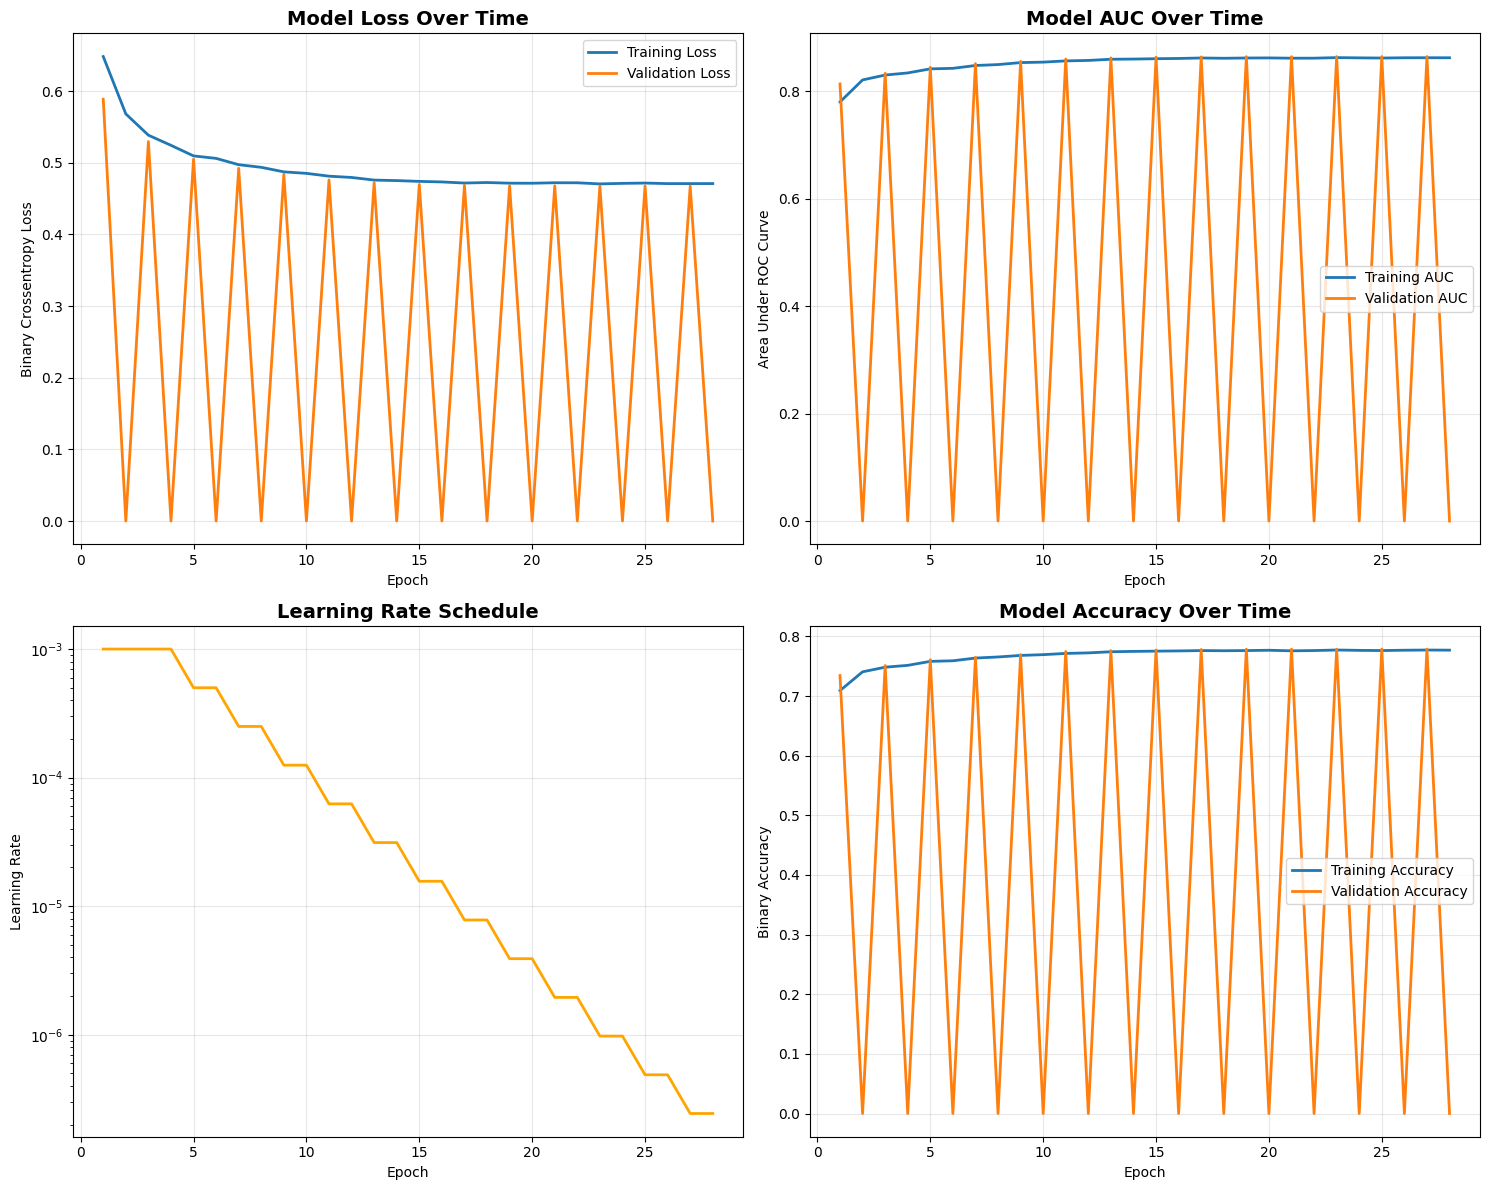

Training visualizations saved to 'training_history.png'


In [13]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history_df['epoch'], history_df['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Crossentropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation AUC
axes[0, 1].plot(history_df['epoch'], history_df[auc_key], label='Training AUC', linewidth=2)
axes[0, 1].plot(history_df['epoch'], history_df[val_auc_key], label='Validation AUC', linewidth=2)
axes[0, 1].set_title('Model AUC Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Area Under ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(history_df['epoch'], history_df[lr_key], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Training and Validation Accuracy
axes[1, 1].plot(history_df['epoch'], history_df['binary_accuracy'], label='Training Accuracy', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_binary_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1, 1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Binary Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training visualizations saved to 'training_history.png'")


In [14]:
# Model performance analysis
best_epoch = history_df[val_auc_key].idxmax() + 1
best_val_auc = history_df[val_auc_key].max()
best_val_accuracy = history_df.loc[history_df[val_auc_key].idxmax(), 'val_binary_accuracy']
final_lr = history_df[lr_key].iloc[-1]

print("Model Performance Summary")
print("=" * 40)
print(f"Best Validation AUC: {best_val_auc:.4f} (Epoch {best_epoch})")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Total Training Time: {len(history_df)} epochs")
print(f"Final Learning Rate: {final_lr:.2e}")

# Calculate training efficiency
total_samples_processed = len(history_df) * steps_per_epoch * batch_size
print(f"Total Samples Processed: {total_samples_processed:,}")

print("\nKey Insights:")
if best_val_auc > 0.85:
    print("Excellent performance! AUC > 0.85 indicates strong discriminative ability.")
elif best_val_auc > 0.80:
    print("Good performance! AUC > 0.80 shows the model can distinguish signal from background.")
elif best_val_auc > 0.75:
    print("Moderate performance. Consider hyperparameter tuning or feature engineering.")
else:
    print("Poor performance. Model may need architectural changes or more data.")

if len(history_df) < 10:
    print("Training stopped very early. Consider adjusting early stopping patience.")
elif len(history_df) >= 45:
    print("Training used most of the available epochs. Consider increasing max epochs.")


Model Performance Summary
Best Validation AUC: 0.8644 (Epoch 27)
Best Validation Accuracy: 0.7788
Total Training Time: 28 epochs
Final Learning Rate: 2.44e-07
Total Samples Processed: 307,822,592

Key Insights:
Excellent performance! AUC > 0.85 indicates strong discriminative ability.


## Model Architecture Analysis

### Wide & Deep Architecture Benefits:

1. **Wide Component**: The linear model captures feature interactions and provides memorization capabilities for frequent feature combinations.

2. **Deep Component**: The deep neural network learns complex, non-linear feature representations and generalizes to unseen feature combinations.

3. **Combined Strength**: The ensemble of both components balances memorization (wide) and generalization (deep) for optimal performance.

### Key Improvements in This Implementation:

1. **Input Normalization**: Integrated normalization layer ensures consistent feature scaling across all data.

2. **L2 Regularization**: Added to deep layers to prevent overfitting on the large parameter space.

3. **Enhanced Callbacks**: 
   - AUC-based early stopping for better classification performance monitoring
   - Conservative learning rate scheduling for training stability
   - Model checkpointing to save the best-performing model

4. **Modern Keras API**: Built with the functional API for better flexibility and maintainability.

### Physics Context:

The 28 input features represent kinematic properties of particle collision events:
- Lepton properties (energy, momentum, angles)
- Missing transverse energy (indicating neutrinos)
- Jet properties and counts
- Derived kinematic variables

High AUC scores indicate the model successfully learned to distinguish Higgs boson decay signatures from background Standard Model processes.

In [15]:
# Optional: Save final model and training history
try:
    # Save the final model (best weights are restored from checkpoint)
    wide_and_deep.save(os.path.join(OUTPUT_DIR, 'final_higgs_model.keras'))
    print(f"Final model saved to '{os.path.join(OUTPUT_DIR, 'final_higgs_model.keras')}'")
    
    # Save training history
    history_df.to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)
    print(f"Training history saved to '{os.path.join(OUTPUT_DIR, 'training_history.csv')}'")
    
    # Generate and save the model architecture diagram
    tf.keras.utils.plot_model(
        wide_and_deep,
        to_file=os.path.join(OUTPUT_DIR, 'wide_and_deep_model.png'),
        show_shapes=True,
        show_layer_names=True
    )
    print(f"Model architecture diagram saved to '{os.path.join(OUTPUT_DIR, 'wide_and_deep_model.png')}'")
    
    # Save model configuration summary
    config_summary = {
        'model_name': 'Wide & Deep Higgs Classifier',
        'total_parameters': wide_and_deep.count_params(),
        'best_val_auc': float(best_val_auc),
        'best_val_accuracy': float(best_val_accuracy),
        'training_epochs': len(history_df),
        'batch_size': batch_size,
        'learning_rate_initial': 0.001,
        'learning_rate_final': float(final_lr),
        'regularization_l2': 1e-5,
        'dropout_rate': DROPOUT,
        'units_per_layer': UNITS,
        'architecture': 'Wide & Deep with 5 dense layers'
    }
    
    import json
    with open(os.path.join(OUTPUT_DIR, 'model_config.json'), 'w') as f:
        json.dump(config_summary, f, indent=2)
    print(f"Model configuration saved to '{os.path.join(OUTPUT_DIR, 'model_config.json')}'")
    
except Exception as e:
    print(f"Error saving files: {e}")

print(f"\nHiggs Boson Classification Project Complete!")
print(f"\nFiles generated in: {OUTPUT_DIR}")
print("  training_history.png - Training curves visualization")
print("  best_higgs_model.keras - Best model weights (saved during training)")
print("  final_higgs_model.keras - Final model state")
print("  training_history.csv - Complete training metrics")
print("  model_config.json - Model configuration summary")
print("  wide_and_deep_model.png - Model architecture diagram")


Final model saved to '/kaggle/working/final_higgs_model.keras'
Training history saved to '/kaggle/working/training_history.csv'
You must install pydot (`pip install pydot`) for `plot_model` to work.


Model architecture diagram saved to '/kaggle/working/wide_and_deep_model.png'
Model configuration saved to '/kaggle/working/model_config.json'

Higgs Boson Classification Project Complete!

Files generated in: /kaggle/working/
  training_history.png - Training curves visualization
  best_higgs_model.keras - Best model weights (saved during training)
  final_higgs_model.keras - Final model state
  training_history.csv - Complete training metrics
  model_config.json - Model configuration summary
  wide_and_deep_model.png - Model architecture diagram
